In [1]:
import os
import numpy as np
import pandas as pd
import pandas as SignalTraces_pd

from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt_raw
import matplotlib.pyplot as plt_hist


import caiman as cm
from caiman.utils import visualization
import os
from os.path import join, exists
import copy

# for resampling data
from scipy import signal

2025-06-13 11:22:30.013826: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#. Input Deconv Data

# Target_Frame_Rate will be 20   #. This is same as the 20 frames/second for Ca Imaging  (Resample Rate )

# animal = 'DS19'
# paradigm = 'P5_5'
# reward = 'Sucrose'
# session = 'S14'

# Save_Path = '/Users/kang/Desktop/Alignment/'
# File_Path = '/Users/kang/Desktop/Alignment/'

# animal = 'DS18'
# paradigm = 'P5_5'
# reward = 'Water'
# session = 'S5'

# animal = 'DS111'
# paradigm = 'P5_5'
# reward = 'Water'
# session = 'S35'

animal = 'DS12'
paradigm = 'RR10'
reward = 'Sucrose'
session = 'S2'

File_Path = '/Users/kang/Desktop/Alignment'
Save_Path = '/Users/kang/Desktop/Alignment'


#############################
####### Settings for troubleshoot files #######
TroubleShoot_Trim_End_5S_Pulse = 0   # default =0;  Removes the end of imaging file if it exceeds 40 min (only use if necessary)

TroubleShoot_Trim_Begining_GPIO_Arduino = 0 # Trim Begining of GPIO and Arduino Data to match the length of Ca Imaging Data (applies before whole session alignmnet)

TroubleShoot_Remove_Nan_in_GPIO_DATA =0   # Sometimes NAN is present in the GPIO data (from export setting).  This affectes data format 
############################
# TroubleShoot_Trim_Begining_GPIO_Arduino
# 1. Calculate # frames in imaging video (by counting GPIO output)
# 2. Definition for 5s alignment:  The length of 5s aligned data After aligned video and GPIO,  would be exactly 20 frames/s 
# 3. The length of 5s aligned data – Calculated # frames in image video = how much data to crop out in the beginning 
# 4. Whole session alignment of step 3 data 
# * It does not matter if the first 5s pulse is actually 5s long. That <= 5 time period data would be distorted, but other parts of the data that follows would be fine bc they were still being anchored by other 5s pulse 


In [3]:
# find matching file given a directory, the animal id, the paradigm, the reward type, session and the 
# file extension e.g .csv, .txt, .hdf5
def find_matching_file(search_dir, animal, paradigm, reward, session, extension):
    for file_name in os.listdir(search_dir):
        if all(param.lower() in file_name.lower() for param in [animal, paradigm, reward, session]):
            if file_name.endswith(extension):
                return os.path.join(search_dir, file_name)
    
    raise FileNotFoundError("Requested file not found.")


In [4]:
#root_path = '/Users/kang/Desktop/Alignment/'
root_path = File_Path
data_path = join(root_path, animal + '-' + session)
print(f'this is the data path: {data_path}')

#os.listdir(root_path)
complete_save_name = find_matching_file(root_path, animal, paradigm, reward, session, '.csv')
print(f'this is the path and the file name of the aligned file will be saved: {complete_save_name}')


ard_file = find_matching_file(root_path, animal, paradigm, reward, session, '.txt')
gpio_file = find_matching_file(root_path, animal, paradigm, reward, session, '.csv')
hdf_path = find_matching_file(root_path, animal, paradigm, reward, session, '.hdf5')

this is the data path: /Users/kang/Desktop/Alignment/DS12-S2
this is the path and the file name of the aligned file will be saved: /Users/kang/Desktop/Alignment/Session-20230424-180728-Ka-DS12-RR10-S2-Sucrose.csv


In [5]:
print(root_path, animal, paradigm, reward, session, '.csv')

/Users/kang/Desktop/Alignment DS12 RR10 Sucrose S2 .csv


In [6]:
# Calcium Imaging Data
frame_rate = 20

increments = 1/frame_rate 

cnm =cm.source_extraction.cnmf.cnmf.load_CNMF(hdf_path)

# save the temporal and spatial components as different arrays, by removing the automatically rejected 
# components and the manually rejected components
accepted_components = cnm.estimates.idx_components

#update the 'manually_rejected' 
manually_rejected = [] # no need to worry about this for now, the manually rejected components are filtered by another script
final_components =np.setdiff1d(accepted_components,manually_rejected)

#prepare the raw data
spatial = cnm.estimates.A[final_components]
temporal = cnm.estimates.C[final_components]
deconv = cnm.estimates.S[final_components]
deconv_transpose = np.transpose(deconv)

temporal_transpose = np.transpose(temporal)

#make a column for time
col_time = np.round(np.arange(0, temporal_transpose.shape[0]/frame_rate, increments), 2)
df_cal_traces= pd.DataFrame(temporal_transpose) # calcium transients 
cols= list(df_cal_traces.columns) #collumn names for calcium transients
col_text = 'deconv_'
cols_deconv = [col_text +str(col) for col in cols] # column names for deconvolved data
df_cal_deconv  = pd.DataFrame(deconv_transpose, columns = cols_deconv) # deconvolved data

# df_cal.insert(0, 'time', col_time)

df_cal = pd.concat([df_cal_traces,df_cal_deconv], axis=1)
df_cal.insert(0, 'time', col_time)


## check--make sure the following code returns the length of the video
CAIMAN_Image_Duration= (temporal_transpose.shape[0]/frame_rate)/60
print(CAIMAN_Image_Duration)
print(len(df_cal))
print(len(df_cal_deconv) )
print((temporal_transpose.shape[0]))

39.99916666666666
47999
47999
47999


In [7]:
# read the file and convert time to type float
gpio = pd.read_csv(gpio_file)
gpio['Time (s)'].astype('float')

##################################################
#  remove "nan" from GPIO data when it's in the data 
if(TroubleShoot_Remove_Nan_in_GPIO_DATA == 1):
    gpio[' Value'] = pd.to_numeric(gpio[' Value'], errors="coerce") # converts non-numbers(nan) to "NaN"
    gpio = gpio.dropna() # drop rows with nan values
    gpio.reset_index(inplace=True)
##################################################

# extract data from gpio-1 and gpio-2 channels 
gpio_BNC_Sync_Input_full = gpio[gpio[" Channel Name"]== ' BNC Trigger Input']
gpio_BNC_Sync_Output_full = gpio[gpio[" Channel Name"]== ' BNC Sync Output']

gpio_1_full = gpio[gpio[" Channel Name"]== ' GPIO-1']
gpio_2_full = gpio[gpio[" Channel Name"]== ' GPIO-2']

# reset the indices. Python will throw a warning saying that you are changing a slice from a dataframe. 
# It is not an issue in this case, we want to only change the values in these slices of the dataframe.

gpio_BNC_Sync_Input_full.reset_index(inplace=True)
gpio_BNC_Sync_Output_full.reset_index(inplace=True)
gpio_1_full.reset_index(inplace=True)
gpio_2_full.reset_index(inplace=True)

gpio_BNC_Sync_Input_full.drop('index', axis=1, inplace=True)
gpio_BNC_Sync_Output_full.drop('index', axis=1, inplace=True)
gpio_1_full.drop('index', axis=1, inplace=True)
gpio_2_full.drop('index', axis=1, inplace=True)

#################################################
# # DO NOT DELETE
# # Sometimes, GPIO picked up additional 5s pulse after imaging is complete, 
# # This script trims the excess in the end

if(TroubleShoot_Trim_End_5S_Pulse ==1):

    New_len_Bins = 2500  # value based on what you see on the graph above
    
    #  find the smallest time value that pass the New_len_Bins threshold.  This cuts out the extra time in the back
    a = gpio_BNC_Sync_Input_full[gpio_BNC_Sync_Input_full['Time (s)'] > New_len_Bins]
    a.reset_index(inplace=True)    
    gpio_BNC_Sync_Input_full = gpio_BNC_Sync_Input_full.loc[0:a['index'][0]].copy()
    
    a = gpio_BNC_Sync_Output_full[gpio_BNC_Sync_Output_full['Time (s)'] > New_len_Bins]
    a.reset_index(inplace=True)    
    gpio_BNC_Sync_Output_full = gpio_BNC_Sync_Output_full.loc[0:a['index'][0]].copy()
    
    a = gpio_1_full[gpio_1_full['Time (s)'] > New_len_Bins]
    a.reset_index(inplace=True)    
    gpio_1_full = gpio_1_full.loc[0:a['index'][0]].copy()
    
    a = gpio_2_full[gpio_2_full['Time (s)'] > New_len_Bins]
    a.reset_index(inplace=True)    
    gpio_2_full = gpio_2_full.loc[0:a['index'][0]].copy()


#####################################################

value_3 = gpio_BNC_Sync_Input_full[' Value']
value_3_binary = []
for item in value_3:
    check = 1 if item >0 else 0
    value_3_binary.append(check)

gpio_BNC_Sync_Input_full['value_binary']=value_3_binary


value_4 = gpio_BNC_Sync_Output_full[' Value']
value_4_binary = []
for item in value_4:
    check = 1 if item >0 else 0
    value_4_binary.append(check)

gpio_BNC_Sync_Output_full['value_binary']=value_4_binary

#####*********
value = gpio_1_full[' Value']
value_binary = []
for item in value:
    check = 1 if item >30000 else 0
    value_binary.append(check)

gpio_1_full['value_binary']=value_binary

value_2 =gpio_2_full[' Value']
value_2_binary =[]
for item in value_2:
    check = 1 if item >30000 else 0
    value_2_binary.append(check)

gpio_2_full['value_binary']=value_2_binary


/var/folders/2c/qcjtsn_j1xngx_g__j1y_rn00000gn/T/ipykernel_16470/3342034972.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gpio_BNC_Sync_Input_full.drop('index', axis=1, inplace=True)
/var/folders/2c/qcjtsn_j1xngx_g__j1y_rn00000gn/T/ipykernel_16470/3342034972.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gpio_BNC_Sync_Output_full.drop('index', axis=1, inplace=True)
/var/folders/2c/qcjtsn_j1xngx_g__j1y_rn00000gn/T/ipykernel_16470/3342034972.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [8]:
# # print(gpio_BNC_Sync_Input_full[' Value'])
# # print(gpio_BNC_Sync_Output_full[' Value'])
# print(item)
# #print((value_4[0]>0))
# # print((0>0))
# print(type(value_4[0]))
# a=8/0
#print(gpio_BNC_Sync_Input_full[' Value'])
# print(gpio_BNC_Sync_Output_full[' Value'])
# print(type(gpio_BNC_Sync_Output_full[' Value'][0]))

#print(gpio[0:50])
#print(gpio_1_full[0:50])
# print(gpio_BNC_Sync_Input_full)

# Tem = gpio
# print('\nBefore')
# print(Tem)

# Tem[' Value'] = pd.to_numeric(Tem[' Value'], errors="coerce") # converts non-numbers(nan) to "NaN"
# Tem = Tem.dropna() # drop rows with nan values
# Tem.reset_index(inplace=True)
  
# print('\nAfter')
# print(Tem)

<Axes: title={'center': 'GPIO2-original, short time frame'}, xlabel='Time (s)'>

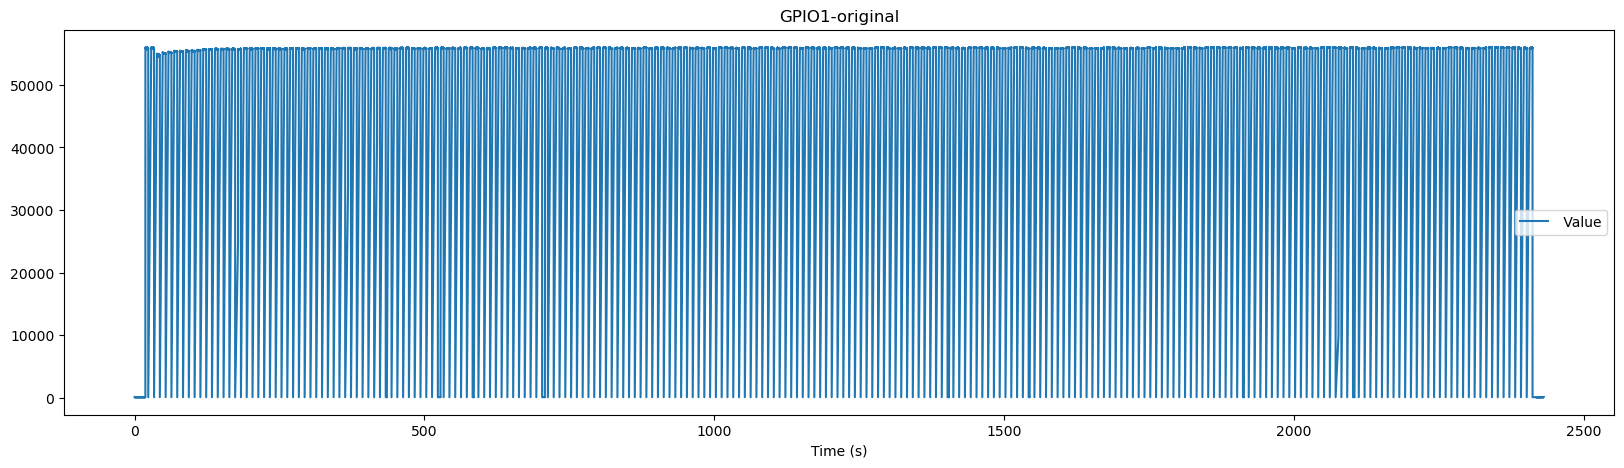

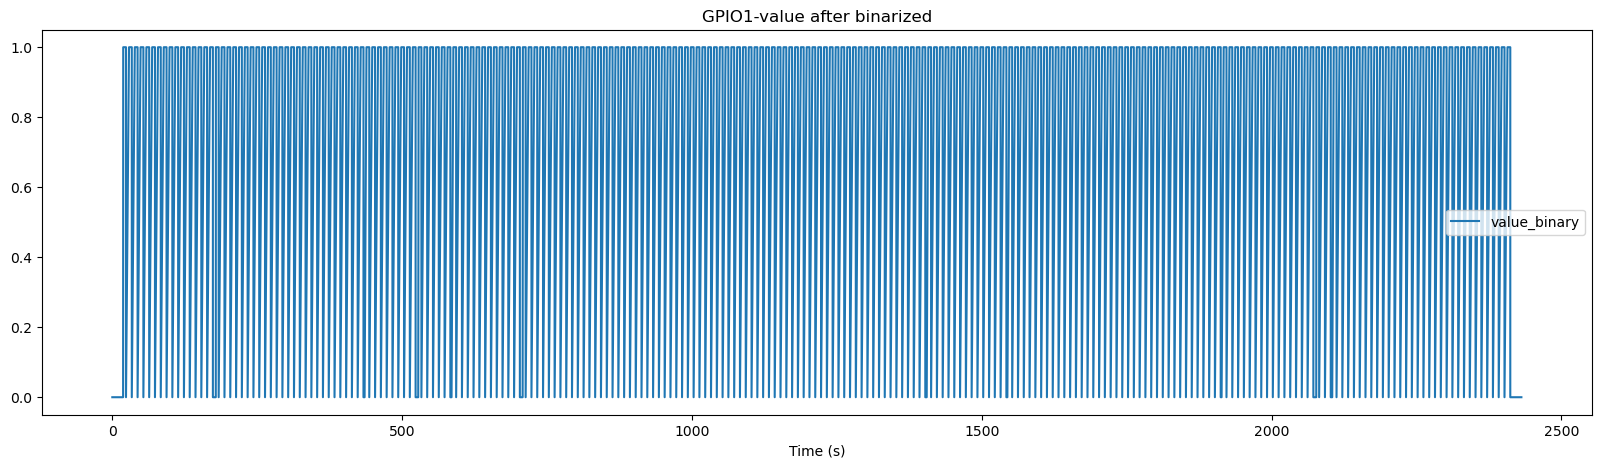

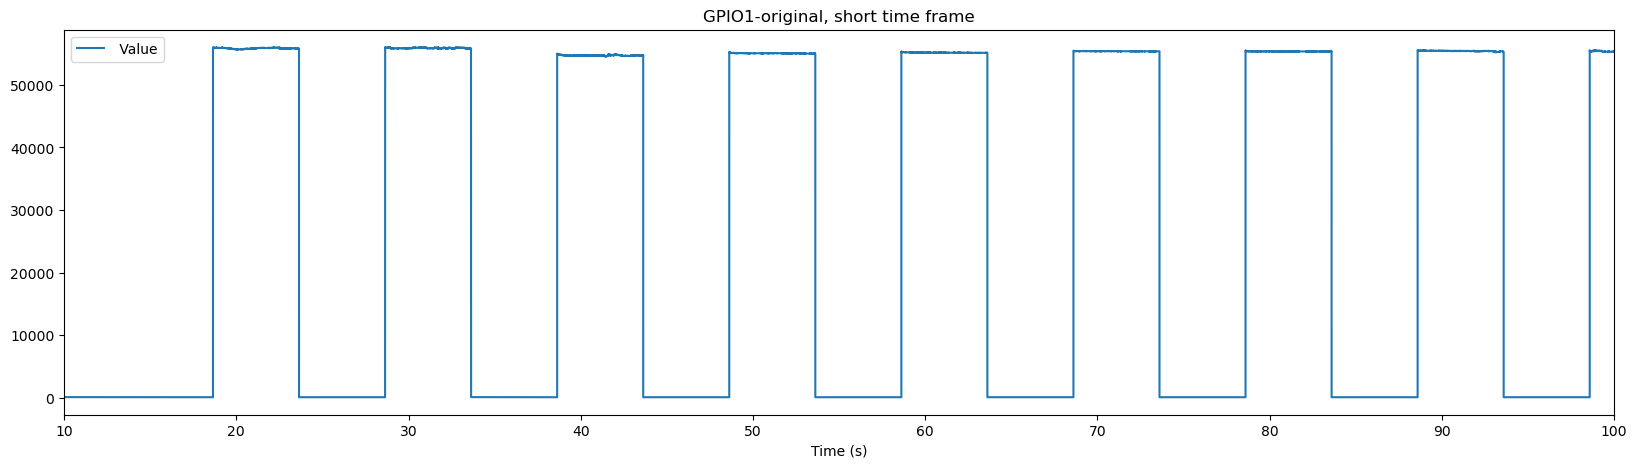

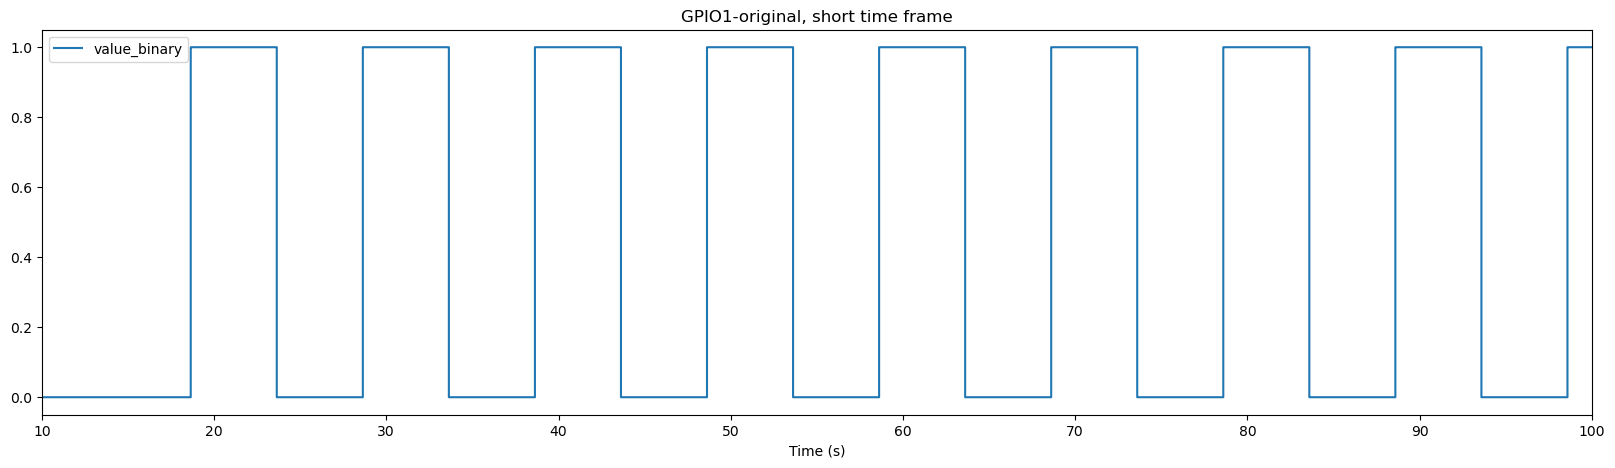

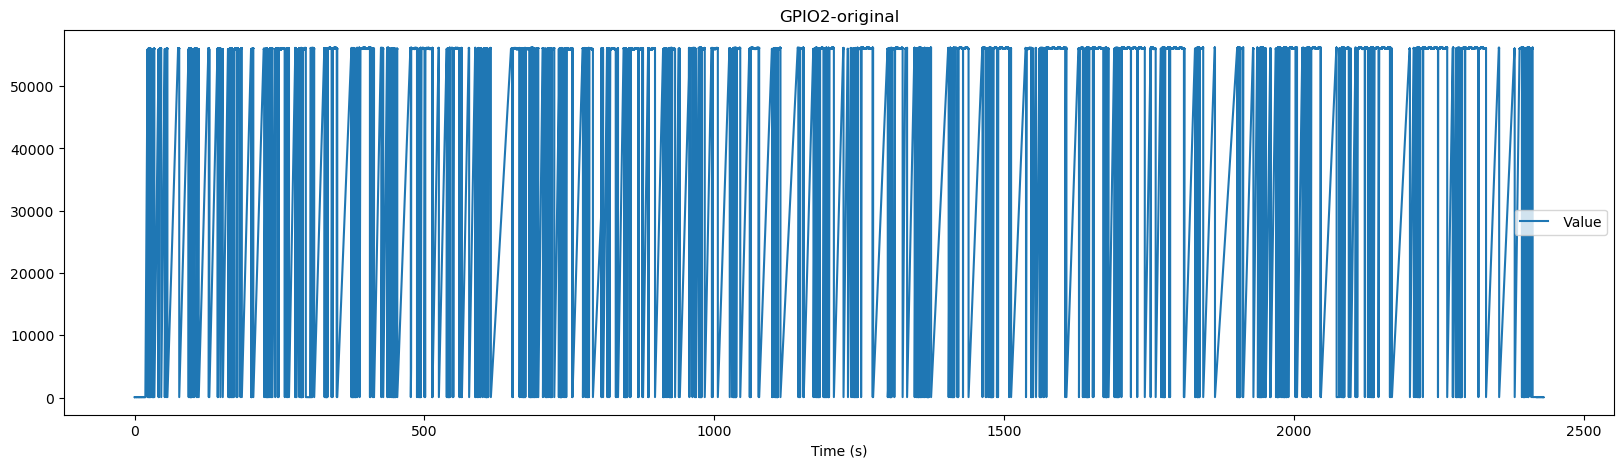

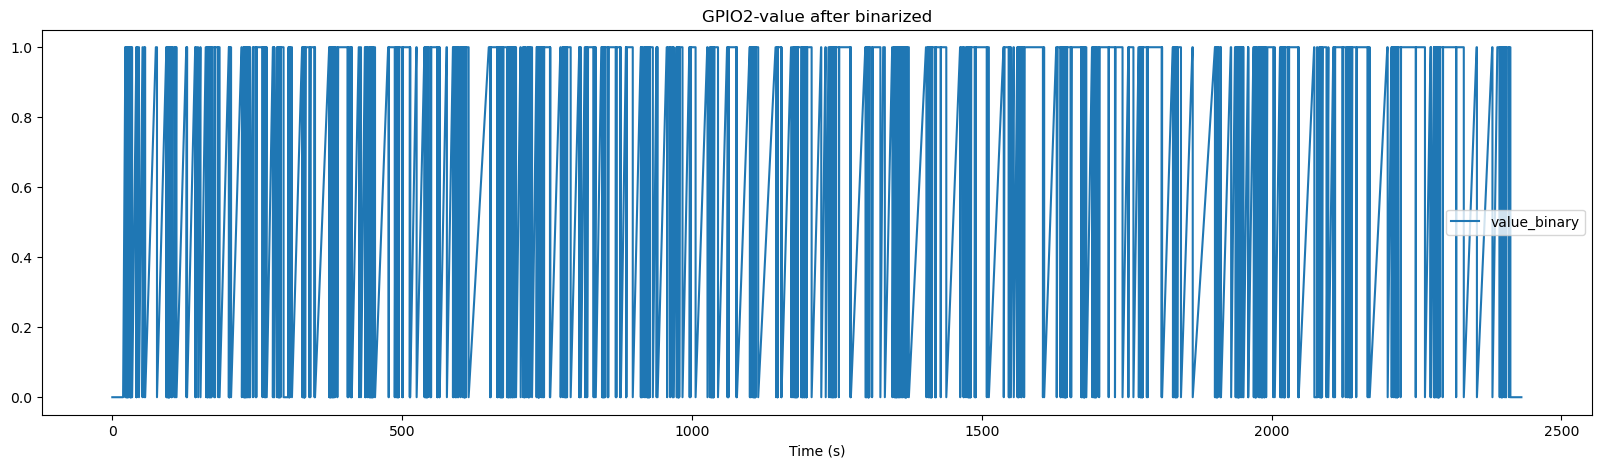

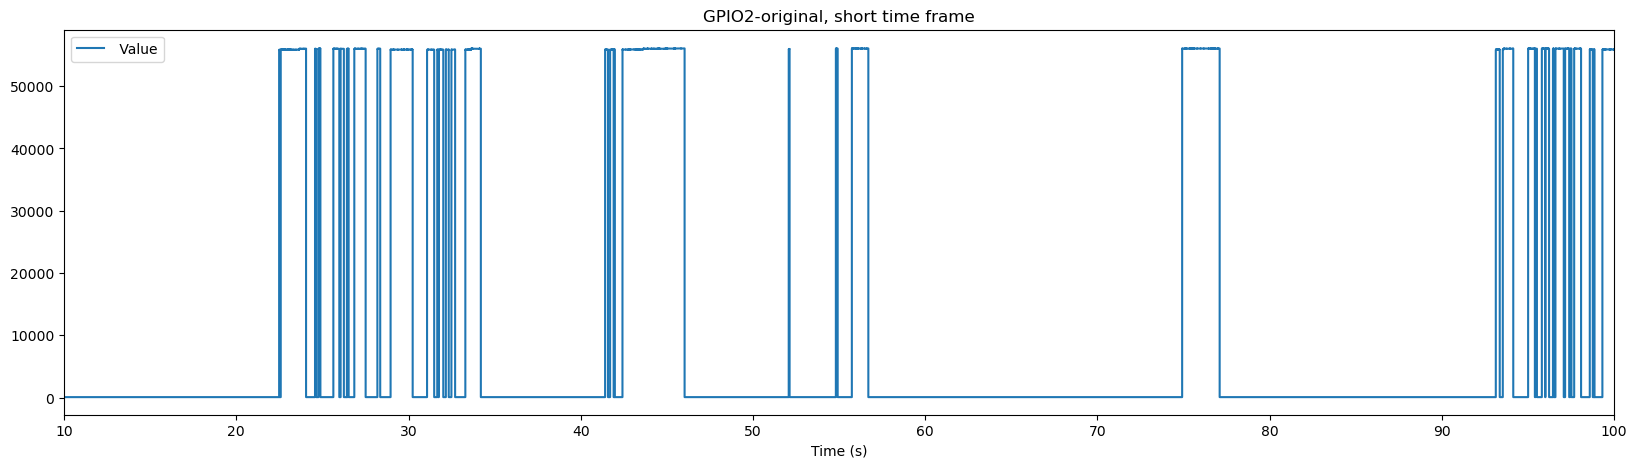

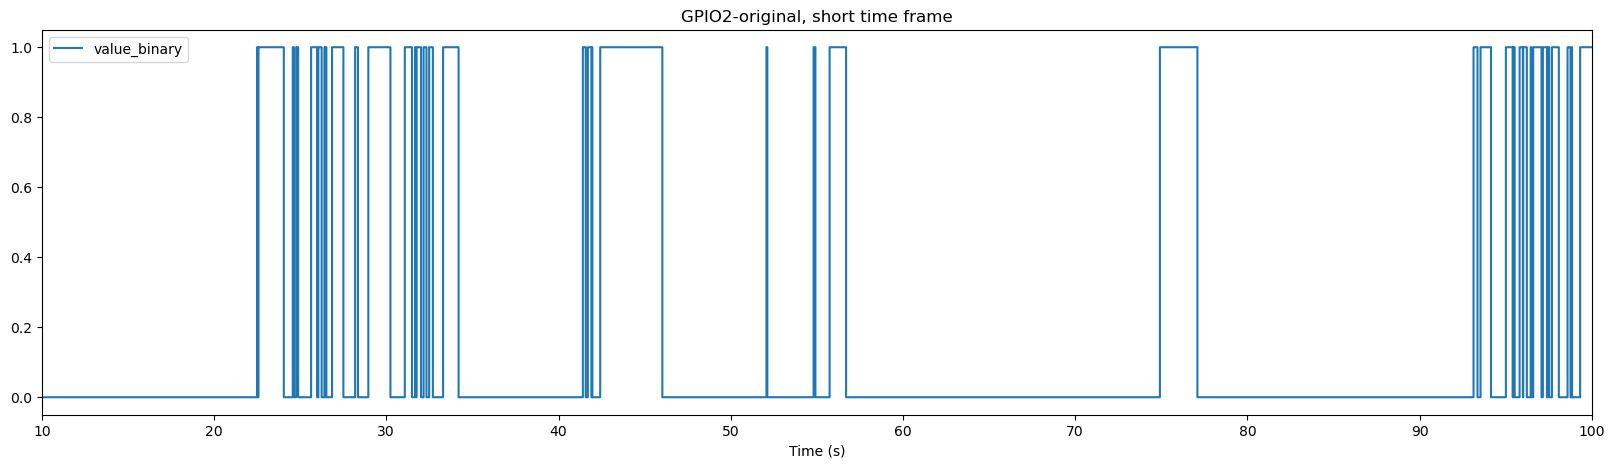

In [9]:
# check that the first two graphs look the same
gpio_1_full.plot(x="Time (s)", y=" Value", title = "GPIO1-original",figsize=(20,5))
gpio_1_full.plot(x="Time (s)", y="value_binary", title = "GPIO1-value after binarized",figsize=(20,5))

#also check that the last two graphs look the same
gpio_1_full.plot(x="Time (s)", y=" Value", title = "GPIO1-original, short time frame",figsize=(20,5),xlim=(10,100),drawstyle='steps-post')
gpio_1_full.plot(x="Time (s)", y="value_binary", title = "GPIO1-original, short time frame",figsize=(20,5),xlim=(10,100),drawstyle='steps-post')

# check that the first two graphs look the same
gpio_2_full.plot(x="Time (s)", y=" Value", title = "GPIO2-original",figsize=(20,5))
gpio_2_full.plot(x="Time (s)", y="value_binary", title = "GPIO2-value after binarized",figsize=(20,5))

#also check that the last two graphs look the same
gpio_2_full.plot(x="Time (s)", y=" Value", title = "GPIO2-original, short time frame",figsize=(20,5),xlim=(10,100),drawstyle='steps-post')
gpio_2_full.plot(x="Time (s)", y="value_binary", title = "GPIO2-original, short time frame",figsize=(20,5),xlim=(10,100),drawstyle='steps-post')


/var/folders/2c/qcjtsn_j1xngx_g__j1y_rn00000gn/T/ipykernel_16470/1925257271.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gpio_1_full['value_binary_temp']=value_binary
/var/folders/2c/qcjtsn_j1xngx_g__j1y_rn00000gn/T/ipykernel_16470/1925257271.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gpio_1_full['Temp_Extract_Binary']=Temp_Extract_Binary
/var/folders/2c/qcjtsn_j1xngx_g__j1y_rn00000gn/T/ipykernel_16470/1925257271.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

2411.835


/var/folders/2c/qcjtsn_j1xngx_g__j1y_rn00000gn/T/ipykernel_16470/1925257271.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gpio_1_full['value_binary']= Corrected_Binary


<Axes: title={'center': '5 Sec Pulse Duration'}, xlabel='Pulse_Duration_Time', ylabel='Random_Num'>

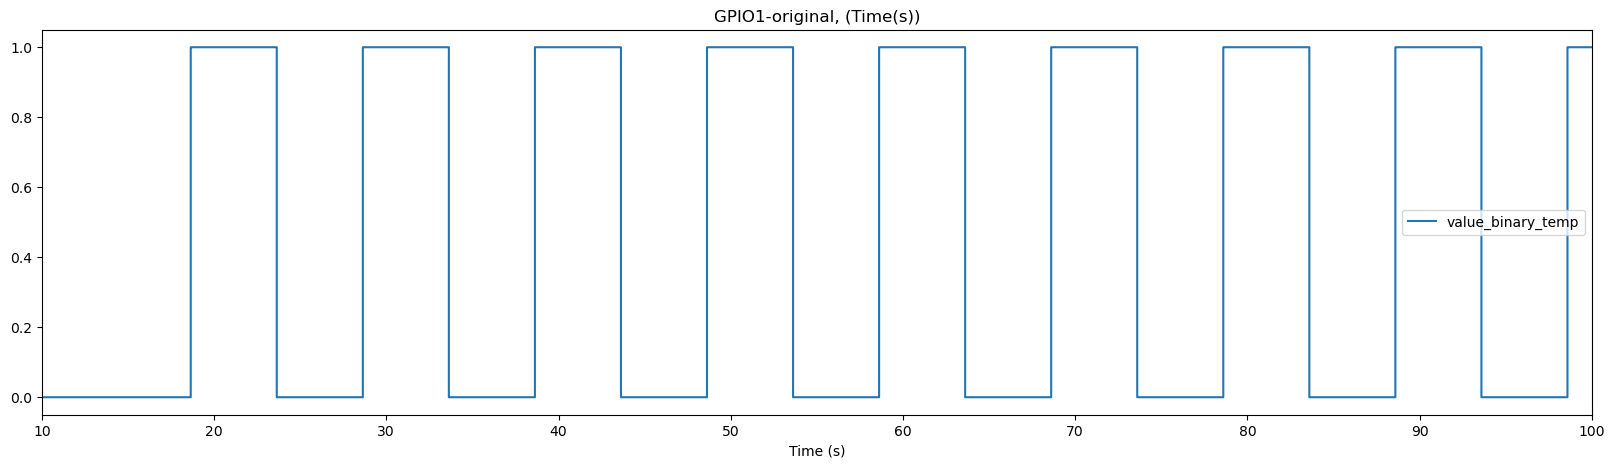

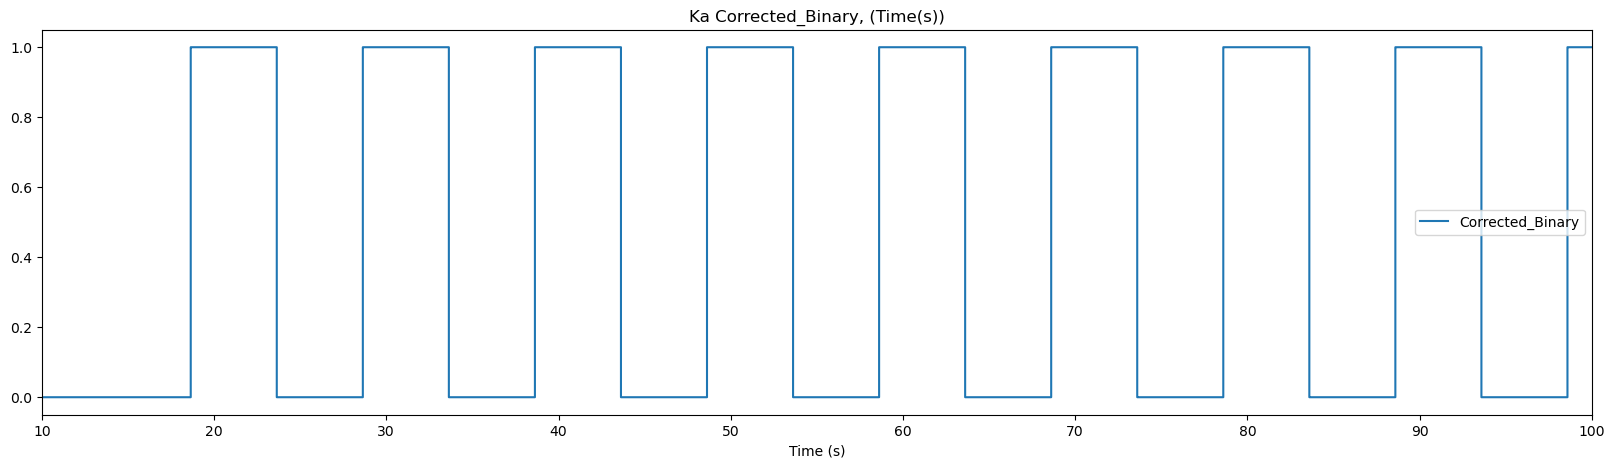

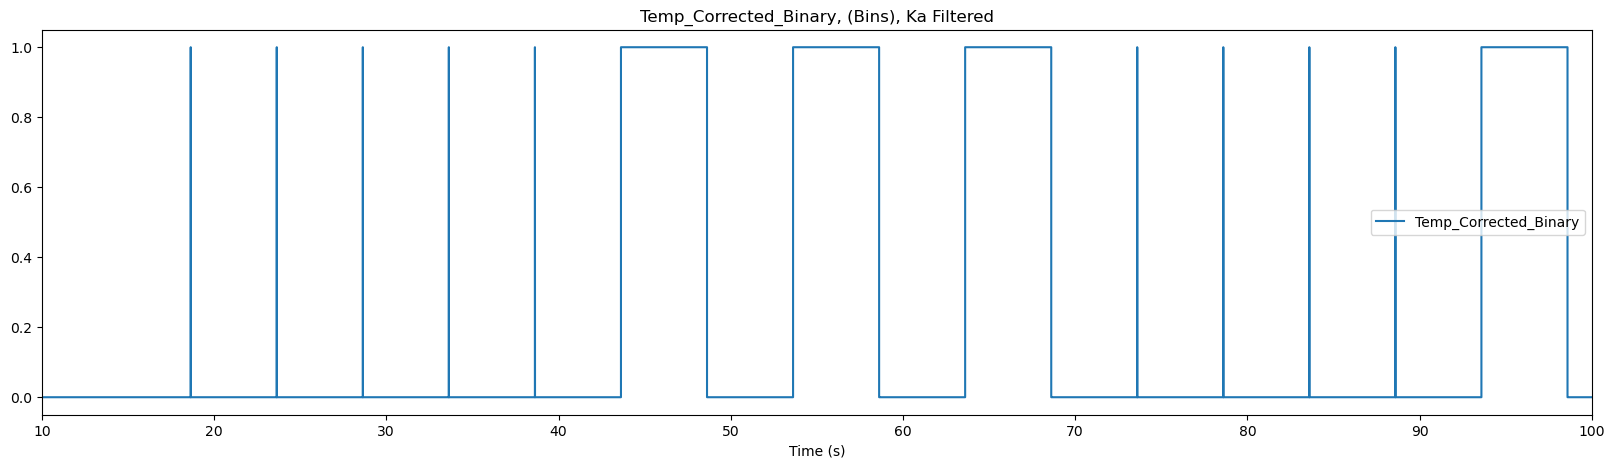

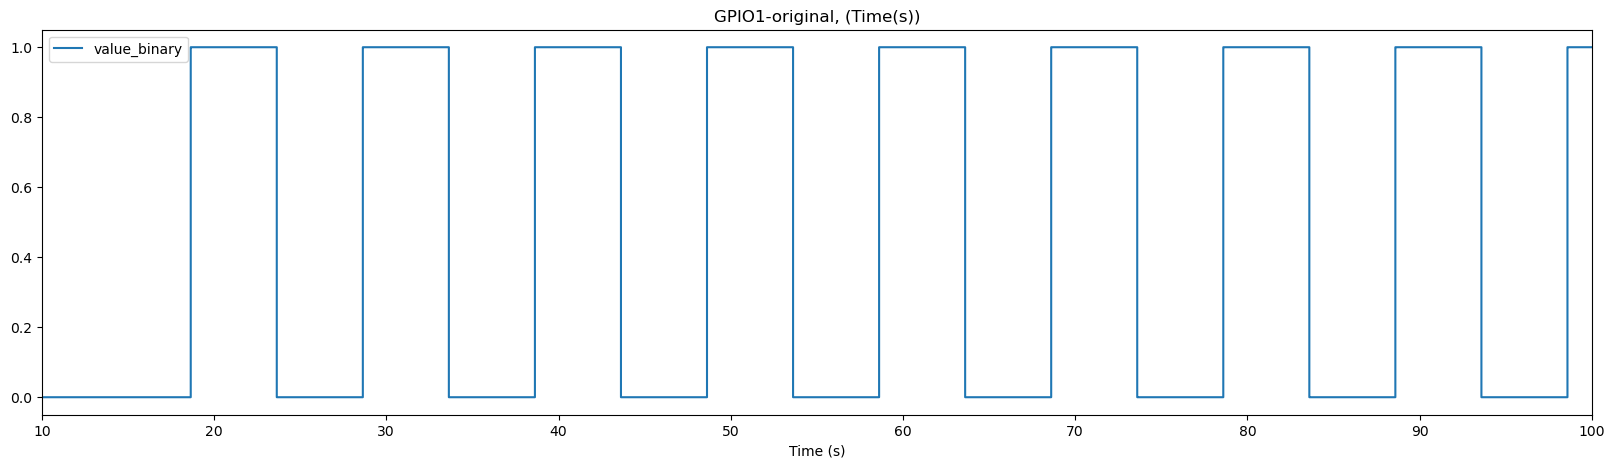

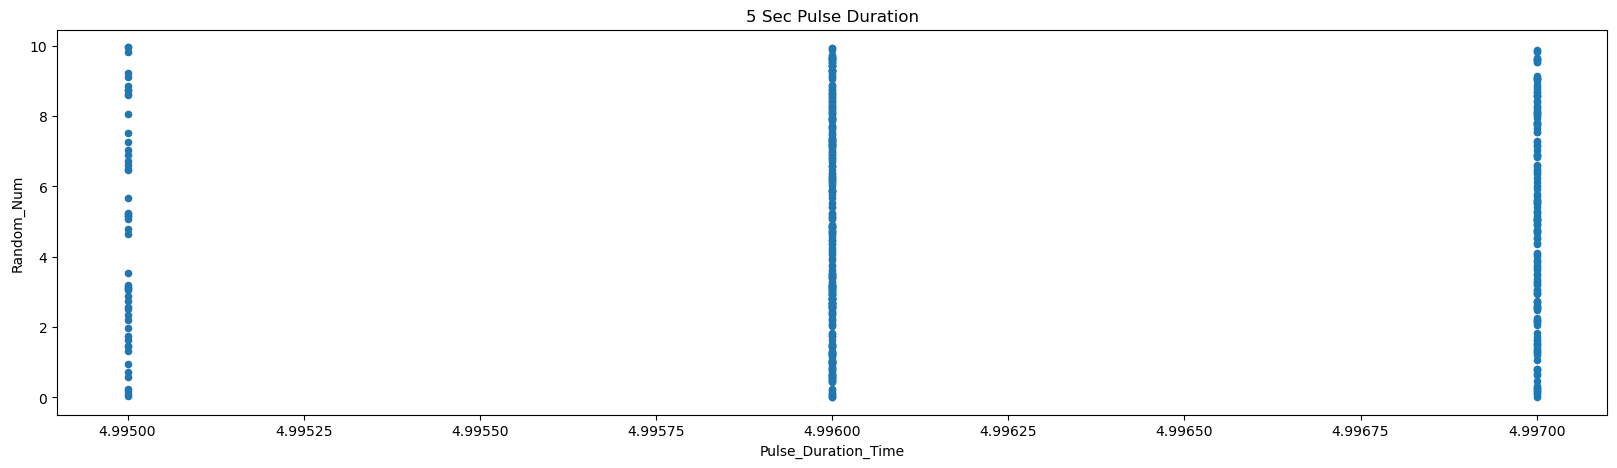

In [10]:
#  Ka Added (part 2)

#Inter_Event_Threshold = 4.5  # unit in seconds (5 s pulse) (Standard Setting = 4.7,  some files works with 3 )
Inter_Event_Threshold = 3  



# value = gpio_1_full[' Value']
value_binary_temp = []
for item in value:
    check = 1 if item >30000 else 0
    value_binary_temp.append(check)
gpio_1_full['value_binary_temp']=value_binary


Temp_Extract_Binary = []
Temp_Corrected_Binary =[]
Corrected_Binary =[]


for i in range(5):
    Temp_Extract_Binary.append(0)
    Temp_Corrected_Binary.append(0)


# Extract Binary
for i in range(5, len(gpio_1_full[' Value'])):
    Previous_bin = gpio_1_full['value_binary_temp'][i-1]
    Current_bin = gpio_1_full['value_binary_temp'][i]
    Previous_bin_Time = gpio_1_full['Time (s)'][i-1]
    Current_bin_Time = gpio_1_full['Time (s)'][i]

    if((Current_bin == 0)& (Previous_bin == 1)):    # offset
        Temp_Extract_Binary.append(1)
    elif((Current_bin == 1)& (Previous_bin == 0)):  # onset
        Temp_Extract_Binary.append(1)
    else:
        Temp_Extract_Binary.append(0)



gpio_1_full['Temp_Extract_Binary']=Temp_Extract_Binary


# Corrects Binary Temperory 
# Finds the first timestamp
for ii in range(5, len(gpio_1_full[' Value'])):
    
    if(gpio_1_full['Temp_Extract_Binary'][ii]== 1):
        Previous_TimeStamp = gpio_1_full['Time (s)'][ii]
        Previous_Bin = ii
        Temp_Corrected_Binary.append(1)
        break
    else:
        Temp_Corrected_Binary.append(0)

for i in range((Previous_Bin+1), len(gpio_1_full[' Value'])):
    if(gpio_1_full['Temp_Extract_Binary'][i]==1):
        
        Current_TimeStamp = gpio_1_full['Time (s)'][i]
        Current_bin = i 
        
        if((Current_TimeStamp-Previous_TimeStamp)> Inter_Event_Threshold):
            Temp_Corrected_Binary.append(1)
            Previous_TimeStamp = gpio_1_full['Time (s)'][i]
            Previous_Bin = i
        else:
            Temp_Corrected_Binary.append(-1)
    else:
        Temp_Corrected_Binary.append(0)
      
gpio_1_full['Temp_Corrected_Binary']=Temp_Corrected_Binary        

##Failed Sript 

# Re-create the upper part of the on/off, so it looks like the original 5s on/off binary 
TimeStampLoc = np.where(np.array(Temp_Corrected_Binary) == 1)[0]

# fill zeros up until the first timestamp 
for i in range(TimeStampLoc[0]):   ######### removed -1   previously (TimeStampLoc[0]-1)
        Corrected_Binary.append(0)


for i in range(len(TimeStampLoc)-1):
    Loc_Begin= TimeStampLoc[i]
    Loc_End = TimeStampLoc[i+1]

    if(np.median(gpio_1_full['value_binary_temp'][(Loc_Begin):Loc_End])> 0.5):   # 10 is arbrituary,  "on signal" is coded with more bins than "off signal" 
        for ii in range((Loc_End- Loc_Begin+1-1)):
            Corrected_Binary.append(1)
    else:
        #print('\n' +str(Loc_Begin) + ': ' + str(Loc_End) + ':' + str(Loc_End- Loc_Begin+1))############# ***************
        for ii in range((Loc_End- Loc_Begin+1-1)):
            Corrected_Binary.append(0)
            

# fill zeros afte the last timestamp 
for i in range(TimeStampLoc[len(TimeStampLoc)-1], len(gpio_1_full[' Value'])+0):  
        Corrected_Binary.append(0)
        
gpio_1_full['Corrected_Binary']=Corrected_Binary


print(Current_TimeStamp)





# 10810,10840 for visualize in bins

#gpio_1_full.plot(x="Time (s)", y="value_binary_temp", title = "GPIO1-original, (Time(s))",figsize=(20,5),xlim=(10,100),drawstyle='steps-post')
gpio_1_full.plot(x="Time (s)",y="value_binary_temp", title = "GPIO1-original, (Time(s))",figsize=(20,5),xlim=(10, 100 ), drawstyle='steps-post')
gpio_1_full.plot(x="Time (s)",y="Corrected_Binary", title = "Ka Corrected_Binary, (Time(s))",figsize=(20,5),xlim=(10, 100), drawstyle='steps-post')

#gpio_1_full.plot(x="Time (s)", y="value_binary", title = "GPIO1-original, (Time(s)), Ka_Filtered",figsize=(20,5),xlim=(10,100),drawstyle='steps-post')

# 7160, 7180 to look at one event #
# gpio_1_full.plot(y="value_binary_temp", title = "GPIO1-original, (Bins)",figsize=(20,5),xlim=(10,40000),drawstyle='steps-post')
#gpio_1_full.plot(x="Time (s)", y="Temp_Extract_Binary", title = "Temp_Extract_Binary, (Bins)",figsize=(20,5),xlim=(10,100),drawstyle='steps-post')
# gpio_1_full.plot(y="Temp_Corrected_Binary", title = "GPIO1-original, (Bins), Ka Filtered",figsize=(20,5),xlim=(10,40000),drawstyle='steps-post')
gpio_1_full.plot(x="Time (s)",y="Temp_Corrected_Binary", title = "Temp_Corrected_Binary, (Bins), Ka Filtered",figsize=(20,5),xlim=(10, 100 ),drawstyle='steps-post')

# ax = (df_merge_gpio_unique_0["Corrected_Binary"]+0.5).plot(x="time", y="z", title ="All data",drawstyle='steps-post')
# (df_merge_gpio_unique_0["value_binary"]-0.5).plot(x="time", y="value_binary",figsize=(20,5), ax=ax,drawstyle='steps-post')

# Assign Corrected_Binary back to Value_binary
gpio_1_full['value_binary']= Corrected_Binary
gpio_1_full.plot(x="Time (s)",y="value_binary", title = "GPIO1-original, (Time(s))",figsize=(20,5),xlim=(10, 100 ), drawstyle='steps-post')



######## Check to see if the 5s pulse is actually 5s 

Pulse_Duration_Bin = []
Pulse_Time = []
Current_State = 0
Bin_count = 0
duration = 0


for i in range(len(gpio_1_full['Corrected_Binary'])):
    
    Bin_count = Bin_count+1
    if(gpio_1_full['Corrected_Binary'][i] != Current_State):
        Current_State = gpio_1_full['Corrected_Binary'][i]
        Pulse_Duration_Bin.append(Bin_count)
        Pulse_Time.append(gpio_1_full['Time (s)'][i])
        Bin_count = 0 # reset

Pulse_Duration_Time = []
for i in range(len(Pulse_Time)-1):
    Pulse_Duration_Time.append(Pulse_Time[i+1]-Pulse_Time[i])

# print(Pulse_Duration_Bin)
# print(Pulse_Time)
# print(Pulse_Duration_Time)

Random_Num = np.round(np.random.rand(len(Pulse_Duration_Time))*10,2)

# print(Random_Num)
# print('Random_Num',len(Random_Num))
# print('Pulse_Duration_Time',len(Pulse_Duration_Time))

Pulse_Dur = pd.DataFrame()
Pulse_Dur['Pulse_Duration_Time'] = Pulse_Duration_Time
Pulse_Dur['Random_Num'] = Random_Num

# print(Pulse_Dur)
Pulse_Dur.plot.scatter(x="Pulse_Duration_Time",y="Random_Num", title = "5 Sec Pulse Duration" , figsize=(20,5)) 
#print( Pulse_Duration_Time)
 

In [11]:
# print(gpio_BNC_Sync_Input_full['value_binary'])

# # print(gpio_BNC_Sync_Output_full['value_binary'])


# # print(gpio_BNC_Sync_Input_full)
# print(gpio_BNC_Sync_Input_full['value_binary'])
# print('/n')
# print(print(gpio_BNC_Sync_Output_full['value_binary']))

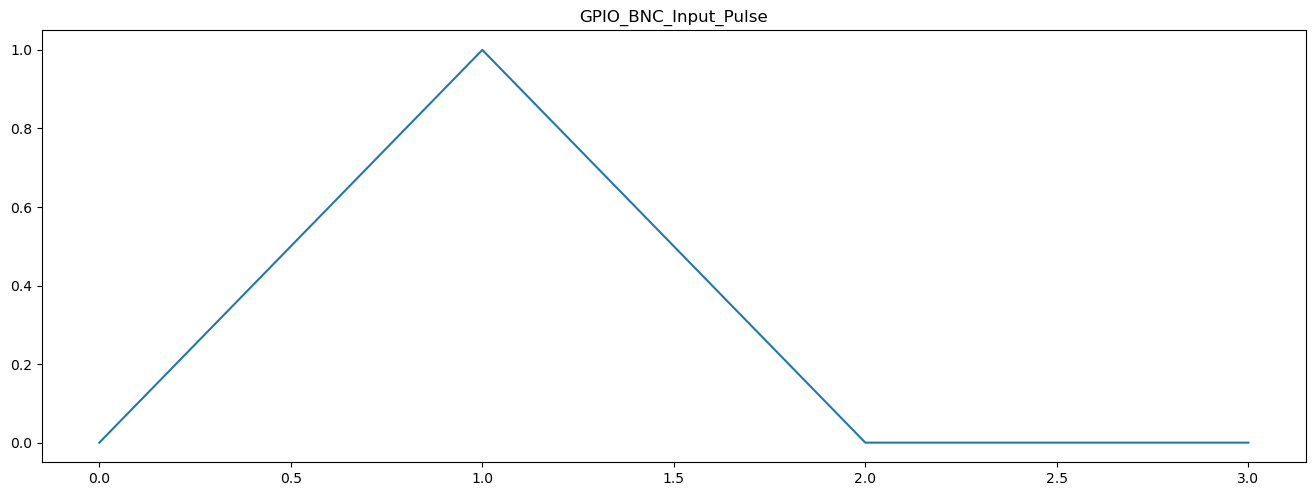

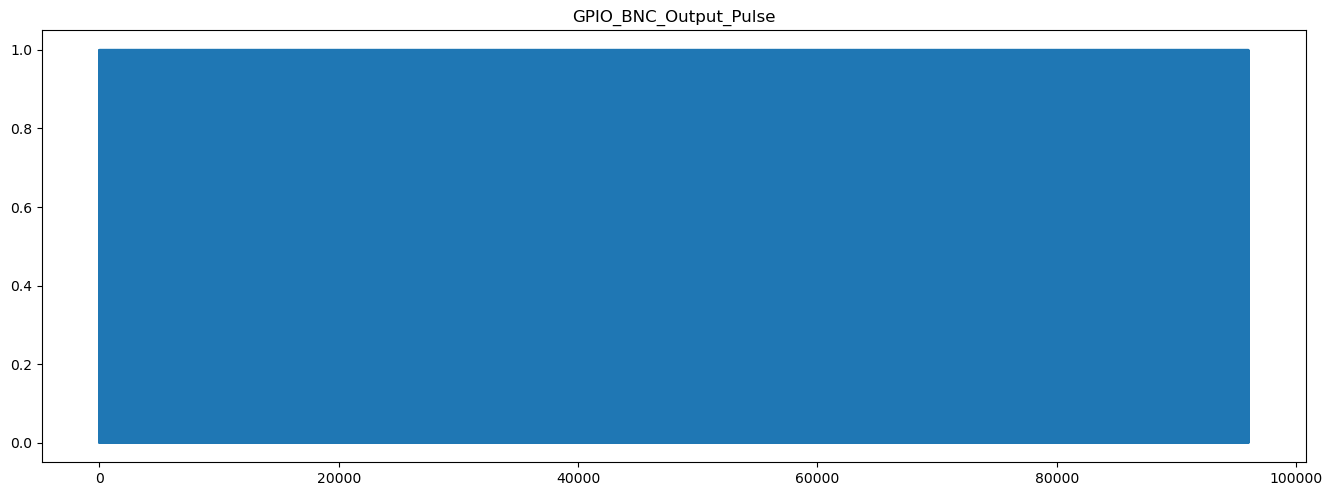

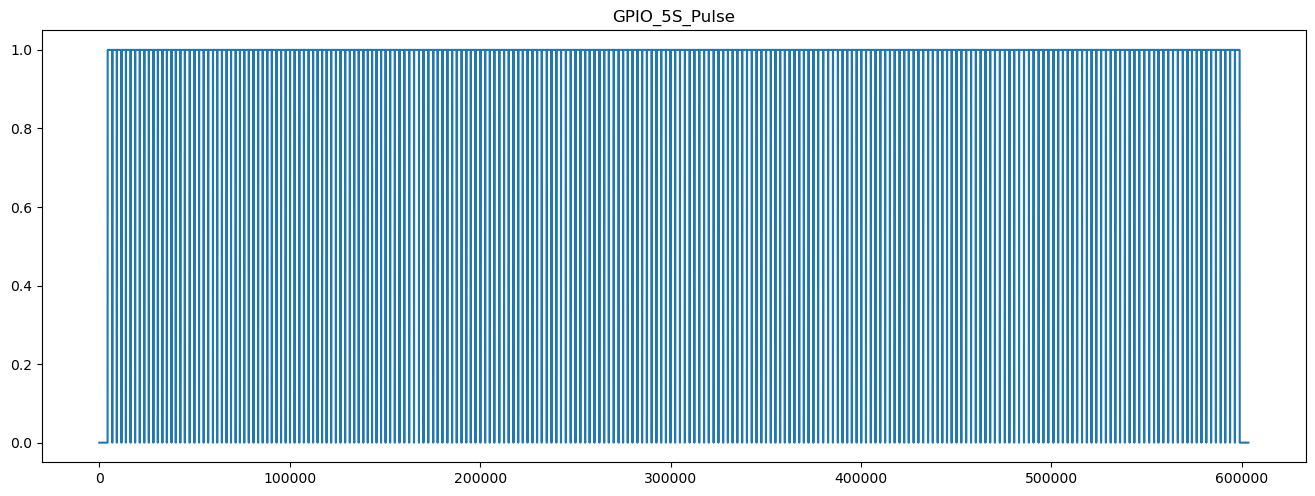

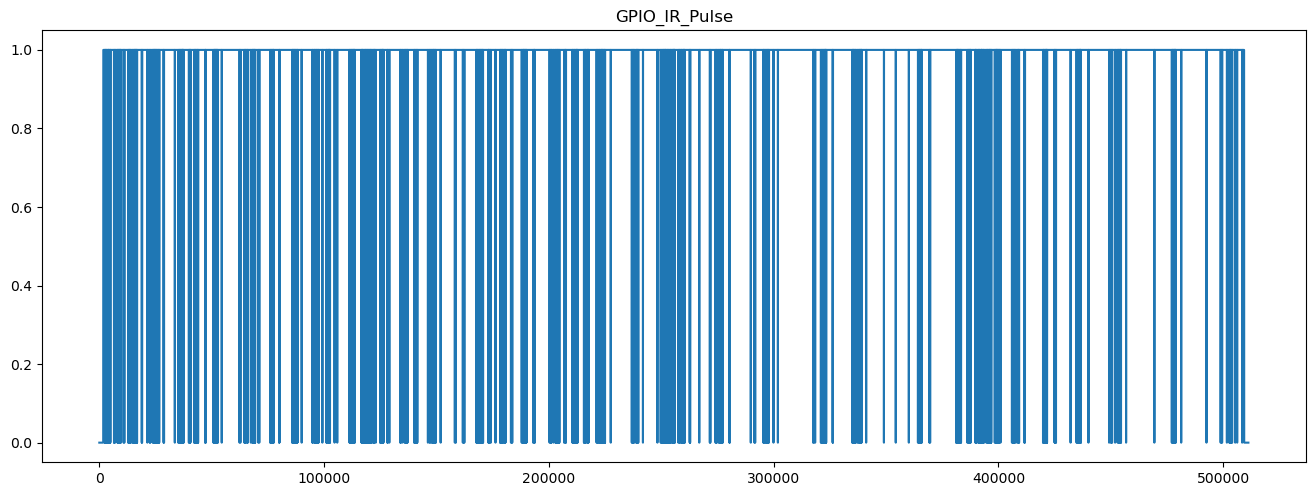

Index(['Time (s)', ' Channel Name', ' Value', 'value_binary',
       'value_binary_temp', 'Temp_Extract_Binary', 'Temp_Corrected_Binary',
       'Corrected_Binary'],
      dtype='object')
Index(['Time (s)', ' Channel Name', ' Value', 'value_binary'], dtype='object')


In [12]:

plt_raw.plot(gpio_BNC_Sync_Input_full['value_binary'])
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
#plt_raw.xlim(0, 20000)
#plt_raw.xlim(60000, 70000)
#plt_raw.xlim(60000, 60100)
plt_raw.title('GPIO_BNC_Input_Pulse', fontdict=None, loc='center')
plt_raw.show()

plt_raw.plot(gpio_BNC_Sync_Output_full['value_binary'])
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
#plt_raw.xlim(0, 20000)
#plt_raw.xlim(60000, 70000)
#plt_raw.xlim(60000, 60100)
plt_raw.title('GPIO_BNC_Output_Pulse', fontdict=None, loc='center')
plt_raw.show()


plt_raw.plot(gpio_1_full['Corrected_Binary'])
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
#plt_raw.xlim(0, 20000)
#plt_raw.xlim(60000, 100000)

plt_raw.title('GPIO_5S_Pulse', fontdict=None, loc='center')
plt_raw.show()

plt_raw.plot(gpio_2_full['value_binary'])
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
#plt_raw.xlim(0, 20000)
#plt_raw.xlim(60000, 100000)
plt_raw.title('GPIO_IR_Pulse', fontdict=None, loc='center')
plt_raw.show()

print(gpio_1_full.keys())
print(gpio_2_full.keys())

In [13]:


# # tempa = (gpio_BNC_Sync_Output_full['Time (s)'][2])*1000
# # tempb = (gpio_BNC_Sync_Output_full['Time (s)'][2+1])*1000

# # print(tempa)
# # print(tempb)
# # print('\n')



# # tempa = (gpio_BNC_Sync_Output_full['Time (s)'][2])*1000
# # num_a = int(str(tempa).split('.')[0])

# # print(num_a)
# # print(type(num_a))

# print(gpio_1_full['Time (s)'][i])

# tempa = int(gpio_1_full['Time (s)'][i])*1000
# tempb = int(gpio_1_full['Time (s)'][i+1])*1000


# print(tempa )
# print(tempb )


# tempa = (gpio_1_full['Time (s)'][i])*1000
# num_a = int(str(tempa).split('.')[0])
# print(num_a)

Last Time:  2430.999


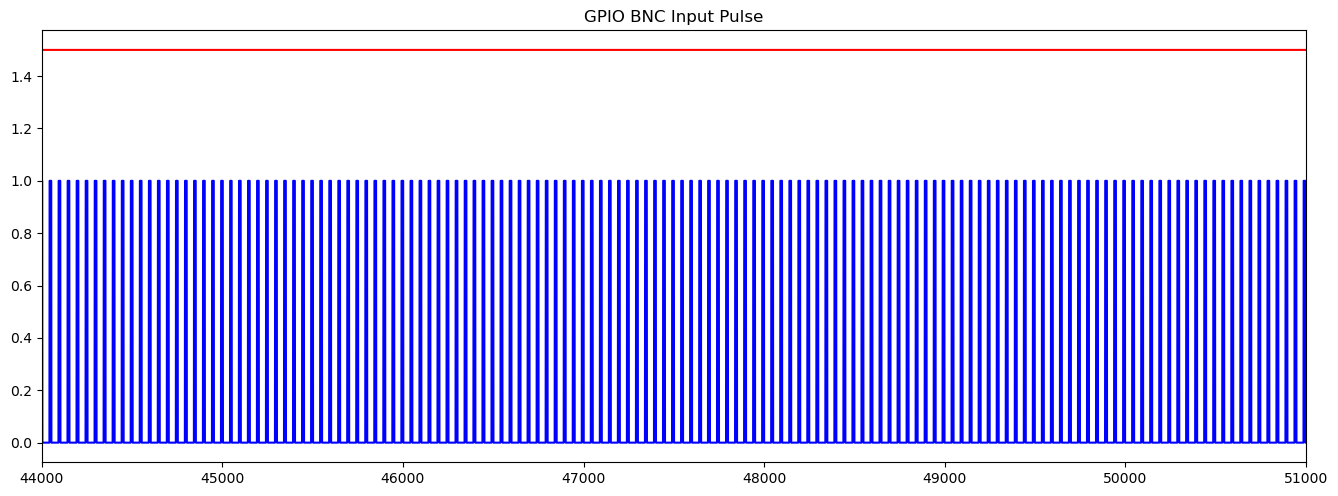

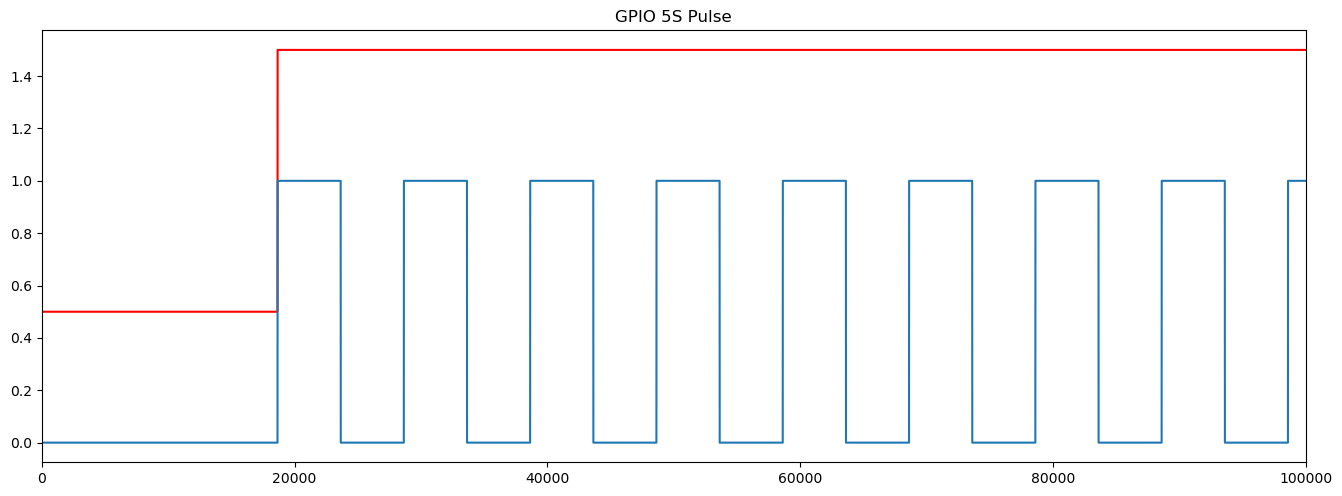

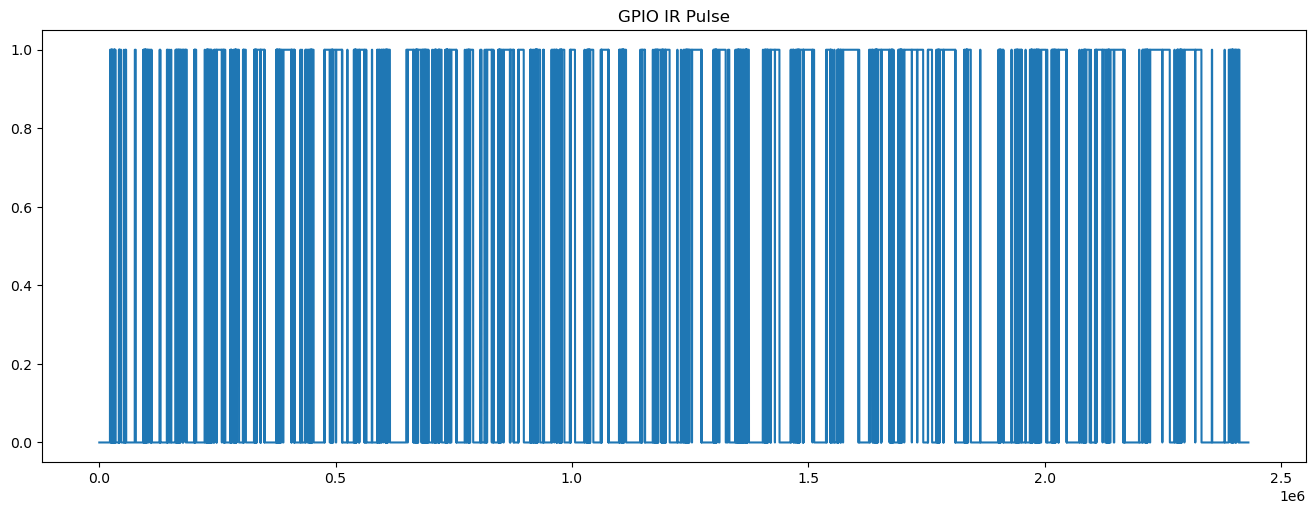

In [14]:
# # Ka added to Convert GPIO time into bins  
# print(gpio_1_full['Time (s)'])
# print(gpio_2_full['Time (s)'])

print('Last Time: ', gpio_1_full['Time (s)'][len(gpio_1_full)-1])
GPIO_Length = int(gpio_1_full['Time (s)'][len(gpio_1_full)-1] *1000)
# print(GPIO_Length)

# GPIO BNC_Sync_Input
signal_Length = GPIO_Length
x_axis = np.arange(0,signal_Length) 
GPIO_BNC_Sync_Input_Pulse = np.asarray( [0]*signal_Length)
for i in range(len(gpio_BNC_Sync_Input_full['Time (s)'])-1):
    # tempa = int(gpio_BNC_Sync_Input_full['Time (s)'][i])*1000   ## DOES NOT WORK,  int function drops numbers
    # tempb = int(gpio_BNC_Sync_Input_full['Time (s)'][i+1])*1000 ## DOES NOT WORK,  int function drops numbers
    
    tempa = (gpio_BNC_Sync_Input_full['Time (s)'][i])*1000
    num_a = int(str(tempa).split('.')[0])

    tempb = (gpio_BNC_Sync_Input_full['Time (s)'][i+1])*1000
    num_b = int(str(tempb).split('.')[0])
    
    GPIO_BNC_Sync_Input_Pulse[num_a:num_b] = gpio_BNC_Sync_Input_full['value_binary'][i]

# GPIO BNC_Sync_Output
signal_Length = GPIO_Length
x_axis = np.arange(0,signal_Length) 
GPIO_BNC_Sync_Output_Pulse = np.asarray( [0]*signal_Length)
for i in range(len(gpio_BNC_Sync_Output_full['Time (s)'])-1):
    # tempa = int(gpio_BNC_Sync_Output_full['Time (s)'][i])*1000   ## DOES NOT WORK,  int function drops numbers
    # tempb = int(gpio_BNC_Sync_Output_full['Time (s)'][i+1])*1000 ## DOES NOT WORK,  int function drops numbers
    
    tempa = (gpio_BNC_Sync_Output_full['Time (s)'][i])*1000
    num_a = int(str(tempa).split('.')[0])

    tempb = (gpio_BNC_Sync_Output_full['Time (s)'][i+1])*1000
    num_b = int(str(tempb).split('.')[0])
    
    GPIO_BNC_Sync_Output_Pulse[num_a:num_b] = gpio_BNC_Sync_Output_full['value_binary'][i]


# GPIO 5 Sec Pulse
signal_Length = GPIO_Length
x_axis = np.arange(0,signal_Length) 
GPIO_5S_Pulse = np.asarray( [0]*signal_Length)
for i in range(len(gpio_1_full['Time (s)'])-1):
    #tempa = int(gpio_1_full['Time (s)'][i])*1000  ## DOES NOT WORK,  int function drops numbers
    #tempb = int(gpio_1_full['Time (s)'][i+1])*1000  ## DOES NOT WORK,  int function drops numbers

    tempa = (gpio_1_full['Time (s)'][i])*1000
    num_a = int(str(tempa).split('.')[0])

    tempb = (gpio_1_full['Time (s)'][i+1])*1000
    num_b = int(str(tempb).split('.')[0])
    
    GPIO_5S_Pulse[num_a:num_b] = gpio_1_full['value_binary'][i]
    

# GPIO IR Pulse
signal_Length = GPIO_Length
x_axis = np.arange(0,signal_Length) 
GPIO_IR_Pulse = np.asarray( [0]*signal_Length)
for i in range(len(gpio_2_full['Time (s)'])-1):
    #tempa = int(gpio_2_full['Time (s)'][i])*1000  ## DOES NOT WORK,  int function drops numbers
    #tempb = int(gpio_2_full['Time (s)'][i+1])*1000  ## DOES NOT WORK,  int function drops numbers
    
    tempa = (gpio_2_full['Time (s)'][i])*1000
    num_a = int(str(tempa).split('.')[0])

    tempb = (gpio_2_full['Time (s)'][i+1])*1000
    num_b = int(str(tempb).split('.')[0])
    
    GPIO_IR_Pulse[num_a:num_b] = gpio_2_full['value_binary'][i]
    
# #######################
# ## DO NOT DELETE
# ## temperorly fix to the 5s pulse in GPIO,  Case by case basis 
# ##  add 5s pulses in the begining
# GPIO_5S_Pulse[15607:(15607+5000)]=1
############################


GPIO_df = pd.DataFrame()

temp = SignalTraces_pd.DataFrame(GPIO_BNC_Sync_Input_Pulse)
GPIO_BNC_Sync_Input_Pulse_panda = temp.squeeze()                #################      Reward_Window_Trace_panda
GPIO_df['GPIO_BNC_Sync_Input_Pulse_panda']  = GPIO_BNC_Sync_Input_Pulse_panda

temp = SignalTraces_pd.DataFrame(GPIO_BNC_Sync_Output_Pulse)
GPIO_BNC_Sync_Output_Pulse_panda = temp.squeeze()                #################      Reward_Window_Trace_panda
GPIO_df['GPIO_BNC_Sync_Output_Pulse_panda']  = GPIO_BNC_Sync_Output_Pulse_panda

temp = SignalTraces_pd.DataFrame(GPIO_5S_Pulse)
GPIO_5S_Pulse_panda = temp.squeeze()                #################      Reward_Window_Trace_panda
GPIO_df['GPIO_5S_Pulse_panda']  = GPIO_5S_Pulse_panda

temp = SignalTraces_pd.DataFrame(GPIO_IR_Pulse)
GPIO_IR_Pulse_panda = temp.squeeze()                #################      Reward_Window_Trace_panda
GPIO_df['GPIO_IR_Pulse_panda']  = GPIO_IR_Pulse_panda

plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
plt_raw.plot(GPIO_df['GPIO_BNC_Sync_Input_Pulse_panda']+0.5,'r')
plt_raw.plot(GPIO_df['GPIO_BNC_Sync_Output_Pulse_panda'],'b')
plt_raw.title('GPIO BNC Input Pulse')
#plt_raw.xlim(0, 60000)
#plt_raw.xlim(44000, 48000)
plt_raw.xlim(44000, 51000)
#plt_raw.xlim(48000, 51000)
#plt_raw.xlim(0, GPIO_Length)
#plt_raw.xlim(2350000, 2500000)
#plt_raw.xlim(2412000, 2414000)
plt_raw.show()

# plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
# plt_raw.plot(GPIO_df['GPIO_BNC_Sync_Output_Pulse_panda'])
# plt_raw.title('GPIO BNC Output Pulse')
# #plt_raw.xlim(0, GPIO_Length)
#plt_raw.xlim(2350000, 2500000)
# plt_raw.show()

plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
plt_raw.plot(GPIO_df['GPIO_BNC_Sync_Input_Pulse_panda']+0.5,'r')
plt_raw.plot(GPIO_df['GPIO_5S_Pulse_panda'])
# plt_raw.xlim(GPIO_Length/2, GPIO_Length)
plt_raw.title('GPIO 5S Pulse')
#plt_raw.xlim(0, GPIO_Length)
plt_raw.xlim(0, 100000)
#plt_raw.xlim(2350000, 2500000)
plt_raw.show()

plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
plt_raw.plot(GPIO_df['GPIO_IR_Pulse_panda'])
plt_raw.title('GPIO IR Pulse')
#plt_raw.xlim(0, GPIO_Length)
#plt_raw.xlim(0, 100000)
plt_raw.show()




1
   Time (s)        Channel Name   Value  value_binary
0     0.000   BNC Trigger Input     0.0             0
1    18.645   BNC Trigger Input     1.0             1
2  2416.831   BNC Trigger Input     0.0             0
3  2430.999   BNC Trigger Input     0.0             0


Index    Onset     Offset   Duration   Frames  Choosen
0    1.0  18645.0  2416831.0  2398186.0  47999.0      1.0
1    NaN      NaN  2430999.0        NaN      NaN      0.0
2    NaN      NaN        NaN        NaN      NaN      0.0
3    NaN      NaN        NaN        NaN      NaN      0.0
4    NaN      NaN        NaN        NaN      NaN      0.0

GPIO_Image_Begin:   18645.0
GPIO_Image_End:  2416831.0
GPIO_Corrected_FramesImaged:  47999
Ca_Imaging Cell Length:  47999


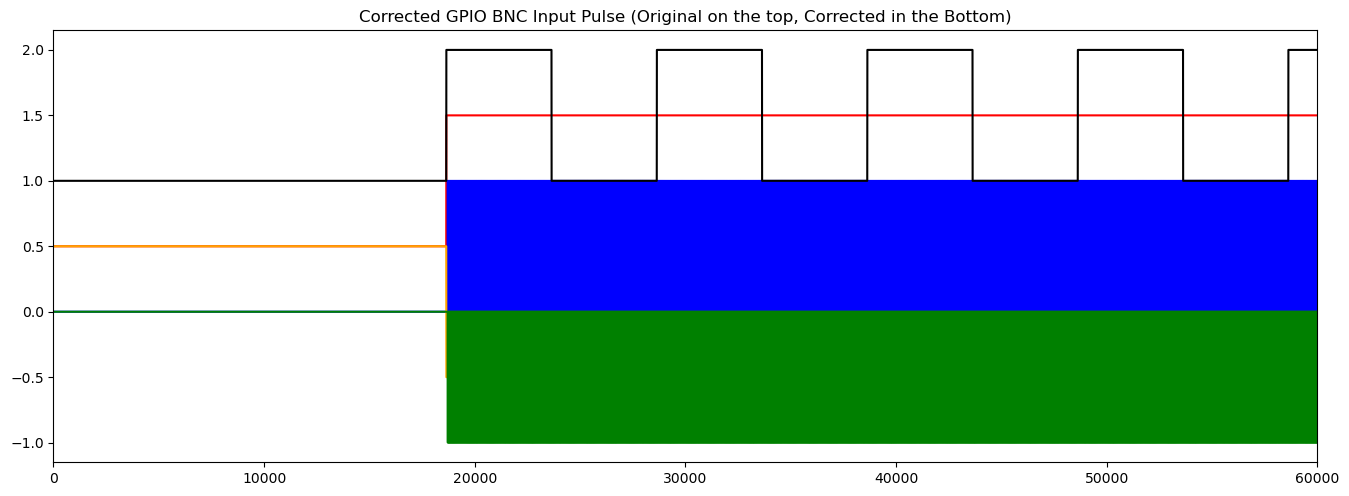

In [15]:


# Calculate durations for GPIO trigger in 
# extract data from gpio-1 and gpio-2 channels 
# gpio_BNC_Sync_Input_full = gpio[gpio[" Channel Name"]== ' BNC Trigger Input']
# gpio_BNC_Sync_Output_full = gpio[gpio[" Channel Name"]== ' BNC Sync Output']


GPIO_Summary = defaultdict(list)
GPIO_Summary_Header = ['Index','Onset','Offset', 'Duration','Frames', 'Choosen']
for i in range(len(GPIO_Summary_Header)):
    GPIO_Summary[GPIO_Summary_Header[i]].append(None)   


for i in range(1,len(gpio_BNC_Sync_Input_full['Time (s)'])):  # satrt with 1 instead of zero, bc first num is 0 , assuming the trigger-in led is off at the start of the session 
    if(gpio_BNC_Sync_Input_full['value_binary'][i]== 1):
        GPIO_Summary['Onset'].append(gpio_BNC_Sync_Input_full['Time (s)'][i]*1000)
        GPIO_Summary['Index'].append(i)
    if(gpio_BNC_Sync_Input_full['value_binary'][i]== 0):
        GPIO_Summary['Offset'].append(gpio_BNC_Sync_Input_full['Time (s)'][i]*1000)

# 1 because first 1 is zero 
for i in range(1,len(GPIO_Summary['Onset'])):

    
    if(GPIO_Summary['Onset'][i]< GPIO_Summary['Offset'][i]):
        GPIO_Summary['Duration'].append(GPIO_Summary['Offset'][i]-GPIO_Summary['Onset'][i])

                
        tempa = GPIO_Summary['Onset'][i]
        num_a = int(str(tempa).split('.')[0])
    
        tempb = GPIO_Summary['Offset'][i]
        num_b = int(str(tempb).split('.')[0])
        temp_GPIO= GPIO_BNC_Sync_Output_Pulse[num_a:num_b]
        
        #count number of Ca imaging frames taken (by counting GPIO_BNC_output )
        GPIO_BNC_Dur = []
        GPIO_BNC_Position = []
        Current_Dur = 1  #  The count starts at 1 because the count below starts with index 1
        GPIO_BNC_count= 0    
        for ii in range(len(temp_GPIO)):
            if((temp_GPIO[ii]) > (temp_GPIO[ii-1])):  # only detects "onset" 
                GPIO_BNC_count = GPIO_BNC_count+1
                GPIO_BNC_Dur.append(Current_Dur)
                GPIO_BNC_Position.append(i)
                Current_Dur = 1
            else:
                Current_Dur = Current_Dur +1
        #print('Total Frame (GPIO):  ',GPIO_BNC_count )
        GPIO_Summary['Frames'].append(GPIO_BNC_count)


#Find the interval with the largest frame number (assuming the longest chunk is the "right imaing duration")
a = (max(GPIO_Summary['Frames'][1:len(GPIO_Summary['Frames'])]))
aa = GPIO_Summary['Frames']
Max_index = aa.index(a)
print(Max_index)
for i in range(1,len(GPIO_Summary)):
    if(i == Max_index):
        GPIO_Summary['Choosen'].append(1)
    else:
        GPIO_Summary['Choosen'].append(0)

GPIO_Image_Begin = GPIO_Summary['Onset'][Max_index]
GPIO_Image_End = GPIO_Summary['Offset'][Max_index]
GPIO_Corrected_FramesImaged = GPIO_Summary['Frames'][Max_index]
###########################################################################    
#  Remove 'None' place holder for Event_Count_TimeStamp, which is the first value
for i in range(len(GPIO_Summary_Header)):
    del GPIO_Summary[GPIO_Summary_Header[i]][0]

GPIO_Summary_panda = pd.DataFrame.from_dict(GPIO_Summary, orient='index').T

print(gpio_BNC_Sync_Input_full)
display(GPIO_Summary_panda)   
print('GPIO_Image_Begin:  ', GPIO_Image_Begin)
print('GPIO_Image_End: ', GPIO_Image_End)
print('GPIO_Corrected_FramesImaged: ', GPIO_Corrected_FramesImaged)
print('Ca_Imaging Cell Length: ', len(df_cal))

# Corrected_GPIO BNC_Sync_Input 
Corrected_GPIO_BNC_Sync_Input_Pulse = GPIO_BNC_Sync_Input_Pulse.copy()
Corrected_GPIO_BNC_Sync_Input_Pulse[0:int(GPIO_Image_Begin)] =0
Corrected_GPIO_BNC_Sync_Input_Pulse[int(GPIO_Image_End): int(GPIO_Length)] =0

# Corrected_GPIO BNC_Sync_Output 
Corrected_GPIO_BNC_Sync_Output_Pulse = GPIO_BNC_Sync_Output_Pulse.copy()
Corrected_GPIO_BNC_Sync_Output_Pulse[0:int(GPIO_Image_Begin)] =0
Corrected_GPIO_BNC_Sync_Output_Pulse[int(GPIO_Image_End): int(GPIO_Length)] =0

temp = SignalTraces_pd.DataFrame(Corrected_GPIO_BNC_Sync_Input_Pulse)
Corrected_GPIO_BNC_Sync_Input_Pulse_panda = temp.squeeze()                #################      Reward_Window_Trace_panda
GPIO_df['Corrected_GPIO_BNC_Sync_Input_Pulse_panda']  = Corrected_GPIO_BNC_Sync_Input_Pulse_panda

temp = SignalTraces_pd.DataFrame(Corrected_GPIO_BNC_Sync_Output_Pulse)
Corrected_GPIO_BNC_Sync_Output_Pulse_panda = temp.squeeze()                #################      Reward_Window_Trace_panda
GPIO_df['Corrected_GPIO_BNC_Sync_Output_Pulse_panda']  = Corrected_GPIO_BNC_Sync_Output_Pulse_panda


plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
plt_raw.plot(GPIO_df['GPIO_BNC_Sync_Input_Pulse_panda']+0.5,'r')
plt_raw.plot(GPIO_df['GPIO_BNC_Sync_Output_Pulse_panda'],'b')
plt_raw.plot(GPIO_df['GPIO_5S_Pulse_panda']+1,'k')
plt_raw.plot(GPIO_df['Corrected_GPIO_BNC_Sync_Input_Pulse_panda']*(-1)+0.5,'orange')
plt_raw.plot(GPIO_df['Corrected_GPIO_BNC_Sync_Output_Pulse_panda']*(-1),'g')

plt_raw.title('Corrected GPIO BNC Input Pulse (Original on the top, Corrected in the Bottom)')
plt_raw.xlim(0, 60000)
#plt_raw.xlim(44000, 48000)
#plt_raw.xlim(44000, 51000)
#plt_raw.xlim(48000, 51000)
#plt_raw.xlim(0, GPIO_Length)
#plt_raw.xlim(2350000, 2500000)
#plt_raw.xlim(2412000, 2414000)
plt_raw.show()

########################## TroubleShoot ######################
############################## Manual Correction #################
#### Only use if necessary to match the num of frames(files did not break down properly duing BNC trigger input, so length is wrong) ###########
# GPIO_Image_Begin = 27117
# GPIO_Image_End = 2426758
# GPIO_Corrected_FramesImaged = 42033+1861+2555+1576

In [16]:
## Arduino Event Codes
#  Ka Reorganized 
event_code_dict = {
                   '5521' :'Trial_Initi_Wind_Start', '5520' :'Trial_Initi_Wind_End', 
                   '4521' :'Trial_Start', '4520' :'Trial_End',
                   '3521' :'Reward_Win_Start', '3520' :'Reward_Win_End',
                   '2521' :'ITI_Start', '2520' :'ITI_End',
                   '0000' : "Trial_Type",
                   '0001' : "Session_Start",
                   '0002' : "Session_End",
                   
                   '0114' :'File_END',
                   
                   '7171': 'L_LED_ON', '7170': 'L_LED_OFF',
                   '8171': 'M_LED_ON', '8170': 'M_LED_OFF',
                   '9171': 'R_LED_ON', '9170': 'R_LED_OFF', 
                   
                   '7271': 'L_Sol_ON', '7270': 'L_Sol_OFF',
                   '8271': 'M_Sol_ON', '8270': 'M_Sol_OFF',
                   '9271': 'R_Sol_ON', '9270': 'R_Sol_OFF',
                   
                   
                   
                   
                   '7071': 'L_Poke_IN', '7070': 'L_Poke_OUT',
                   '8071': 'M_Poke_IN', '8070': 'M_Poke_OUT',
                   '9071': 'R_Poke_IN', '9070': 'R_Poke_OUT', 
                   
                   '5530' :'Poke_In_Delayed_Window_Punishmnet',
                   '5531' :'No_Poke_In_Delayed_Window_OK',


                   '7540' :'Left Omission', '8540' :'Middle Omission', '9540' :'Right Omission',

                   
                   
                   '7160': 'L_led_Invalid_OFF',
                   '8160': 'M_led_Invalid_OFF',
                   '9160': 'R_led_Invalid_OFF',

                   # '7519': 'L_iw',  '7529': 'L_tw',  '7539': 'L_vw', '7559': 'L_delay_w',
                   # '8519': 'M_iw',  '8529': 'M_tw',  '8539': 'M_vw', '8559': 'M_delay_w',
                   # '9519': 'R_iw',  '9529': 'R_tw',  '9539': 'R_vw', '9559': 'R_delay_w',

                   }

In [17]:
#ard_beg_line = 15 # for P5_5
ard_beg_line = 13 # for Random_Ratio_10 
ard_end_line = 4

col_names = ['event_code', 'timestamp', 'counter'] # For TIR (Groups 1,2)
#Load the data file
temp_behav_data = pd.read_csv((ard_file), sep=":", header=None, names=col_names)

#Extract relevant information from the behavioral files
with open(ard_file, "r") as fileref:
        filelines = fileref.readlines()
num_lines = len(filelines)

# figure out the start and end of the event-code list

#check that the line outputs eventcode: timestamp
print('previous line (1-beginning line; should be Delay_Window:1)', filelines[ard_beg_line-1])
print('correct beginning line; should be an event code: timestamp',filelines[ard_beg_line])

print('correct end line: (should be empty):', filelines[-1*ard_end_line])
print('1- end line; should be an event code:timestamp :', filelines[(-1*ard_end_line)-1])

Selected_Data = temp_behav_data[(ard_beg_line-2):(len(filelines)-ard_end_line)-2]
Selected_Data = Selected_Data.reset_index(drop=True)
print(Selected_Data)

Data_Len = int(Selected_Data['timestamp'][len(Selected_Data)-1])
print(Data_Len)

previous line (1-beginning line; should be Delay_Window:1) Paradigm:G5_P4_RandomRatio_10_v3

correct beginning line; should be an event code: timestamp 0001:38761

correct end line: (should be empty): 

1- end line; should be an event code:timestamp : 0114:2454829

     event_code timestamp  counter
0          0001     38761      NaN
1          7070     38761      NaN
2          8070     38761      NaN
3          9070     38761      NaN
4          5521     38762      NaN
...         ...       ...      ...
2304       8070   2431736      NaN
2305       7071   2432224      NaN
2306       7070   2433939      NaN
2307       0002   2438761      NaN
2308       0114   2454829      NaN

[2309 rows x 3 columns]
2454829


In [18]:
  

# add events if not in code dictionary

Event_Count = {}
Event_Count_TimeStamps = defaultdict(list)

for i in range (len(event_code_dict)):
    Event_Count[ list(event_code_dict.values())[i] + '-' + list(event_code_dict.keys())[i]]= 0
    #Event_Count[list(event_code_dict.keys())[i] + '-' + list(event_code_dict.values())[i]]= 0

#  detect if timestamp exist in code dictionary, then update event count dictionary
for i in range(len(Selected_Data)):
    match = 0   
    for ii in range (len(event_code_dict)):
        if(Selected_Data['event_code'][i] == list(event_code_dict.keys())[ii]):
            match  = 1
    if(match == 0):
        #print(Selected_Data['event_code'][i])
        Event_Count['Undefined-' + Selected_Data['event_code'][i]] = 0
        #Event_Count[Selected_Data['event_code'][i] + '-Undefined'] = 0

# initalized Event_Count_TimeStamps so it's the same order as Event_Count,  'None' is addeded as a place holder, will be remove in next few lines
for i in range(len(Event_Count)):
    Event_Count_TimeStamps[list(Event_Count.keys())[i]].append(None) 

#  Count number of Events , and sorting timestamps into Event_Count_Timestamps
for i in range(len(Selected_Data)):
    for ii in range (len(Event_Count)):
        if(Selected_Data['event_code'][i] == list(Event_Count.keys())[ii].split("-")[1]):
            Event_Count[list(Event_Count.keys())[ii]] += 1  # add one  to count num of events
            Event_Count_TimeStamps[list(Event_Count.keys())[ii]].append(Selected_Data['timestamp'][i]) 
            
#  Remove 'None' place holder for Event_Count_TimeStamp, whihc is the first value
for i in range(len(Event_Count)):
    del Event_Count_TimeStamps[list(Event_Count_TimeStamps.keys())[i]][0]
    #del Event_Count_TimeStamps[list(Event_Count.keys())[i]][0]             #### delete me

Total_Num_Event = sum(Event_Count.values())

# print(Total_Num_Event)
# print(Event_Count.values())    

Original_Event_Count = {}  
Original_Event_Count_TimeStamps = defaultdict(list)
Original_Event_Count = Event_Count.copy()
Original_Event_Count_TimeStamps= Event_Count_TimeStamps.copy()

#print((Event_Count))

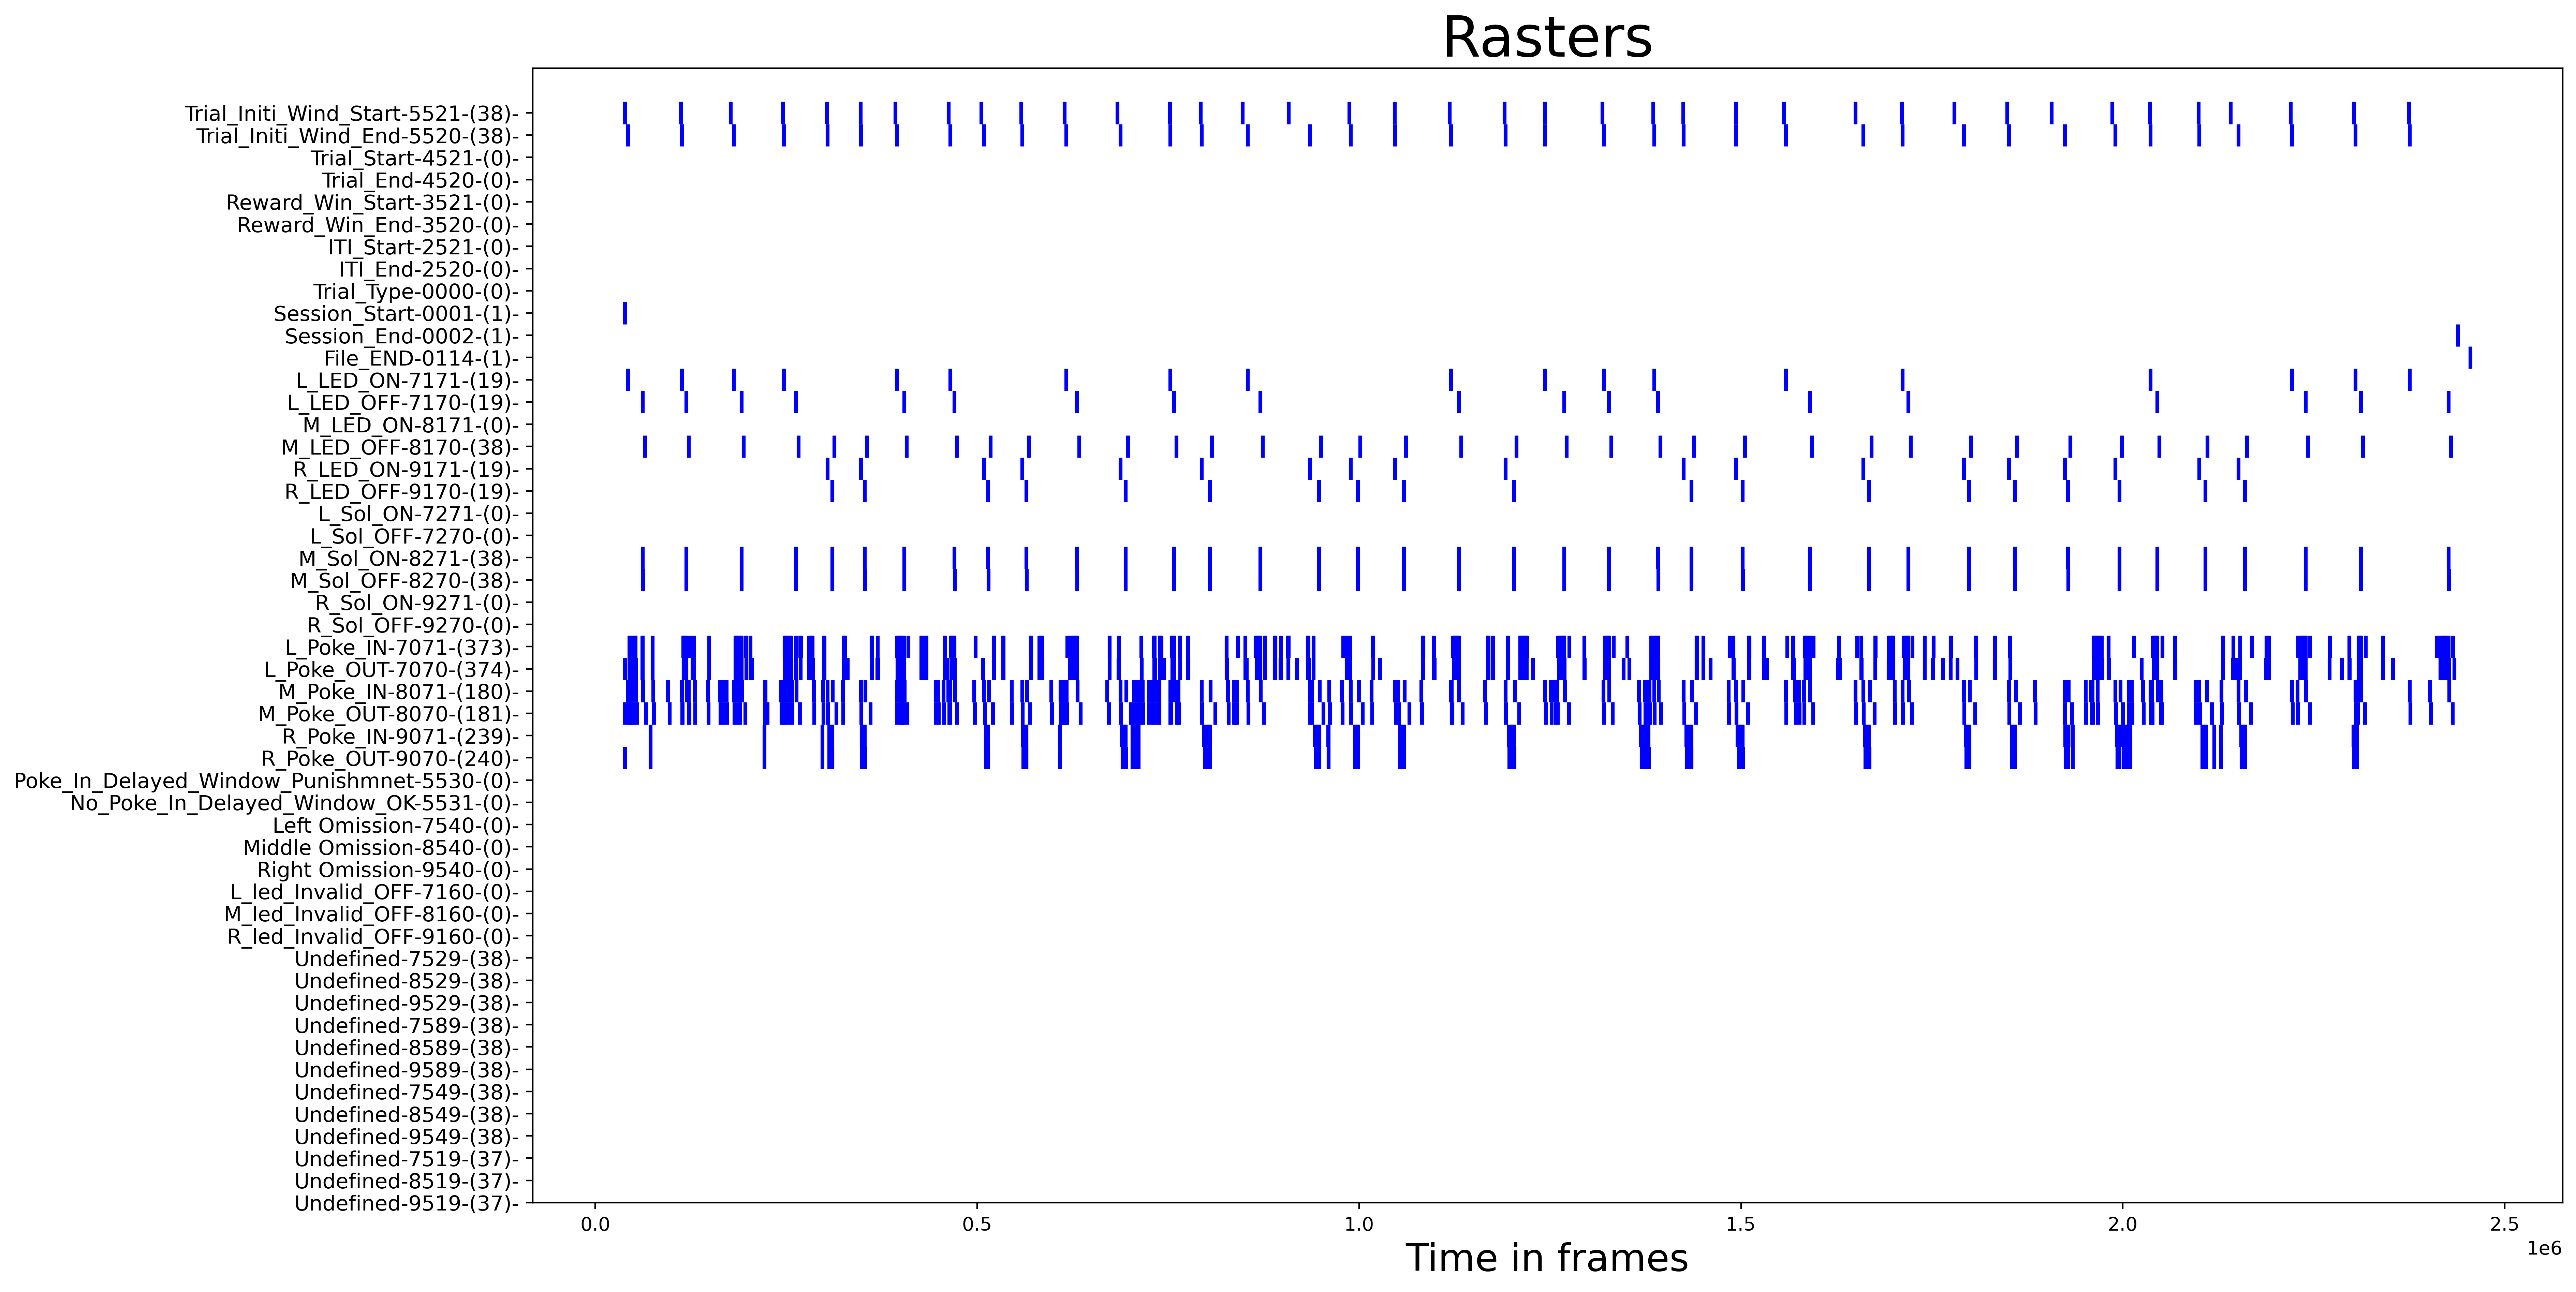

In [19]:

#################  Plot raster for Events
# calling the label
#list(Event_Count_TimeStamps.keys())[3]

count=0

# calling the timestamps within label 
#Event_Count_TimeStamps[list(Event_Count_TimeStamps.keys())[3]][1]

# same ylabel as previous figure on timestamp count 
ylabel = []
for i in range(len(Event_Count)):
    ylabel.append(str(list(Event_Count.keys())[i]) + '-(' + str(list(Event_Count.values())[i]) + ')-')

#xlabel = np.arange(int(max(Selected_Data['timestamp']))+ 2)   #  use last timestamp from SelectedData
#xlabel = np.arange(int(Selected_Data['timestamp'][len(Selected_Data)-1])+ 2)   #  use last timestamp from SelectedData
#xlabel = np.arange(0, len(df)+10)
xlabel =np.arange(0, Data_Len +10)

fig, b = plt.subplots(figsize =(19.2, 10.8), dpi = 400.0)

#  turn timestamp into traces 
for i in range(len(Event_Count_TimeStamps)):                
    for ii in range(len(Event_Count_TimeStamps[list(Event_Count_TimeStamps.keys())[i]])):
        #if(str(Event_Count_TimeStamps[list(Event_Count_TimeStamps.keys())[i]][ii]).isnumeric()):  #  do not plot 'NAN', only plot if it is a number
        if((str(Event_Count_TimeStamps[list(Event_Count_TimeStamps.keys())[i]][ii]).replace('[', '')).replace(']', '').isnumeric()):  #  do not plot 'NAN', only plot if it is a number
            #t_stamp = (str(Event_Count_TimeStamps[list(Event_Count_TimeStamps.keys())[i]][ii]).replace('[', '')).replace(']', '')
            t_stamp = int((str(Event_Count_TimeStamps[list(Event_Count_TimeStamps.keys())[i]][ii]).replace('[', '')).replace(']', ''))
            b.vlines(x= t_stamp, ymin=(i-1)+0.5, ymax=(i)+0.5, colors='blue', lw=2, label='vline_single - partial height')
            count= count+1

b.invert_yaxis()  # labels read top-to-bottom    
b.set_yticks(np.arange(len((Event_Count.keys()))))
b.set_yticklabels(ylabel, size = 11)
#b.set_xticks(xlabel)
#b.set_xticklabels(xlabel, size = 20)
b.set_xlabel('Time in frames', size = 20)
b.set_title('Rasters', size = 30)
#filename = 'Rasters-COM-' + ''.join(file_info['Box Number']).replace(' ', '') + '-' + ''.join(file_info['Paradigm']).replace(' ', '')  + \
#'-'+ ((Timelist[currentblock]).replace(':', '_')).replace('/', '_') + '.png'
#plt.xlim([0, len(df)+10])
plt.show()

#savefilename = os.path.join(Save_Path, filename)
#fig.savefig(savefilename)
Event_Count = Original_Event_Count.copy()
Event_Count_TimeStamps = Original_Event_Count_TimeStamps.copy()

Num of Pulse= 481


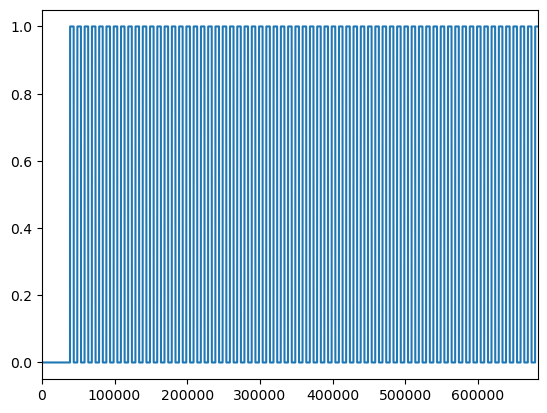

In [20]:
# Generate 5 seconds pulse for arduino data, starts with cue onset
# each pulse is 1001 bins long

############
# pad zeros up until first time stamp comes up

Arduino_5S_Pulse = []

#First Timestamp 
First_Stamp = int(Selected_Data['timestamp'][0])
for i in range(0, First_Stamp):
    Arduino_5S_Pulse.append([0])

Last_Stamp = int(Selected_Data['timestamp'][len(Selected_Data)-2])

#################################################
# For Troubleshoot. 
#  if the Arduino stops collecting data prematurely , use the 002 timestamp from a diff session (but SAME arduino to estimate whole session duraiton for 40 min session)
# Adjust 'Last_Stamp' until 'Arduino_5S_Pulse_COUNT' is at 480.  The EXACT number does not matter,  extra bins gets cropped.  Assuming that the GPIO also has 480 pulse,  the two will align.   
# This is because the first step of alignment is aligning by the 5s pulse.  
#Last_Stamp =2445000  
#################################################
count = 0

Arduino_5S_Pulse_COUNT = 1  # Starts with 1 bc of the first 5s pulse onset 
pulse_value = 1

for i in range(First_Stamp, Last_Stamp):
    Arduino_5S_Pulse.append([pulse_value])
    count = count+1
    
    if(count == (5*1000)):
        #print(count)
        #pulse_value = pulse_value *(-1)
        if(pulse_value == 1):
            pulse_value =0
        else:
            pulse_value =1

        
        count = 0
        Arduino_5S_Pulse_COUNT = Arduino_5S_Pulse_COUNT+1

for i in range(Last_Stamp, Data_Len):
    Arduino_5S_Pulse.append([0])


plt_raw.plot(Arduino_5S_Pulse)
#plt_raw.xlim(2510000,2510802)
plt_raw.xlim(0,682550)
print('Num of Pulse=',Arduino_5S_Pulse_COUNT )

# print(Last_Stamp)
# print(Data_Len)
# print(len(Arduino_5S_Pulse))

In [21]:
print(Event_Count)

{'Trial_Initi_Wind_Start-5521': 38, 'Trial_Initi_Wind_End-5520': 38, 'Trial_Start-4521': 0, 'Trial_End-4520': 0, 'Reward_Win_Start-3521': 0, 'Reward_Win_End-3520': 0, 'ITI_Start-2521': 0, 'ITI_End-2520': 0, 'Trial_Type-0000': 0, 'Session_Start-0001': 1, 'Session_End-0002': 1, 'File_END-0114': 1, 'L_LED_ON-7171': 19, 'L_LED_OFF-7170': 19, 'M_LED_ON-8171': 0, 'M_LED_OFF-8170': 38, 'R_LED_ON-9171': 19, 'R_LED_OFF-9170': 19, 'L_Sol_ON-7271': 0, 'L_Sol_OFF-7270': 0, 'M_Sol_ON-8271': 38, 'M_Sol_OFF-8270': 38, 'R_Sol_ON-9271': 0, 'R_Sol_OFF-9270': 0, 'L_Poke_IN-7071': 373, 'L_Poke_OUT-7070': 374, 'M_Poke_IN-8071': 180, 'M_Poke_OUT-8070': 181, 'R_Poke_IN-9071': 239, 'R_Poke_OUT-9070': 240, 'Poke_In_Delayed_Window_Punishmnet-5530': 0, 'No_Poke_In_Delayed_Window_OK-5531': 0, 'Left Omission-7540': 0, 'Middle Omission-8540': 0, 'Right Omission-9540': 0, 'L_led_Invalid_OFF-7160': 0, 'M_led_Invalid_OFF-8160': 0, 'R_led_Invalid_OFF-9160': 0, 'Undefined-7529': 38, 'Undefined-8529': 38, 'Undefined-9529

In [22]:
# Len offset is unfortunately separated into "offset", "Invalid_OFF" and "Omission"  
# so we need to recombined them into one offset variable


Left_Led_Offset = []
for i in range(Event_Count['L_LED_OFF-7170']):
    Left_Led_Offset.append(int(Event_Count_TimeStamps['L_LED_OFF-7170'][i]))
for i in range(Event_Count['Left Omission-7540']):
    Left_Led_Offset.append(int(Event_Count_TimeStamps['Left Omission-7540'][i]))
for i in range(Event_Count['L_led_Invalid_OFF-7160']):
    Left_Led_Offset.append(int(Event_Count_TimeStamps['L_led_Invalid_OFF-7160'][i]))
Left_Led_Offset.sort()

Right_Led_Offset = []
for i in range(Event_Count['R_LED_OFF-9170']):
    Right_Led_Offset.append(int(Event_Count_TimeStamps['R_LED_OFF-9170'][i]))
for i in range(Event_Count['Right Omission-9540']):
    Right_Led_Offset.append(int(Event_Count_TimeStamps['Right Omission-9540'][i]))
for i in range(Event_Count['R_led_Invalid_OFF-9160']):
    Right_Led_Offset.append(int(Event_Count_TimeStamps['R_led_Invalid_OFF-9160'][i]))
Right_Led_Offset.sort()


All_Led_Onset = []
for i in range(Event_Count['L_LED_ON-7171']):
    All_Led_Onset.append(int(Event_Count_TimeStamps['L_LED_ON-7171'][i]))
for i in range(Event_Count['R_LED_ON-9171']):
    All_Led_Onset.append(int(Event_Count_TimeStamps['R_LED_ON-9171'][i]))
All_Led_Onset.sort()
Event_Count_TimeStamps['All_Led_Onset'] = All_Led_Onset
Event_Count['All_Led_Onset']= len(Event_Count_TimeStamps['L_LED_ON-7171']) + len(Event_Count_TimeStamps['R_LED_ON-9171'])


Incorrect_All = []
for i in range(Event_Count['L_led_Invalid_OFF-7160']):
    Incorrect_All.append(int(Event_Count_TimeStamps['L_led_Invalid_OFF-7160'][i]))
for i in range(Event_Count['R_led_Invalid_OFF-9160']):
    Incorrect_All.append(int(Event_Count_TimeStamps['R_led_Invalid_OFF-9160'][i]))
Incorrect_All.sort()

Omission_All= []
for i in range(Event_Count['Left Omission-7540']):
    Omission_All.append(int(Event_Count_TimeStamps['Left Omission-7540'][i]))
for i in range(Event_Count['Right Omission-9540']):
    Omission_All.append(int(Event_Count_TimeStamps['Right Omission-9540'][i]))
Incorrect_All.sort()



# append aggregrated timestamps
Event_Count_TimeStamps['All_Left_Led_Offset'] = Left_Led_Offset
Event_Count_TimeStamps['All_Right_Led_Offset'] = Right_Led_Offset

Event_Count_TimeStamps['Incorrect_All'] = Incorrect_All
Event_Count['Incorrect_All']= len(Event_Count_TimeStamps['Incorrect_All'])

Event_Count_TimeStamps['Omission_All'] = Omission_All
Event_Count['Omission_All']= len(Event_Count_TimeStamps['Omission_All'])


In [23]:
# print(Event_Count_TimeStamps['L_LED_ON-7171'])
# print('\n')
# print(Event_Count_TimeStamps['All_Left_Led_Offset'])

# print('\nRight')

# print(Event_Count_TimeStamps['R_LED_ON-9171'])
# print('\n')
# print(Event_Count_TimeStamps['All_Right_Led_Offset'])

# print(Event_Count_TimeStamps['Incorrect_All'])
# print('\n')
# print(Event_Count_TimeStamps['Omission_All'])

#Event_Count['Incorrect_All']= len(Event_Count_TimeStamps['Incorrect_All'])
# print(Event_Count['Incorrect_All'])

# print(Event_Count_TimeStamps['Trial_Initi_Wind_End-5520'])
# print('\n')
# print(Event_Count_TimeStamps['L_LED_ON-7171'])
# print('\n')
# print(Event_Count_TimeStamps['All_Left_Led_Offset'])
# print((2479547-2478815)/1000)
# print(2478814/1000/60)



In [24]:

print('\n Left Poke')
print(Event_Count['L_Poke_IN-7071'])
print(Event_Count['L_Poke_OUT-7070'])

print('\n Middle Poke')
print(Event_Count['M_Poke_IN-8071'])
print(Event_Count['M_Poke_OUT-8070'])

print('\n Right Poke')
print(Event_Count['R_Poke_IN-9071'])
print(Event_Count['R_Poke_OUT-9070'])


print('\n')
print(Event_Count_TimeStamps['L_Poke_IN-7071'][0:10])
print(Event_Count_TimeStamps['L_Poke_OUT-7070'][0:10])

print('\n')
print(Event_Count_TimeStamps['M_Poke_IN-8071'][0:10])
print(Event_Count_TimeStamps['M_Poke_OUT-8070'][0:10])

print('\n')
print(Event_Count_TimeStamps['R_Poke_IN-9071'][0:10])
print(Event_Count_TimeStamps['R_Poke_OUT-9070'][0:10])


 Left Poke
373
374

 Middle Poke
180
181

 Right Poke
239
240


['44689', '44889', '48314', '51200', '51792', '51887', '52292', '52615', '61546', '61837']
['38761', '44759', '45002', '48478', '51614', '51849', '52143', '52459', '52830', '61713']


['42618', '42697', '45754', '46177', '46541', '46575', '46972', '49080', '53424', '62555']
['38761', '42642', '44169', '46101', '46366', '46552', '46643', '47631', '50364', '54325']


['72215', '221210', '297177', '306278', '307151', '307496', '307838', '308258', '308504', '309517']
['38761', '72266', '221295', '297331', '306322', '307442', '307683', '307932', '308336', '308588']


In [25]:
#  Create Traces for Trial_Window_Available_Trace, Left_IR_Trace,  Middle_IR_Trace,  Right_IR_Trace,  ALL_IR_Trace 



#Trial_Window_Available_Trace
Reference_Begin = 'Trial_Initi_Wind_Start-5521'
Reference_End = 'Trial_Initi_Wind_End-5520'
signal_Length = Data_Len
x_axis = np.arange(0,signal_Length) 
Trial_Window_Available_Trace = np.asarray( [0]*signal_Length)

#Check to make sure # of begin and end timestamps are same
if(Event_Count[Reference_Begin] > Event_Count[Reference_End]):
    Event_Count[Reference_Begin] = Event_Count[Reference_Begin] -1    #remove excess timestamp, happens when trial gets interrupted by session end 
for i in range(Event_Count[Reference_Begin]):
    tempa = int(Event_Count_TimeStamps[Reference_Begin][i])
    tempb = int(Event_Count_TimeStamps[Reference_End][i])
    Trial_Window_Available_Trace[tempa:tempb] = [1]
    
#Left_IR_Trace   
Reference_Begin = 'L_Poke_IN-7071'
Reference_End = 'L_Poke_OUT-7070'
signal_Length = Data_Len
x_axis = np.arange(0,signal_Length) 
Left_IR_Trace = np.asarray( [0]*signal_Length)
for i in range(Event_Count[Reference_Begin]-1):
    tempa = int(Event_Count_TimeStamps[Reference_Begin][i])
    tempb = int(Event_Count_TimeStamps[Reference_End][i+1])
    Left_IR_Trace[tempa:tempb] = [1]


#Middle_IR_Trace
Reference_Begin = 'M_Poke_IN-8071'
Reference_End = 'M_Poke_OUT-8070'
signal_Length = Data_Len
x_axis = np.arange(0,signal_Length) 
Middle_IR_Trace = np.asarray( [0]*signal_Length)
for i in range(Event_Count[Reference_Begin]-1):
    tempa = int(Event_Count_TimeStamps[Reference_Begin][i])
    tempb = int(Event_Count_TimeStamps[Reference_End][i+1])
    Middle_IR_Trace[tempa:tempb] = [1]

#Right_IR_Trace
Reference_Begin = 'R_Poke_IN-9071'
Reference_End = 'R_Poke_OUT-9070'
signal_Length = Data_Len
x_axis = np.arange(0,signal_Length) 
Right_IR_Trace = np.asarray( [0]*signal_Length)
for i in range(Event_Count[Reference_Begin]-1):
    tempa = int(Event_Count_TimeStamps[Reference_Begin][i])
    tempb = int(Event_Count_TimeStamps[Reference_End][i+1])
    Right_IR_Trace[tempa:tempb] = [1]

# #Middle_SOL_Trace
# Reference_Begin =  'M_Sol_ON-8271'
# Reference_End =  'M_Sol_OFF-8270'
# signal_Length = Data_Len
# x_axis = np.arange(0,signal_Length) 
# Middle_SOL_Trace = np.asarray( [0]*signal_Length)
# for i in range(Event_Count[Reference_Begin]):
#     tempa = int(Event_Count_TimeStamps[Reference_Begin][i])
#     tempb = int(Event_Count_TimeStamps[Reference_End][i])
#     Middle_SOL_Trace[tempa:tempb] = [1]

#Middle_SOL_Trace
Reference_Begin =  'M_Sol_ON-8271'
#Reference_End =  'M_Sol_OFF-8270'
signal_Length = Data_Len
x_axis = np.arange(0,signal_Length) 
Middle_SOL_Trace = np.asarray( [0]*signal_Length)
for i in range(Event_Count[Reference_Begin]):
    tempa = int(Event_Count_TimeStamps[Reference_Begin][i])
    tempb = tempa+ 1*1000   # actual duration is shorter than 1 seconds, but short duriation is making it difficult to detect timestamps 
    Middle_SOL_Trace[tempa:tempb] = [1]    
    
    
#ALL_IR_Trace
Reference_Begin =  'L_Poke_IN-7071'
Reference_End =  'L_Poke_OUT-7070'
signal_Length = Data_Len
x_axis = np.arange(0,signal_Length) 
ALL_IR_Trace = np.asarray( [0]*signal_Length)
for i in range(Event_Count[Reference_Begin]-1):
    tempa = int(Event_Count_TimeStamps[Reference_Begin][i])
    tempb = int(Event_Count_TimeStamps[Reference_End][i+1])
    ALL_IR_Trace[tempa:tempb] = [1]
    
Reference_Begin =  'M_Poke_IN-8071'
Reference_End =  'M_Poke_OUT-8070'
signal_Length = Data_Len
x_axis = np.arange(0,signal_Length) 
#ALL_IR_Trace = np.asarray( [0]*signal_Length)
for i in range(Event_Count[Reference_Begin]-1):
    tempa = int(Event_Count_TimeStamps[Reference_Begin][i])
    tempb = int(Event_Count_TimeStamps[Reference_End][i+1])
    ALL_IR_Trace[tempa:tempb] = [1]

Reference_Begin =  'R_Poke_IN-9071'
Reference_End =  'R_Poke_OUT-9070'
signal_Length = Data_Len
x_axis = np.arange(0,signal_Length) 
#ALL_IR_Trace = np.asarray( [0]*signal_Length)
for i in range(Event_Count[Reference_Begin]-1):
    tempa = int(Event_Count_TimeStamps[Reference_Begin][i])
    tempb = int(Event_Count_TimeStamps[Reference_End][i+1])
    ALL_IR_Trace[tempa:tempb] = [1]

Reference_Begin =  'L_LED_ON-7171'
Reference_End =  'All_Left_Led_Offset'
signal_Length = Data_Len
x_axis = np.arange(0,signal_Length) 
Left_LED_Trace = np.asarray( [0]*signal_Length)
if(Event_Count[Reference_Begin]==Event_Count_TimeStamps[Reference_End]):
    for i in range(Event_Count[Reference_Begin]-0):   # modified for RandomRatio
        tempa = int(Event_Count_TimeStamps[Reference_Begin][i])
        tempb = int(Event_Count_TimeStamps[Reference_End][i])
        Left_LED_Trace[tempa:tempb] = [1]
else:
    for i in range(Event_Count[Reference_Begin]-1):  # modified for RandomRatio
        tempa = int(Event_Count_TimeStamps[Reference_Begin][i])
        tempb = int(Event_Count_TimeStamps[Reference_End][i])
        Left_LED_Trace[tempa:tempb] = [1]


Reference_Begin =  'R_LED_ON-9171'
Reference_End =  'All_Right_Led_Offset'
signal_Length = Data_Len
x_axis = np.arange(0,signal_Length) 
Right_LED_Trace = np.asarray( [0]*signal_Length)
if(Event_Count[Reference_Begin]==Event_Count_TimeStamps[Reference_End]): 
    for i in range(Event_Count[Reference_Begin]-0):  # modified for RandomRatio
        tempa = int(Event_Count_TimeStamps[Reference_Begin][i])
        tempb = int(Event_Count_TimeStamps[Reference_End][i])
        Right_LED_Trace[tempa:tempb] = [1]
else:
    for i in range(Event_Count[Reference_Begin]-1): # modified for RandomRatio
        tempa = int(Event_Count_TimeStamps[Reference_Begin][i])
        tempb = int(Event_Count_TimeStamps[Reference_End][i])
        Right_LED_Trace[tempa:tempb] = [1]


# only works for P5_5
###########################
# Reference_Begin =  'All_Led_Onset'
# signal_Length = Data_Len
# x_axis = np.arange(0,signal_Length) 
# All_Led_Onset_Trace = np.asarray( [0]*signal_Length)
# for i in range(Event_Count[Reference_Begin]):
#     tempa = int(Event_Count_TimeStamps[Reference_Begin][i])
#     tempb = int(Event_Count_TimeStamps[Reference_Begin][i])+1000
#     All_Led_Onset_Trace[tempa:tempb] = [1]
#####################

# Only works for RandomRatio
# ALL LED Signal Trace

signal_Length = Data_Len
x_axis = np.arange(0,signal_Length) 
All_Led_Onset_Trace = np.asarray( [0]*signal_Length)
for i in range(signal_Length-1):
    #if(Left_LED_Trace[i]== 1):
    if((Left_LED_Trace[i]== 1) or (Right_LED_Trace[i]==1)):
        All_Led_Onset_Trace[i] = 1

    



#Incorrect_All   
Reference_Begin =  'Incorrect_All'
Reference_End =  'Incorrect_All'   #. OFF TimeStamp missing , so added 1 second duration for visualization purpose 
signal_Length = Data_Len
x_axis = np.arange(0,signal_Length) 
Incorrect_All_Trace = np.asarray( [0]*signal_Length)
for i in range(Event_Count[Reference_Begin]):
    tempa = int(Event_Count_TimeStamps[Reference_Begin][i])
    tempb = int(Event_Count_TimeStamps[Reference_End][i])
    Incorrect_All_Trace[tempa:(tempb+ 2000)] = [1]   #. OFF TimeStamp missing , so added 1 second (which is 10 frames) duration for visualization purpose 

#Omission_All   
Reference_Begin =  'Omission_All'
Reference_End =  'Omission_All'   #. OFF TimeStamp missing , so added 1 second duration for visualization purpose 
signal_Length = Data_Len
x_axis = np.arange(0,signal_Length) 
Omission_All_Trace = np.asarray( [0]*signal_Length)
for i in range(Event_Count[Reference_Begin]):
    tempa = int(Event_Count_TimeStamps[Reference_Begin][i])
    tempb = int(Event_Count_TimeStamps[Reference_End][i])
    Omission_All_Trace[tempa:(tempb+ 2000)] = [1]   #. OFF TimeStamp missing , so added 1 second (which is 10 frames) duration for visualization purpose 
    



########### old,  doesn't use LED Offest timestamp##############        
# #Left_LED_Trace   
# Reference_Begin =  'L_LED_ON-7171'
# Reference_End =  'L_LED_ON-7171'   #. OFF TimeStamp missing , so added 1 second duration for visualization purpose 
# signal_Length = Data_Len
# x_axis = np.arange(0,signal_Length) 
# Left_LED_Trace = np.asarray( [0]*signal_Length)
# for i in range(Event_Count[Reference_Begin]):
#     tempa = int(Event_Count_TimeStamps[Reference_Begin][i])
#     tempb = int(Event_Count_TimeStamps[Reference_End][i])
#     Left_LED_Trace[tempa:(tempb+ 2000)] = [1]   #. OFF TimeStamp missing , so added 1 second (which is 10 frames) duration for visualization purpose 
    
# #Right_LED_Trace   
# Reference_Begin =  'R_LED_ON-9171'
# Reference_End =  'R_LED_ON-9171'  #. OFF TimeStamp missing , so added 1 second duration for visualization purpose 
# signal_Length = Data_Len
# x_axis = np.arange(0,signal_Length) 
# Right_LED_Trace = np.asarray( [0]*signal_Length)
# for i in range(Event_Count[Reference_Begin]):
#     tempa = int(Event_Count_TimeStamps[Reference_Begin][i])
#     tempb = int(Event_Count_TimeStamps[Reference_End][i])
#     Right_LED_Trace[tempa:(tempb+ 2000)] = [1]   #. OFF TimeStamp missing , so added 1 second (which is 10 frames) duration for visualization purpose 
##########################  


# Reward_Window_Trace
Window_Begin =  'M_Sol_ON-8271'
Window_End_Offset = 3*20     #  20 frames per second, reward windows last for 3 seconds after reward delivery
signal_Length = Data_Len
x_axis = np.arange(0,signal_Length) 
Reward_Window_Trace = np.asarray( [0]*signal_Length)
for i in range(Event_Count[Window_Begin]):
    tempa = int(Event_Count_TimeStamps[Window_Begin][i])
    tempb = int(Event_Count_TimeStamps[Window_Begin][i])+ Window_End_Offset   # Convert to Integer, then add the offset value 
    Reward_Window_Trace[tempa:tempb] = [1]

    
Arduino_df = pd.DataFrame()        

    
    
    
# Convert dictionary to pandas data frame 
temp = SignalTraces_pd.DataFrame(Trial_Window_Available_Trace)
Trial_Window_Available_Trace_panda = temp.squeeze()  ################    Trial_Window_Available_Trace_panda
Arduino_df['Trial_Window_Available_Trace_panda']  = Trial_Window_Available_Trace_panda  # add this back to existing dataframe 


temp = SignalTraces_pd.DataFrame(Left_IR_Trace)
Left_IR_Traces_panda = temp.squeeze()               #################     Left_IR_Traces_panda
Arduino_df['Left_IR_Traces_panda']  = Left_IR_Traces_panda  # add this back to existing dataframe


temp = SignalTraces_pd.DataFrame(Middle_IR_Trace)
Middle_IR_Traces_panda = temp.squeeze()             #################     Middle_IR_Traces_panda
Arduino_df['Middle_IR_Traces_panda']  = Middle_IR_Traces_panda  # add this back to existing dataframe

temp = SignalTraces_pd.DataFrame(Right_IR_Trace)
Right_IR_Traces_panda = temp.squeeze()              #################     Right_IR_Traces_panda
Arduino_df['Right_IR_Traces_panda']  = Right_IR_Traces_panda  # add this back to existing dataframe

temp = SignalTraces_pd.DataFrame(ALL_IR_Trace)
ALL_IR_Traces_panda = temp.squeeze()                #################      ALL_IR_Traces_panda
Arduino_df['ALL_IR_Traces_panda']  = ALL_IR_Traces_panda  # add this back to existing dataframe

temp = SignalTraces_pd.DataFrame(Middle_SOL_Trace)
Middle_SOL_Trace_panda = temp.squeeze()              #################     Middle_SOL_Trace_panda
Arduino_df['Middle_SOL_Trace_panda']  = Middle_SOL_Trace_panda  # add this back to existing dataframe

temp = SignalTraces_pd.DataFrame(Left_LED_Trace)
Left_LED_Traces_panda = temp.squeeze()               #################     Left_LED_Traces_panda
Arduino_df['Left_LED_Traces_panda']  = Left_LED_Traces_panda  # add this back to existing dataframe

temp = SignalTraces_pd.DataFrame(Right_LED_Trace)
Right_LED_Traces_panda = temp.squeeze()               #################     Left_LED_Traces_panda
Arduino_df['Right_LED_Traces_panda']  = Right_LED_Traces_panda  # add this back to existing dataframe

temp = SignalTraces_pd.DataFrame(All_Led_Onset_Trace)
All_Led_Onset_Trace_panda = temp.squeeze()               #################     Left_LED_Traces_panda
Arduino_df['All_LED_Onset_Traces_panda']  = All_Led_Onset_Trace_panda  # add this back to existing dataframe



temp = SignalTraces_pd.DataFrame(Incorrect_All_Trace)
Incorrect_All_Trace_panda = temp.squeeze()               #################     Incorrect_All_panda
Arduino_df['Incorrect_All_Trace_panda']  = Incorrect_All_Trace_panda  # add this back to existing dataframe

temp = SignalTraces_pd.DataFrame(Omission_All_Trace)
Omission_All_Trace_panda = temp.squeeze()               #################     Omission_All_panda
Arduino_df['Omission_All_Trace_panda']  = Omission_All_Trace_panda  # add this back to existing dataframe



temp = SignalTraces_pd.DataFrame(Reward_Window_Trace)
Reward_Window_Trace_panda = temp.squeeze()                #################      Reward_Window_Trace_panda
Arduino_df['Reward_Window_Trace_panda']  = Reward_Window_Trace_panda  # add this back to existing dataframe

temp = SignalTraces_pd.DataFrame(Arduino_5S_Pulse)
Arduino_5S_Pulse_panda = temp.squeeze()                #################      Reward_Window_Trace_panda
Arduino_df['Arduino_5S_Pulse_panda']  = Arduino_5S_Pulse_panda



In [26]:
print(Left_LED_Trace[100])

0


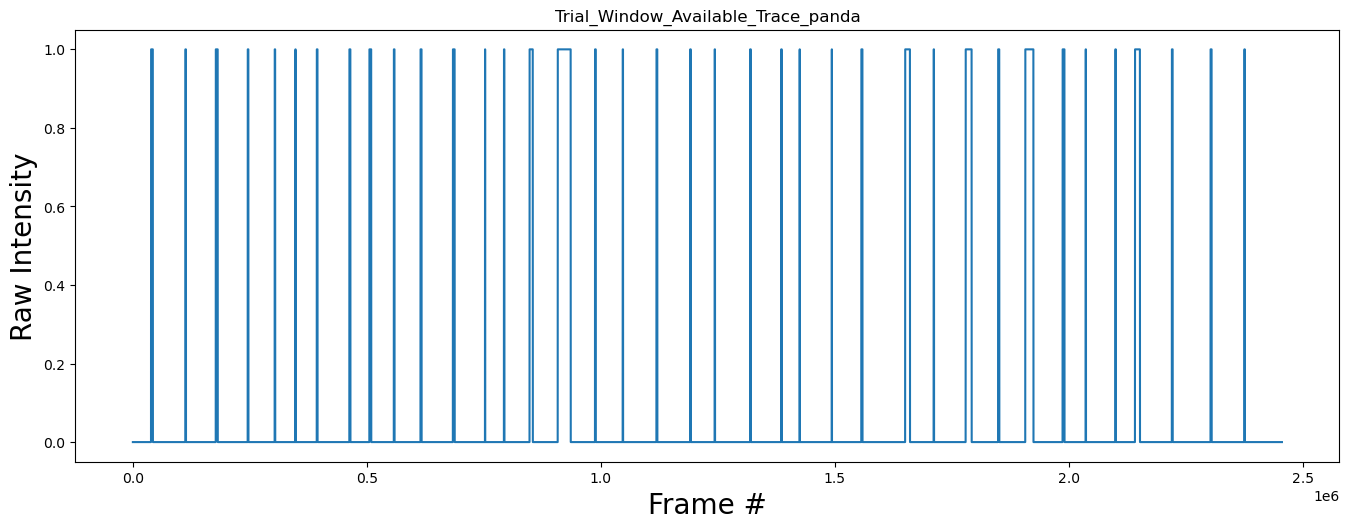

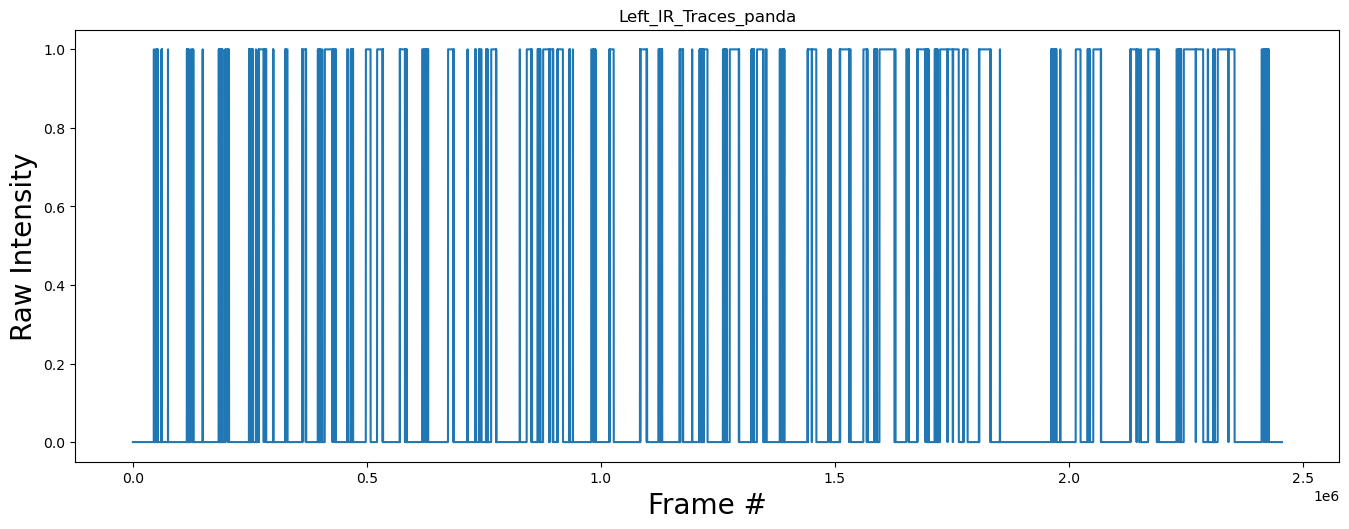

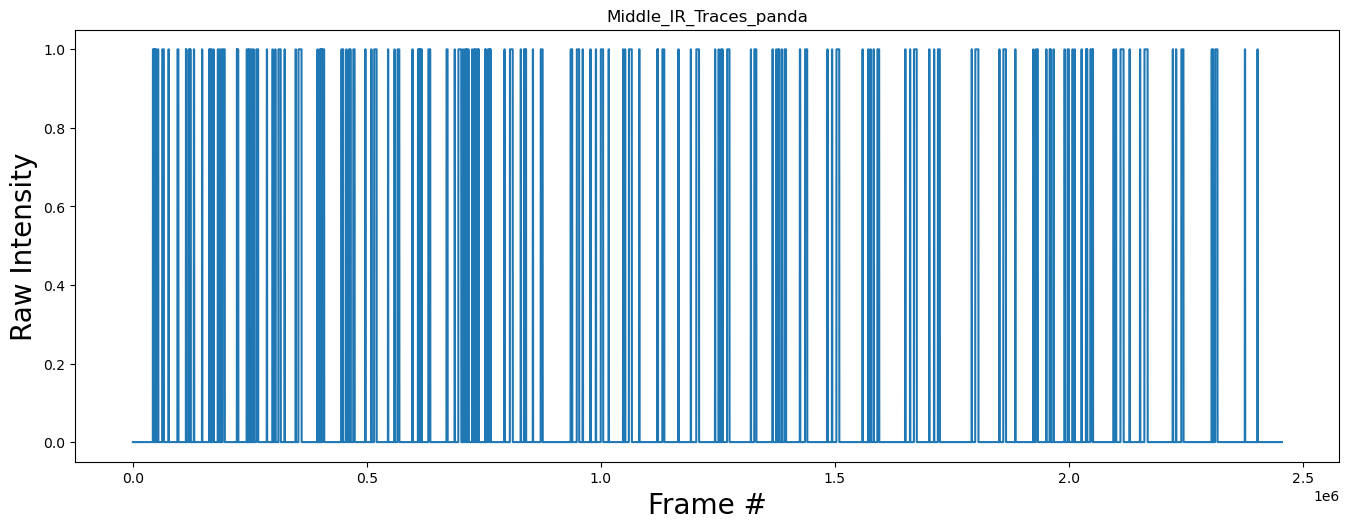

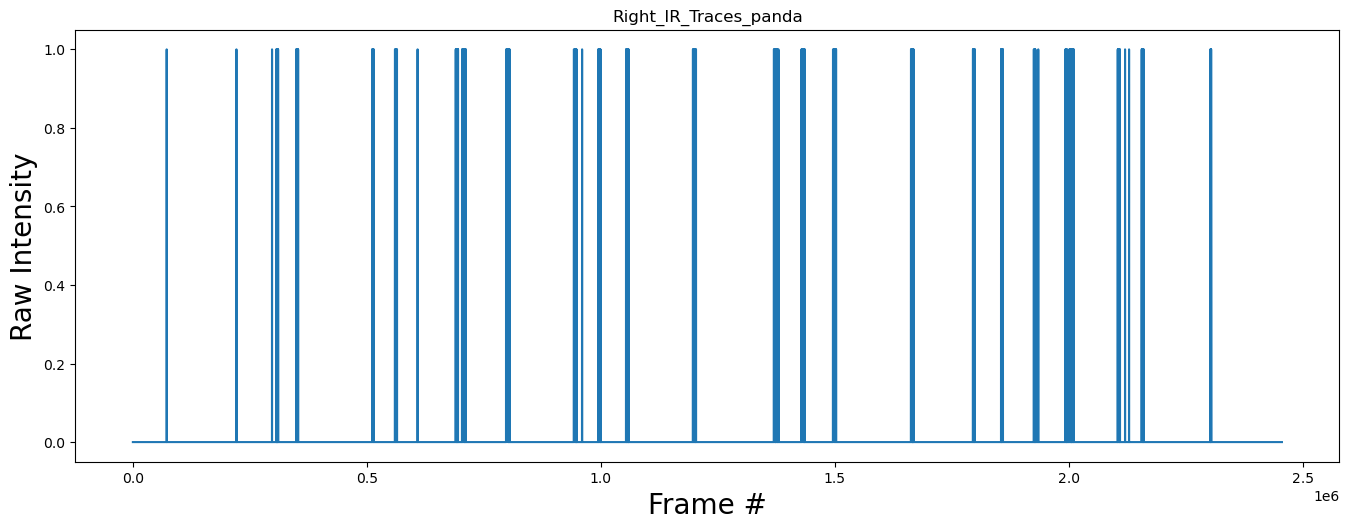

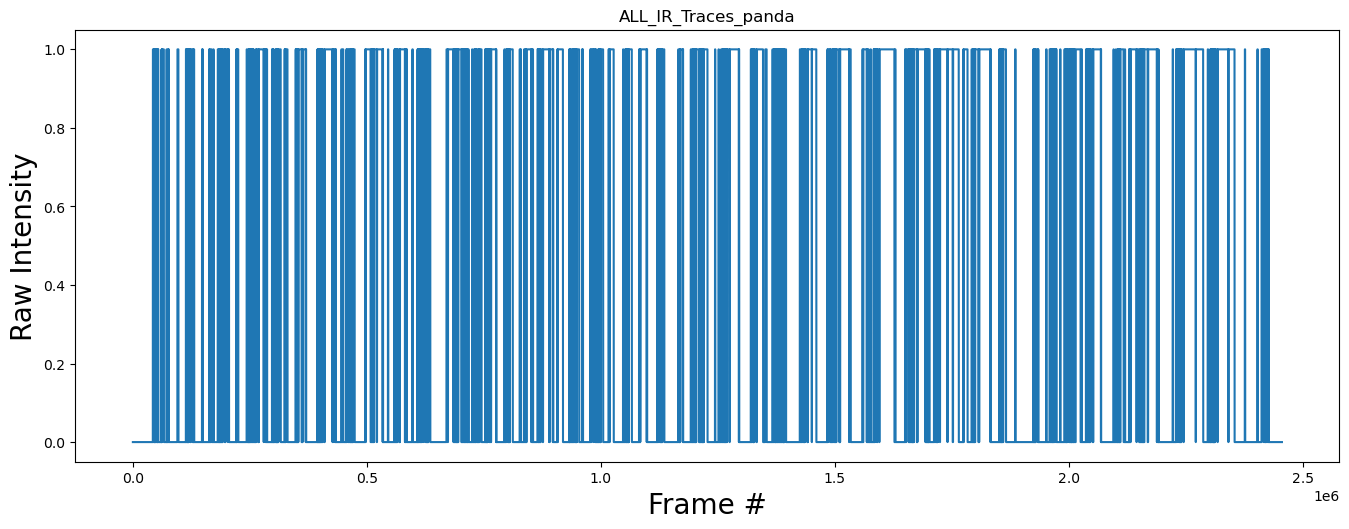

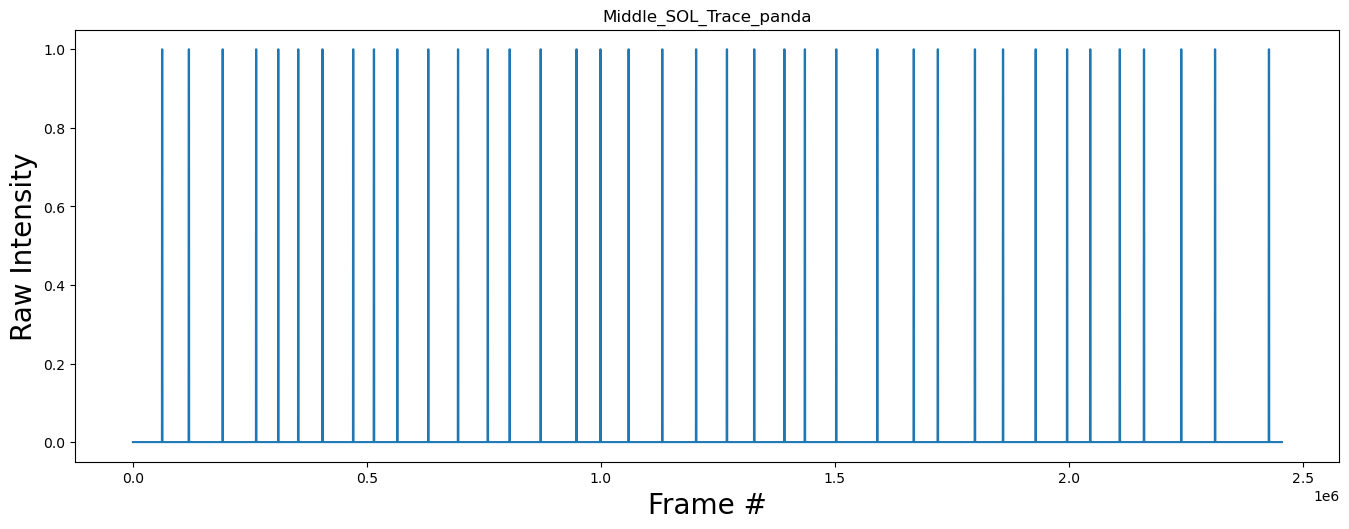

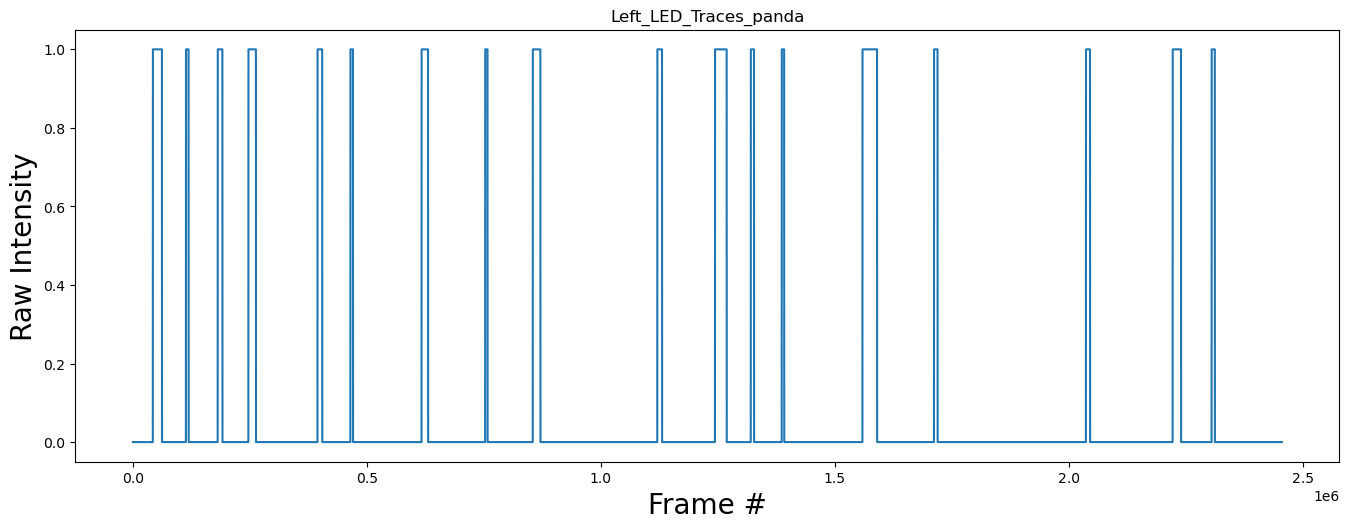

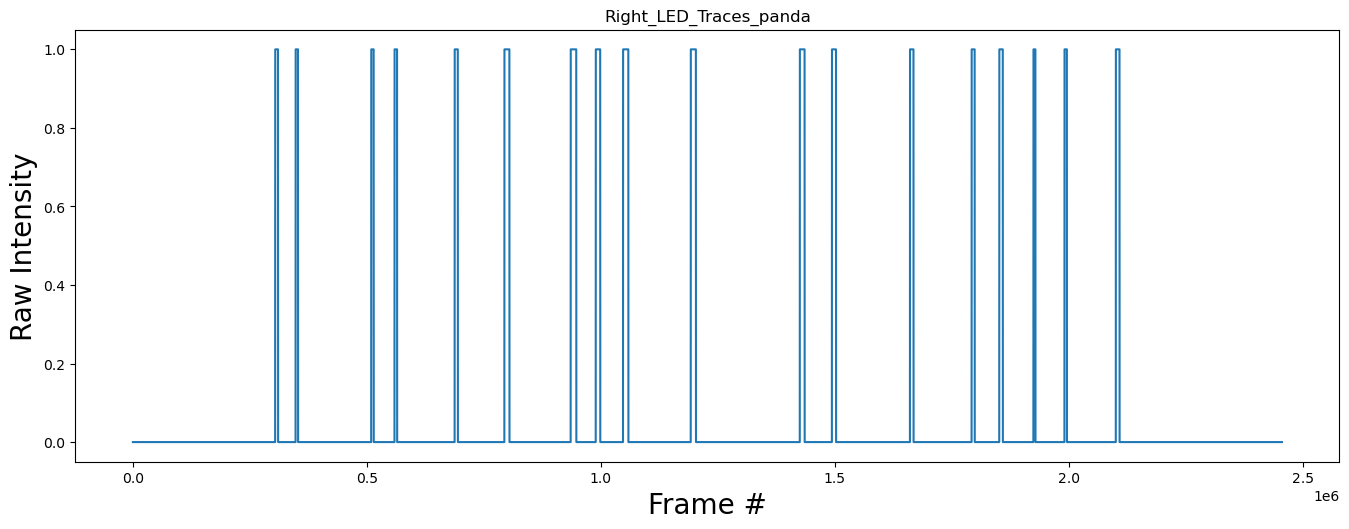

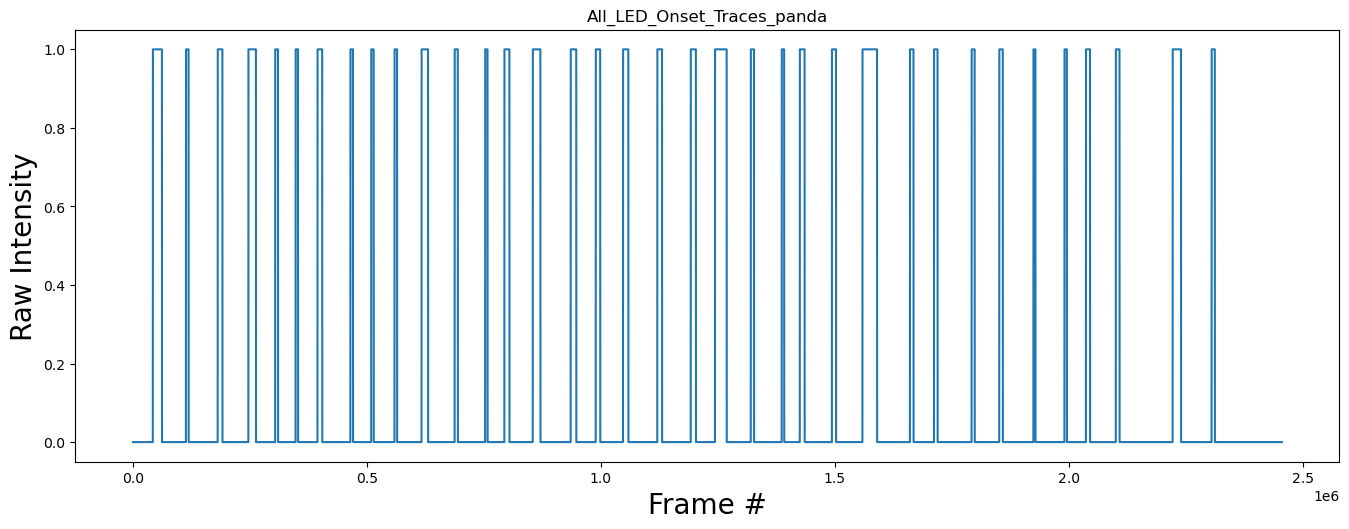

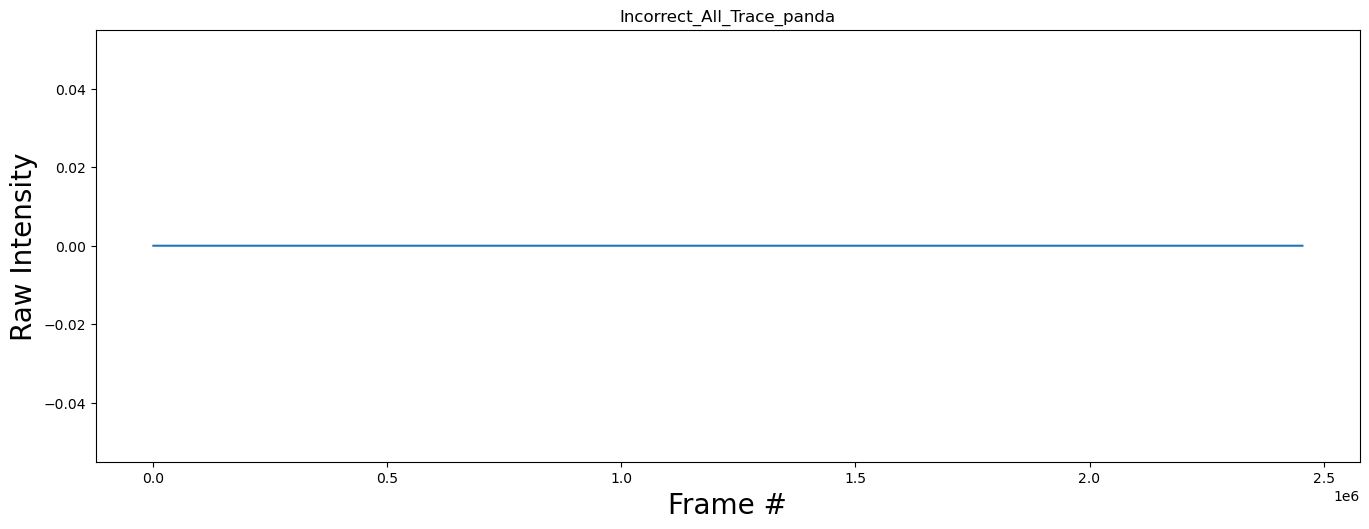

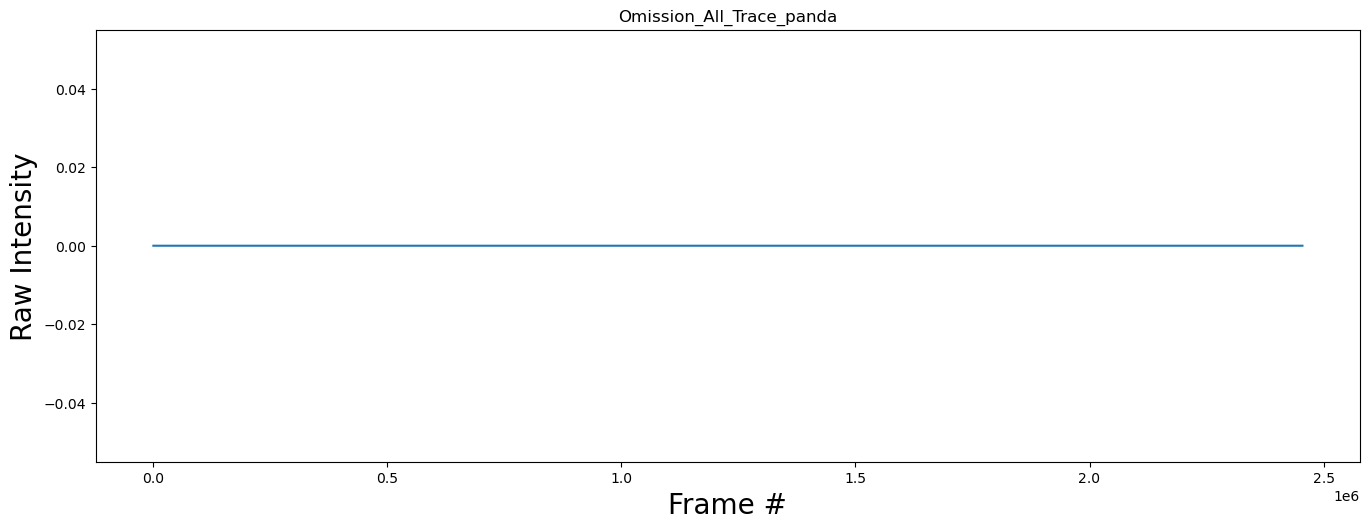

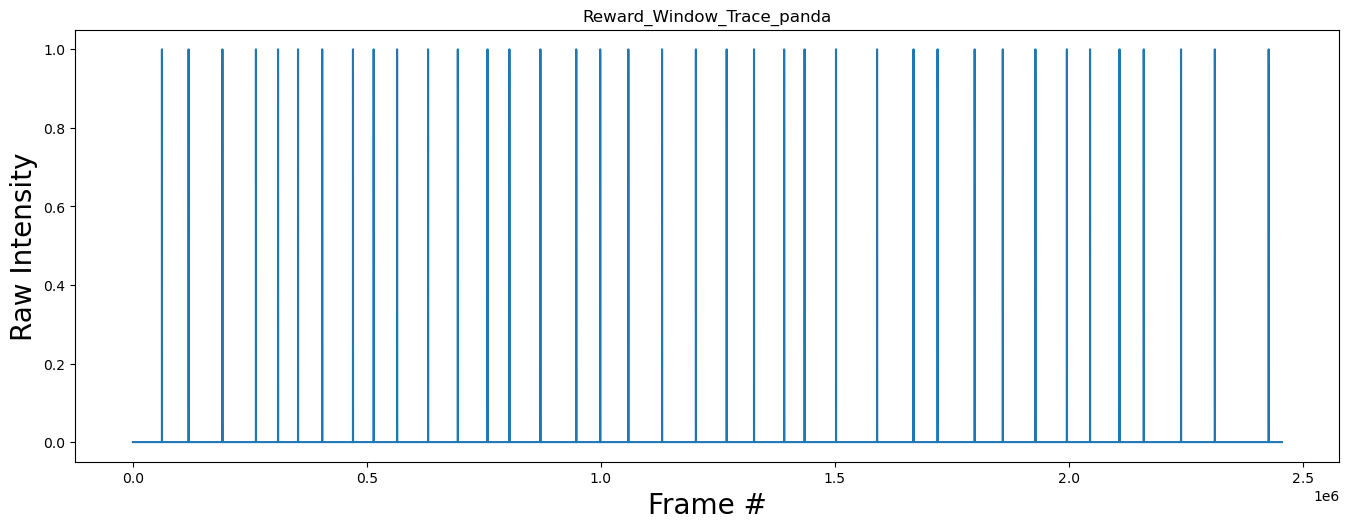

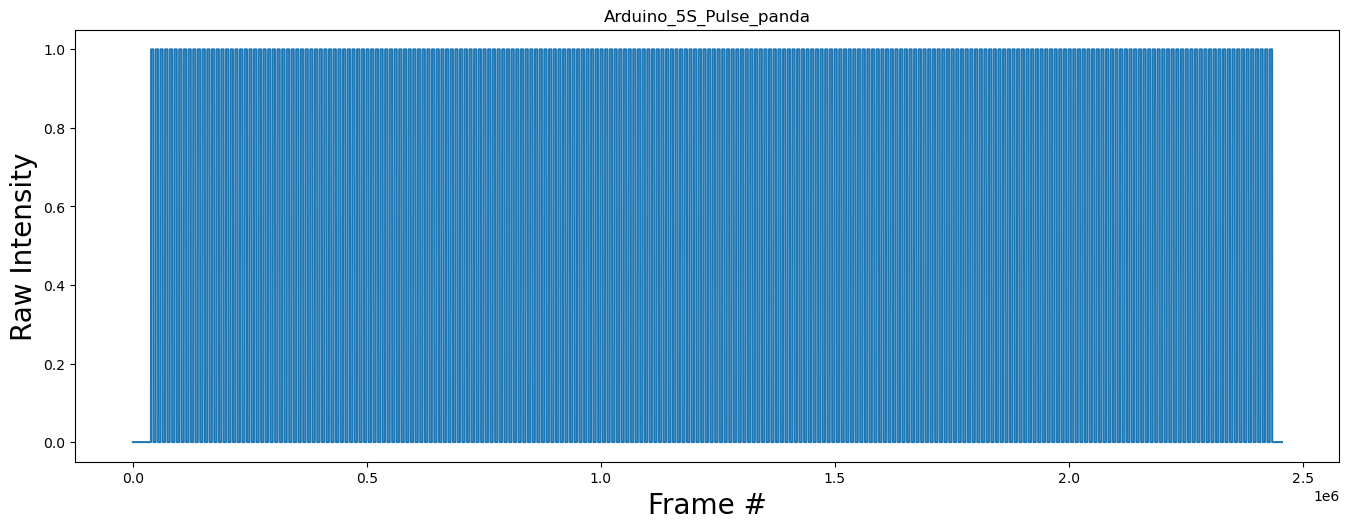

Index(['GPIO_BNC_Sync_Input_Pulse_panda', 'GPIO_BNC_Sync_Output_Pulse_panda',
       'GPIO_5S_Pulse_panda', 'GPIO_IR_Pulse_panda',
       'Corrected_GPIO_BNC_Sync_Input_Pulse_panda',
       'Corrected_GPIO_BNC_Sync_Output_Pulse_panda'],
      dtype='object')


Index(['Trial_Window_Available_Trace_panda', 'Left_IR_Traces_panda',
       'Middle_IR_Traces_panda', 'Right_IR_Traces_panda',
       'ALL_IR_Traces_panda', 'Middle_SOL_Trace_panda',
       'Left_LED_Traces_panda', 'Right_LED_Traces_panda',
       'All_LED_Onset_Traces_panda', 'Incorrect_All_Trace_panda',
       'Omission_All_Trace_panda', 'Reward_Window_Trace_panda',
       'Arduino_5S_Pulse_panda'],
      dtype='object')


In [27]:
for x in range(len(Arduino_df.keys())):
    plt_raw.plot(Arduino_df[list(Arduino_df.keys())[x]])
    plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
    plt_raw.ylabel('Raw Intensity', size = 20)
    plt_raw.xlabel('Frame #', size = 20)
    plt_raw.title(list(Arduino_df.keys())[x], fontdict=None, loc='center')
    plt_raw.show()

print(GPIO_df.keys())
print('\n')
print(Arduino_df.keys())

In [28]:
# double check that 5s pulse from GPIO and arduino has the same number



#######################################################
#GPIO 

GPIO_Dur = []
GPIO_Position = []
Current_Dur = 1  #  The count starts at 1 because the count below starts with index 1
GPIO_count= 0  
for i in range(1, len(GPIO_df['GPIO_5S_Pulse_panda'])):
    if((GPIO_df['GPIO_5S_Pulse_panda'][i]) != (GPIO_df['GPIO_5S_Pulse_panda'][i-1])):
        GPIO_count = GPIO_count+1
        GPIO_Dur.append(Current_Dur)
        GPIO_Position.append(i)
        Current_Dur = 0
    else:
        Current_Dur = Current_Dur +1
print('GPIO Count:', GPIO_count)
#print('GPIO Duration:', GPIO_Dur)
#print('GPIO Position:', GPIO_Position)

#######################################################
# Arduino_5S_Pulse_panda


Arduino_Dur = []
Arduino_Position = []
Current_Dur = 1  #  The count starts at 1 because the count below starts with index 1
Arduino_count= 0    
for i in range(1, len(Arduino_df['Arduino_5S_Pulse_panda'])):
    if((Arduino_df['Arduino_5S_Pulse_panda'][i]) != (Arduino_df['Arduino_5S_Pulse_panda'][i-1])):
        Arduino_count = Arduino_count+1
        Arduino_Dur.append(Current_Dur)
        Arduino_Position.append(i)
        Current_Dur = 0
    else:
        Current_Dur = Current_Dur +1
print('Arduino Count:', Arduino_count)
#print('Arduino Duration:', Arduino_Dur)
#print('Arduino Position:', Arduino_Position)
print('\n')
print('Whole Session GPIO Duration',sum(GPIO_Dur))
print('Whole Session Arduino Duration',sum(Arduino_Dur))
print('\n')
print('There should be 481 timestamps instead of 480.  The last timestamp is missing here(last pulse at off position).')
print('An extrta 100 bins (20 frames/second with 5 second block) of zero will be added in the next step to fill time period until session end.' ) 


########################

if ((Arduino_count != 480)| (GPIO_count != 480)):
    print('Cannot align data,  session duration is uknown (The number of 5s pulse needs to be exactly 480)')
    a = 8/0   #  just to produce a error 
    print(a)

GPIO Count: 480
Arduino Count: 480


Whole Session GPIO Duration 2411356
Whole Session Arduino Duration 2433282


There should be 481 timestamps instead of 480.  The last timestamp is missing here(last pulse at off position).
An extrta 100 bins (20 frames/second with 5 second block) of zero will be added in the next step to fill time period until session end.


Total Frame (GPIO):   47999


Text(0.5, 1.0, 'Inter frame interval (current frame relative to previous frame )(miliseconds)')

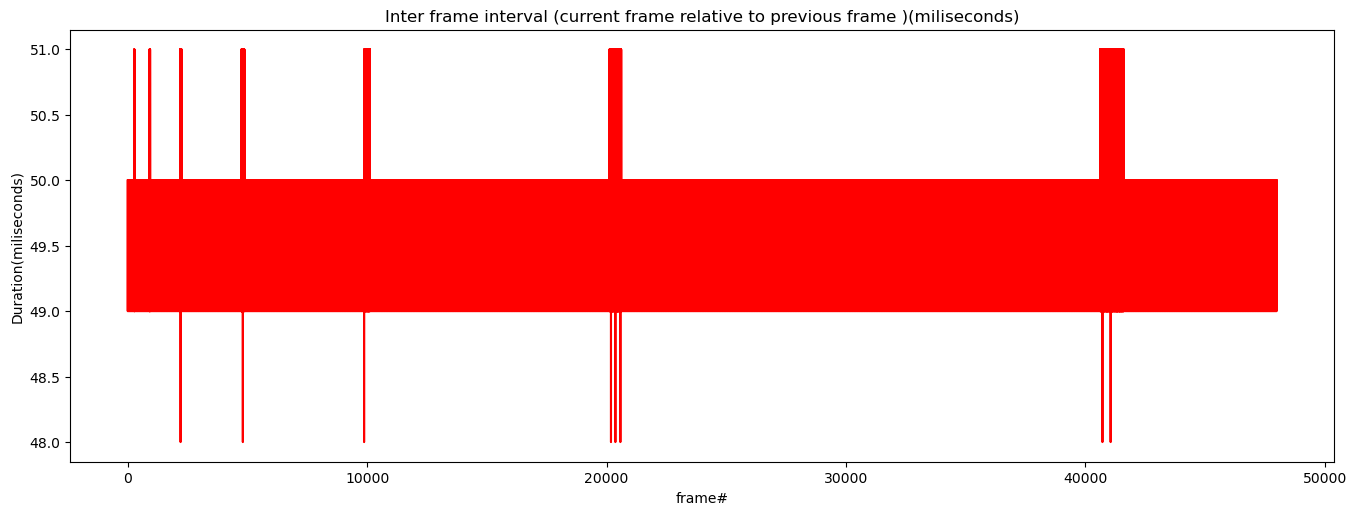

In [29]:
# count number of Ca imaging frames taken (by counting GPIO_BNC_output )


GPIO_BNC_Dur = []
GPIO_BNC_Position = []
Current_Dur = 1  #  The count starts at 1 because the count below starts with index 1
GPIO_BNC_count= 0    
for i in range(1, len(GPIO_BNC_Sync_Output_Pulse)):
    if((GPIO_BNC_Sync_Output_Pulse[i]) > (GPIO_BNC_Sync_Output_Pulse[i-1])):  # only detects "onset" 
        GPIO_BNC_count = GPIO_BNC_count+1
        GPIO_BNC_Dur.append(Current_Dur)
        GPIO_BNC_Position.append(i)
        Current_Dur = 1
    else:
        Current_Dur = Current_Dur +1
print('Total Frame (GPIO):  ',GPIO_BNC_count )

plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
plt_raw.plot(GPIO_BNC_Dur[1:len(GPIO_BNC_Dur)],'r')  #  First bin of GPIO_BNC_Dur is just onset to imaging
#plt_raw.xlim(0,1000)
#plt_raw.xlim(41000,42000)
plt_raw.ylabel('Duration(miliseconds)')
plt_raw.xlabel('frame#')
plt_raw.title('Inter frame interval (current frame relative to previous frame )(miliseconds)')

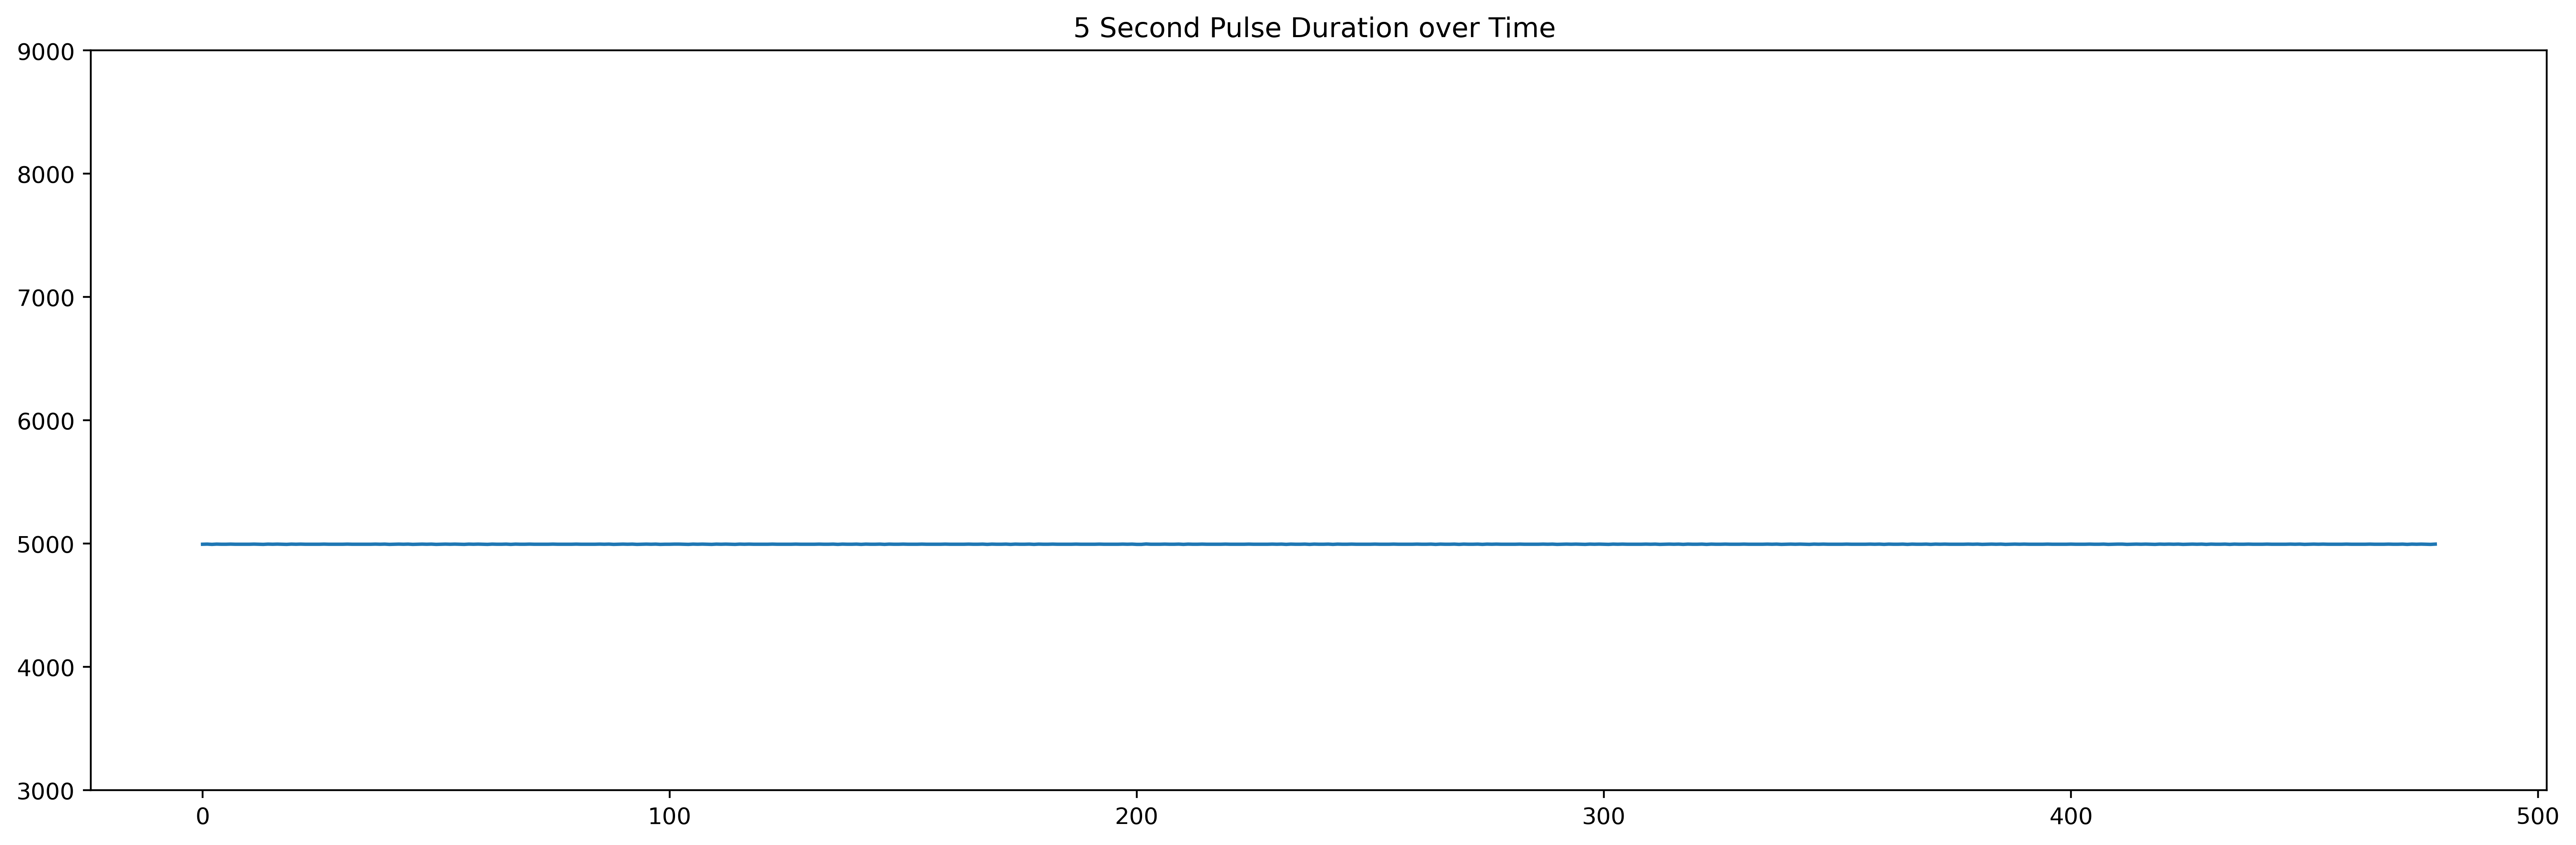

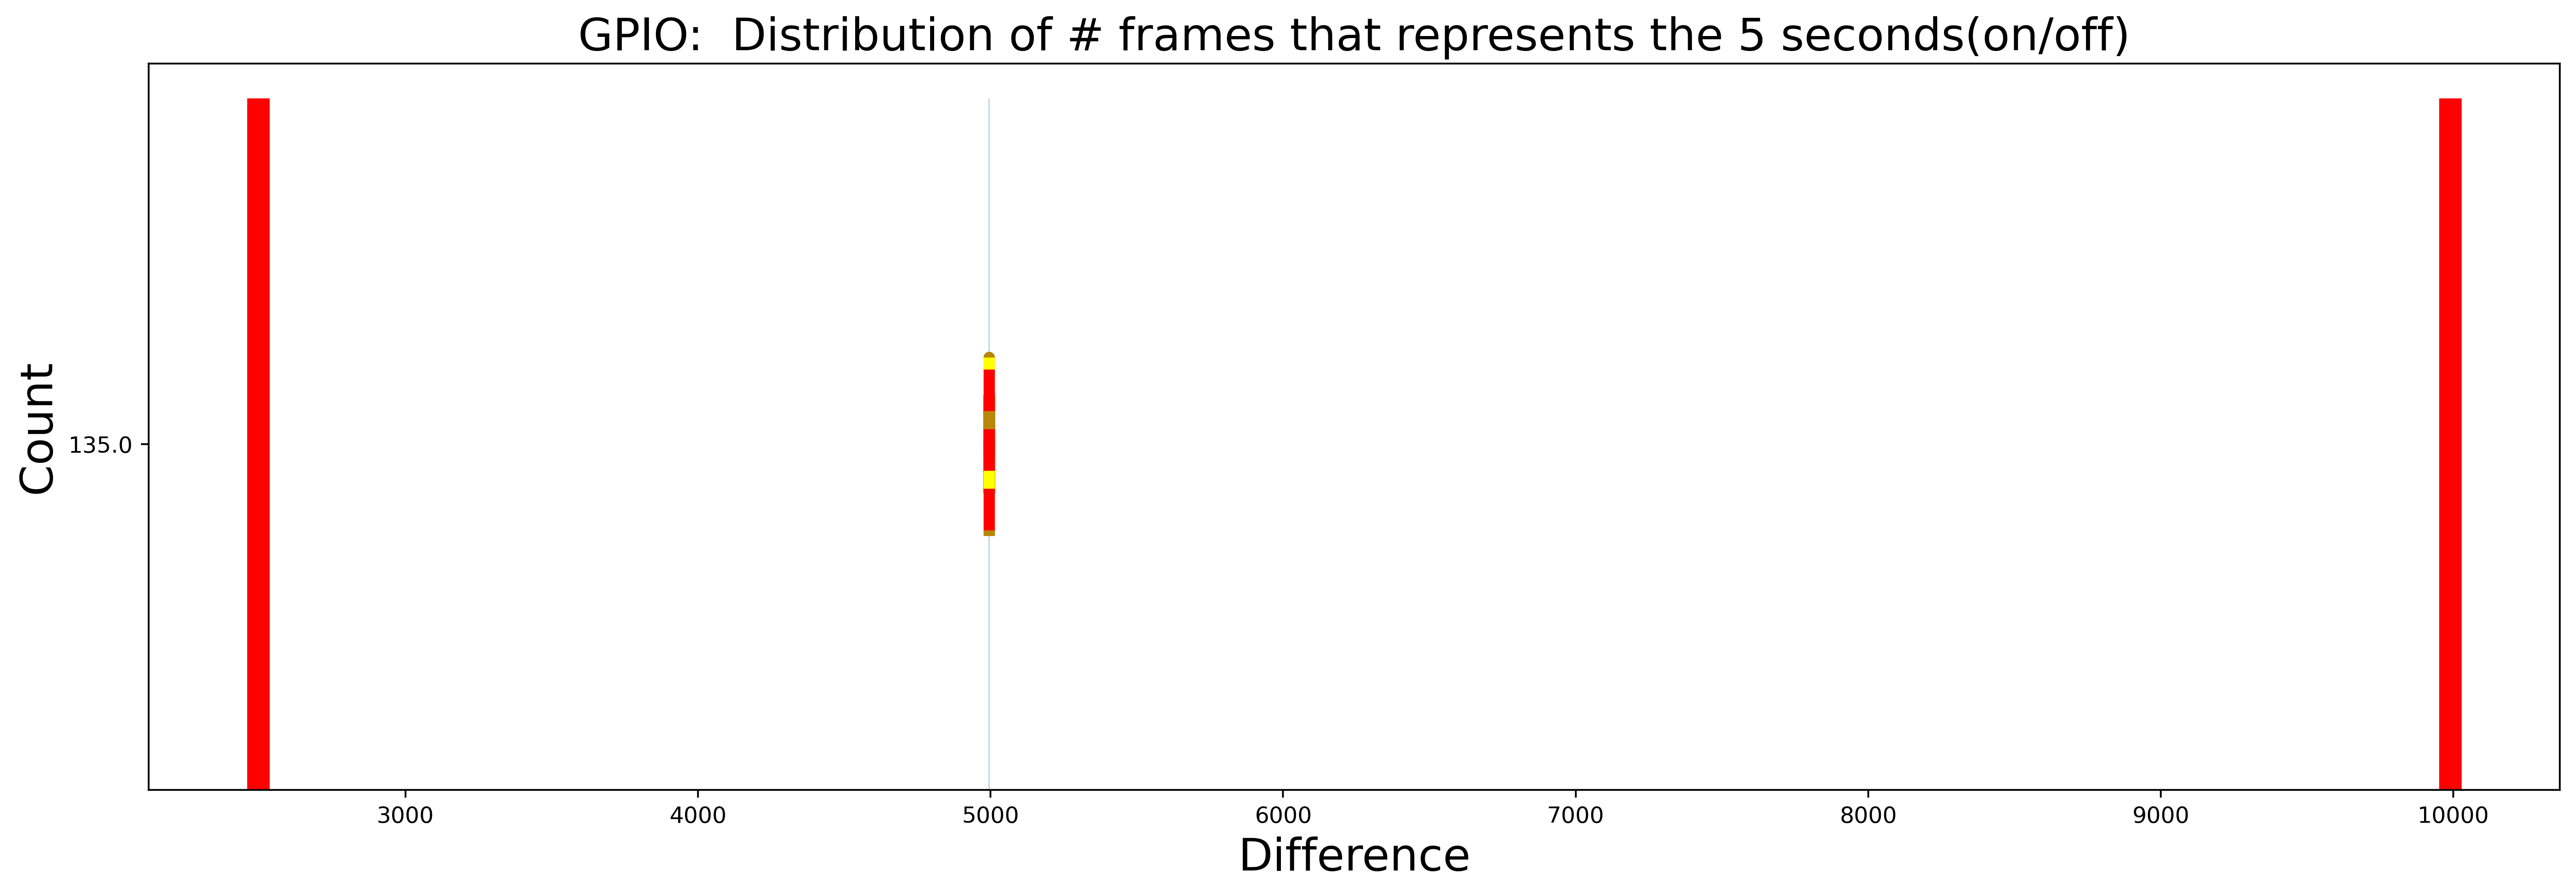

Median Duration of 5s pulse in Frames:    4995.0
Maximum 4997
Minimum 4994
Actual number of 5s pulse:    480


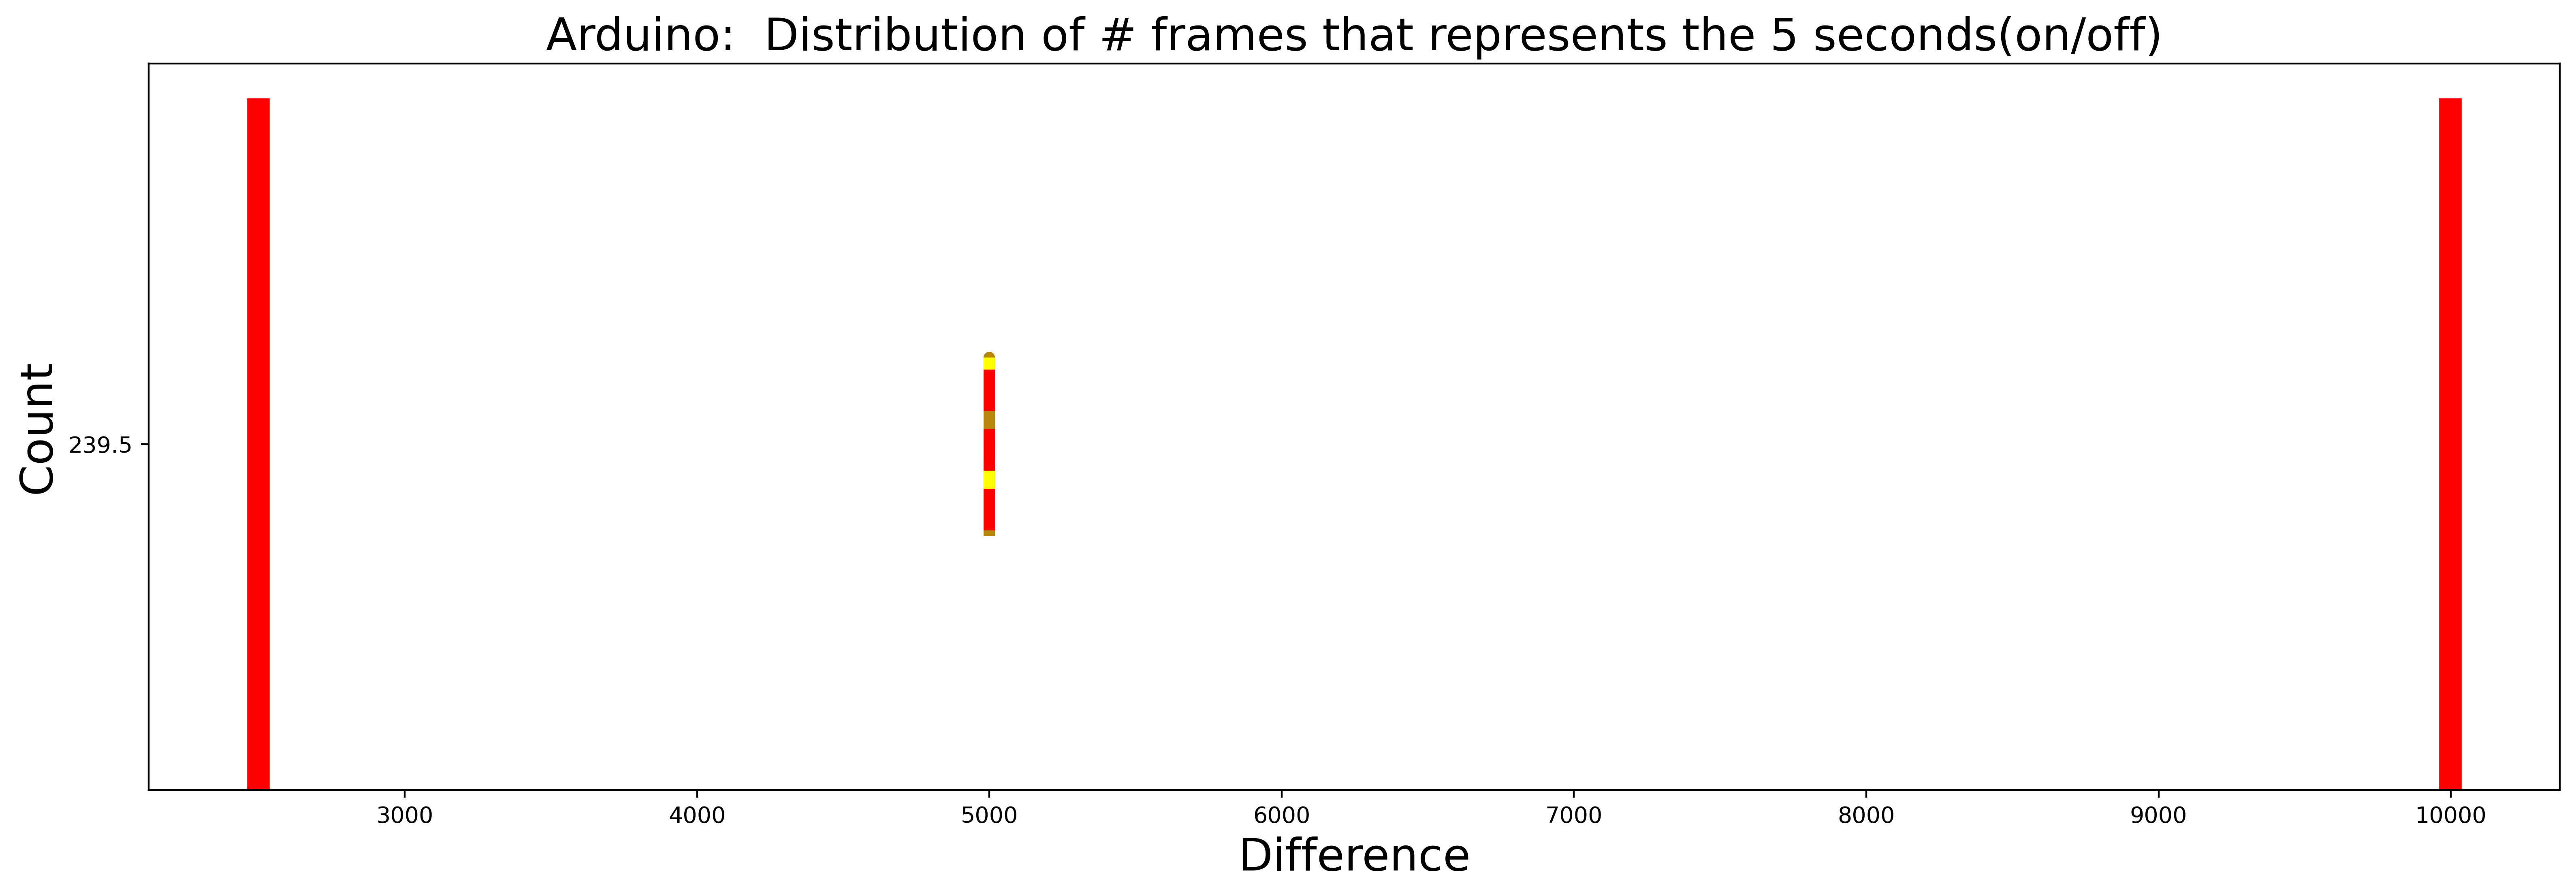

Median Duration of 5s pulse in Frames:    4999.0
Maximum 4999
Minimum 4999
Actual number of 5s pulse:    480


In [30]:


# Find averaged duration of 5s on/off

############################
##.  Histogram
#####################
n_bins = 20
#######################

fig = plt_hist.figure(figsize =(19.2, 19.8), dpi = 400.0)
ax = fig.add_subplot(3,1 ,1)
plt_hist.plot(GPIO_Dur[1:GPIO_count])
plt_hist.title('5 Second Pulse Duration over Time ')
plt.ylim(3000, 9000)

###################################################
# GPIO
fig = plt_hist.figure(figsize =(19.2, 19.8), dpi = 400.0)
ax = fig.add_subplot(3,1 ,2)
#dist = [ -10, 20, 10, 90, 95, 90, 90, 0 , 4]  #. Before minus After
dist = GPIO_Dur[1:GPIO_count]   #. Omit first value (which is Ca Imaging start)
# We can set the number of bins with the *bins* keyword argument.
n, bins, patches = plt_hist.hist(dist, bins=n_bins)
plt_hist.title(('GPIO:  Distribution of # frames that represents the 5 seconds(on/off)'), fontdict=None, loc='center', size = 20)
plt_hist.ylabel('Count', size = 20)
plt_hist.xlabel('Difference', size = 20)
#plt_hist.bar_label(patches)
#print(max(n))   #. max for y axis (important for box plot position)

#. Anything that goes beyond 2 times the median duration for 5 second pulse indicates missing timestamps 
#. Anything that goes under 1/2 the median duration for 5 second pulse indicates noise contimation in 5 second pulse 
ax.vlines(x= np.median(dist)*2, ymin=0, ymax=max(n), colors='red', lw=10, label='vline_single - partial height')
ax.vlines(x= np.median(dist)/2, ymin=0, ymax=max(n), colors='red', lw=10, label='vline_single - partial height')

Position_one_label = 'Veh-Baseline'

# Box plot Settings
boxprops = dict(linestyle='-', linewidth=5, color='darkgoldenrod')
flierprops = dict(marker='o', markerfacecolor='green', markersize=12,linestyle='none')
medianprops = dict(linestyle='-.', linewidth=5, color='Yellow')
meanpointprops = dict(marker='D', markeredgecolor='red',markerfacecolor='red')
meanlineprops = dict(linestyle='--', linewidth=5, color='red')
whiskerprops = dict(linestyle='-', linewidth=5, color='darkgoldenrod')
capprops = dict(linestyle='-', linewidth=5, color='darkgoldenrod')

plt_hist.boxplot(dist, showmeans=True, meanline = True, positions=[max(n)/2], widths = max(n)/4, boxprops=boxprops,  meanprops=meanlineprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops, vert=False) #red is mean,  green is median
plt_hist.show()
Five_Second_On_Off_Median_Dur = np.median(dist)
print('Median Duration of 5s pulse in Frames:   ', Five_Second_On_Off_Median_Dur)
print('Maximum', max(dist))
print('Minimum', min(dist))
print('Actual number of 5s pulse:   ', GPIO_count)


###################################################
# Arduino

fig = plt_hist.figure(figsize =(19.2, 19.8), dpi = 400.0)
ax = fig.add_subplot(3,1 ,3)
#dist = [ -10, 20, 10, 90, 95, 90, 90, 0 , 4]  #. Before minus After
dist = Arduino_Dur[1:Arduino_count]   #. Omit first value (which is Ca Imaging start)
# We can set the number of bins with the *bins* keyword argument.
n, bins, patches = plt_hist.hist(dist, bins=n_bins)
plt_hist.title(('Arduino:  Distribution of # frames that represents the 5 seconds(on/off)'), fontdict=None, loc='center', size = 20)
plt_hist.ylabel('Count', size = 20)
plt_hist.xlabel('Difference', size = 20)
#plt_hist.bar_label(patches)
#print(max(n))   #. max for y axis (important for box plot position)

#. Anything that goes beyond 2 times the median duration for 5 second pulse indicates missing timestamps 
#. Anything that goes under 1/2 the median duration for 5 second pulse indicates noise contimation in 5 second pulse 
ax.vlines(x= np.median(dist)*2, ymin=0, ymax=max(n), colors='red', lw=10, label='vline_single - partial height')
ax.vlines(x= np.median(dist)/2, ymin=0, ymax=max(n), colors='red', lw=10, label='vline_single - partial height')

Position_one_label = 'Veh-Baseline'

# Box plot Settings
boxprops = dict(linestyle='-', linewidth=5, color='darkgoldenrod')
flierprops = dict(marker='o', markerfacecolor='green', markersize=12,linestyle='none')
medianprops = dict(linestyle='-.', linewidth=5, color='Yellow')
meanpointprops = dict(marker='D', markeredgecolor='red',markerfacecolor='red')
meanlineprops = dict(linestyle='--', linewidth=5, color='red')
whiskerprops = dict(linestyle='-', linewidth=5, color='darkgoldenrod')
capprops = dict(linestyle='-', linewidth=5, color='darkgoldenrod')

plt_hist.boxplot(dist, showmeans=True, meanline = True, positions=[max(n)/2], widths = max(n)/4, boxprops=boxprops,  meanprops=meanlineprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops, vert=False) #red is mean,  green is median
plt_hist.show()
Five_Second_On_Off_Median_Dur = np.median(dist)
print('Median Duration of 5s pulse in Frames:   ', Five_Second_On_Off_Median_Dur)
print('Maximum', max(dist))
print('Minimum', min(dist))
print('Actual number of 5s pulse:   ', Arduino_count)




In [31]:
#  Align Timestamps (GPIO)  
# Data Length = 100* (# of 5 second pulse -1) + last pulse duration 
Data_Length = 100* (GPIO_count-1) #. 100 bins per block. (20 frames/second with 5 second block)

Start_Position = 0
End_Position = 99

GPIO_Aligned_TimeStamp = pd.DataFrame()
GPIO_Aligned_TimeStamp['GPIO_5S_Pulse_panda'] = np.zeros(Data_Length)
GPIO_Aligned_TimeStamp['GPIO_IR_Pulse_panda'] = np.zeros(Data_Length)


for i in range(GPIO_count-1):
   
    # GPIO_5S_Pulse_panda
    # Resample , so regardless the # of time point will be resampled back to 100 timepoints.  
    #d = df[df.keys()[0]][Five_Second_On_Off['Time_Stamp'][i] : Five_Second_On_Off['Time_Stamp'][i+1]]
    d = GPIO_df['GPIO_5S_Pulse_panda'][GPIO_Position[i]: GPIO_Position[i+1]]
    x = np.linspace(0, len(d), len(d))
    f = signal.resample(d, 100)   #. 20 frames/second for 5 seconds 
    xnew = np.linspace(0, len(d), 100, endpoint=False)
    # assign resampled data back to dataframe
    GPIO_Aligned_TimeStamp['GPIO_5S_Pulse_panda'].loc[Start_Position: End_Position] = f

    # GPIO_IR_Pulse_panda
    d = GPIO_df['GPIO_IR_Pulse_panda'][GPIO_Position[i]: GPIO_Position[i+1]]
    x = np.linspace(0, len(d), len(d))
    f = signal.resample(d, 100)   #. 20 frames/second for 5 seconds 
    xnew = np.linspace(0, len(d), 100, endpoint=False)
    # assign resampled data back to dataframe
    GPIO_Aligned_TimeStamp['GPIO_IR_Pulse_panda'].loc[Start_Position: End_Position] = f

    
    Start_Position = Start_Position +100
    End_Position = End_Position + 100

    


print(GPIO_Aligned_TimeStamp.keys())
print(i)
    

Index(['GPIO_5S_Pulse_panda', 'GPIO_IR_Pulse_panda'], dtype='object')
478


In [32]:
# Purely for Plotting purpose later 

# Binary form with 0.5 threshold for the aligned arduino data
BinaryGPIO_Aligned_TimeStamp = GPIO_Aligned_TimeStamp.copy()
for i in range(len(GPIO_Aligned_TimeStamp.keys())):
    BinaryGPIO_Aligned_TimeStamp[list(GPIO_Aligned_TimeStamp.keys())[i]]= np.where(BinaryGPIO_Aligned_TimeStamp[list(GPIO_Aligned_TimeStamp.keys())[i]]>0.5, 1, 0)


#There should be 481 timestamps instead of 480.  The last timestamp is missing here(last pulse at off position).
# An extrta 100 bins (20 frames/second with 5 second block) of zero will be added in this step to fill time period until session end.
for i in range(100):
    BinaryGPIO_Aligned_TimeStamp.loc[len(BinaryGPIO_Aligned_TimeStamp)] = 0

In [33]:
#  Align Timestamps (Arduino)  
# Data Length = 100* (# of 5 second pulse -1) + last pulse duration 
Data_Length = 100* (Arduino_count-1) #. 100 bins per block. (20 frames/second with 5 second block)

Start_Position = 0
End_Position = 99

Arduino_Aligned_TimeStamp = pd.DataFrame()
Arduino_Aligned_TimeStamp['Arduino_5S_Pulse_panda'] = np.zeros(Data_Length)

Arduino_Aligned_TimeStamp['Left_IR_Traces_panda'] = np.zeros(Data_Length)
Arduino_Aligned_TimeStamp['Middle_IR_Traces_panda'] = np.zeros(Data_Length)
Arduino_Aligned_TimeStamp['Right_IR_Traces_panda'] = np.zeros(Data_Length)
Arduino_Aligned_TimeStamp['ALL_IR_Traces_panda'] = np.zeros(Data_Length)

Arduino_Aligned_TimeStamp['Left_LED_Traces_panda'] = np.zeros(Data_Length)
Arduino_Aligned_TimeStamp['Right_LED_Traces_panda'] = np.zeros(Data_Length)
Arduino_Aligned_TimeStamp['All_LED_Onset_Traces_panda'] = np.zeros(Data_Length)


Arduino_Aligned_TimeStamp['Middle_SOL_Trace_panda'] = np.zeros(Data_Length)


Arduino_Aligned_TimeStamp['Incorrect_All_Trace_panda'] = np.zeros(Data_Length)
Arduino_Aligned_TimeStamp['Omission_All_Trace_panda'] = np.zeros(Data_Length)

Arduino_Aligned_TimeStamp['Reward_Window_Trace_panda'] = np.zeros(Data_Length)

Arduino_Aligned_TimeStamp['Trial_Window_Available_Trace_panda'] = np.zeros(Data_Length)


for i in range(Arduino_count-1):
    
    # ALL_IR_Traces_panda
    # Resample , so regardless the # of time point will be resampled back to 100 timepoints.  
    #d = df[df.keys()[0]][Five_Second_On_Off['Time_Stamp'][i] : Five_Second_On_Off['Time_Stamp'][i+1]]
    
    d = Arduino_df['Arduino_5S_Pulse_panda'][Arduino_Position[i]: Arduino_Position[i+1]]
    x = np.linspace(0, len(d), len(d))
    f = signal.resample(d, 100)   #. 20 frames/second for 5 seconds 
    xnew = np.linspace(0, len(d), 100, endpoint=False)
    # assign resampled data back to dataframe
    Arduino_Aligned_TimeStamp['Arduino_5S_Pulse_panda'].loc[Start_Position: End_Position] = f
    
    d = Arduino_df['Left_IR_Traces_panda'][Arduino_Position[i]: Arduino_Position[i+1]]
    x = np.linspace(0, len(d), len(d))
    f = signal.resample(d, 100)   #. 20 frames/second for 5 seconds 
    xnew = np.linspace(0, len(d), 100, endpoint=False)
    # assign resampled data back to dataframe
    Arduino_Aligned_TimeStamp['Left_IR_Traces_panda'].loc[Start_Position: End_Position] = f

    d = Arduino_df['Middle_IR_Traces_panda'][Arduino_Position[i]: Arduino_Position[i+1]]
    x = np.linspace(0, len(d), len(d))
    f = signal.resample(d, 100)   #. 20 frames/second for 5 seconds 
    xnew = np.linspace(0, len(d), 100, endpoint=False)
    # assign resampled data back to dataframe
    Arduino_Aligned_TimeStamp['Middle_IR_Traces_panda'].loc[Start_Position: End_Position] = f

    d = Arduino_df['Right_IR_Traces_panda'][Arduino_Position[i]: Arduino_Position[i+1]]
    x = np.linspace(0, len(d), len(d))
    f = signal.resample(d, 100)   #. 20 frames/second for 5 seconds 
    xnew = np.linspace(0, len(d), 100, endpoint=False)
    # assign resampled data back to dataframe
    Arduino_Aligned_TimeStamp['Right_IR_Traces_panda'].loc[Start_Position: End_Position] = f
    
    d = Arduino_df['ALL_IR_Traces_panda'][Arduino_Position[i]: Arduino_Position[i+1]]
    x = np.linspace(0, len(d), len(d))
    f = signal.resample(d, 100)   #. 20 frames/second for 5 seconds 
    xnew = np.linspace(0, len(d), 100, endpoint=False)
    # assign resampled data back to dataframe
    Arduino_Aligned_TimeStamp['ALL_IR_Traces_panda'].loc[Start_Position: End_Position] = f

    d = Arduino_df['Left_LED_Traces_panda'][Arduino_Position[i]: Arduino_Position[i+1]]
    x = np.linspace(0, len(d), len(d))
    f = signal.resample(d, 100)   #. 20 frames/second for 5 seconds 
    xnew = np.linspace(0, len(d), 100, endpoint=False)
    # assign resampled data back to dataframe
    Arduino_Aligned_TimeStamp['Left_LED_Traces_panda'].loc[Start_Position: End_Position] = f


    d = Arduino_df['Right_LED_Traces_panda'][Arduino_Position[i]: Arduino_Position[i+1]]
    x = np.linspace(0, len(d), len(d))
    f = signal.resample(d, 100)   #. 20 frames/second for 5 seconds 
    xnew = np.linspace(0, len(d), 100, endpoint=False)
    # assign resampled data back to dataframe
    Arduino_Aligned_TimeStamp['Right_LED_Traces_panda'].loc[Start_Position: End_Position] = f

    
    d = Arduino_df['All_LED_Onset_Traces_panda'][Arduino_Position[i]: Arduino_Position[i+1]]
    x = np.linspace(0, len(d), len(d))
    f = signal.resample(d, 100)   #. 20 frames/second for 5 seconds 
    xnew = np.linspace(0, len(d), 100, endpoint=False)
    # assign resampled data back to dataframe
    Arduino_Aligned_TimeStamp['All_LED_Onset_Traces_panda'].loc[Start_Position: End_Position] = f

    
    d = Arduino_df['Middle_SOL_Trace_panda'][Arduino_Position[i]: Arduino_Position[i+1]]
    x = np.linspace(0, len(d), len(d))
    f = signal.resample(d, 100)   #. 20 frames/second for 5 seconds 
    xnew = np.linspace(0, len(d), 100, endpoint=False)
    # assign resampled data back to dataframe
    Arduino_Aligned_TimeStamp['Middle_SOL_Trace_panda'].loc[Start_Position: End_Position] = f

    d = Arduino_df['Incorrect_All_Trace_panda'][Arduino_Position[i]: Arduino_Position[i+1]]
    x = np.linspace(0, len(d), len(d))
    f = signal.resample(d, 100)   #. 20 frames/second for 5 seconds 
    xnew = np.linspace(0, len(d), 100, endpoint=False)
    # assign resampled data back to dataframe
    Arduino_Aligned_TimeStamp['Incorrect_All_Trace_panda'].loc[Start_Position: End_Position] = f

    d = Arduino_df['Omission_All_Trace_panda'][Arduino_Position[i]: Arduino_Position[i+1]]
    x = np.linspace(0, len(d), len(d))
    f = signal.resample(d, 100)   #. 20 frames/second for 5 seconds 
    xnew = np.linspace(0, len(d), 100, endpoint=False)
    # assign resampled data back to dataframe
    Arduino_Aligned_TimeStamp['Omission_All_Trace_panda'].loc[Start_Position: End_Position] = f

    
    d = Arduino_df['Reward_Window_Trace_panda'][Arduino_Position[i]: Arduino_Position[i+1]]
    x = np.linspace(0, len(d), len(d))
    f = signal.resample(d, 100)   #. 20 frames/second for 5 seconds 
    xnew = np.linspace(0, len(d), 100, endpoint=False)
    # assign resampled data back to dataframe
    Arduino_Aligned_TimeStamp['Reward_Window_Trace_panda'].loc[Start_Position: End_Position] = f


    d = Arduino_df['Trial_Window_Available_Trace_panda'][Arduino_Position[i]: Arduino_Position[i+1]]
    x = np.linspace(0, len(d), len(d))
    f = signal.resample(d, 100)   #. 20 frames/second for 5 seconds 
    xnew = np.linspace(0, len(d), 100, endpoint=False)
    # assign resampled data back to dataframe
    Arduino_Aligned_TimeStamp['Trial_Window_Available_Trace_panda'].loc[Start_Position: End_Position] = f
    
    Start_Position = Start_Position +100
    End_Position = End_Position + 100
       
print(Arduino_Aligned_TimeStamp.keys())

Index(['Arduino_5S_Pulse_panda', 'Left_IR_Traces_panda',
       'Middle_IR_Traces_panda', 'Right_IR_Traces_panda',
       'ALL_IR_Traces_panda', 'Left_LED_Traces_panda',
       'Right_LED_Traces_panda', 'All_LED_Onset_Traces_panda',
       'Middle_SOL_Trace_panda', 'Incorrect_All_Trace_panda',
       'Omission_All_Trace_panda', 'Reward_Window_Trace_panda',
       'Trial_Window_Available_Trace_panda'],
      dtype='object')


In [34]:

# Binary form with 0.5 threshold for the aligned arduino data
BinaryArduino_Aligned_TimeStamp = Arduino_Aligned_TimeStamp.copy()
for i in range(len(Arduino_Aligned_TimeStamp.keys())):
    BinaryArduino_Aligned_TimeStamp[list(Arduino_Aligned_TimeStamp.keys())[i]]= np.where(BinaryArduino_Aligned_TimeStamp[list(Arduino_Aligned_TimeStamp.keys())[i]]>0.5, 1, 0)


#There should be 481 timestamps instead of 480.  The last timestamp is missing here(last pulse at off position).
# An extrta 100 bins (20 frames/second with 5 second block) of zero will be added in this step to fill time period until session end.
for i in range(100):
    BinaryArduino_Aligned_TimeStamp.loc[len(BinaryArduino_Aligned_TimeStamp)] = 0

In [35]:
#  Trim out the begining of GPIO and Arduino timestamp (to match the length of Cell data ), before doing whole session alignmnet 
if (TroubleShoot_Trim_Begining_GPIO_Arduino == 1): 


    print('# Frames AFTER 5s_Aligned_w_GPIO (same as length at 20 frames/s):',len(BinaryArduino_Aligned_TimeStamp))
    print('# Frames Imaged',GPIO_Corrected_FramesImaged)
    
    #print(type(BinaryArduino_Aligned_TimeStamp))
    #print(BinaryArduino_Aligned_TimeStamp)
    
    Shift_Bin = len(BinaryArduino_Aligned_TimeStamp)-GPIO_Corrected_FramesImaged
    df2 = BinaryArduino_Aligned_TimeStamp.shift(Shift_Bin*(-1), axis=0)
    df2= df2[0:(len(BinaryArduino_Aligned_TimeStamp)-Shift_Bin)]
    BinaryArduino_Aligned_TimeStamp = df2*1    #(*1 to avoid assignment issues , does not change values)



    Shift_Bin = len(BinaryGPIO_Aligned_TimeStamp)-GPIO_Corrected_FramesImaged
    df3 = BinaryGPIO_Aligned_TimeStamp.shift(Shift_Bin*(-1), axis=0)
    df3= df3[0:(len(BinaryGPIO_Aligned_TimeStamp)-Shift_Bin)]
    BinaryGPIO_Aligned_TimeStamp = df3*1    #(*1 to avoid assignment issues , does not change values)




# df = pd.DataFrame({"A": [1, 2, 3, 4, 5, 6,7 ],
#                    "B": [10, 20, 30, 40, 50, 60, 70],
#                    "C": [11, 22, 33, 44, 55, 66, 77],
#                    "D": [12, 24, 51, 36, 2,3,5]},
#                   )

###### Example of trimming
# df = pd.DataFrame({"A": [1, 2, 3, 4, 5, 6,7 ],
#                    "B": [10, 20, 30, 40, 50, 60, 70],
#                    "C": [11, 22, 33, 44, 55, 66, 77],
#                    "D": [12, 24, 51, 36, 2,3,5]},
#                   )
# print(df)
# Shift = 2
# df2 = df.shift(Shift*(-1), axis=0)
# df2= df2[0:(len(df)-Shift)]
# print(df2)


In [36]:
# Whole Session Alignmnet 

WholeSession_Arduino_Aligned_TimeStamp = pd.DataFrame()

for i in range(len(Arduino_Aligned_TimeStamp.keys())):
    WholeSession_Arduino_Aligned_TimeStamp[Arduino_Aligned_TimeStamp.keys()[i]] = np.zeros(len(df_cal['time']))############## change len of adjustment
    d = BinaryArduino_Aligned_TimeStamp[Arduino_Aligned_TimeStamp.keys()[i]]  #############
    x = np.linspace(0, len(d), len(d))
    f = signal.resample(d, len(df_cal['time']))############## change len of adjustment
    xnew = np.linspace(0, len(d), len(df_cal['time']), endpoint=False)############## change len of adjustment
    WholeSession_Arduino_Aligned_TimeStamp[Arduino_Aligned_TimeStamp.keys()[i]]= f

# # import matplotlib.pyplot as plt
# plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
# plt.plot(x, d, 'go-', xnew, f, '.-')
# plt.legend(['data', 'resampled'], loc='best')
# #plt.xlim(40000, 43000)
# plt.show()
# print(len(d))
# print(len(f))



In [37]:
# Backup
# ###### Extract time stamps for Trial Initiation End_(Part2- OFFSET )


# # Binary form with 0.5 threshold for the aligned arduino data
# Binary_WholeSession_Arduino_Aligned_TimeStamp = WholeSession_Arduino_Aligned_TimeStamp.copy()
# for i in range(len(WholeSession_Arduino_Aligned_TimeStamp.keys())):
#     Binary_WholeSession_Arduino_Aligned_TimeStamp[list(WholeSession_Arduino_Aligned_TimeStamp.keys())[i]]= np.where(Binary_WholeSession_Arduino_Aligned_TimeStamp[list(WholeSession_Arduino_Aligned_TimeStamp.keys())[i]]>0.5, 1, 0)

# Binary_WholeSession_Arduino_Aligned_TimeStamp_keys= Binary_WholeSession_Arduino_Aligned_TimeStamp.keys()

# # Detect OffSet Timestamps
# for i in range(len(Binary_WholeSession_Arduino_Aligned_TimeStamp_keys)):
#     Current_TimeStampTrace = Binary_WholeSession_Arduino_Aligned_TimeStamp_keys[i]
#     # check from [bin 2] to [len of bin -1 ]
#     TimeStampTrace = []
#     TimeStampTrace.append(0)    # for the first bin
#     Previous = 0
#     Previous_Position = -5  #  -5 is for detecting the first number, bc it cannot be 0 or it will not pass the threshold (i-Previous_Position > 1),  it will get overwritten by "i" after the frist timestamp
#     for i in range(1,len(Binary_WholeSession_Arduino_Aligned_TimeStamp[Current_TimeStampTrace])):
        
#         Current = Binary_WholeSession_Arduino_Aligned_TimeStamp[Current_TimeStampTrace][i]
    
#         if(((Previous < Current))& (i-Previous_Position > 2)):   # detects offset of trial window (Trial Win End),  (i-Previous_Position) removes consecutive '1's and 10 is just a threshold of 10/20 sec until next events is detected
#             TimeStampTrace.append(1) 
#             Previous_Position = i
#         else:
#             TimeStampTrace.append(0)
#         Previous = Binary_WholeSession_Arduino_Aligned_TimeStamp[Current_TimeStampTrace][i-1]
    
#     #  convert dictionary to dataframe
#     temp = SignalTraces_pd.DataFrame(TimeStampTrace)
#     TimeStampTrace_panda = temp.squeeze()                #################      Reward_Window_Trace_panda
#     Binary_WholeSession_Arduino_Aligned_TimeStamp[(Current_TimeStampTrace + '_'+ 'Offset')]  = TimeStampTrace_panda

# # Detect Onset Timestamps
# for i in range(len(Binary_WholeSession_Arduino_Aligned_TimeStamp_keys)):
#     Current_TimeStampTrace = Binary_WholeSession_Arduino_Aligned_TimeStamp_keys[i]
#     # check from [bin 2] to [len of bin -1 ]
#     TimeStampTrace = []
#     TimeStampTrace.append(0)    # for the first bin
#     Previous = 0
#     Previous_Position = -5  #  -5 is for detecting the first number, bc it cannot be 0 or it will not pass the threshold (i-Previous_Position > 1),  it will get overwritten by "i" after the frist timestamp
#     for i in range(1,len(Binary_WholeSession_Arduino_Aligned_TimeStamp[Current_TimeStampTrace])):
        
#         Current = Binary_WholeSession_Arduino_Aligned_TimeStamp[Current_TimeStampTrace][i]
    
#         if(((Previous> Current))& (i-Previous_Position > 40)):   # detects offset of trial window (Trial Win End),  (i-Previous_Position) removes consecutive '1's and 10 is just a threshold of 10/20 sec until next events is detected
#             TimeStampTrace.append(1) 
#             Previous_Position = i
#         else:
#             TimeStampTrace.append(0)
#         Previous = Binary_WholeSession_Arduino_Aligned_TimeStamp[Current_TimeStampTrace][i-1]
    
#     #  convert dictionary to dataframe
#     temp = SignalTraces_pd.DataFrame(TimeStampTrace)
#     TimeStampTrace_panda = temp.squeeze()                #################      Reward_Window_Trace_panda
#     Binary_WholeSession_Arduino_Aligned_TimeStamp[(Current_TimeStampTrace + '_'+ 'Onset')]  = TimeStampTrace_panda

    

# # Convert Traces into TimeStamps
# WholeSession_Aligned_Event_Count = {}  
# WholeSession_Aligned_Event_Count_TimeStamps = defaultdict(list)

# for i in range(len(Binary_WholeSession_Arduino_Aligned_TimeStamp.keys())):

#     # Reward_Trial_init_Window_End_panda
#     Signal_Trace_to_Convert = Binary_WholeSession_Arduino_Aligned_TimeStamp.keys()[i]
#     WholeSession_Aligned_Event_Count[ (Signal_Trace_to_Convert + '_'+ 'ConvertedTimeStamp') ]= 0
#     WholeSession_Aligned_Event_Count_TimeStamps[(Signal_Trace_to_Convert + '_'+ 'ConvertedTimeStamp')].append(None)
#     for i in range(len(Binary_WholeSession_Arduino_Aligned_TimeStamp[Signal_Trace_to_Convert])):
#         if(Binary_WholeSession_Arduino_Aligned_TimeStamp[Signal_Trace_to_Convert][i]== 1):
#             WholeSession_Aligned_Event_Count[(Signal_Trace_to_Convert + '_'+ 'ConvertedTimeStamp') ] += 1  # add one  to count num of events
#             WholeSession_Aligned_Event_Count_TimeStamps[(Signal_Trace_to_Convert + '_'+ 'ConvertedTimeStamp') ].append([i]) 
#     #  Remove 'None' place holder for Event_Count_TimeStamp, which is the first value
#     del WholeSession_Aligned_Event_Count_TimeStamps[(Signal_Trace_to_Convert + '_'+ 'ConvertedTimeStamp')][0]

# # print(WholeSession_Aligned_Event_Count)

In [38]:
###### Extract time stamps for Trial Initiation End_(Part2- OFFSET )


# Binary form with 0.5 threshold for the aligned arduino data
Binary_WholeSession_Arduino_Aligned_TimeStamp = WholeSession_Arduino_Aligned_TimeStamp.copy()
for i in range(len(WholeSession_Arduino_Aligned_TimeStamp.keys())):
    Binary_WholeSession_Arduino_Aligned_TimeStamp[list(WholeSession_Arduino_Aligned_TimeStamp.keys())[i]]= np.where(Binary_WholeSession_Arduino_Aligned_TimeStamp[list(WholeSession_Arduino_Aligned_TimeStamp.keys())[i]]>0.5, 1, 0)

Binary_WholeSession_Arduino_Aligned_TimeStamp_keys= Binary_WholeSession_Arduino_Aligned_TimeStamp.keys()

# Detect Onset Timestamps
for i in range(len(Binary_WholeSession_Arduino_Aligned_TimeStamp_keys)):
    Current_TimeStampTrace = Binary_WholeSession_Arduino_Aligned_TimeStamp_keys[i]
    # check from [bin 2] to [len of bin -1 ]
    TimeStampTrace_Onset = []
    TimeStampTrace_Onset.append(0)    # for the first bin

    TimeStampTrace_Offset = []
    TimeStampTrace_Offset.append(0)    # for the first bin
    Previous = 0
    Previous_Position = -5  # Only for Onset,  -5 is for detecting the first number, bc it cannot be 0 or it will not pass the threshold (i-Previous_Position > 1),  it will get overwritten by "i" after the frist timestamp
    Previous_State = 0  # on or off sate,  make sure 
    for i in range(1,len(Binary_WholeSession_Arduino_Aligned_TimeStamp[Current_TimeStampTrace])):
        
        Current = Binary_WholeSession_Arduino_Aligned_TimeStamp[Current_TimeStampTrace][i]
        Previous = Binary_WholeSession_Arduino_Aligned_TimeStamp[Current_TimeStampTrace][i-1]
    
        if(((Previous< Current))& (Previous_State ==0)):   # detects onset of trial window (Trial Win End),  (i-Previous_Position) removes consecutive '1's and 10 is just a threshold of 10/20 sec until next events is detected
            TimeStampTrace_Onset.append(1) 
            Previous_Position = i
            Previous_State = 1
        else:
            TimeStampTrace_Onset.append(0)
            
        

    
        if(((Previous > Current))& (Previous_State ==1)):   # detects offset of trial window (Trial Win End),  (i-Previous_Position) removes consecutive '1's and 10 is just a threshold of 10/20 sec until next events is detected
            TimeStampTrace_Offset.append(1) 
            Previous_State = 0

        else:
            TimeStampTrace_Offset.append(0)
        


    
    #  convert dictionary to dataframe
    temp = SignalTraces_pd.DataFrame(TimeStampTrace_Onset)
    TimeStampTrace_Onset_panda = temp.squeeze()                #################      Reward_Window_Trace_panda
    Binary_WholeSession_Arduino_Aligned_TimeStamp[(Current_TimeStampTrace + '_'+ 'Onset')]  = TimeStampTrace_Onset_panda

    #  convert dictionary to dataframe
    temp = SignalTraces_pd.DataFrame(TimeStampTrace_Offset)
    TimeStampTrace_Offset_panda = temp.squeeze()                #################      Reward_Window_Trace_panda
    Binary_WholeSession_Arduino_Aligned_TimeStamp[(Current_TimeStampTrace + '_'+ 'Offset')]  = TimeStampTrace_Offset_panda




    

# Convert Traces into TimeStamps
WholeSession_Aligned_Event_Count = {}  
WholeSession_Aligned_Event_Count_TimeStamps = defaultdict(list)

for i in range(len(Binary_WholeSession_Arduino_Aligned_TimeStamp.keys())):

    # Reward_Trial_init_Window_End_panda
    Signal_Trace_to_Convert = Binary_WholeSession_Arduino_Aligned_TimeStamp.keys()[i]
    WholeSession_Aligned_Event_Count[ (Signal_Trace_to_Convert + '_'+ 'ConvertedTimeStamp') ]= 0
    WholeSession_Aligned_Event_Count_TimeStamps[(Signal_Trace_to_Convert + '_'+ 'ConvertedTimeStamp')].append(None)
    for i in range(len(Binary_WholeSession_Arduino_Aligned_TimeStamp[Signal_Trace_to_Convert])):
        if(Binary_WholeSession_Arduino_Aligned_TimeStamp[Signal_Trace_to_Convert][i]== 1):
            WholeSession_Aligned_Event_Count[(Signal_Trace_to_Convert + '_'+ 'ConvertedTimeStamp') ] += 1  # add one  to count num of events
            WholeSession_Aligned_Event_Count_TimeStamps[(Signal_Trace_to_Convert + '_'+ 'ConvertedTimeStamp') ].append([i]) 
    #  Remove 'None' place holder for Event_Count_TimeStamp, which is the first value
    del WholeSession_Aligned_Event_Count_TimeStamps[(Signal_Trace_to_Convert + '_'+ 'ConvertedTimeStamp')][0]

print(WholeSession_Aligned_Event_Count)

{'Arduino_5S_Pulse_panda_ConvertedTimeStamp': 23999, 'Left_IR_Traces_panda_ConvertedTimeStamp': 13747, 'Middle_IR_Traces_panda_ConvertedTimeStamp': 5422, 'Right_IR_Traces_panda_ConvertedTimeStamp': 1591, 'ALL_IR_Traces_panda_ConvertedTimeStamp': 20772, 'Left_LED_Traces_panda_ConvertedTimeStamp': 4440, 'Right_LED_Traces_panda_ConvertedTimeStamp': 2838, 'All_LED_Onset_Traces_panda_ConvertedTimeStamp': 7278, 'Middle_SOL_Trace_panda_ConvertedTimeStamp': 758, 'Incorrect_All_Trace_panda_ConvertedTimeStamp': 0, 'Omission_All_Trace_panda_ConvertedTimeStamp': 0, 'Reward_Window_Trace_panda_ConvertedTimeStamp': 52, 'Trial_Window_Available_Trace_panda_ConvertedTimeStamp': 2811, 'Arduino_5S_Pulse_panda_Onset_ConvertedTimeStamp': 239, 'Arduino_5S_Pulse_panda_Offset_ConvertedTimeStamp': 239, 'Left_IR_Traces_panda_Onset_ConvertedTimeStamp': 335, 'Left_IR_Traces_panda_Offset_ConvertedTimeStamp': 335, 'Middle_IR_Traces_panda_Onset_ConvertedTimeStamp': 187, 'Middle_IR_Traces_panda_Offset_ConvertedTimeSta

In [39]:
#WholeSession_Aligned_Event_Count_TimeStamps['All_LED_Onset_Traces_panda_Onset_ConvertedTimeStamp']

# print(WholeSession_Aligned_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Offset_ConvertedTimeStamp'])
# print('\n')
# print(WholeSession_Aligned_Event_Count_TimeStamps['All_LED_Onset_Traces_panda_Onset_ConvertedTimeStamp'])

#print(len(WholeSession_Aligned_Event_Count_TimeStamps['All_LED_Onset_Traces_panda_Onset_ConvertedTimeStamp']))
#print(len(WholeSession_Aligned_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Offset_ConvertedTimeStamp']))

print(WholeSession_Aligned_Event_Count_TimeStamps['All_LED_Onset_Traces_panda_Onset_ConvertedTimeStamp'])
print('\n')
print(WholeSession_Aligned_Event_Count_TimeStamps['Middle_SOL_Trace_panda_Onset_ConvertedTimeStamp'])
print('\n')
print(WholeSession_Aligned_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp'])

[[78], [1491], [2849], [4160], [5300], [5304], [6177], [7113], [8518], [9408], [10400], [10403], [11559], [12973], [14277], [15000], [15098], [16311], [17930], [19001], [20167], [21632], [23061], [24095], [25625], [26947], [27719], [29091], [30396], [32425], [33453], [35060], [36242], [36300], [37700], [39027], [39944], [41222], [43649], [45314]]


[[467], [1606], [3051], [4483], [4501], [5427], [6281], [7314], [8629], [9514], [10513], [11837], [13109], [14378], [15313], [16637], [18170], [19192], [20394], [21835], [23281], [24595], [25763], [27051], [27924], [29267], [31020], [32577], [33605], [35191], [36299], [36393], [37787], [39131], [40120], [41380], [42415], [44008], [45452], [47753]]


[[1], [1467], [2766], [4131], [5283], [5301], [6167], [7081], [8474], [9329], [10374], [10401], [11513], [12897], [14269], [15078], [16173], [17377], [18970], [20152], [21594], [23035], [24080], [25595], [26923], [27711], [29084], [30347], [32220], [33437], [34799], [34805], [36191], [37353], [38

In [40]:
# # Correction on timestamps  #0
# # ISI filter for Trial initiation window begin/ end
 
# Temp_Event_Count = WholeSession_Aligned_Event_Count.copy()
# Temp_Event_Count_TimeStamps = WholeSession_Aligned_Event_Count_TimeStamps.copy()

# # del WholeSession_Aligned_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp']
# # del WholeSession_Aligned_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Offset_ConvertedTimeStamp']


# Current_Trial_Initi = 0
# Previous_Trial_Initi = 0

# for i in range(1,(WholeSession_Aligned_Event_Count['Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp'])):
#     #print(i)

#     Temp_Current_Trial_Initi = WholeSession_Aligned_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp'][i]
#     Current_Trial_Initi = int(''.join(map(str,Temp_Current_Trial_Initi)))
#     #print(Current_Trial_Initi)
    
#     if((Current_Trial_Initi- Previous_Trial_Initi )> (30* 1000)):  #30 seconds of ITI threshold to detect another tial_Initi
#         WholeSession_Aligned_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp'].append(Temp_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp'][i])
#         WholeSession_Aligned_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Offset_ConvertedTimeStamp'].append(Temp_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Offset_ConvertedTimeStamp'][i])
#     else:
#         WholeSession_Aligned_Event_Count['Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp']= WholeSession_Aligned_Event_Count['Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp']-1
#         WholeSession_Aligned_Event_Count['Trial_Window_Available_Trace_panda_Offset_ConvertedTimeStamp']= WholeSession_Aligned_Event_Count['Trial_Window_Available_Trace_panda_Offset_ConvertedTimeStamp']-1
    
#     Previous_Trial_Initi = Current_Trial_Initi +0 


# print('\n')
# print(WholeSession_Aligned_Event_Count['Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp'])
# print(WholeSession_Aligned_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp'])




In [41]:
# print(WholeSession_Aligned_Event_Count['Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp'])
# print(WholeSession_Aligned_Event_Count['Trial_Window_Available_Trace_panda_Offset_ConvertedTimeStamp'])

# print(Temp_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp'])

# print((Temp_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp'][10]))

# tempa = Temp_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp'][10]
# xx = int(''.join(map(str,tempa)))
# print(xx)


# print('\n')
# print(Current_Trial_Initi)
# print('\n')
# print(WholeSession_Aligned_Event_Count['Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp'])
# print('\n')



In [42]:
# Correction on timestamps  #1 
# use the presence of ALL LED (left/right) onset to filter Trial initiation window begin/ end

count= 0
Filtered_Label_Onset = 'Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp'
Filtered_Label_Offset = 'Trial_Window_Available_Trace_panda_Offset_ConvertedTimeStamp'
Reference_Label_Onset = 'All_LED_Onset_Traces_panda_Onset_ConvertedTimeStamp'
Reference_Label_Offset = 'All_LED_Onset_Traces_panda_Offset_ConvertedTimeStamp'


Reference_Timestamp_Onset = []
Reference_Timestamp_Offset = []
Filtered_Timestamp_Onset = []
Filtered_Timestamp_Offset = []
Filter_Threshold = 2        #unit in frames,so 2 frames (Almost "exact" match)

for i in range(len(WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Onset])):
    for x in range(len(WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Offset])):
        tempa = WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Onset][x]
        tempb = WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Offset][x]
        tempc = WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Onset][i]
        tempd = WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Offset][i]

        
        num_a = int(''.join(map(str,tempa)))
        num_b = int(''.join(map(str,tempb)))
        num_c = int(''.join(map(str,tempc)))
        num_d = int(''.join(map(str,tempd)))
    
        # LED onset - Trial_Win_End should be very close to zero or at zero
    
        if(abs(num_c- num_b) < Filter_Threshold ):

            # Timestamps that are re-sampled independently can come in slightly earlier/later making "offset"  starting before "onset" due to varability from sampling 
            #  if "offset" timestamps comes before "onset" timestamp,  the offset timestamp is set to equal onset timestamp. 
            # eg.  beging of cue should not come before trial initiation. 
            Filtered_Timestamp_Onset.append(tempa)  
            Filtered_Timestamp_Offset.append(tempc) # tempc instead of tempb here is on purpose, LED cannot turn on before trial_Win_end 
            Reference_Timestamp_Onset.append(tempc)  
            Reference_Timestamp_Offset.append(tempd)
            break   # stops loop after finding the matching trial_end timestamps, not necessary, just run faster
                
            # if(num_c< num_b):
                
            #     Filtered_Timestamp_Onset.append(tempa)  
            #     Filtered_Timestamp_Offset.append(tempc) # tempc instead of tempb here is on purpose, LED cannot turn on before trial_Win_end 
            #     Reference_Timestamp_Onset.append(tempc)  
            #     Reference_Timestamp_Offset.append(tempd)
            # else:
                    
            #     Filtered_Timestamp_Onset.append(tempa)
            #     Filtered_Timestamp_Offset.append(tempb)
            #     Reference_Timestamp_Onset.append(tempc)
            #     Reference_Timestamp_Offset.append(tempd)
            # break   # stops loop after finding the matching trial_end timestamps, not necessary, just run faster


WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Onset]= Filtered_Timestamp_Onset
WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Offset]= Filtered_Timestamp_Offset
WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Onset]= Reference_Timestamp_Onset
WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Offset]= Reference_Timestamp_Offset

# update timestamp 
WholeSession_Aligned_Event_Count[Filtered_Label_Onset]= len(Filtered_Timestamp_Onset)
WholeSession_Aligned_Event_Count[Filtered_Label_Offset] = len(Filtered_Timestamp_Offset)
WholeSession_Aligned_Event_Count[Reference_Label_Onset]= len(Reference_Timestamp_Onset)
WholeSession_Aligned_Event_Count[Reference_Label_Offset]= len(Reference_Timestamp_Offset)

print(WholeSession_Aligned_Event_Count[Filtered_Label_Offset])
print(WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Offset])
print('\n')
print(WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Onset])


# print('\n')
# print(WholeSession_Aligned_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp'])
# print('\n')

38
[[78], [1491], [2849], [4160], [5300], [5304], [6177], [7113], [8518], [9408], [10400], [10403], [11559], [12973], [14277], [15098], [16311], [17930], [19001], [20167], [21632], [23061], [24095], [25625], [26947], [27719], [29091], [30396], [32425], [33453], [35060], [36242], [37700], [39027], [39944], [41222], [43649], [45314]]


[[78], [1491], [2849], [4160], [5300], [5304], [6177], [7113], [8518], [9408], [10400], [10403], [11559], [12973], [14277], [15098], [16311], [17930], [19001], [20167], [21632], [23061], [24095], [25625], [26947], [27719], [29091], [30396], [32425], [33453], [35060], [36242], [37700], [39027], [39944], [41222], [43649], [45314]]


In [43]:
# Correction on timestamps  #2
# use the presence of ALL LED (left/right) onset to filter Left LED

count= 0
Reference_Label_Onset = 'All_LED_Onset_Traces_panda_Onset_ConvertedTimeStamp'
Reference_Label_Offset = 'All_LED_Onset_Traces_panda_Offset_ConvertedTimeStamp'
Filtered_Label_Onset = 'Left_LED_Traces_panda_Onset_ConvertedTimeStamp'
Filtered_Label_Offset = 'Left_LED_Traces_panda_Offset_ConvertedTimeStamp'

Reference_Timestamp_Onset = []
Reference_Timestamp_Offset = []
Filtered_Timestamp_Onset = []
Filtered_Timestamp_Offset = []
Filter_Threshold = 2        #unit in frames,so 2 frames (Almost "exact" match)

for i in range(len(WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Onset])):
    for x in range(len(WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Offset])):
        tempa = WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Onset][x]
        tempb = WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Offset][x]
        tempc = WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Onset][i]
        tempd = WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Offset][i]

        
        num_a = int(''.join(map(str,tempa)))
        num_b = int(''.join(map(str,tempb)))
        num_c = int(''.join(map(str,tempc)))
        num_d = int(''.join(map(str,tempd)))
    
        # LED onset - Trial_Win_End should be very close to zero or at zero
    
        if(abs(num_c- num_a) < Filter_Threshold ):
            
            Filtered_Timestamp_Onset.append(tempc)  # c instead of a is on purpose
            Filtered_Timestamp_Offset.append(tempb)
            Reference_Timestamp_Onset.append(tempc)
            Reference_Timestamp_Offset.append(tempd)
            break   # stops loop after finding the matching trial_end timestamps, not necessary, just run faster


WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Onset]= Filtered_Timestamp_Onset
WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Offset]= Filtered_Timestamp_Offset
#WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Onset]= Reference_Timestamp_Onset
#WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Offset]= Reference_Timestamp_Offset

# update timestamp 
WholeSession_Aligned_Event_Count[Filtered_Label_Onset]= len(Filtered_Timestamp_Onset)
WholeSession_Aligned_Event_Count[Filtered_Label_Offset] = len(Filtered_Timestamp_Offset)
#WholeSession_Aligned_Event_Count[Reference_Label_Onset]= len(Reference_Timestamp_Onset)
#WholeSession_Aligned_Event_Count[Reference_Label_Offset]= len(Reference_Timestamp_Offset)

print(WholeSession_Aligned_Event_Count[Filtered_Label_Onset])
print(WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Onset])

18
[[78], [1491], [2849], [4160], [7113], [8518], [11559], [14277], [16311], [21632], [24095], [25625], [26947], [30396], [33453], [39944], [43649], [45314]]


In [44]:
# Correction on timestamps  #3 
# use the presence of ALL LED (left/right) onset to filter Right LED

count= 0
Reference_Label_Onset = 'All_LED_Onset_Traces_panda_Onset_ConvertedTimeStamp'
Reference_Label_Offset = 'All_LED_Onset_Traces_panda_Offset_ConvertedTimeStamp'
Filtered_Label_Onset = 'Right_LED_Traces_panda_Onset_ConvertedTimeStamp'
Filtered_Label_Offset = 'Right_LED_Traces_panda_Offset_ConvertedTimeStamp'

Reference_Timestamp_Onset = []
Reference_Timestamp_Offset = []
Filtered_Timestamp_Onset = []
Filtered_Timestamp_Offset = []
Filter_Threshold = 2        #unit in frames,so 2 frames (Almost "exact" match)

for i in range(len(WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Onset])):
    for x in range(len(WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Offset])):
        tempa = WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Onset][x]
        tempb = WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Offset][x]
        tempc = WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Onset][i]
        tempd = WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Offset][i]

        
        num_a = int(''.join(map(str,tempa)))
        num_b = int(''.join(map(str,tempb)))
        num_c = int(''.join(map(str,tempc)))
        num_d = int(''.join(map(str,tempd)))
    
        # LED onset - Trial_Win_End should be very close to zero or at zero
    
        if(abs(num_c- num_a) < Filter_Threshold ):

            Filtered_Timestamp_Onset.append(tempc)   # c instead of a is on purpose
            Filtered_Timestamp_Offset.append(tempb)
            Reference_Timestamp_Onset.append(tempc)
            Reference_Timestamp_Offset.append(tempd)
            break   # stops loop after finding the matching trial_end timestamps, not necessary, just run faster


WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Onset]= Filtered_Timestamp_Onset
WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Offset]= Filtered_Timestamp_Offset
#WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Onset]= Reference_Timestamp_Onset
#WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Offset]= Reference_Timestamp_Offset

# update timestamp 
WholeSession_Aligned_Event_Count[Filtered_Label_Onset]= len(Filtered_Timestamp_Onset)
WholeSession_Aligned_Event_Count[Filtered_Label_Offset] = len(Filtered_Timestamp_Offset)
#WholeSession_Aligned_Event_Count[Reference_Label_Onset]= len(Reference_Timestamp_Onset)
#WholeSession_Aligned_Event_Count[Reference_Label_Offset]= len(Reference_Timestamp_Offset)

print(WholeSession_Aligned_Event_Count[Filtered_Label_Onset])
print(WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Onset])

20
[[5300], [5304], [6177], [9408], [10400], [10403], [12973], [15098], [17930], [19001], [20167], [23061], [27719], [29091], [32425], [35060], [36242], [37700], [39027], [41222]]


In [45]:
print(WholeSession_Aligned_Event_Count_TimeStamps['All_LED_Onset_Traces_panda_Onset_ConvertedTimeStamp'])
print('\n')
print(WholeSession_Aligned_Event_Count_TimeStamps['All_LED_Onset_Traces_panda_Offset_ConvertedTimeStamp'])
print('\n')
print(WholeSession_Aligned_Event_Count_TimeStamps['Middle_SOL_Trace_panda_Onset_ConvertedTimeStamp'])

# print('\n')
# print(WholeSession_Aligned_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp'])
# print('\n')

[[78], [1491], [2849], [4160], [5300], [5304], [6177], [7113], [8518], [9408], [10400], [10403], [11559], [12973], [14277], [15098], [16311], [17930], [19001], [20167], [21632], [23061], [24095], [25625], [26947], [27719], [29091], [30396], [32425], [33453], [35060], [36242], [37700], [39027], [39944], [41222], [43649], [45314]]


[[467], [1606], [3051], [4483], [5301], [5427], [6281], [7314], [8629], [9514], [10401], [10513], [11837], [13109], [14378], [15313], [16637], [18170], [19192], [20394], [21835], [23281], [24595], [25763], [27051], [27924], [29267], [31020], [32577], [33605], [35191], [36299], [37787], [39131], [40120], [41380], [44008], [45452]]


[[467], [1606], [3051], [4483], [4501], [5427], [6281], [7314], [8629], [9514], [10513], [11837], [13109], [14378], [15313], [16637], [18170], [19192], [20394], [21835], [23281], [24595], [25763], [27051], [27924], [29267], [31020], [32577], [33605], [35191], [36299], [36393], [37787], [39131], [40120], [41380], [42415], [44008], [

In [46]:
# Correction on timestamps  #4 
# use the presence of ALL LED (left/right) offset to filter middle SOL

count= 0
Reference_Label_Onset = 'All_LED_Onset_Traces_panda_Onset_ConvertedTimeStamp'
Reference_Label_Offset = 'All_LED_Onset_Traces_panda_Offset_ConvertedTimeStamp'
Filtered_Label_Onset = 'Middle_SOL_Trace_panda_Onset_ConvertedTimeStamp'
Filtered_Label_Offset = 'Middle_SOL_Trace_panda_Offset_ConvertedTimeStamp'

Reference_Timestamp_Onset = []
Reference_Timestamp_Offset = []
Filtered_Timestamp_Onset = []
Filtered_Timestamp_Offset = []
#Filter_Threshold = 1.6*20        #unit in frames,so a little longer than cue duration(1.5 seconds) 
Filter_Threshold = 10     #For Random Ratio , look for exact match between LED offset and SOL onset

for i in range(len(WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Onset])):
    for x in range(len(WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Offset])):
        tempa = WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Onset][x]
        tempb = WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Offset][x]
        tempc = WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Onset][i]
        tempd = WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Offset][i]

        
        num_a = int(''.join(map(str,tempa)))
        num_b = int(''.join(map(str,tempb)))
        num_c = int(''.join(map(str,tempc)))
        num_d = int(''.join(map(str,tempd)))
    
        # LED onset - Trial_Win_End should be very close to zero or at zero
    
        #if(abs(num_c- num_a) < Filter_Threshold ):  # for P5_5
        if(abs(num_d- num_a) < Filter_Threshold ):   # for Random Ratio
    
            Filtered_Timestamp_Onset.append(tempa)
            Filtered_Timestamp_Offset.append(tempb)
            Reference_Timestamp_Onset.append(tempc)
            Reference_Timestamp_Offset.append(tempd)
            break   # stops loop after finding the matching trial_end timestamps, not necessary, just run faster


WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Onset]= Filtered_Timestamp_Onset
WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Offset]= Filtered_Timestamp_Offset
WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Onset]= Reference_Timestamp_Onset
WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Offset]= Reference_Timestamp_Offset

# update timestamp 
WholeSession_Aligned_Event_Count[Filtered_Label_Onset]= len(Filtered_Timestamp_Onset)
WholeSession_Aligned_Event_Count[Filtered_Label_Offset] = len(Filtered_Timestamp_Offset)
WholeSession_Aligned_Event_Count[Reference_Label_Onset]= len(Reference_Timestamp_Onset)
WholeSession_Aligned_Event_Count[Reference_Label_Offset]= len(Reference_Timestamp_Offset)

print(WholeSession_Aligned_Event_Count[Filtered_Label_Onset])
print(WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Onset])
print('\n')
print(WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Onset])
print('\n')
print(WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Offset])

36
[[467], [1606], [3051], [4483], [5427], [6281], [7314], [8629], [9514], [10513], [11837], [13109], [14378], [15313], [16637], [18170], [19192], [20394], [21835], [23281], [24595], [25763], [27051], [27924], [29267], [31020], [32577], [33605], [35191], [36299], [37787], [39131], [40120], [41380], [44008], [45452]]


[[78], [1491], [2849], [4160], [5304], [6177], [7113], [8518], [9408], [10403], [11559], [12973], [14277], [15098], [16311], [17930], [19001], [20167], [21632], [23061], [24095], [25625], [26947], [27719], [29091], [30396], [32425], [33453], [35060], [36242], [37700], [39027], [39944], [41222], [43649], [45314]]


[[467], [1606], [3051], [4483], [5427], [6281], [7314], [8629], [9514], [10513], [11837], [13109], [14378], [15313], [16637], [18170], [19192], [20394], [21835], [23281], [24595], [25763], [27051], [27924], [29267], [31020], [32577], [33605], [35191], [36299], [37787], [39131], [40120], [41380], [44008], [45452]]


In [47]:


print(WholeSession_Aligned_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp'])
print('\n')
print(WholeSession_Aligned_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Offset_ConvertedTimeStamp'])
print('\n')
print(WholeSession_Aligned_Event_Count_TimeStamps['All_LED_Onset_Traces_panda_Onset_ConvertedTimeStamp'])
print('\n')
print(WholeSession_Aligned_Event_Count_TimeStamps['Left_LED_Traces_panda_Onset_ConvertedTimeStamp'])
print('\n')
print(WholeSession_Aligned_Event_Count_TimeStamps['Right_LED_Traces_panda_Onset_ConvertedTimeStamp'])

[[1], [1467], [2766], [4131], [5283], [5301], [6167], [7081], [8474], [9329], [10374], [10401], [11513], [12897], [14269], [15078], [16173], [17377], [18970], [20152], [21594], [23035], [24080], [25595], [26923], [27711], [29084], [30347], [32220], [33437], [34805], [36191], [37353], [38947], [39931], [41200], [43615], [45268]]


[[78], [1491], [2849], [4160], [5300], [5304], [6177], [7113], [8518], [9408], [10400], [10403], [11559], [12973], [14277], [15098], [16311], [17930], [19001], [20167], [21632], [23061], [24095], [25625], [26947], [27719], [29091], [30396], [32425], [33453], [35060], [36242], [37700], [39027], [39944], [41222], [43649], [45314]]


[[78], [1491], [2849], [4160], [5304], [6177], [7113], [8518], [9408], [10403], [11559], [12973], [14277], [15098], [16311], [17930], [19001], [20167], [21632], [23061], [24095], [25625], [26947], [27719], [29091], [30396], [32425], [33453], [35060], [36242], [37700], [39027], [39944], [41222], [43649], [45314]]


[[78], [1491], [284

In [48]:
# Correction on timestamps # 5
# Find the middle poke onset that overlaps trial initi and adjust those middle poke to 1 frame before Trial_Initi_End
# # Timestamps that are re-sampled independently can come in slightly earlier/later making "offset"  starting before "onset" due to varability from sampling


Filtered_Label = 'Middle_IR_Traces_panda_Onset_ConvertedTimeStamp'
Reference_Label = 'Trial_Window_Available_Trace_panda_Offset_ConvertedTimeStamp'

Filtered_Timestamp = []
Reference_Timestamp = []

Found_Match = 0 
num_of_timestamps_moved = 0
Last_Detected_TimeStamp = 0

Filter_Threshold = 2        #unit in frames,so 1 frames (Almost "exact" match)
LastTimeStamp_Threshold = 20*20  #  20 seconds refractory period 

for x in range(len(WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label])):
    for i in range(len(WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label])):
    

        tempb = WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label][x]
        tempc = WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label][i]     

        num_b = int(''.join(map(str,tempb)))
        num_c = int(''.join(map(str,tempc)))

    
        # middle IR onset - Trial_Win_End should be very close to zero or at zero
    
        if((abs(num_c- num_b) < Filter_Threshold )&((num_b-Last_Detected_TimeStamp)>LastTimeStamp_Threshold)):
            Found_Match = 1
            Last_Detected_TimeStamp = num_b  +0
            break   # stops loop after finding the matching trial_end timestamps, not necessary, just run faster
    if(Found_Match ==1 ):
        Filtered_Timestamp.append(list([(num_c-1)]))  # change to (Trial_Win_End -1 )
        print('Moved_TimeStamp : ', list([(num_c-1)]))
        num_of_timestamps_moved= num_of_timestamps_moved+1
    else:
        Filtered_Timestamp.append(WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label][x])  # Unchange
    Found_Match = 0

WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label]= Filtered_Timestamp



# update timestamp 

WholeSession_Aligned_Event_Count[Filtered_Label] = len(Filtered_Timestamp)
print(WholeSession_Aligned_Event_Count[Filtered_Label])

print('num_of_timestamps_moved : ', num_of_timestamps_moved)

if(num_of_timestamps_moved > len(WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label])):
    print('Too many time stamps are being modified (compare to # of trial initiation available ),  please double check middle IR values ')
    a = 8/0  # just to stop the program here     



Moved_TimeStamp :  [1490]
Moved_TimeStamp :  [2848]
Moved_TimeStamp :  [4159]
Moved_TimeStamp :  [5303]
Moved_TimeStamp :  [6176]
Moved_TimeStamp :  [7112]
Moved_TimeStamp :  [8517]
Moved_TimeStamp :  [9407]
Moved_TimeStamp :  [10402]
Moved_TimeStamp :  [11558]
Moved_TimeStamp :  [12972]
Moved_TimeStamp :  [14276]
Moved_TimeStamp :  [15097]
Moved_TimeStamp :  [16310]
Moved_TimeStamp :  [17929]
Moved_TimeStamp :  [19000]
Moved_TimeStamp :  [20166]
Moved_TimeStamp :  [21631]
Moved_TimeStamp :  [23060]
Moved_TimeStamp :  [24094]
Moved_TimeStamp :  [25624]
Moved_TimeStamp :  [26946]
Moved_TimeStamp :  [27718]
Moved_TimeStamp :  [29090]
Moved_TimeStamp :  [30395]
Moved_TimeStamp :  [32424]
Moved_TimeStamp :  [33452]
Moved_TimeStamp :  [35059]
Moved_TimeStamp :  [36241]
Moved_TimeStamp :  [37699]
Moved_TimeStamp :  [39026]
Moved_TimeStamp :  [39943]
Moved_TimeStamp :  [41221]
Moved_TimeStamp :  [43648]
Moved_TimeStamp :  [45313]
187
num_of_timestamps_moved :  35


In [49]:
# Correction on timestamps # 6
# 'Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp'  and 'Trial_Window_Available_Trace_panda_Offset_ConvertedTimeStamp' cannot be identical
# if identical,  onset timestamps gets move up by 1 frame to avoid assignment issue during data export 


Filtered_Label   = 'Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp'
Reference_Label  = 'Trial_Window_Available_Trace_panda_Offset_ConvertedTimeStamp'


Filtered_Timestamp = []
Reference_Timestamp = []

Found_Match = 0 
num_of_timestamps_moved = 0
Last_Detected_TimeStamp = 0

Filter_Threshold = 0        #unit in frames,so 1 frames (Almost "exact" match)
LastTimeStamp_Threshold = 0  #  0 seconds refractory period 

for x in range(len(WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label])):
    for i in range(len(WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label])):
    

        tempb = WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label][x]
        tempc = WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label][i]     

        num_b = int(''.join(map(str,tempb)))
        num_c = int(''.join(map(str,tempc)))

    
        # middle IR onset - Trial_Win_End should be very close to zero or at zero
    
        if((abs(num_c- num_b) == Filter_Threshold )&((num_b-Last_Detected_TimeStamp)>LastTimeStamp_Threshold)):
            Found_Match = 1
            Last_Detected_TimeStamp = num_b  +0
            break   # stops loop after finding the matching trial_end timestamps, not necessary, just run faster
    if(Found_Match ==1 ):
        Filtered_Timestamp.append(list([(num_b-1)]))  # change to (Trial_Win_End -1 )
        print('Moved_TimeStamp : ', list([(num_b-1)]))
        num_of_timestamps_moved= num_of_timestamps_moved+1
    else:
        Filtered_Timestamp.append(WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label][x])  # Unchange
    Found_Match = 0

WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label]= Filtered_Timestamp



# update timestamp 

WholeSession_Aligned_Event_Count[Filtered_Label] = len(Filtered_Timestamp)
print(WholeSession_Aligned_Event_Count[Filtered_Label])

print('num_of_timestamps_moved : ', num_of_timestamps_moved)

if(num_of_timestamps_moved > len(WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label])):
    print('Too many time stamps are being modified (compare to # of trial initiation available ),  please double check middle IR values ')
    a = 8/0  # just to stop the program here     



38
num_of_timestamps_moved :  0


In [50]:
print('\n')
print(WholeSession_Aligned_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp'])
print('\n')



[[1], [1467], [2766], [4131], [5283], [5301], [6167], [7081], [8474], [9329], [10374], [10401], [11513], [12897], [14269], [15078], [16173], [17377], [18970], [20152], [21594], [23035], [24080], [25595], [26923], [27711], [29084], [30347], [32220], [33437], [34805], [36191], [37353], [38947], [39931], [41200], [43615], [45268]]




In [51]:
# Correction on timestamps  #7
# use the updated ALL LED (left/right) onset to filter trial_Initi timestamps offset
# so we only include trials with middle SOL

count= 0
Reference_Label_Onset = 'All_LED_Onset_Traces_panda_Onset_ConvertedTimeStamp'
Reference_Label_Offset = 'All_LED_Onset_Traces_panda_Offset_ConvertedTimeStamp'
Filtered_Label_Onset = 'Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp'
Filtered_Label_Offset = 'Trial_Window_Available_Trace_panda_Offset_ConvertedTimeStamp'



Reference_Timestamp_Onset = []
Reference_Timestamp_Offset = []
Filtered_Timestamp_Onset = []
Filtered_Timestamp_Offset = []
#Filter_Threshold = 1.6*20        #unit in frames,so a little longer than cue duration(1.5 seconds) 
Filter_Threshold = 10     #For Random Ratio , look for exact match between LED offset and SOL onset

for i in range(len(WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Onset])):
    for x in range(len(WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Offset])):
        tempa = WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Onset][x]
        tempb = WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Offset][x]
        tempc = WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Onset][i]
        tempd = WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Offset][i]

        
        num_a = int(''.join(map(str,tempa)))
        num_b = int(''.join(map(str,tempb)))
        num_c = int(''.join(map(str,tempc)))
        num_d = int(''.join(map(str,tempd)))
    
        # LED onset - Trial_Win_End should be very close to zero or at zero
    
        #if(abs(num_c- num_a) < Filter_Threshold ):  # for P5_5
        if(abs(num_c- num_b) < Filter_Threshold ):   # for Random Ratio
    
            Filtered_Timestamp_Onset.append(tempa)
            Filtered_Timestamp_Offset.append(tempb)
            Reference_Timestamp_Onset.append(tempc)
            Reference_Timestamp_Offset.append(tempd)
            break   # stops loop after finding the matching trial_end timestamps, not necessary, just run faster


WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Onset]= Filtered_Timestamp_Onset
WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Offset]= Filtered_Timestamp_Offset
#WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Onset]= Reference_Timestamp_Onset
#WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Offset]= Reference_Timestamp_Offset

# update timestamp 
WholeSession_Aligned_Event_Count[Filtered_Label_Onset]= len(Filtered_Timestamp_Onset)
WholeSession_Aligned_Event_Count[Filtered_Label_Offset] = len(Filtered_Timestamp_Offset)
#WholeSession_Aligned_Event_Count[Reference_Label_Onset]= len(Reference_Timestamp_Onset)
#WholeSession_Aligned_Event_Count[Reference_Label_Offset]= len(Reference_Timestamp_Offset)

print(WholeSession_Aligned_Event_Count[Filtered_Label_Onset])
print(WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Onset])

36
[[1], [1467], [2766], [4131], [5283], [6167], [7081], [8474], [9329], [10374], [11513], [12897], [14269], [15078], [16173], [17377], [18970], [20152], [21594], [23035], [24080], [25595], [26923], [27711], [29084], [30347], [32220], [33437], [34805], [36191], [37353], [38947], [39931], [41200], [43615], [45268]]


In [52]:
# Correction on timestamps  #8
# ISI FIlter to remove repeating timestamps from Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp

 
Temp_Event_Count = WholeSession_Aligned_Event_Count.copy()
Temp_Event_Count_TimeStamps = WholeSession_Aligned_Event_Count_TimeStamps.copy()

del WholeSession_Aligned_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp']
del WholeSession_Aligned_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Offset_ConvertedTimeStamp']

# Append timestamps for the First Trial
WholeSession_Aligned_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp'].append(Temp_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp'][0])
WholeSession_Aligned_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Offset_ConvertedTimeStamp'].append(Temp_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Offset_ConvertedTimeStamp'][0])

Current_Trial_Initi = 0
Previous_Trial_Initi = 0

for i in range(1,(WholeSession_Aligned_Event_Count['Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp'])):
    #print(i)

    Temp_Current_Trial_Initi = Temp_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp'][i]
    Current_Trial_Initi = int(''.join(map(str,Temp_Current_Trial_Initi)))
    #print(Current_Trial_Initi)
    
    if((Current_Trial_Initi- Previous_Trial_Initi )> (10)):  #0.01 seconds is almost overlapping timestamps
        WholeSession_Aligned_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp'].append(Temp_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp'][i])
        WholeSession_Aligned_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Offset_ConvertedTimeStamp'].append(Temp_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Offset_ConvertedTimeStamp'][i])
    else:
        print(Current_Trial_Initi)
        WholeSession_Aligned_Event_Count['Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp']= WholeSession_Aligned_Event_Count['Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp']-1
        WholeSession_Aligned_Event_Count['Trial_Window_Available_Trace_panda_Offset_ConvertedTimeStamp']= WholeSession_Aligned_Event_Count['Trial_Window_Available_Trace_panda_Offset_ConvertedTimeStamp']-1
    
    Previous_Trial_Initi = Current_Trial_Initi +0 


print('\n')
print(WholeSession_Aligned_Event_Count['Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp'])
print(WholeSession_Aligned_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp'])

print('\n')
print(WholeSession_Aligned_Event_Count['Trial_Window_Available_Trace_panda_Offset_ConvertedTimeStamp'])
print(WholeSession_Aligned_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Offset_ConvertedTimeStamp'])






36
[[1], [1467], [2766], [4131], [5283], [6167], [7081], [8474], [9329], [10374], [11513], [12897], [14269], [15078], [16173], [17377], [18970], [20152], [21594], [23035], [24080], [25595], [26923], [27711], [29084], [30347], [32220], [33437], [34805], [36191], [37353], [38947], [39931], [41200], [43615], [45268]]


36
[[78], [1491], [2849], [4160], [5300], [6177], [7113], [8518], [9408], [10400], [11559], [12973], [14277], [15098], [16311], [17930], [19001], [20167], [21632], [23061], [24095], [25625], [26947], [27719], [29091], [30396], [32425], [33453], [35060], [36242], [37700], [39027], [39944], [41222], [43649], [45314]]


In [53]:
# Correction on timestamps  #9
# Remove repeating timestamps for Left and Right LED (time stamps very close together)
# prefers later offset timestamps 

Min_Duration_Threshold = 10  # minimum of 5s duration for cue 



# print('\n')
# print(WholeSession_Aligned_Event_Count_TimeStamps['Right_LED_Traces_panda_Onset_ConvertedTimeStamp'])

# print('\n')
# print(WholeSession_Aligned_Event_Count_TimeStamps['Right_LED_Traces_panda_Offset_ConvertedTimeStamp'])

# print(WholeSession_Aligned_Event_Count['Right_LED_Traces_panda_Onset_ConvertedTimeStamp'])


Temp_Event_Count = WholeSession_Aligned_Event_Count.copy()
Temp_Event_Count_TimeStamps = WholeSession_Aligned_Event_Count_TimeStamps.copy()

del WholeSession_Aligned_Event_Count_TimeStamps['Left_LED_Traces_panda_Onset_ConvertedTimeStamp']
del WholeSession_Aligned_Event_Count_TimeStamps['Left_LED_Traces_panda_Offset_ConvertedTimeStamp']
del WholeSession_Aligned_Event_Count_TimeStamps['Right_LED_Traces_panda_Onset_ConvertedTimeStamp']
del WholeSession_Aligned_Event_Count_TimeStamps['Right_LED_Traces_panda_Offset_ConvertedTimeStamp']

############################## Left LED ######################################################
Previous_num_c = 0
print('Prev',Previous_num_c )

for i in range(0, Temp_Event_Count['Left_LED_Traces_panda_Onset_ConvertedTimeStamp']):


    tempc = Temp_Event_Count_TimeStamps['Left_LED_Traces_panda_Onset_ConvertedTimeStamp'][i]
    tempd = Temp_Event_Count_TimeStamps['Left_LED_Traces_panda_Offset_ConvertedTimeStamp'][i]

        
    num_c = int(''.join(map(str,tempc)))
    num_d = int(''.join(map(str,tempd)))
    Temp_Diff = num_c - Previous_num_c
    
    # if onset timestamps are simlar, use the later offset timestamps to replace the earlier offset timestamp
    if((Temp_Diff > Min_Duration_Threshold)or (i == 0)):
        WholeSession_Aligned_Event_Count_TimeStamps['Left_LED_Traces_panda_Onset_ConvertedTimeStamp'].append([num_c])
        WholeSession_Aligned_Event_Count_TimeStamps['Left_LED_Traces_panda_Offset_ConvertedTimeStamp'].append([num_d])
                  
    else:
        print('Detected repeated onset: ' , num_c )
        # don't append num_a (onset)
        del WholeSession_Aligned_Event_Count_TimeStamps['Left_LED_Traces_panda_Onset_ConvertedTimeStamp'][-1] # delete last onset
        del WholeSession_Aligned_Event_Count_TimeStamps['Left_LED_Traces_panda_Offset_ConvertedTimeStamp'][-1] # delete last offset
        WholeSession_Aligned_Event_Count_TimeStamps['Left_LED_Traces_panda_Onset_ConvertedTimeStamp'].append([Previous_num_c])
        WholeSession_Aligned_Event_Count_TimeStamps['Left_LED_Traces_panda_Offset_ConvertedTimeStamp'].append([num_d])
    Previous_num_c  = num_c +0

temp_len = len(WholeSession_Aligned_Event_Count_TimeStamps['Left_LED_Traces_panda_Onset_ConvertedTimeStamp'])
WholeSession_Aligned_Event_Count['Left_LED_Traces_panda_Onset_ConvertedTimeStamp']= temp_len+0
WholeSession_Aligned_Event_Count['Left_LED_Traces_panda_Offset_ConvertedTimeStamp']= temp_len+0
############################## Right LED ######################################################
Previous_num_c = 0
print('Prev',Previous_num_c )

for i in range(0, Temp_Event_Count['Right_LED_Traces_panda_Onset_ConvertedTimeStamp']):


    tempc = Temp_Event_Count_TimeStamps['Right_LED_Traces_panda_Onset_ConvertedTimeStamp'][i]
    tempd = Temp_Event_Count_TimeStamps['Right_LED_Traces_panda_Offset_ConvertedTimeStamp'][i]

        
    num_c = int(''.join(map(str,tempc)))
    num_d = int(''.join(map(str,tempd)))
    Temp_Diff = num_c - Previous_num_c
    
    # if onset timestamps are simlar, use the later offset timestamps to replace the earlier offset timestamp
    if((Temp_Diff > Min_Duration_Threshold)or (i == 0)):
        WholeSession_Aligned_Event_Count_TimeStamps['Right_LED_Traces_panda_Onset_ConvertedTimeStamp'].append([num_c])
        WholeSession_Aligned_Event_Count_TimeStamps['Right_LED_Traces_panda_Offset_ConvertedTimeStamp'].append([num_d])
                  
    else:
        print('Detected repeated onset: ' , num_c )
        # don't append num_a (onset)
        del WholeSession_Aligned_Event_Count_TimeStamps['Right_LED_Traces_panda_Onset_ConvertedTimeStamp'][-1] # delete last onset
        del WholeSession_Aligned_Event_Count_TimeStamps['Right_LED_Traces_panda_Offset_ConvertedTimeStamp'][-1] # delete last offset
        WholeSession_Aligned_Event_Count_TimeStamps['Right_LED_Traces_panda_Onset_ConvertedTimeStamp'].append([Previous_num_c])
        WholeSession_Aligned_Event_Count_TimeStamps['Right_LED_Traces_panda_Offset_ConvertedTimeStamp'].append([num_d])
    Previous_num_c  = num_c +0

temp_len = len(WholeSession_Aligned_Event_Count_TimeStamps['Right_LED_Traces_panda_Onset_ConvertedTimeStamp'])
WholeSession_Aligned_Event_Count['Right_LED_Traces_panda_Onset_ConvertedTimeStamp']= temp_len+0
WholeSession_Aligned_Event_Count['Right_LED_Traces_panda_Offset_ConvertedTimeStamp']= temp_len+0
# print('\n')
# print(WholeSession_Aligned_Event_Count_TimeStamps['Right_LED_Traces_panda_Onset_ConvertedTimeStamp'])
# print('\n')
# print(WholeSession_Aligned_Event_Count_TimeStamps['Right_LED_Traces_panda_Offset_ConvertedTimeStamp'])




Prev 0
Prev 0
Detected repeated onset:  5304
Detected repeated onset:  10403


In [54]:
# Correction on timestamps  #10
# Remove excess Left LED timestamps that does not match trial initi
# Remove excess Right LED timestamps that does not match trial initi


#################################################################
# Remove excess Left LED timestamps that does not match trial initi
#################################################################
count= 0

'Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp'

Reference_Label_Onset = 'Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp'
Reference_Label_Offset = 'Trial_Window_Available_Trace_panda_Offset_ConvertedTimeStamp'
Filtered_Label_Onset = 'Left_LED_Traces_panda_Onset_ConvertedTimeStamp'
Filtered_Label_Offset = 'Left_LED_Traces_panda_Offset_ConvertedTimeStamp'

Reference_Timestamp_Onset = []
Reference_Timestamp_Offset = []
Filtered_Timestamp_Onset = []
Filtered_Timestamp_Offset = []
#Filter_Threshold = 1.6*20        #unit in frames,so a little longer than cue duration(1.5 seconds) 
Filter_Threshold = 10     #For Random Ratio , look for exact match between LED offset and SOL onset

for i in range(len(WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Onset])):
    for x in range(len(WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Offset])):
        tempa = WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Onset][x]
        tempb = WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Offset][x]
        tempc = WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Onset][i]
        tempd = WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Offset][i]

        
        num_a = int(''.join(map(str,tempa)))
        num_b = int(''.join(map(str,tempb)))
        num_c = int(''.join(map(str,tempc)))
        num_d = int(''.join(map(str,tempd)))
    
        # LED onset - Trial_Win_End should be very close to zero or at zero
    
        #if(abs(num_c- num_a) < Filter_Threshold ):  # for P5_5
        if(abs(num_d- num_a) < Filter_Threshold ):   # for Random Ratio
    
            Filtered_Timestamp_Onset.append(tempa)
            Filtered_Timestamp_Offset.append(tempb)
            Reference_Timestamp_Onset.append(tempc)
            Reference_Timestamp_Offset.append(tempd)
            break   # stops loop after finding the matching trial_end timestamps, not necessary, just run faster


WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Onset]= Filtered_Timestamp_Onset
WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Offset]= Filtered_Timestamp_Offset
#WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Onset]= Reference_Timestamp_Onset
#WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Offset]= Reference_Timestamp_Offset

# update timestamp 
WholeSession_Aligned_Event_Count[Filtered_Label_Onset]= len(Filtered_Timestamp_Onset)
WholeSession_Aligned_Event_Count[Filtered_Label_Offset] = len(Filtered_Timestamp_Offset)
#WholeSession_Aligned_Event_Count[Reference_Label_Onset]= len(Reference_Timestamp_Onset)
#WholeSession_Aligned_Event_Count[Reference_Label_Offset]= len(Reference_Timestamp_Offset)

print('Reference')
print(WholeSession_Aligned_Event_Count[Reference_Label_Onset])
print(WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Onset])
print('\n')
print(WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Offset])



print(WholeSession_Aligned_Event_Count[Filtered_Label_Onset])
print(WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Onset])
print('\n')

#################################################################
# Remove excess Left LED timestamps that does not match trial initi
#################################################################
count= 0

'Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp'

Reference_Label_Onset = 'Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp'
Reference_Label_Offset = 'Trial_Window_Available_Trace_panda_Offset_ConvertedTimeStamp'
Filtered_Label_Onset = 'Right_LED_Traces_panda_Onset_ConvertedTimeStamp'
Filtered_Label_Offset = 'Right_LED_Traces_panda_Offset_ConvertedTimeStamp'

Reference_Timestamp_Onset = []
Reference_Timestamp_Offset = []
Filtered_Timestamp_Onset = []
Filtered_Timestamp_Offset = []
#Filter_Threshold = 1.6*20        #unit in frames,so a little longer than cue duration(1.5 seconds) 
Filter_Threshold = 10     #For Random Ratio , look for exact match between LED offset and SOL onset

for i in range(len(WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Onset])):
    for x in range(len(WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Offset])):
        tempa = WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Onset][x]
        tempb = WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Offset][x]
        tempc = WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Onset][i]
        tempd = WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Offset][i]

        
        num_a = int(''.join(map(str,tempa)))
        num_b = int(''.join(map(str,tempb)))
        num_c = int(''.join(map(str,tempc)))
        num_d = int(''.join(map(str,tempd)))
    
        # LED onset - Trial_Win_End should be very close to zero or at zero
    
        #if(abs(num_c- num_a) < Filter_Threshold ):  # for P5_5
        if(abs(num_d- num_a) < Filter_Threshold ):   # for Random Ratio
    
            Filtered_Timestamp_Onset.append(tempa)
            Filtered_Timestamp_Offset.append(tempb)
            Reference_Timestamp_Onset.append(tempc)
            Reference_Timestamp_Offset.append(tempd)
            break   # stops loop after finding the matching trial_end timestamps, not necessary, just run faster


WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Onset]= Filtered_Timestamp_Onset
WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Offset]= Filtered_Timestamp_Offset
#WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Onset]= Reference_Timestamp_Onset
#WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Offset]= Reference_Timestamp_Offset

# update timestamp 
WholeSession_Aligned_Event_Count[Filtered_Label_Onset]= len(Filtered_Timestamp_Onset)
WholeSession_Aligned_Event_Count[Filtered_Label_Offset] = len(Filtered_Timestamp_Offset)
#WholeSession_Aligned_Event_Count[Reference_Label_Onset]= len(Reference_Timestamp_Onset)
#WholeSession_Aligned_Event_Count[Reference_Label_Offset]= len(Reference_Timestamp_Offset)


print(WholeSession_Aligned_Event_Count[Filtered_Label_Onset])
print(WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Onset])
print('\n')


Reference
36
[[1], [1467], [2766], [4131], [5283], [6167], [7081], [8474], [9329], [10374], [11513], [12897], [14269], [15078], [16173], [17377], [18970], [20152], [21594], [23035], [24080], [25595], [26923], [27711], [29084], [30347], [32220], [33437], [34805], [36191], [37353], [38947], [39931], [41200], [43615], [45268]]


[[78], [1491], [2849], [4160], [5300], [6177], [7113], [8518], [9408], [10400], [11559], [12973], [14277], [15098], [16311], [17930], [19001], [20167], [21632], [23061], [24095], [25625], [26947], [27719], [29091], [30396], [32425], [33453], [35060], [36242], [37700], [39027], [39944], [41222], [43649], [45314]]
18
[[78], [1491], [2849], [4160], [7113], [8518], [11559], [14277], [16311], [21632], [24095], [25625], [26947], [30396], [33453], [39944], [43649], [45314]]


18
[[5300], [6177], [9408], [10400], [12973], [15098], [17930], [19001], [20167], [23061], [27719], [29091], [32425], [35060], [36242], [37700], [39027], [41222]]




In [55]:
# Correction on timestamps  #11
# combine Left and right LED again 

All_Led_Onset = []
for i in range(Event_Count['L_LED_ON-7171']):
    All_Led_Onset.append(int(Event_Count_TimeStamps['L_LED_ON-7171'][i]))
for i in range(Event_Count['R_LED_ON-9171']):
    All_Led_Onset.append(int(Event_Count_TimeStamps['R_LED_ON-9171'][i]))
All_Led_Onset.sort()
Event_Count_TimeStamps['All_Led_Onset'] = All_Led_Onset
Event_Count['All_Led_Onset']= len(Event_Count_TimeStamps['L_LED_ON-7171']) + len(Event_Count_TimeStamps['R_LED_ON-9171'])


In [56]:
# temp_len = len(WholeSession_Aligned_Event_Count_TimeStamps['Left_LED_Traces_panda_Onset_ConvertedTimeStamp'])
# WholeSession_Aligned_Event_Count['Left_LED_Traces_panda_Onset_ConvertedTimeStamp']= temp_len+0
# print(WholeSession_Aligned_Event_Count['Left_LED_Traces_panda_Onset_ConvertedTimeStamp'])

In [57]:
# print(WholeSession_Aligned_Event_Count_TimeStamps['Left_LED_Traces_panda_Onset_ConvertedTimeStamp'])
# print(WholeSession_Aligned_Event_Count_TimeStamps['Left_LED_Traces_panda_Offset_ConvertedTimeStamp'])

In [58]:


# print(WholeSession_Aligned_Event_Count_TimeStamps['Middle_IR_Traces_panda_Onset_ConvertedTimeStamp'][77])
# print(WholeSession_Aligned_Event_Count_TimeStamps['Middle_IR_Traces_panda_Offset_ConvertedTimeStamp'][77])

# print(WholeSession_Aligned_Event_Count_TimeStamps['Middle_IR_Traces_panda_Onset_ConvertedTimeStamp'][78])
# print(WholeSession_Aligned_Event_Count_TimeStamps['Middle_IR_Traces_panda_Offset_ConvertedTimeStamp'][78])


# print(WholeSession_Aligned_Event_Count_TimeStamps['Middle_IR_Traces_panda_Onset_ConvertedTimeStamp'][79])
# print(WholeSession_Aligned_Event_Count_TimeStamps['Middle_IR_Traces_panda_Offset_ConvertedTimeStamp'][79])


In [59]:
# print(tempb)
# print(tempc)
# print(WholeSession_Aligned_Event_Count_TimeStamps['Middle_IR_Traces_panda_Onset_ConvertedTimeStamp'])

# a = WholeSession_Aligned_Event_Count_TimeStamps['Middle_IR_Traces_panda_Onset_ConvertedTimeStamp'][0]
# b = WholeSession_Aligned_Event_Count_TimeStamps['Middle_IR_Traces_panda_Onset_ConvertedTimeStamp'][1]

# print(type(str(a)))
# print(type(b))

# cir_moon = 10921
# cir_list = list([cir_moon])
# #cir_list = list(str([cir_moon]))
# print(cir_list)
# print(type(cir_list))


In [60]:
# Delete later

# # Correction on timestamps  #5
# # Timestamps that are re-sampled independently can come in slightly earlier/later making "offset"  starting before "onset" due to varability from sampling 
# #  if "offset" timestamps comes before "onset" timestamp,  the offset timestamp is set to equal onset timestamp. 
# # eg.  beging of cue should not come before trial initiation. 

# count= 0

# Filtered_Label_Offset = 'Trial_Window_Available_Trace_panda_Offset_ConvertedTimeStamp'
# Reference_Label_Onset = 'All_LED_Onset_Traces_panda_Onset_ConvertedTimeStamp'

# Reference_Timestamp_Offset = []
# Filtered_Timestamp_Onset = []

# Filter_Threshold = 2        #unit in frames,so 2 frames (Almost "exact" match)

# for i in range(len(WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Onset])):
#     for x in range(len(WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Offset])):

#         tempb = WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Offset][x]
#         tempc = WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Onset][i]     

#         num_b = int(''.join(map(str,tempb)))
#         num_c = int(''.join(map(str,tempc)))

    
#         # LED onset - Trial_Win_End should be very close to zero or at zero
    
#         if(abs(num_c- num_b) < Filter_Threshold ):

# # Timestamps that are re-sampled independently can come in slightly earlier/later making "offset"  starting before "onset" due to varability from sampling 
# #  if "offset" timestamps comes before "onset" timestamp,  the offset timestamp is set to equal onset timestamp. 
# # eg.  beging of cue should not come before trial initiation. 
#             if(num_c< num_b)
#             Filtered_Timestamp_Offset.append(tempb)
#             Reference_Timestamp_Onset.append(tempb)  # tempb instead of tempc here is on purpose 

#             break   # stops loop after finding the matching trial_end timestamps, not necessary, just run faster


# WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Offset]= Filtered_Timestamp_Offset
# WholeSession_Aligned_Event_Count_TimeStamps[Reference_Label_Onset]= Reference_Timestamp_Onset


# # update timestamp 

# WholeSession_Aligned_Event_Count[Filtered_Label_Offset] = len(Filtered_Timestamp_Offset)
# WholeSession_Aligned_Event_Count[Reference_Label_Onset]= len(Reference_Timestamp_Onset)


# print(WholeSession_Aligned_Event_Count[Filtered_Label_Onset])
# print(WholeSession_Aligned_Event_Count_TimeStamps[Filtered_Label_Onset])



In [61]:
## Correction on timestamps  #2 
# using ALL_LED_Onset to filter Left_LED_Onset, Left_LED_Offset


# using ALL_LED_Onset to filter Right_LED_Onset, Right_LED_Offset

# using ALL_LED_Offset to filter Middle_SOL_Onset, Middle_SOL_Offset

In [62]:

# # Do NOT DELETE YET 

# # # ISI filter correction (For Left LED, Right LED onset/offset and SOL )
# # # Filters timeStamps to remove excess noise timestamps with a longer filter (Trial Window should be >30s apart because of ITI)


# ##########################
# Onset_TimeStamp = 'Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp'
# Offset_TimeStamp = 'Trial_Window_Available_Trace_panda_Offset_ConvertedTimeStamp'
# Min_Len_Thresh = 20*30  #  Thirty seconds of threshold minimum between timestamps

# current = 0
# following = current+1 
# for i in range(len(WholeSession_Aligned_Event_Count_TimeStamps[Onset_TimeStamp])-1):
#     a = WholeSession_Aligned_Event_Count_TimeStamps[Onset_TimeStamp][current]
#     b= WholeSession_Aligned_Event_Count_TimeStamps[Onset_TimeStamp][following]
#     num_a = int(''.join(map(str,a)))
#     num_b = int(''.join(map(str,b)))
    
#     if((num_b- num_a)<Min_Len_Thresh):
#         del WholeSession_Aligned_Event_Count_TimeStamps[Onset_TimeStamp][following]
#         del WholeSession_Aligned_Event_Count_TimeStamps[Offset_TimeStamp][following]
#     else:
#         current = current +1
#         following = current +1
# WholeSession_Aligned_Event_Count[Onset_TimeStamp]= len(WholeSession_Aligned_Event_Count_TimeStamps[Onset_TimeStamp])
# WholeSession_Aligned_Event_Count[Offset_TimeStamp]= len(WholeSession_Aligned_Event_Count_TimeStamps[Offset_TimeStamp])

# ########################
# Onset_TimeStamp = 'Middle_SOL_Trace_panda_Onset_ConvertedTimeStamp'
# Offset_TimeStamp = 'Middle_SOL_Trace_panda_Offset_ConvertedTimeStamp'
# Min_Len_Thresh = 20*30  #  Thirty seconds of threshold minimum between timestamps

# current = 0
# following = current+1 
# for i in range(len(WholeSession_Aligned_Event_Count_TimeStamps[Onset_TimeStamp])-1):
#     a = WholeSession_Aligned_Event_Count_TimeStamps[Onset_TimeStamp][current]
#     b= WholeSession_Aligned_Event_Count_TimeStamps[Onset_TimeStamp][following]
#     num_a = int(''.join(map(str,a)))
#     num_b = int(''.join(map(str,b)))
    
#     if((num_b- num_a)<Min_Len_Thresh):
#         del WholeSession_Aligned_Event_Count_TimeStamps[Onset_TimeStamp][following]
#         del WholeSession_Aligned_Event_Count_TimeStamps[Offset_TimeStamp][following]
#     else:
#         current = current +1
#         following = current +1
# WholeSession_Aligned_Event_Count[Onset_TimeStamp]= len(WholeSession_Aligned_Event_Count_TimeStamps[Onset_TimeStamp])
# WholeSession_Aligned_Event_Count[Offset_TimeStamp]= len(WholeSession_Aligned_Event_Count_TimeStamps[Offset_TimeStamp])

# ########################

# Onset_TimeStamp = 'Reward_Window_Trace_panda_Onset_ConvertedTimeStamp'
# Offset_TimeStamp = 'Reward_Window_Trace_panda_Offset_ConvertedTimeStamp'
# Min_Len_Thresh = 20*30  #  Thirty seconds of threshold minimum between timestamps

# current = 0
# following = current+1 
# for i in range(len(WholeSession_Aligned_Event_Count_TimeStamps[Onset_TimeStamp])-1):
#     a = WholeSession_Aligned_Event_Count_TimeStamps[Onset_TimeStamp][current]
#     b= WholeSession_Aligned_Event_Count_TimeStamps[Onset_TimeStamp][following]
#     num_a = int(''.join(map(str,a)))
#     num_b = int(''.join(map(str,b)))
    
#     if((num_b- num_a)<Min_Len_Thresh):
#         del WholeSession_Aligned_Event_Count_TimeStamps[Onset_TimeStamp][following]
#         del WholeSession_Aligned_Event_Count_TimeStamps[Offset_TimeStamp][following]
#     else:
#         current = current +1
#         following = current +1
# WholeSession_Aligned_Event_Count[Onset_TimeStamp]= len(WholeSession_Aligned_Event_Count_TimeStamps[Onset_TimeStamp])
# WholeSession_Aligned_Event_Count[Offset_TimeStamp]= len(WholeSession_Aligned_Event_Count_TimeStamps[Offset_TimeStamp])
# ########################

# # Onset_TimeStamp = 'Left_LED_Traces_panda_Onset_ConvertedTimeStamp'
# # Offset_TimeStamp = 'Left_LED_Traces_panda_Offset_ConvertedTimeStamp'
# # Min_Len_Thresh = 20*30  #  Thirty seconds of threshold minimum between timestamps

# # current = 0
# # following = current+1 
# # for i in range(len(WholeSession_Aligned_Event_Count_TimeStamps[Onset_TimeStamp])-1):
# #     a = WholeSession_Aligned_Event_Count_TimeStamps[Onset_TimeStamp][current]
# #     b= WholeSession_Aligned_Event_Count_TimeStamps[Onset_TimeStamp][following]
# #     num_a = int(''.join(map(str,a)))
# #     num_b = int(''.join(map(str,b)))
    
# #     if((num_b- num_a)<Min_Len_Thresh):
# #         del WholeSession_Aligned_Event_Count_TimeStamps[Onset_TimeStamp][following]
# #         del WholeSession_Aligned_Event_Count_TimeStamps[Offset_TimeStamp][following]
# #     else:
# #         current = current +1
# #         following = current +1
# # WholeSession_Aligned_Event_Count[Onset_TimeStamp]= len(WholeSession_Aligned_Event_Count_TimeStamps[Onset_TimeStamp])
# # WholeSession_Aligned_Event_Count[Offset_TimeStamp]= len(WholeSession_Aligned_Event_Count_TimeStamps[Offset_TimeStamp])
# # ########################

# # Onset_TimeStamp = 'Right_LED_Traces_panda_Onset_ConvertedTimeStamp'
# # Offset_TimeStamp = 'Right_LED_Traces_panda_Offset_ConvertedTimeStamp'
# # Min_Len_Thresh = 20*30  #  Thirty seconds of threshold minimum between timestamps

# # current = 0
# # following = current+1 
# # for i in range(len(WholeSession_Aligned_Event_Count_TimeStamps[Onset_TimeStamp])-1):
# #     a = WholeSession_Aligned_Event_Count_TimeStamps[Onset_TimeStamp][current]
# #     b= WholeSession_Aligned_Event_Count_TimeStamps[Onset_TimeStamp][following]
# #     num_a = int(''.join(map(str,a)))
# #     num_b = int(''.join(map(str,b)))
    
# #     if((num_b- num_a)<Min_Len_Thresh):
# #         del WholeSession_Aligned_Event_Count_TimeStamps[Onset_TimeStamp][following]
# #         del WholeSession_Aligned_Event_Count_TimeStamps[Offset_TimeStamp][following]
# #     else:
# #         current = current +1
# #         following = current +1
# # WholeSession_Aligned_Event_Count[Onset_TimeStamp]= len(WholeSession_Aligned_Event_Count_TimeStamps[Onset_TimeStamp])
# # WholeSession_Aligned_Event_Count[Offset_TimeStamp]= len(WholeSession_Aligned_Event_Count_TimeStamps[Offset_TimeStamp])


# # ########################
# # print(len(WholeSession_Aligned_Event_Count_TimeStamps['Reward_Window_Trace_panda_Onset_ConvertedTimeStamp']))
# # print(len(WholeSession_Aligned_Event_Count_TimeStamps['Reward_Window_Trace_panda_Offset_ConvertedTimeStamp']))
# # print(WholeSession_Aligned_Event_Count['Reward_Window_Trace_panda_Onset_ConvertedTimeStamp'])
# # print(WholeSession_Aligned_Event_Count['Reward_Window_Trace_panda_Offset_ConvertedTimeStamp'])



In [63]:

print(WholeSession_Aligned_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Offset_ConvertedTimeStamp'])
print('\n')
print(WholeSession_Aligned_Event_Count_TimeStamps['Left_LED_Traces_panda_Onset_ConvertedTimeStamp'])

print('\n')
print(WholeSession_Aligned_Event_Count_TimeStamps['Left_LED_Traces_panda_Offset_ConvertedTimeStamp'])


print('\n')
print('\n')
print(WholeSession_Aligned_Event_Count_TimeStamps['Right_LED_Traces_panda_Onset_ConvertedTimeStamp'])

print('\n')
print(WholeSession_Aligned_Event_Count_TimeStamps['Right_LED_Traces_panda_Offset_ConvertedTimeStamp'])



#print(WholeSession_Aligned_Event_Count_TimeStamps['Right_LED_Traces_panda_Onset_ConvertedTimeStamp'])
#print(len(WholeSession_Aligned_Event_Count_TimeStamps['Left_LED_Traces_panda_Onset_ConvertedTimeStamp']))

# print(WholeSession_Aligned_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Offset_ConvertedTimeStamp'][41])
# print(WholeSession_Aligned_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Offset_ConvertedTimeStamp'][45])
# print(WholeSession_Aligned_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Offset_ConvertedTimeStamp'][46])




[[78], [1491], [2849], [4160], [5300], [6177], [7113], [8518], [9408], [10400], [11559], [12973], [14277], [15098], [16311], [17930], [19001], [20167], [21632], [23061], [24095], [25625], [26947], [27719], [29091], [30396], [32425], [33453], [35060], [36242], [37700], [39027], [39944], [41222], [43649], [45314]]


[[78], [1491], [2849], [4160], [7113], [8518], [11559], [14277], [16311], [21632], [24095], [25625], [26947], [30396], [33453], [39944], [43649], [45314]]


[[467], [1606], [3051], [4483], [7314], [8629], [11837], [14378], [16637], [21835], [24595], [25763], [27051], [31020], [33605], [40120], [44008], [45452]]




[[5300], [6177], [9408], [10400], [12973], [15098], [17930], [19001], [20167], [23061], [27719], [29091], [32425], [35060], [36242], [37700], [39027], [41222]]


[[5427], [6281], [9514], [10513], [13109], [15313], [18170], [19192], [20394], [23281], [27924], [29267], [32577], [35191], [36299], [37787], [39131], [41380]]


In [64]:
#print(len(Binary_WholeSession_Arduino_Aligned_TimeStamp))
#print(Binary_WholeSession_Arduino_Aligned_TimeStamp.keys())
print(WholeSession_Aligned_Event_Count)
# print('\n')
# print(WholeSession_Aligned_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp'])
# print('\n')
# print(WholeSession_Aligned_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Offset_ConvertedTimeStamp'])
# print('\n')


{'Arduino_5S_Pulse_panda_ConvertedTimeStamp': 23999, 'Left_IR_Traces_panda_ConvertedTimeStamp': 13747, 'Middle_IR_Traces_panda_ConvertedTimeStamp': 5422, 'Right_IR_Traces_panda_ConvertedTimeStamp': 1591, 'ALL_IR_Traces_panda_ConvertedTimeStamp': 20772, 'Left_LED_Traces_panda_ConvertedTimeStamp': 4440, 'Right_LED_Traces_panda_ConvertedTimeStamp': 2838, 'All_LED_Onset_Traces_panda_ConvertedTimeStamp': 7278, 'Middle_SOL_Trace_panda_ConvertedTimeStamp': 758, 'Incorrect_All_Trace_panda_ConvertedTimeStamp': 0, 'Omission_All_Trace_panda_ConvertedTimeStamp': 0, 'Reward_Window_Trace_panda_ConvertedTimeStamp': 52, 'Trial_Window_Available_Trace_panda_ConvertedTimeStamp': 2811, 'Arduino_5S_Pulse_panda_Onset_ConvertedTimeStamp': 239, 'Arduino_5S_Pulse_panda_Offset_ConvertedTimeStamp': 239, 'Left_IR_Traces_panda_Onset_ConvertedTimeStamp': 335, 'Left_IR_Traces_panda_Offset_ConvertedTimeStamp': 335, 'Middle_IR_Traces_panda_Onset_ConvertedTimeStamp': 187, 'Middle_IR_Traces_panda_Offset_ConvertedTimeSta

In [65]:
print(Original_Event_Count)

{'Trial_Initi_Wind_Start-5521': 38, 'Trial_Initi_Wind_End-5520': 38, 'Trial_Start-4521': 0, 'Trial_End-4520': 0, 'Reward_Win_Start-3521': 0, 'Reward_Win_End-3520': 0, 'ITI_Start-2521': 0, 'ITI_End-2520': 0, 'Trial_Type-0000': 0, 'Session_Start-0001': 1, 'Session_End-0002': 1, 'File_END-0114': 1, 'L_LED_ON-7171': 19, 'L_LED_OFF-7170': 19, 'M_LED_ON-8171': 0, 'M_LED_OFF-8170': 38, 'R_LED_ON-9171': 19, 'R_LED_OFF-9170': 19, 'L_Sol_ON-7271': 0, 'L_Sol_OFF-7270': 0, 'M_Sol_ON-8271': 38, 'M_Sol_OFF-8270': 38, 'R_Sol_ON-9271': 0, 'R_Sol_OFF-9270': 0, 'L_Poke_IN-7071': 373, 'L_Poke_OUT-7070': 374, 'M_Poke_IN-8071': 180, 'M_Poke_OUT-8070': 181, 'R_Poke_IN-9071': 239, 'R_Poke_OUT-9070': 240, 'Poke_In_Delayed_Window_Punishmnet-5530': 0, 'No_Poke_In_Delayed_Window_OK-5531': 0, 'Left Omission-7540': 0, 'Middle Omission-8540': 0, 'Right Omission-9540': 0, 'L_led_Invalid_OFF-7160': 0, 'M_led_Invalid_OFF-8160': 0, 'R_led_Invalid_OFF-9160': 0, 'Undefined-7529': 38, 'Undefined-8529': 38, 'Undefined-9529

In [66]:
# Reconvert corrected timestamp back into traces ,
# For Validation Purpose 

#  Create Traces for Trial_Window_Available_Trace, Left_IR_Trace,  Middle_IR_Trace,  Right_IR_Trace,  ALL_IR_Trace 



#Trial_Window_Available_Trace
Reference_Begin = 'Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp'
Reference_End = 'Trial_Window_Available_Trace_panda_Offset_ConvertedTimeStamp'
signal_Length = len(df_cal)
x_axis = np.arange(0,signal_Length) 
Final_Trial_Window_Available_Trace = np.asarray( [0]*signal_Length)
#Check to make sure # of begin and end timestamps are same
if(WholeSession_Aligned_Event_Count[Reference_Begin] > WholeSession_Aligned_Event_Count[Reference_End]):
    WholeSession_Aligned_Event_Count[Reference_Begin] = WholeSession_Aligned_Event_Count[Reference_Begin] -1    #remove excess timestamp, happens when trial gets interrupted by session end 
for i in range(WholeSession_Aligned_Event_Count[Reference_Begin]):
    tempa = (WholeSession_Aligned_Event_Count_TimeStamps[Reference_Begin][i])
    tempb = (WholeSession_Aligned_Event_Count_TimeStamps[Reference_End][i])
    Final_Trial_Window_Available_Trace[tempa[0]:tempb[0]] = [1]
    
#Final_All_IR_Trace 
Reference_Begin = 'ALL_IR_Traces_panda_Onset_ConvertedTimeStamp'
Reference_End = 'ALL_IR_Traces_panda_Offset_ConvertedTimeStamp'
signal_Length = len(df_cal)
x_axis = np.arange(0,signal_Length) 
Final_All_IR_Trace  = np.asarray( [0]*signal_Length)
#Check to make sure # of begin and end timestamps are same
# if(WholeSession_Aligned_Event_Count[Reference_Begin] > WholeSession_Aligned_Event_Count[Reference_End]):
#     WholeSession_Aligned_Event_Count[Reference_Begin] = WholeSession_Aligned_Event_Count[Reference_Begin] -1    #remove excess timestamp, happens when trial gets interrupted by session end 
for i in range(WholeSession_Aligned_Event_Count[Reference_Begin]):
    tempa = (WholeSession_Aligned_Event_Count_TimeStamps[Reference_Begin][i])
    tempb = (WholeSession_Aligned_Event_Count_TimeStamps[Reference_End][i])
    Final_All_IR_Trace [tempa[0]:tempb[0]] = [1]



In [67]:
# print(Final_Trial_Window_Available_Trace[1:50])

# plt_raw.plot(Final_Trial_Window_Available_Trace[0:len(df_cal)]+1)
# plt_raw.plot(Final_All_IR_Trace[0:len(df_cal)])

# print(Reference_Begin)
# for i in range(WholeSession_Aligned_Event_Count[Reference_Begin]):
#     tempa = (WholeSession_Aligned_Event_Count_TimeStamps[Reference_Begin][i])
#     print(i)
#     print(tempa)


# for i in range(10):
#     WholeSession_Aligned_Event_Count['Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp']= WholeSession_Aligned_Event_Count['Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp']-1
#     print(WholeSession_Aligned_Event_Count['Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp'])

In [68]:
# Final Aligned Timestamp

##########################################
# ISI Filtered to remove incorrect timestamp in the previous step,  event has to be more than 30s apart 
Final_Aligned_TimeStamp = defaultdict(list)
Final_Aligned_TimeStamp['Trial_Window_Start']= WholeSession_Aligned_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Onset_ConvertedTimeStamp']
Final_Aligned_TimeStamp['Trial_Window_End']= WholeSession_Aligned_Event_Count_TimeStamps['Trial_Window_Available_Trace_panda_Offset_ConvertedTimeStamp']

Final_Aligned_TimeStamp['M_Sol_ON']= WholeSession_Aligned_Event_Count_TimeStamps['Middle_SOL_Trace_panda_Onset_ConvertedTimeStamp']

Final_Aligned_TimeStamp['L_LED_ON']= WholeSession_Aligned_Event_Count_TimeStamps['Left_LED_Traces_panda_Onset_ConvertedTimeStamp']
Final_Aligned_TimeStamp['R_LED_ON']= WholeSession_Aligned_Event_Count_TimeStamps['Right_LED_Traces_panda_Onset_ConvertedTimeStamp']

Final_Aligned_TimeStamp['L_LED_OFF']= WholeSession_Aligned_Event_Count_TimeStamps['Left_LED_Traces_panda_Offset_ConvertedTimeStamp']
Final_Aligned_TimeStamp['R_LED_OFF']= WholeSession_Aligned_Event_Count_TimeStamps['Right_LED_Traces_panda_Offset_ConvertedTimeStamp']

######################################
#  Did not have ISI filter correcion 
Final_Aligned_TimeStamp['L_Poke_IN']= WholeSession_Aligned_Event_Count_TimeStamps['Left_IR_Traces_panda_Onset_ConvertedTimeStamp']
Final_Aligned_TimeStamp['L_Poke_OUT']= WholeSession_Aligned_Event_Count_TimeStamps['Left_IR_Traces_panda_Offset_ConvertedTimeStamp']
Final_Aligned_TimeStamp['M_Poke_IN']= WholeSession_Aligned_Event_Count_TimeStamps['Middle_IR_Traces_panda_Onset_ConvertedTimeStamp']
Final_Aligned_TimeStamp['M_Poke_OUT']= WholeSession_Aligned_Event_Count_TimeStamps['Middle_IR_Traces_panda_Offset_ConvertedTimeStamp']
Final_Aligned_TimeStamp['R_Poke_IN']= WholeSession_Aligned_Event_Count_TimeStamps['Right_IR_Traces_panda_Onset_ConvertedTimeStamp']
Final_Aligned_TimeStamp['R_Poke_OUT']= WholeSession_Aligned_Event_Count_TimeStamps['Right_IR_Traces_panda_Offset_ConvertedTimeStamp']
#######
Final_Aligned_TimeStamp['Incorrect_Trial']= WholeSession_Aligned_Event_Count_TimeStamps['Incorrect_All_Trace_panda_Onset_ConvertedTimeStamp']
Final_Aligned_TimeStamp['Omission_Trial']= WholeSession_Aligned_Event_Count_TimeStamps['Omission_All_Trace_panda_Onset_ConvertedTimeStamp']



# Counting all the timestamps again 
for i in range (len(Final_Aligned_TimeStamp)):
    print((list(Final_Aligned_TimeStamp.keys())[i]), len(Final_Aligned_TimeStamp[((list(Final_Aligned_TimeStamp.keys())[i]))]))


Trial_Window_Start 36
Trial_Window_End 36
M_Sol_ON 36
L_LED_ON 18
R_LED_ON 18
L_LED_OFF 18
R_LED_OFF 18
L_Poke_IN 335
L_Poke_OUT 335
M_Poke_IN 187
M_Poke_OUT 187
R_Poke_IN 217
R_Poke_OUT 217
Incorrect_Trial 0
Omission_Trial 0


In [69]:
print(Final_Aligned_TimeStamp['Trial_Window_Start'])
print('\n')
print(Final_Aligned_TimeStamp['Trial_Window_End'])
print('\n')
print(Final_Aligned_TimeStamp['M_Sol_ON'])
print('\n')
print(Final_Aligned_TimeStamp['Incorrect_Trial'])

[[1], [1467], [2766], [4131], [5283], [6167], [7081], [8474], [9329], [10374], [11513], [12897], [14269], [15078], [16173], [17377], [18970], [20152], [21594], [23035], [24080], [25595], [26923], [27711], [29084], [30347], [32220], [33437], [34805], [36191], [37353], [38947], [39931], [41200], [43615], [45268]]


[[78], [1491], [2849], [4160], [5300], [6177], [7113], [8518], [9408], [10400], [11559], [12973], [14277], [15098], [16311], [17930], [19001], [20167], [21632], [23061], [24095], [25625], [26947], [27719], [29091], [30396], [32425], [33453], [35060], [36242], [37700], [39027], [39944], [41222], [43649], [45314]]


[[467], [1606], [3051], [4483], [5427], [6281], [7314], [8629], [9514], [10513], [11837], [13109], [14378], [15313], [16637], [18170], [19192], [20394], [21835], [23281], [24595], [25763], [27051], [27924], [29267], [31020], [32577], [33605], [35191], [36299], [37787], [39131], [40120], [41380], [44008], [45452]]


[]


In [70]:
# Final Aligned Traces
Final_Aligned_Traces = defaultdict(list)
Final_Aligned_Traces['Bins']= list(range(0, len(df_cal)))
Final_Aligned_Traces['Time']= np.arange(0, len(df_cal), 0.05)
Final_Aligned_Traces['Trial_available']= Final_Trial_Window_Available_Trace
Final_Aligned_Traces['ALL_IR']= Final_All_IR_Trace


print(len(Final_Aligned_Traces['Time']))
display((Final_Aligned_Traces['Time'][len(df_cal)]))

959980


2399.9500000000003

In [71]:
# delete me
# test = defaultdict(list)
# #test['One']  = list(range(1, 5))
# test['One']  =[''] * 10
# print(test)
# if(test['One'][2] == ''):
#     test['One'][2] = 500
# print(test)
# print(len(df_cal))

In [72]:
# Time_Stamp_to_write = 'Trial_Window_Start'
# Event_Column = 'event_1'
# count = len(Final_Aligned_TimeStamp[Time_Stamp_to_write])

# print(count)
# print(Final_Aligned_TimeStamp[Time_Stamp_to_write])

# Position = (Final_Aligned_TimeStamp[Time_Stamp_to_write][47])
# print(Position[0])

# for i in range(count):
#     print(i)


In [73]:
# Convert Final_Aligned_TimeStamp into events column

# count = len(Final_Aligned_TimeStamp['Trial_Window_Start'])
# Position = (Final_Aligned_TimeStamp['Trial_Window_Start'][0])


Final_Aligned_Traces['event_1'] = ['']*len(df_cal)
Final_Aligned_Traces['event_2'] = ['']*len(df_cal)
Final_Aligned_Traces['event_3'] = ['']*len(df_cal)
Final_Aligned_Traces['event_4'] = ['']*len(df_cal)
Final_Aligned_Traces['event_5'] = ['']*len(df_cal)


########################################
Time_Stamp_to_write = 'Trial_Window_Start'
Event_Column = 'event_1'
Event_Label = 'Trial_Window_Start'

count = len(Final_Aligned_TimeStamp[Time_Stamp_to_write])
for i in range(count):
    Position = (Final_Aligned_TimeStamp[Time_Stamp_to_write][i])
    if(Final_Aligned_Traces[Event_Column][Position[0]]== ''):  # only append if there is empty 'Trial_Window_Start'
        Final_Aligned_Traces[Event_Column][Position[0]]= Event_Label
    else:
        print('ERROR: Time Stamp should not overlap _Trial_Window_Start')
        print(Position)
        a = 8/0   # just to generate error to stop the program
        break
########################################
Time_Stamp_to_write = 'Trial_Window_End'
Event_Column = 'event_1'
Event_Label = 'Trial_Window_End'
count = len(Final_Aligned_TimeStamp[Time_Stamp_to_write])
for i in range(count):
    Position = (Final_Aligned_TimeStamp[Time_Stamp_to_write][i])
    if(Final_Aligned_Traces[Event_Column][Position[0]]== ''):  # only append if there is empty 'Trial_Window_End'
        Final_Aligned_Traces[Event_Column][Position[0]]= Event_Label
    else:
        print('ERROR: Time Stamp should not overlap _Trial_Window_End')
        print(Position)
        a = 8/0   # just to generate error to stop the program
        break
########################################
Time_Stamp_to_write = 'M_Sol_ON'
Event_Column = 'event_1'
Event_Label = 'M_sol_Valid_ON'
count = len(Final_Aligned_TimeStamp[Time_Stamp_to_write])
for i in range(count):
    Position = (Final_Aligned_TimeStamp[Time_Stamp_to_write][i])
    if(Final_Aligned_Traces[Event_Column][Position[0]]== ''):  # only append if there is empty 'M_Sol_ON'
        Final_Aligned_Traces[Event_Column][Position[0]]= Event_Label
    else:
        print('ERROR: Time Stamp should not overlap _M_Sol_ON')
        print(Position)
        a = 8/0   # just to generate error to stop the program
        break

########################################
Time_Stamp_to_write = 'Incorrect_Trial'
Event_Column = 'event_1'
Event_Label = 'Incorrect_Trial'
count = len(Final_Aligned_TimeStamp[Time_Stamp_to_write])
for i in range(count):
    Position = (Final_Aligned_TimeStamp[Time_Stamp_to_write][i])
    if(Final_Aligned_Traces[Event_Column][Position[0]]== ''):  # only append if there is empty 'Incorrect_Trial'
        Final_Aligned_Traces[Event_Column][Position[0]]= Event_Label
       
    else:
        #  The timing for this timestamp is not important.  
        # If there is an overlap with previous timestmaps, just move this by 1 frame
        
        # Final_Aligned_Traces[Event_Column][Position[0]+1]= Event_Label   # ONLY use on case-by-case basis
        print('ERROR: Time Stamp should not overlap _Incorrect_Trial')
        print(Position)
        a = 8/0   # just to generate error to stop the program
        break
################################################################################
########################################
Time_Stamp_to_write = 'L_LED_ON'
Event_Column = 'event_2'
Event_Label = 'L_led_Valid_ON'
count = len(Final_Aligned_TimeStamp[Time_Stamp_to_write])
for i in range(count):
    Position = (Final_Aligned_TimeStamp[Time_Stamp_to_write][i])
    if(Final_Aligned_Traces[Event_Column][Position[0]]== ''):  # only append if there is empty 'L_LED_ON'
        Final_Aligned_Traces[Event_Column][Position[0]]= Event_Label
    else:
        print('ERROR: Time Stamp should not overlap _L_LED_ON ')
        print(Position)
        a = 8/0   # just to generate error to stop the program
        break
#######################################
Time_Stamp_to_write = 'R_LED_ON'
Event_Column = 'event_2'
Event_Label = 'R_led_Valid_ON'
count = len(Final_Aligned_TimeStamp[Time_Stamp_to_write])
for i in range(count):
    Position = (Final_Aligned_TimeStamp[Time_Stamp_to_write][i])
    if(Final_Aligned_Traces[Event_Column][Position[0]]== ''):  # only append if there is empty 'R_LED_ON'
        Final_Aligned_Traces[Event_Column][Position[0]]= Event_Label
    else:
        print('ERROR: Time Stamp should not overlap _R_LED_ON')
        print(Position)
        a = 8/0   # just to generate error to stop the program
        break

########################################
Time_Stamp_to_write = 'L_LED_OFF'
Event_Column = 'event_2'
Event_Label = 'L_led_Valid_OFF'
count = len(Final_Aligned_TimeStamp[Time_Stamp_to_write])
for i in range(count):
    Position = (Final_Aligned_TimeStamp[Time_Stamp_to_write][i])
    if(Final_Aligned_Traces[Event_Column][Position[0]]== ''):  # only append if there is empty 'L_LED_OFF'
        Final_Aligned_Traces[Event_Column][Position[0]]= Event_Label
    else:
        print('ERROR: Time Stamp should not overlap _L_LED_OFF')
        print(Position)
        a = 8/0   # just to generate error to stop the program
        break
#######################################
Time_Stamp_to_write = 'R_LED_OFF'
Event_Column = 'event_2'
Event_Label = 'R_led_Valid_OFF'
count = len(Final_Aligned_TimeStamp[Time_Stamp_to_write])
for i in range(count):
    Position = (Final_Aligned_TimeStamp[Time_Stamp_to_write][i])
    if(Final_Aligned_Traces[Event_Column][Position[0]]== ''):  # only append if there is empty 'R_LED_OFF'
        Final_Aligned_Traces[Event_Column][Position[0]]= Event_Label
    else:
        print('ERROR: Time Stamp should not overlap _R_LED_OFF')
        print(Position)
        a = 8/0   # just to generate error to stop the program
        break
##############################################################################
#######################################
Time_Stamp_to_write = 'Omission_Trial'
Event_Column = 'event_1'
Event_Label = 'Omission_Trial'
count = len(Final_Aligned_TimeStamp[Time_Stamp_to_write])
for i in range(count):

    Position = (Final_Aligned_TimeStamp[Time_Stamp_to_write][i])
    if(Final_Aligned_Traces[Event_Column][Position[0]]== ''):  # only append if there is empty  'Omission_Trial'
        Final_Aligned_Traces[Event_Column][Position[0]]= Event_Label
    else:
        print('ERROR: Time Stamp should not overlap _Omission_Trial')
        print(Position)
        a = 8/0   # just to generate error to stop the program
        break
#####################################################################################################################################
###########################################
Time_Stamp_to_write = 'L_Poke_IN'
Event_Column = 'event_3'
Event_Label = 'L_Poke_Valid_IN'
count = len(Final_Aligned_TimeStamp[Time_Stamp_to_write])
for i in range(count):
    Position = (Final_Aligned_TimeStamp[Time_Stamp_to_write][i])
    if(Final_Aligned_Traces[Event_Column][Position[0]]== ''):  # only append if there is empty 'L_Poke_IN'
        Final_Aligned_Traces[Event_Column][Position[0]]= Event_Label
    else:
        print('ERROR: Time Stamp should not overlap _L_Poke_IN')
        print(Position)
        a = 8/0   # just to generate error to stop the program
        break
#############################################
Time_Stamp_to_write = 'L_Poke_OUT'
Event_Column = 'event_3'
Event_Label = 'L_Poke_Valid_OUT'
count = len(Final_Aligned_TimeStamp[Time_Stamp_to_write])
for i in range(count):
    Position = (Final_Aligned_TimeStamp[Time_Stamp_to_write][i])
    if(Final_Aligned_Traces[Event_Column][Position[0]]== ''):  # only append if there is empty 'L_Poke_OUT'
        Final_Aligned_Traces[Event_Column][Position[0]]= Event_Label
    else:
        print('ERROR: Time Stamp should not overlap _L_Poke_OUT')
        print(Position)
        a = 8/0   # just to generate error to stop the program
        break
#####################################################################################################################################
############################################
Time_Stamp_to_write = 'M_Poke_IN'
Event_Column = 'event_4'
Event_Label = 'M_Poke_Valid_IN'
count = len(Final_Aligned_TimeStamp[Time_Stamp_to_write])
for i in range(count):
    Position = (Final_Aligned_TimeStamp[Time_Stamp_to_write][i])
    if(Final_Aligned_Traces[Event_Column][Position[0]]== ''):  # only append if there is empty 'M_Poke_IN'
        Final_Aligned_Traces[Event_Column][Position[0]]= Event_Label
    else:
        print('ERROR: Time Stamp should not overlap _M_Poke_IN', i)
        print(Position)
        a = 8/0   # just to generate error to stop the program
        break 
#############################################
Time_Stamp_to_write = 'M_Poke_OUT'
Event_Column = 'event_5'
Event_Label =  'M_Poke_Valid_OUT'
count = len(Final_Aligned_TimeStamp[Time_Stamp_to_write])
for i in range(count):
    Position = (Final_Aligned_TimeStamp[Time_Stamp_to_write][i])
    if(Final_Aligned_Traces[Event_Column][Position[0]]== ''):  # only append if there is empty 'M_Poke_OUT'
        Final_Aligned_Traces[Event_Column][Position[0]]= Event_Label
    else:
        print('ERROR: Time Stamp should not overlap _M_Poke_OUT', i)
        print(Position)
        a = 8/0   # just to generate error to stop the program
        break
######################################################################################################################################
############################################
# Time_Stamp_to_write = 'R_Poke_IN'
# Event_Column = 'event_3'
# Event_Label = 'R_Poke_Valid_IN'
# count = len(Final_Aligned_TimeStamp[Time_Stamp_to_write])
# for i in range(count):
#      Position = (Final_Aligned_TimeStamp[Time_Stamp_to_write][i])
#      if(Final_Aligned_Traces[Event_Column][Position[0]]== ''):  # only append if there is empty  'R_Poke_IN'
#          Final_Aligned_Traces[Event_Column][Position[0]]= Event_Label
#      else:
#          print('ERROR: Time Stamp should not overlap _R_Poke_IN')
#          print(Position)
#          a = 8/0   # just to generate error to stop the program
#          break
#############################################
Time_Stamp_to_write = 'R_Poke_IN'
Event_Column = 'event_3'
Event_Label = 'R_Poke_Valid_IN'
count = len(Final_Aligned_TimeStamp[Time_Stamp_to_write])
for i in range(count):
    Position = (Final_Aligned_TimeStamp[Time_Stamp_to_write][i])
    if(Final_Aligned_Traces[Event_Column][Position[0]]== ''):  # only append if there is empty 
        Final_Aligned_Traces[Event_Column][Position[0]]= Event_Label
    else:
        print('ERROR: Time Stamp should not overlap _R_Poke_IN')
        print(Position)

        Final_Aligned_Traces[Event_Column][Position[0]+1]= Event_Label

        
        #a = 8/0   # just to generate error to stop the program
        #break
#############################################
Time_Stamp_to_write = 'R_Poke_OUT'
Event_Column = 'event_3'
Event_Label = 'R_Poke_Valid_OUT'
count = len(Final_Aligned_TimeStamp[Time_Stamp_to_write])
for i in range(count):
    Position = (Final_Aligned_TimeStamp[Time_Stamp_to_write][i])
    if(Final_Aligned_Traces[Event_Column][Position[0]]== ''):  # only append if there is empty 'R_Poke_OUT'
        Final_Aligned_Traces[Event_Column][Position[0]]= Event_Label
    else:
        print('ERROR: Time Stamp should not overlap _R_Poke_OUT')
        print(Position)
        a = 8/0   # just to generate error to stop the program
        break

###################################
# Time_Stamp_to_write = 'R_Poke_OUT'
# Event_Column = 'event_3'
# Event_Label = 'R_Poke_Valid_OUT'
# count = len(Final_Aligned_TimeStamp[Time_Stamp_to_write])
# for i in range(count):
#     Position = (Final_Aligned_TimeStamp[Time_Stamp_to_write][i])
#     if(Final_Aligned_Traces[Event_Column][Position[0]]== ''):  # only append if there is empty 
#         Final_Aligned_Traces[Event_Column][Position[0]]= Event_Label
#     else:
#         print('ERROR: Time Stamp should not overlap _R_Poke_OUT')
#         print(Position)

#         Final_Aligned_Traces[Event_Column][Position[0]+1]= Event_Label

        
#         #a = 8/0   # just to generate error to stop the program
#         #break



#print(Final_Aligned_Traces['event_1'])



In [74]:
#Final_Aligned_Traces[Event_Column][Position[0]]
print(Event_Column)
print(Position)
print((Final_Aligned_TimeStamp[Time_Stamp_to_write][i]))

print(Final_Aligned_TimeStamp['L_LED_ON'])
print(Final_Aligned_TimeStamp['M_Sol_ON'])

event_3
[45298]
[45298]
[[78], [1491], [2849], [4160], [7113], [8518], [11559], [14277], [16311], [21632], [24095], [25625], [26947], [30396], [33453], [39944], [43649], [45314]]
[[467], [1606], [3051], [4483], [5427], [6281], [7314], [8629], [9514], [10513], [11837], [13109], [14378], [15313], [16637], [18170], [19192], [20394], [21835], [23281], [24595], [25763], [27051], [27924], [29267], [31020], [32577], [33605], [35191], [36299], [37787], [39131], [40120], [41380], [44008], [45452]]


In [75]:
# ########################################
# Time_Stamp_to_write = 'M_Sol_ON'
# Event_Column = 'event_1'
# Event_Label = 'M_sol_Valid_ON'
# count = len(Final_Aligned_TimeStamp[Time_Stamp_to_write])
# for i in range(count):
#     Position = (Final_Aligned_TimeStamp[Time_Stamp_to_write][i])
#     #if(Final_Aligned_Traces[Event_Column][Position[0]]== ''):  # only append if there is empty 
#     print(i)
#     #     # Final_Aligned_Traces[Event_Column][Position[0]]= Event_Label
#     # else:
#     #     print('ERROR: Time Stamp should not overlap ')
#     #     break
# print(Final_Aligned_TimeStamp['M_Sol_ON'])


print(WholeSession_Aligned_Event_Count_TimeStamps['Middle_IR_Traces_panda_Onset_ConvertedTimeStamp'][0:20])
print(WholeSession_Aligned_Event_Count_TimeStamps['Middle_IR_Traces_panda_Offset_ConvertedTimeStamp'][0:20])

[[79], [101], [140], [149], [157], [165], [200], [207], [294], [476], [743], [1127], [1400], [1490], [1499], [1615], [1672], [1829], [2178], [2486]]
[[100], [109], [147], [153], [158], [178], [201], [233], [312], [549], [762], [1170], [1401], [1496], [1512], [1670], [1685], [1844], [2191], [2500]]


In [76]:
#convert Final_Aligned_Traces to dataframe
# print(Final_Aligned_Traces.keys())



Final_Aligned_Traces_pd = pd.DataFrame()
Final_Aligned_Traces_pd['Bins_Behavior'] = np.zeros(len(df_cal))
Final_Aligned_Traces_pd['Time_Behavior'] = np.zeros(len(df_cal))
Final_Aligned_Traces_pd['Trial_available'] = np.zeros(len(df_cal))
Final_Aligned_Traces_pd['ALL_IR'] = np.zeros(len(df_cal))
Final_Aligned_Traces_pd['event_1'] = np.zeros(len(df_cal))
Final_Aligned_Traces_pd['event_2'] = np.zeros(len(df_cal))
Final_Aligned_Traces_pd['event_3'] = np.zeros(len(df_cal))
Final_Aligned_Traces_pd['event_4'] = np.zeros(len(df_cal))
Final_Aligned_Traces_pd['event_5'] = np.zeros(len(df_cal))


temp = pd.DataFrame(Final_Aligned_Traces['Bins'])
temp_panda = temp.squeeze()                #################      ALL_IR_Traces_panda
Final_Aligned_Traces_pd['Bins_Behavior']  = temp_panda  # add this back to existing dataframe

temp = pd.DataFrame(Final_Aligned_Traces['Time'])
temp_panda = temp.squeeze()                #################      ALL_IR_Traces_panda
Final_Aligned_Traces_pd['Time_Behavior']  = temp_panda  # add this back to existing dataframe

temp = pd.DataFrame(Final_Aligned_Traces['Trial_available'])
temp_panda = temp.squeeze()                #################      ALL_IR_Traces_panda
Final_Aligned_Traces_pd['Trial_available']  = temp_panda  # add this back to existing dataframe

temp = pd.DataFrame(Final_Aligned_Traces['ALL_IR'])
temp_panda = temp.squeeze()                #################      ALL_IR_Traces_panda
Final_Aligned_Traces_pd['ALL_IR']  = temp_panda  # add this back to existing dataframe

temp = pd.DataFrame(Final_Aligned_Traces['event_1'])
temp_panda = temp.squeeze()                #################      ALL_IR_Traces_panda
Final_Aligned_Traces_pd['event_1']  = temp_panda  # add this back to existing dataframe

temp = pd.DataFrame(Final_Aligned_Traces['event_2'])
temp_panda = temp.squeeze()                #################      ALL_IR_Traces_panda
Final_Aligned_Traces_pd['event_2']  = temp_panda  # add this back to existing dataframe

temp = pd.DataFrame(Final_Aligned_Traces['event_3'])
temp_panda = temp.squeeze()                #################      ALL_IR_Traces_panda
Final_Aligned_Traces_pd['event_3']  = temp_panda  # add this back to existing dataframe

temp = pd.DataFrame(Final_Aligned_Traces['event_4'])
temp_panda = temp.squeeze()                #################      ALL_IR_Traces_panda
Final_Aligned_Traces_pd['event_4']  = temp_panda  # add this back to existing dataframe

temp = pd.DataFrame(Final_Aligned_Traces['event_5'])
temp_panda = temp.squeeze()                #################      ALL_IR_Traces_panda
Final_Aligned_Traces_pd['event_5']  = temp_panda  # add this back to existing dataframe




In [77]:
#Merged_Data = pd.concat([df_cal, Binary_WholeSession_Arduino_Aligned_TimeStamp], axis=1, join='inner')
Merged_Data = pd.concat([df_cal, Final_Aligned_Traces_pd], axis=1, join='inner')

# 1.  GPIO to figure out session duration and frame rate 
#2.  use frame rate from GPIO to resample arduino timestamp to 20 frames/sec 
NumofCell_raw = 0
CellList_raw = []
for x in range(len(Merged_Data.columns)):
    if('deconv_' in str(Merged_Data.columns[x])):     #. Detects cell by containing string (deconvoluted calcium spike)
        NumofCell_raw = NumofCell_raw+1
        #CellList_deconv.append(Merged_Data.columns[x])
        CellList_raw.append(int((Merged_Data.columns[x]).split("_")[1]))

#append bin columnn to the far left (just to keep location consistent as the past , not important at all)
Merged_Data.insert(0, 'Bin', Final_Aligned_Traces_pd['Bins_Behavior'])


print('NumofCell_deconv = ',NumofCell_raw )
print('CellList_deconv length = ', len(CellList_raw))
print('CellList_deconv =', CellList_raw)


# save the csv file 
save_name = ('behav_added-'+animal+ '-'+ paradigm+ '-'+ session+ '-'+ reward+  '.csv')
savefilename = os.path.join(Save_Path, save_name)
Merged_Data.to_csv(savefilename, mode='w', index=False, header=True)
        
print('Data Exported')
            

NumofCell_deconv =  123
CellList_deconv length =  123
CellList_deconv = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122]
Data Exported


In [78]:
# print(len(df_cal))
# print(len(
# # print(len(Merged_Data))
# print(Data_Length)
# print(CellList_raw[0])

In [79]:
# Re-Scale Traces so it ranges from 0 to 1 based on maximum amplitude of each trace
# Individual Waveform
ReScaled = Merged_Data.copy()
for x in range(NumofCell_raw):
    ReScaled[CellList_raw[x]] = (Merged_Data[CellList_raw[x]]-np.min(Merged_Data[CellList_raw[x]]))/(np.max(Merged_Data[CellList_raw[x]]) - np.min(Merged_Data[CellList_raw[x]]))

# pad zeros for rescale in the end bc some time stamps may result in drawing data outside range ,  for visualization purpose
for i in range(100):
    ReScaled.loc[len(ReScaled)] = 0
##################################
# Calculates mean across cell ,  (1: numofcell + 1) becaues first index is time
Mean_of_All_Cells_Rescaled_df = ReScaled.iloc[:,1:NumofCell_raw+1].mean(axis=1)  
Merged_Data['Mean_of_All_Cells_Rescaled_df']= Mean_of_All_Cells_Rescaled_df    # Export this to df dataframe

##################################
# Calculates median across cell ,  (1: numofcell + 1) becaues first index is time
Median_of_All_Cells_Rescaled_df = ReScaled.iloc[:,1:NumofCell_raw+1].median(axis=1)  
Merged_Data['Median_of_All_Cells_Rescaled_df']= Median_of_All_Cells_Rescaled_df    # Export this to df dataframe




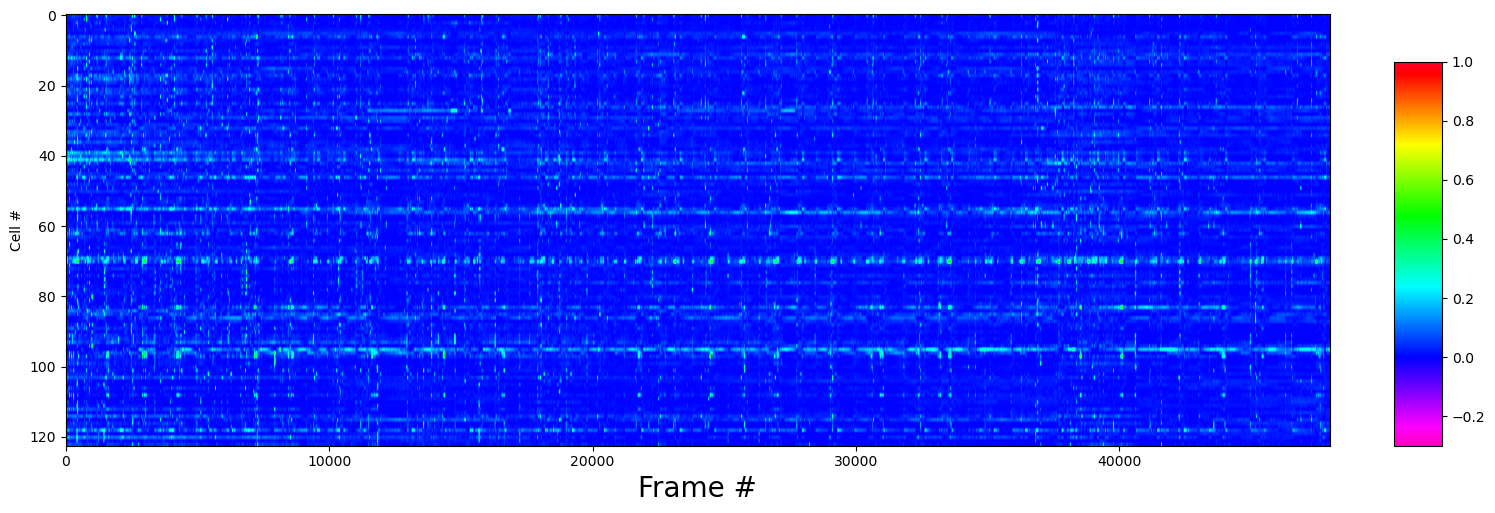

In [80]:
# Plot Scaled Traces,  Full Range (0 to 1), log scale
#TransScaledTraces = np.transpose(Merged_Data.loc[0:len(Merged_Data), CellList_raw])
TransScaledTraces = np.transpose(ReScaled.loc[0:len(Merged_Data), CellList_raw])
#plt_Heat_scaled.imshow(TransScaledTraces, cmap=plt_Heat_scaled.cm.gist_yarg, aspect = 'auto')
plt_raw.imshow(TransScaledTraces, cmap=plt_raw.cm.gist_rainbow_r, aspect = 'auto')
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
plt_raw.xlabel('Frame #', size = 20)
plt_raw.ylabel(('Cell #'), fontdict=None, loc='center')
# Color axis
cax = plt_raw.axes([2.2, 0.1, 0.075, 0.8])
#plt_Heat_scaled.yscale('log')
plt_raw.clim(-0.3, 1)###############################################################  Set Range for Color
plt_raw.colorbar(cax=cax)
plt_raw.show()

99
Figure omitted the first trial


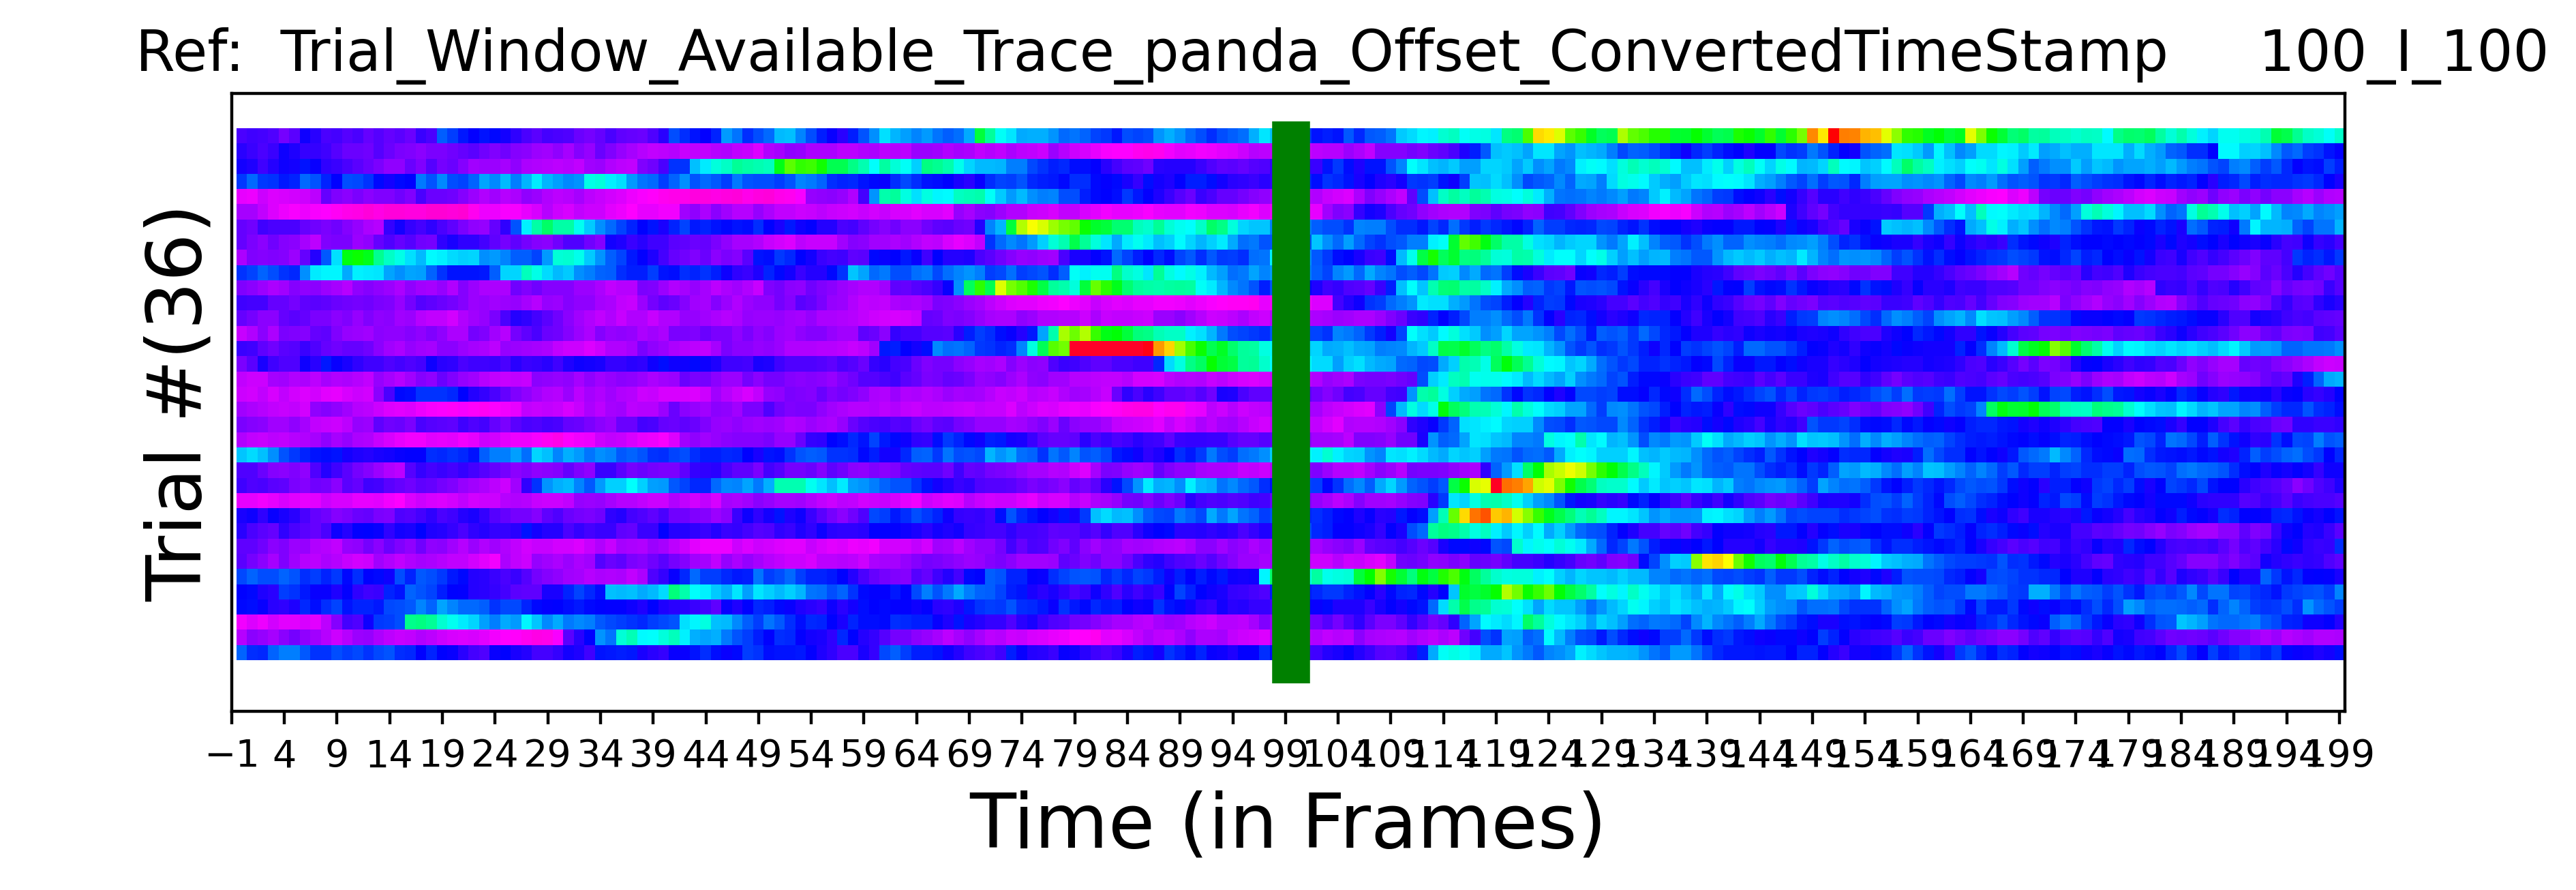

In [81]:
#  Emergency added for resampling Trial_Initiation data to cell length******** Demonstration Purpose



#BinSize = 20  # Unit in frames (20 = 1 seconds (20 frames/second))
WinBegin = 100   #Baseline signal Before Reference Event,  There is a limit in now far back you can go, limited by distance from trial initiation    
WinEnd= 100     # Signal after Reference Event

#Signal= Merged_Data['Mean_of_All_Cells_Rescaled_df'].astype(float)
Signal= Merged_Data['Median_of_All_Cells_Rescaled_df'].astype(float)
#Signal = ReScaled[CellList_raw[0]].astype(float)   # access data under signal label in df dataframe
#Signal = ReScaled[28].astype(float)   # access data under signal label in df dataframe
#Signal = Merged_Data[44].astype(float)   # access data under signal label in df dataframe
ReferenceEvent = 'Trial_Window_Available_Trace_panda_Offset_ConvertedTimeStamp'
#ReferenceEvent = 'Middle_SOL_Trace_panda_Onset_ConvertedTimeStamp'
#ReferenceEvent ='Right_LED_Traces_panda_Onset_ConvertedTimeStamp'


SignalTraces = {}
print(i)
for i in range(1, len(WholeSession_Aligned_Event_Count_TimeStamps[ReferenceEvent])):


    tempt = WholeSession_Aligned_Event_Count_TimeStamps[ReferenceEvent][i]
    Reference_Time = int(tempt[0])  # convert to integer
    
    
    if ((WinBegin + WinEnd) == len(Signal.values[(Reference_Time-WinBegin): (Reference_Time+WinEnd)])):  #full length data, no cutoffs
        SignalTraces.update({('Reference_' + str(i)) :  Signal.values[(Reference_Time-WinBegin): (Reference_Time+WinEnd)]})
    else:
        SignalTraces.update({('Reference_' + str(i)) : Filler_panda })




# Convert dictionary to pandas data frame 

SignalTraces_panda = SignalTraces_pd.DataFrame(SignalTraces)

    ######## Plot Perievent#########
# Plot Scaled Traces,  Full Range (0 to 1), log scale
fig = plt.figure(figsize =(10, 10), dpi = 400.0)
#fig = plt.figure(figsize =(19.2, 10.8), dpi = 400.0)
#fig = plt_perievent_traces.figure()
ax = fig.add_subplot(3,1 ,1)

Perievent_Traces = np.transpose(SignalTraces_panda)
#plt_Heat_scaled.imshow(TransScaledTraces, cmap=plt_Heat_scaled.cm.gist_yarg, aspect = 'auto')
im = plt.imshow(Perievent_Traces, interpolation = 'none',  cmap=plt.cm.gist_rainbow_r, aspect = 'auto')


plt.title('      Ref:  '+ ReferenceEvent + '     ' + str(WinBegin) + '_I_' + str(WinEnd),size = 15)

plt.xlabel('Time (in Frames)', size = 20)
plt.ylabel(('Trial #' + '(' + str(len(WholeSession_Aligned_Event_Count_TimeStamps[ReferenceEvent]))+ ')'), size = 20)


    # Draw Reference Line and 
ax.vlines(x= WinBegin-0.5, ymin=-1, ymax=len(WholeSession_Aligned_Event_Count_TimeStamps[ReferenceEvent]), colors='green', lw=10, label='vline_single - partial height')
plt.xticks(np.arange(-1, (WinBegin +WinEnd +1), 5))
plt.yticks(np.arange(0, len(Event_Count_TimeStamps[ReferenceEvent]), 5.0))

# Color axis
#cax = plt_perievent_traces.axes([2.2, 0.1, 0.075, 0.8])
#plt_Heat_scaled.yscale('log')

#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="3%", pad=0.05)
#plt_perievent_traces.clim(-1000, 3000)###############################################################  Set Range for Color
plt.clim(min(Merged_Data['Median_of_All_Cells_Rescaled_df']), max(Merged_Data['Median_of_All_Cells_Rescaled_df'])*0.6)###############################################################  Set Range for Color
#plt.clim(min(Merged_Data['Mean_of_All_Cells_Rescaled_df']), max(Merged_Data['Mean_of_All_Cells_Rescaled_df']))#########################
plt.colorbar(im, cax=cax)


print('Figure omitted the first trial') 

In [82]:
WholeSession_Aligned_Event_Count_TimeStamps['Left_LED_Traces_panda_Onset_ConvertedTimeStamp']

[[78],
 [1491],
 [2849],
 [4160],
 [7113],
 [8518],
 [11559],
 [14277],
 [16311],
 [21632],
 [24095],
 [25625],
 [26947],
 [30396],
 [33453],
 [39944],
 [43649],
 [45314]]

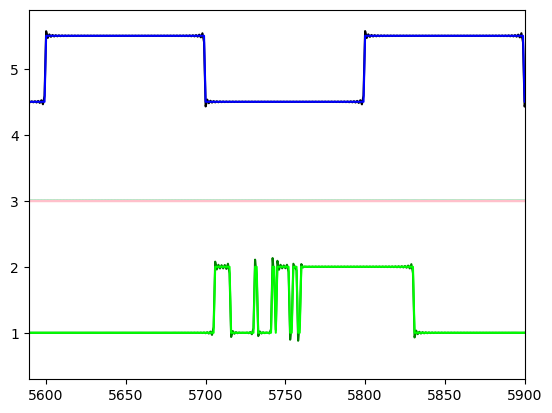

In [83]:
plt.plot(WholeSession_Arduino_Aligned_TimeStamp['Arduino_5S_Pulse_panda']+4.5,'k')
plt.plot(Binary_WholeSession_Arduino_Aligned_TimeStamp['Arduino_5S_Pulse_panda']+4.5,'b')

plt.plot(WholeSession_Arduino_Aligned_TimeStamp['Left_LED_Traces_panda']+3,'orange')
plt.plot(Binary_WholeSession_Arduino_Aligned_TimeStamp['Left_LED_Traces_panda']+3,'r')



plt.plot(WholeSession_Arduino_Aligned_TimeStamp['Trial_Window_Available_Trace_panda']+3,'cyan')
plt.plot(Binary_WholeSession_Arduino_Aligned_TimeStamp['Trial_Window_Available_Trace_panda']+3,'pink')

plt.plot(WholeSession_Arduino_Aligned_TimeStamp['ALL_IR_Traces_panda']+1,'green')
plt.plot(Binary_WholeSession_Arduino_Aligned_TimeStamp['ALL_IR_Traces_panda']+1,'lime')

plt.xlim(5589, 5900)
#plt.xlim(5700, 5725)
#plt.xlim(5600, 5800)
#plt.xlim(5089, 6500)
#plt.xlim(5800, 5825)
plt.show()

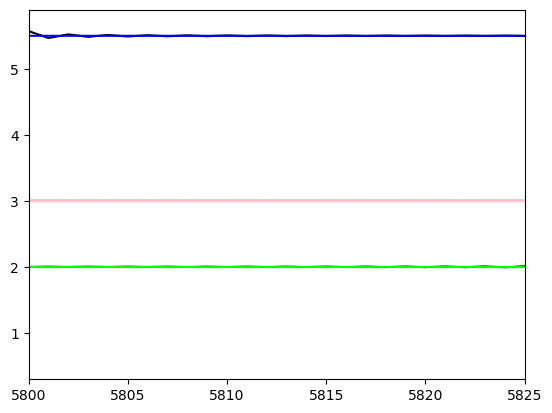

In [84]:
# print(Binary_WholeSession_Arduino_Aligned_TimeStamp.keys())
# print(len(WholeSession_Arduino_Aligned_TimeStamp))
# print(WholeSession_Arduino_Aligned_TimeStamp[Arduino_Aligned_TimeStamp.keys()])


plt.plot(WholeSession_Arduino_Aligned_TimeStamp['Arduino_5S_Pulse_panda']+4.5,'k')
plt.plot(Binary_WholeSession_Arduino_Aligned_TimeStamp['Arduino_5S_Pulse_panda']+4.5,'b')

plt.plot(WholeSession_Arduino_Aligned_TimeStamp['Left_LED_Traces_panda']+3,'orange')
plt.plot(Binary_WholeSession_Arduino_Aligned_TimeStamp['Left_LED_Traces_panda']+3,'r')



plt.plot(WholeSession_Arduino_Aligned_TimeStamp['Trial_Window_Available_Trace_panda']+3,'cyan')
plt.plot(Binary_WholeSession_Arduino_Aligned_TimeStamp['Trial_Window_Available_Trace_panda']+3,'pink')

plt.plot(WholeSession_Arduino_Aligned_TimeStamp['ALL_IR_Traces_panda']+1,'green')
plt.plot(Binary_WholeSession_Arduino_Aligned_TimeStamp['ALL_IR_Traces_panda']+1,'lime')

# plt.xlim(5589, 5900)
# plt.xlim(5700, 5725)
#plt.xlim(5600, 5800)
#plt.xlim(5089, 6500)
plt.xlim(5800, 5825)
plt.show()

In [85]:
Time_Stamp_to_write = 'Trial_Window_End'
Position = (Final_Aligned_TimeStamp[Time_Stamp_to_write])
print(Position)
print(len(Position))

[[78], [1491], [2849], [4160], [5300], [6177], [7113], [8518], [9408], [10400], [11559], [12973], [14277], [15098], [16311], [17930], [19001], [20167], [21632], [23061], [24095], [25625], [26947], [27719], [29091], [30396], [32425], [33453], [35060], [36242], [37700], [39027], [39944], [41222], [43649], [45314]]
36


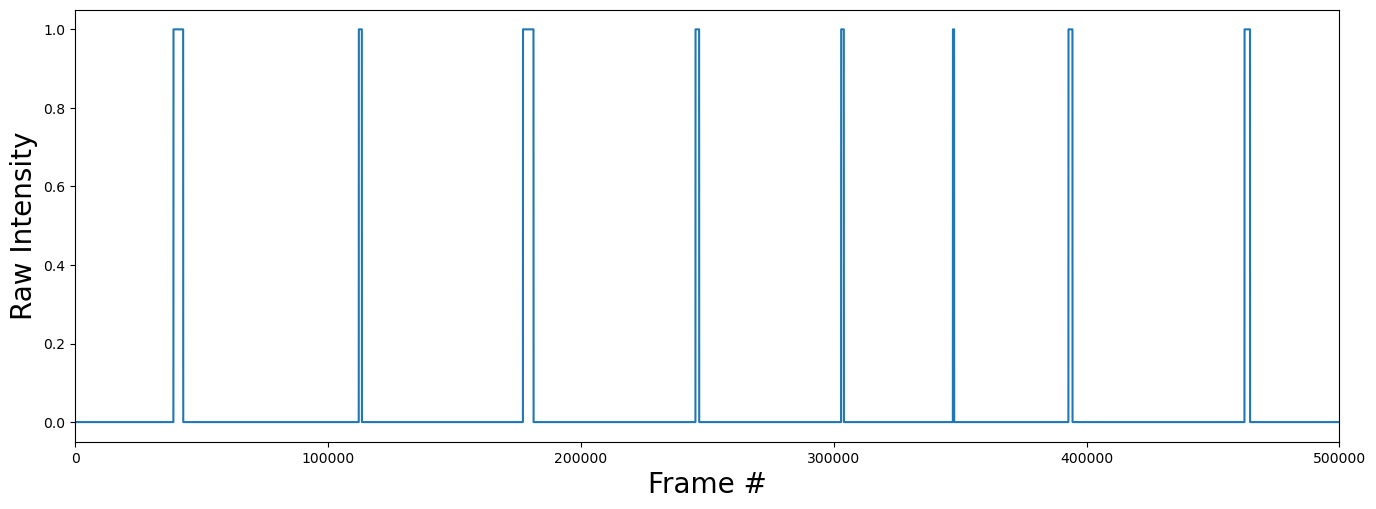

Index(['Trial_Window_Available_Trace_panda', 'Left_IR_Traces_panda',
       'Middle_IR_Traces_panda', 'Right_IR_Traces_panda',
       'ALL_IR_Traces_panda', 'Middle_SOL_Trace_panda',
       'Left_LED_Traces_panda', 'Right_LED_Traces_panda',
       'All_LED_Onset_Traces_panda', 'Incorrect_All_Trace_panda',
       'Omission_All_Trace_panda', 'Reward_Window_Trace_panda',
       'Arduino_5S_Pulse_panda'],
      dtype='object')


In [86]:
plt_raw.plot(Arduino_df['Trial_Window_Available_Trace_panda'])
# plt_raw.plot(Arduino_df[list(Arduino_df.keys())[x]])
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
plt_raw.ylabel('Raw Intensity', size = 20)
plt_raw.xlabel('Frame #', size = 20)
plt_raw.xlim(0, 500000)
plt_raw.show()


print(Arduino_df.keys())

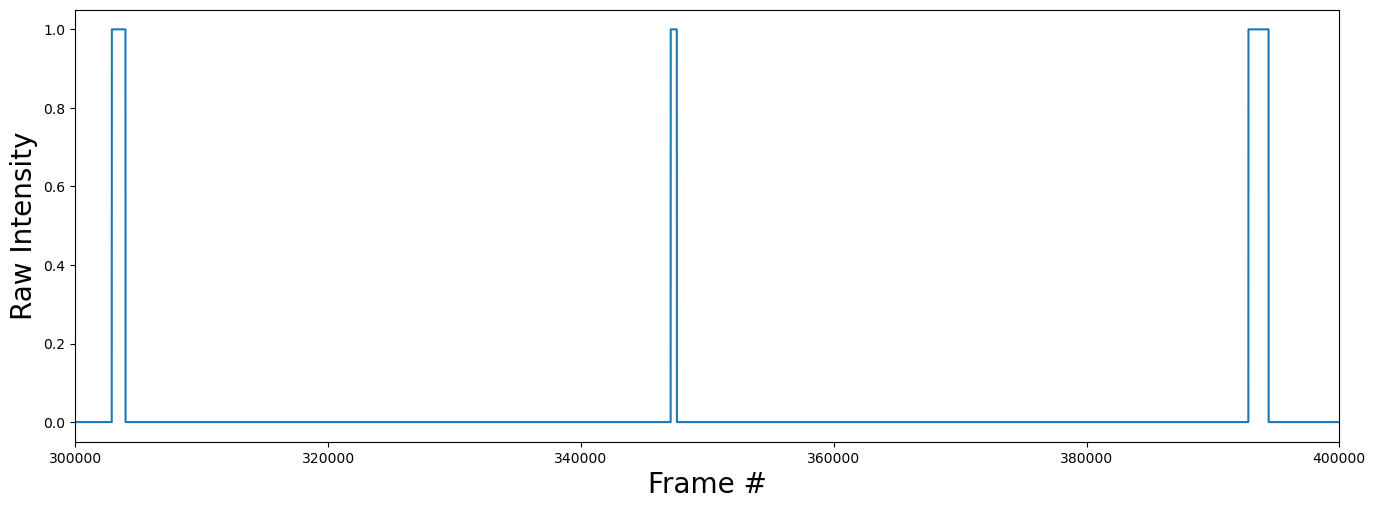

In [87]:
plt_raw.plot(Arduino_df['Trial_Window_Available_Trace_panda'])
# plt_raw.plot(Arduino_df[list(Arduino_df.keys())[x]])
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
plt_raw.ylabel('Raw Intensity', size = 20)
plt_raw.xlabel('Frame #', size = 20)
plt_raw.xlim(300000, 400000)
plt_raw.show()



In [88]:
# 'Trial_Initi_Wind_Start-5521': 48, 'Trial_Initi_Wind_End-5520': 48, 
print(Event_Count_TimeStamps['Trial_Initi_Wind_Start-5521'])

print('\n')
print(Event_Count_TimeStamps['Trial_Initi_Wind_End-5520'])

['38762', '112082', '177021', '245264', '302876', '347092', '392798', '462441', '505181', '557416', '614404', '683586', '752186', '792639', '847382', '907572', '987220', '1046361', '1118454', '1190476', '1242776', '1318545', '1384936', '1424348', '1492986', '1556120', '1649804', '1710632', '1779046', '1848326', '1906417', '1986115', '2035344', '2098764', '2140775', '2219520', '2302179', '2374403']


['42619', '113303', '181201', '246719', '303961', '347581', '394396', '464632', '509120', '558881', '616677', '687366', '752583', '793620', '854274', '935255', '988803', '1047099', '1120320', '1191771', '1243549', '1320018', '1386112', '1424729', '1493335', '1558575', '1660053', '1711422', '1791789', '1850867', '1923800', '1990133', '2036000', '2099861', '2151352', '2221258', '2304503', '2375397']


In [89]:
# print("Trial Initiation win duration")


# for i in range(len(Event_Count_TimeStamps['Trial_Initi_Wind_Start-5521'])):

#     tempa = int(Event_Count_TimeStamps['Trial_Initi_Wind_Start-5521'][i])
#     tempb = int(Event_Count_TimeStamps['Trial_Initi_Wind_End-5520'][i])
#     tempc = (tempb-tempa)/1000

#     print(tempc)

# print('\n')
# print(i)





In [90]:

print('Interval between Trials' )


for i in range(len(Event_Count_TimeStamps['Trial_Initi_Wind_Start-5521'])-1):

    tempa = int(Event_Count_TimeStamps['Trial_Initi_Wind_Start-5521'][i])
    tempb = int(Event_Count_TimeStamps['Trial_Initi_Wind_Start-5521'][i+1])
    tempc = (tempb-tempa)/1000

    print(tempc)

print('\n')
print(i)
print('\n')

Interval between Trials
73.32
64.939
68.243
57.612
44.216
45.706
69.643
42.74
52.235
56.988
69.182
68.6
40.453
54.743
60.19
79.648
59.141
72.093
72.022
52.3
75.769
66.391
39.412
68.638
63.134
93.684
60.828
68.414
69.28
58.091
79.698
49.229
63.42
42.011
78.745
82.659
72.224


36




In [91]:
# LED on duration by trial

# print(WholeSession_Aligned_Event_Count_TimeStamps['Left_LED_Traces_panda_Onset_ConvertedTimeStamp'])

# print('\n')
# print(WholeSession_Aligned_Event_Count_TimeStamps['Left_LED_Traces_panda_Offset_ConvertedTimeStamp'])


# print('\n')
# print('\n')
# print(WholeSession_Aligned_Event_Count_TimeStamps['Right_LED_Traces_panda_Onset_ConvertedTimeStamp'])

# print('\n')
# print(WholeSession_Aligned_Event_Count_TimeStamps['Right_LED_Traces_panda_Offset_ConvertedTimeStamp'])


Led_Onset = []
for i in range(WholeSession_Aligned_Event_Count['Left_LED_Traces_panda_Onset_ConvertedTimeStamp']):
    Led_Onset.append((WholeSession_Aligned_Event_Count_TimeStamps['Left_LED_Traces_panda_Onset_ConvertedTimeStamp'][i]))
for i in range(WholeSession_Aligned_Event_Count['Right_LED_Traces_panda_Onset_ConvertedTimeStamp']):
    Led_Onset.append((WholeSession_Aligned_Event_Count_TimeStamps['Right_LED_Traces_panda_Onset_ConvertedTimeStamp'][i]))
Led_Onset.sort()


Led_Offset = []
for i in range(WholeSession_Aligned_Event_Count['Left_LED_Traces_panda_Offset_ConvertedTimeStamp']):
    Led_Offset.append((WholeSession_Aligned_Event_Count_TimeStamps['Left_LED_Traces_panda_Offset_ConvertedTimeStamp'][i]))
for i in range(WholeSession_Aligned_Event_Count['Right_LED_Traces_panda_Offset_ConvertedTimeStamp']):
    Led_Offset.append((WholeSession_Aligned_Event_Count_TimeStamps['Right_LED_Traces_panda_Offset_ConvertedTimeStamp'][i]))
Led_Offset.sort()


print(Led_Onset)
print('\n')
print(Led_Offset)

print('LED duration by Trials' )


for i in range(len(Led_Onset)):

    tempa= Led_Onset[i]
    tempa= int(''.join(map(str, tempa)))


    tempb= Led_Offset[i]
    tempb= int(''.join(map(str, tempb)))

    tempc = (tempb-tempa)

    print(tempc)

print('\n')
print(i)
print('\n')

[[78], [1491], [2849], [4160], [5300], [6177], [7113], [8518], [9408], [10400], [11559], [12973], [14277], [15098], [16311], [17930], [19001], [20167], [21632], [23061], [24095], [25625], [26947], [27719], [29091], [30396], [32425], [33453], [35060], [36242], [37700], [39027], [39944], [41222], [43649], [45314]]


[[467], [1606], [3051], [4483], [5427], [6281], [7314], [8629], [9514], [10513], [11837], [13109], [14378], [15313], [16637], [18170], [19192], [20394], [21835], [23281], [24595], [25763], [27051], [27924], [29267], [31020], [32577], [33605], [35191], [36299], [37787], [39131], [40120], [41380], [44008], [45452]]
LED duration by Trials
389
115
202
323
127
104
201
111
106
113
278
136
101
215
326
240
191
227
203
220
500
138
104
205
176
624
152
152
131
57
87
104
176
158
359
138


35




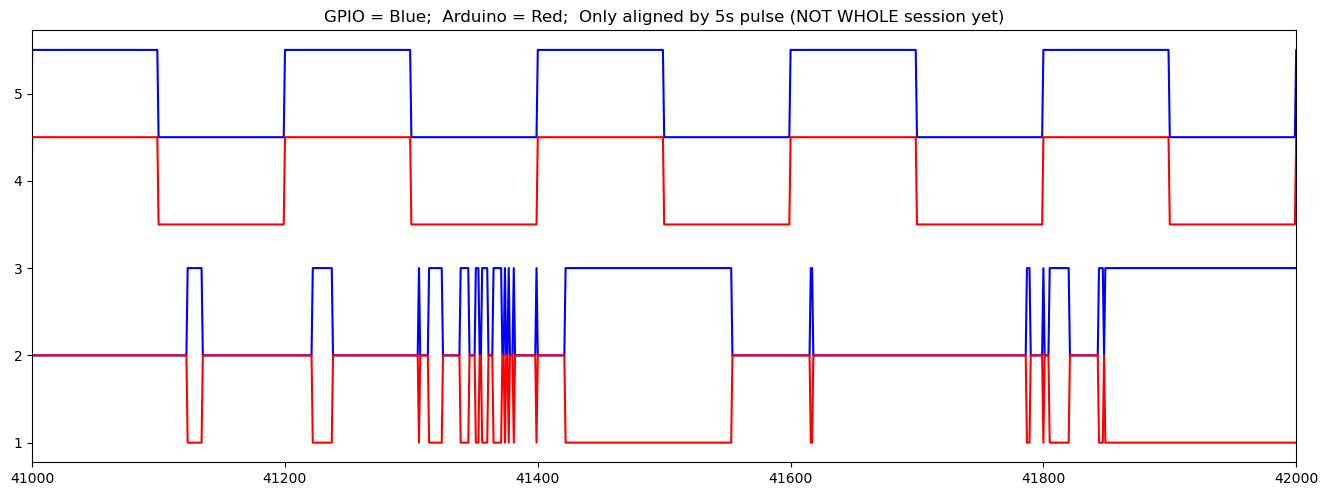

In [92]:
# Plotting data that was only aligned with 5s pulse (not whole session align because GPIO was never whole session align)
# But all should be the same length

plt.subplots_adjust(bottom=0.1, right=2.1, top=1)

plt.plot(BinaryGPIO_Aligned_TimeStamp['GPIO_5S_Pulse_panda']+4.5, 'b')
plt.plot(BinaryArduino_Aligned_TimeStamp['Arduino_5S_Pulse_panda']+3.5, 'r') 

plt.plot(BinaryGPIO_Aligned_TimeStamp['GPIO_IR_Pulse_panda']+2,'b')
plt.plot(BinaryArduino_Aligned_TimeStamp['ALL_IR_Traces_panda']*(-1)+2, 'r')

#plt.xlim(0, len(BinaryGPIO_Aligned_TimeStamp)/2)
#plt.xlim(len(BinaryGPIO_Aligned_TimeStamp)*3/4, len(BinaryGPIO_Aligned_TimeStamp))
#plt.xlim(36000, 38000)

plt.xlim(41000, 42000)
plt.title('GPIO = Blue;  Arduino = Red;  Only aligned by 5s pulse (NOT WHOLE session yet)')
plt.show()



In [93]:
print('Len of Cell:', len(df_cal))
print('GPIO_BNC_count (Whole Session):',GPIO_BNC_count )
print('GPIO_Corrected_FramesImaged (After Removing Inital GPIO pulses that beloged to other files ): ', GPIO_Corrected_FramesImaged)

if(len(df_cal)!=GPIO_BNC_count):
    print('The number of frames in Imaging_Tiff_File is not equal to the number of frames in GPIO ')
    print('\nThere might be a mismatch data file ')
    a = 8/0  # just to stop the program here

Len of Cell: 47999
GPIO_BNC_count (Whole Session): 47999
GPIO_Corrected_FramesImaged (After Removing Inital GPIO pulses that beloged to other files ):  47999


/Users/kang/Desktop/Alignment/Session-20230424-180728-Ka-DS12-RR10-S2-Sucrose.csv
   Time (s)        Channel Name   Value  value_binary
0     0.000   BNC Trigger Input     0.0             0
1    18.645   BNC Trigger Input     1.0             1
2  2416.831   BNC Trigger Input     0.0             0
3  2430.999   BNC Trigger Input     0.0             0


Index    Onset     Offset   Duration   Frames  Choosen
0    1.0  18645.0  2416831.0  2398186.0  47999.0      1.0
1    NaN      NaN  2430999.0        NaN      NaN      0.0
2    NaN      NaN        NaN        NaN      NaN      0.0
3    NaN      NaN        NaN        NaN      NaN      0.0
4    NaN      NaN        NaN        NaN      NaN      0.0

GPIO_Image_Begin 18645.0
GPIO_Image_End 2416831.0


CAIMAN Image Duration:  
39.99916666666666


In an ideal world,There should be EXACTLY 480 pulse,  Data length would be close to 48000
length of cell (raw) 47999
length of cell (deconv) 47999
length of cell (raw_transposed) 47999
Total Frame (GPIO):   47999
GPIO_Corrected_FramesImaged (After Removing Inital GPIO pulses that beloged to other files ):  47999


Median Duration of 5s pulse in Frames:    4999.0
Maximum 4999
Minimum 4999
Actual number of 5s pulse:    480


Trial_Window_Start 36
Trial_Window_End 36
M_Sol_ON 36
L_LED_ON 18
R_LED_ON 18
L_LED_OFF 18
R_LED_OFF 18
L_Poke_IN 335
L_Poke_OUT 335
M_Poke_IN 187
M_Poke_OUT 187
R_Poke_IN 217
R_Poke_OUT 217
Incorrect_Trial 0
Omission_Trial 0


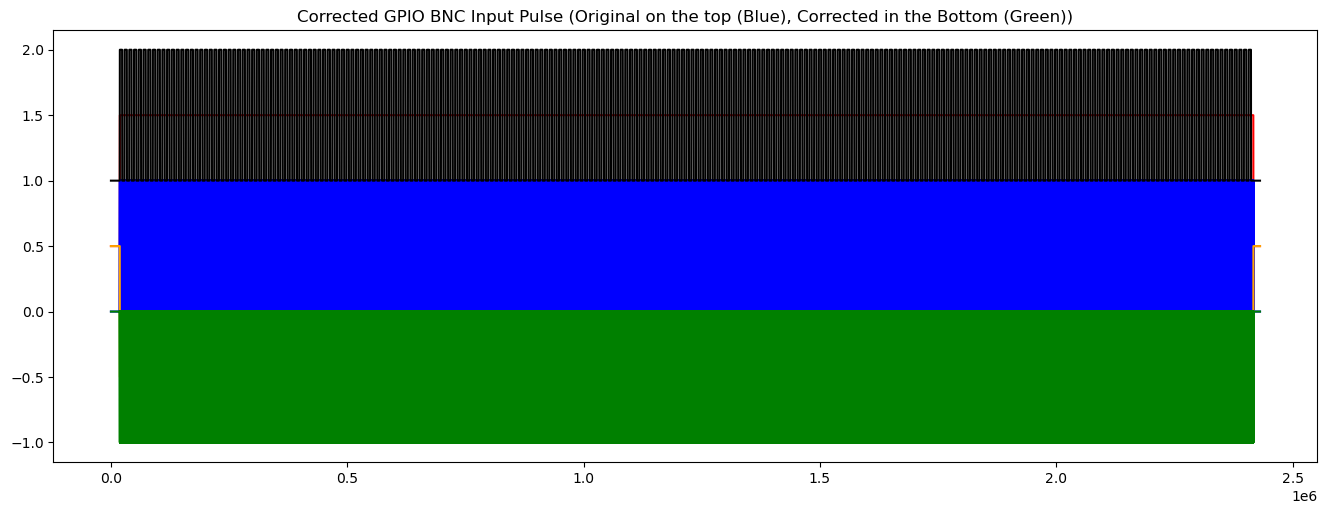

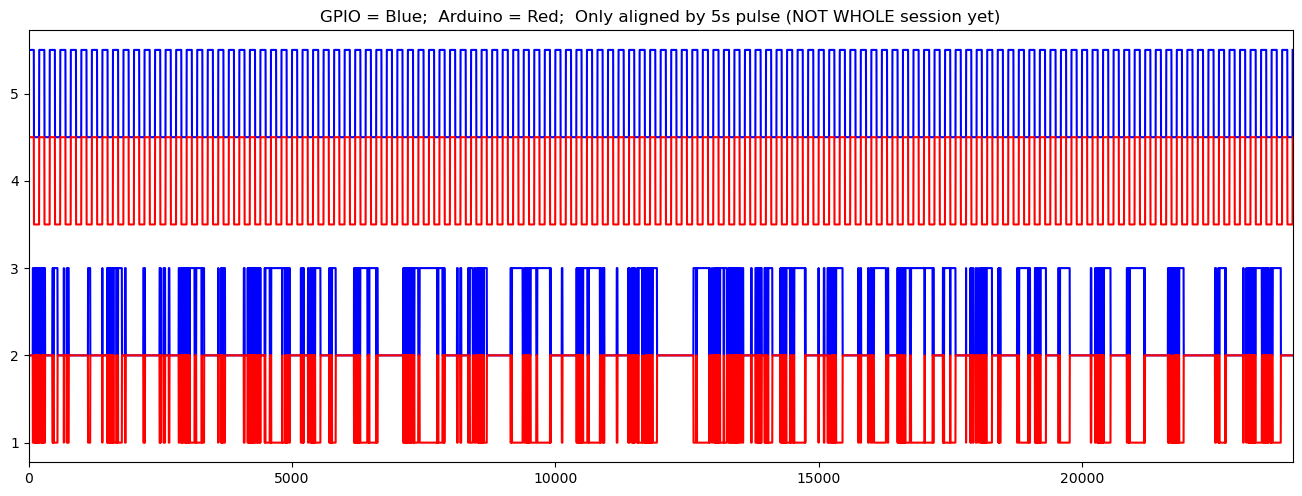

/var/folders/2c/qcjtsn_j1xngx_g__j1y_rn00000gn/T/ipykernel_16470/2851980646.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gpio_1_full['value_binary']= Corrected_Binary


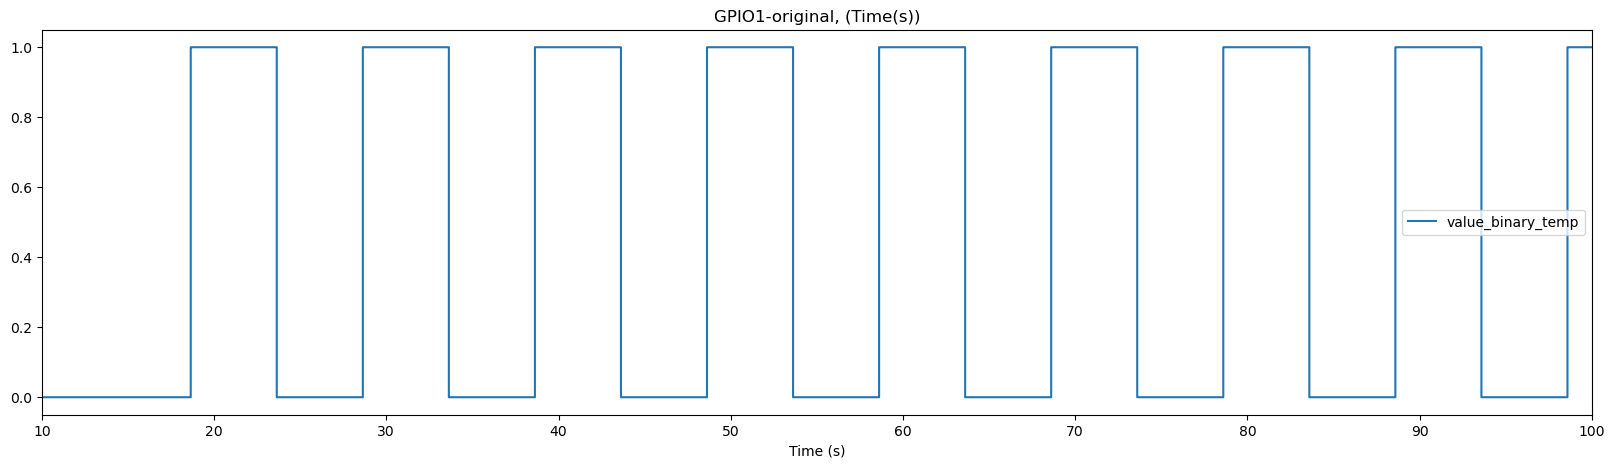

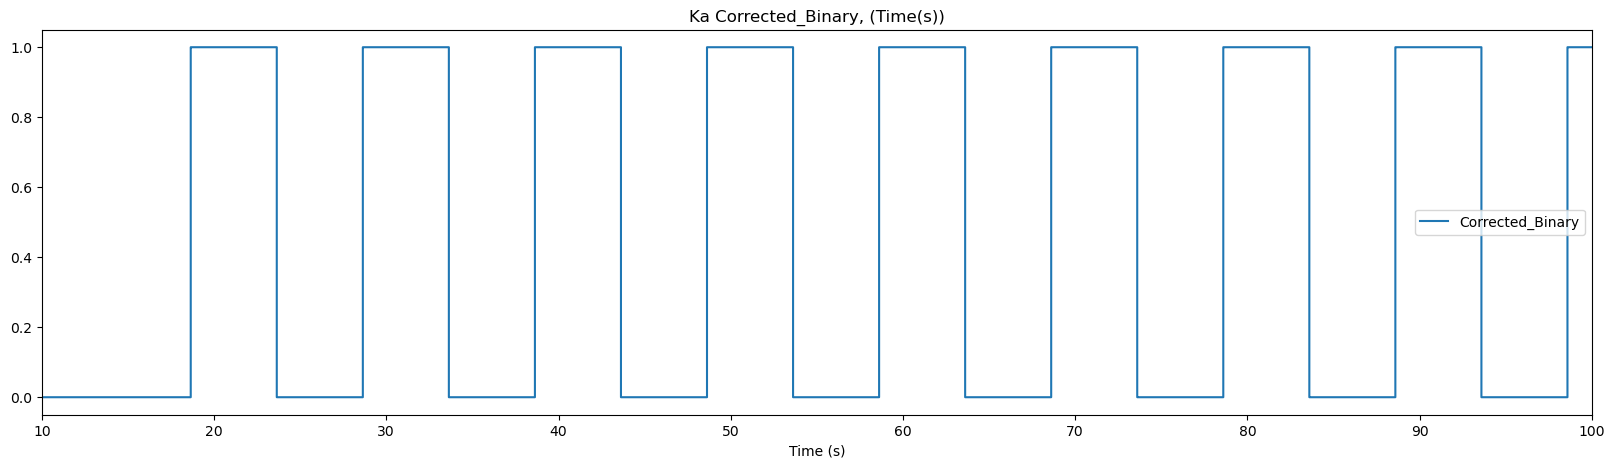

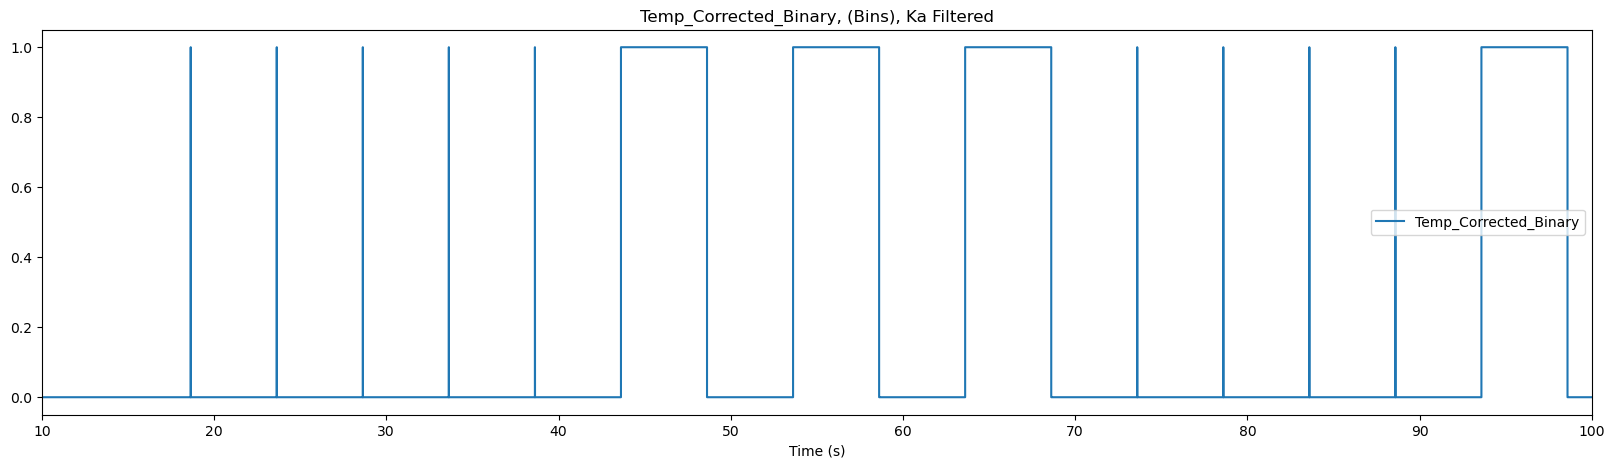

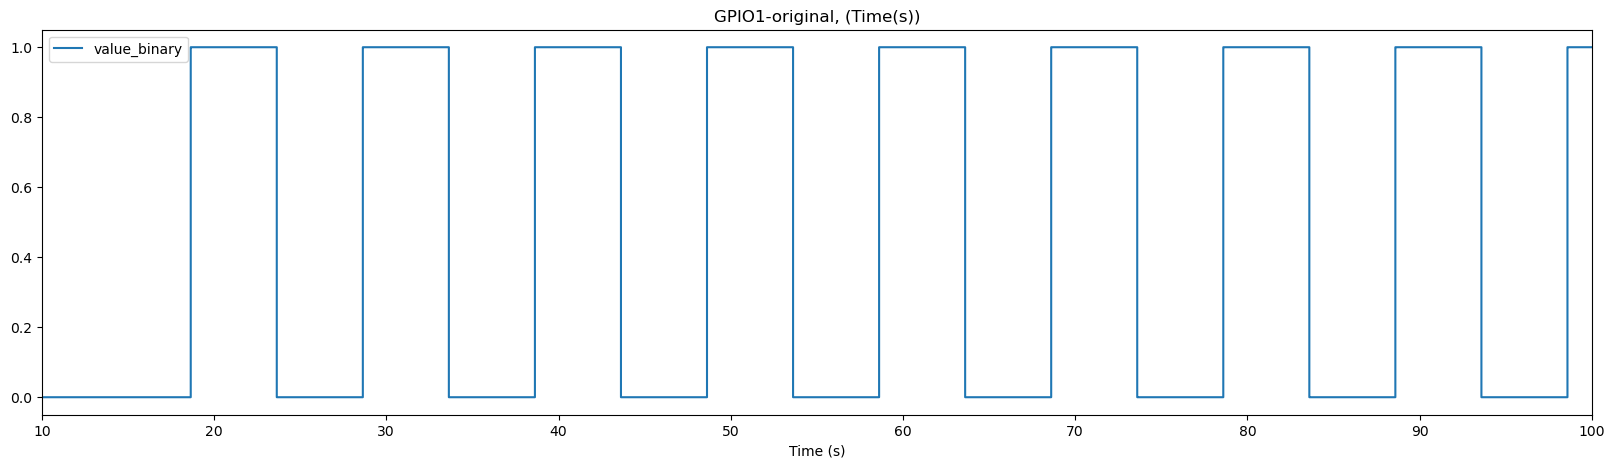

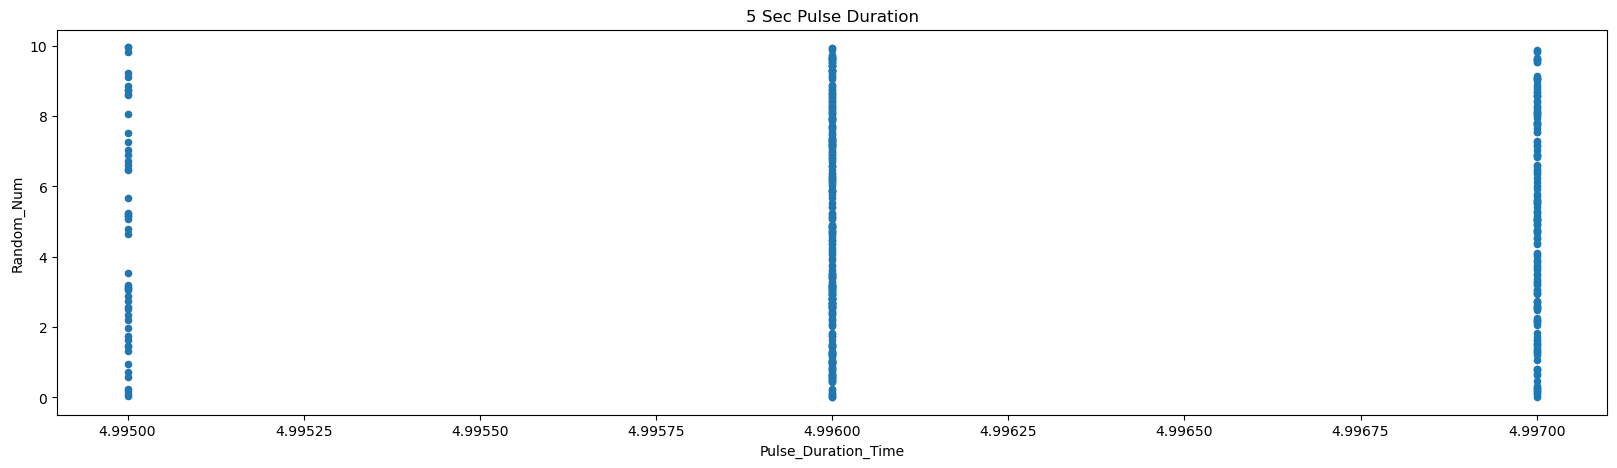

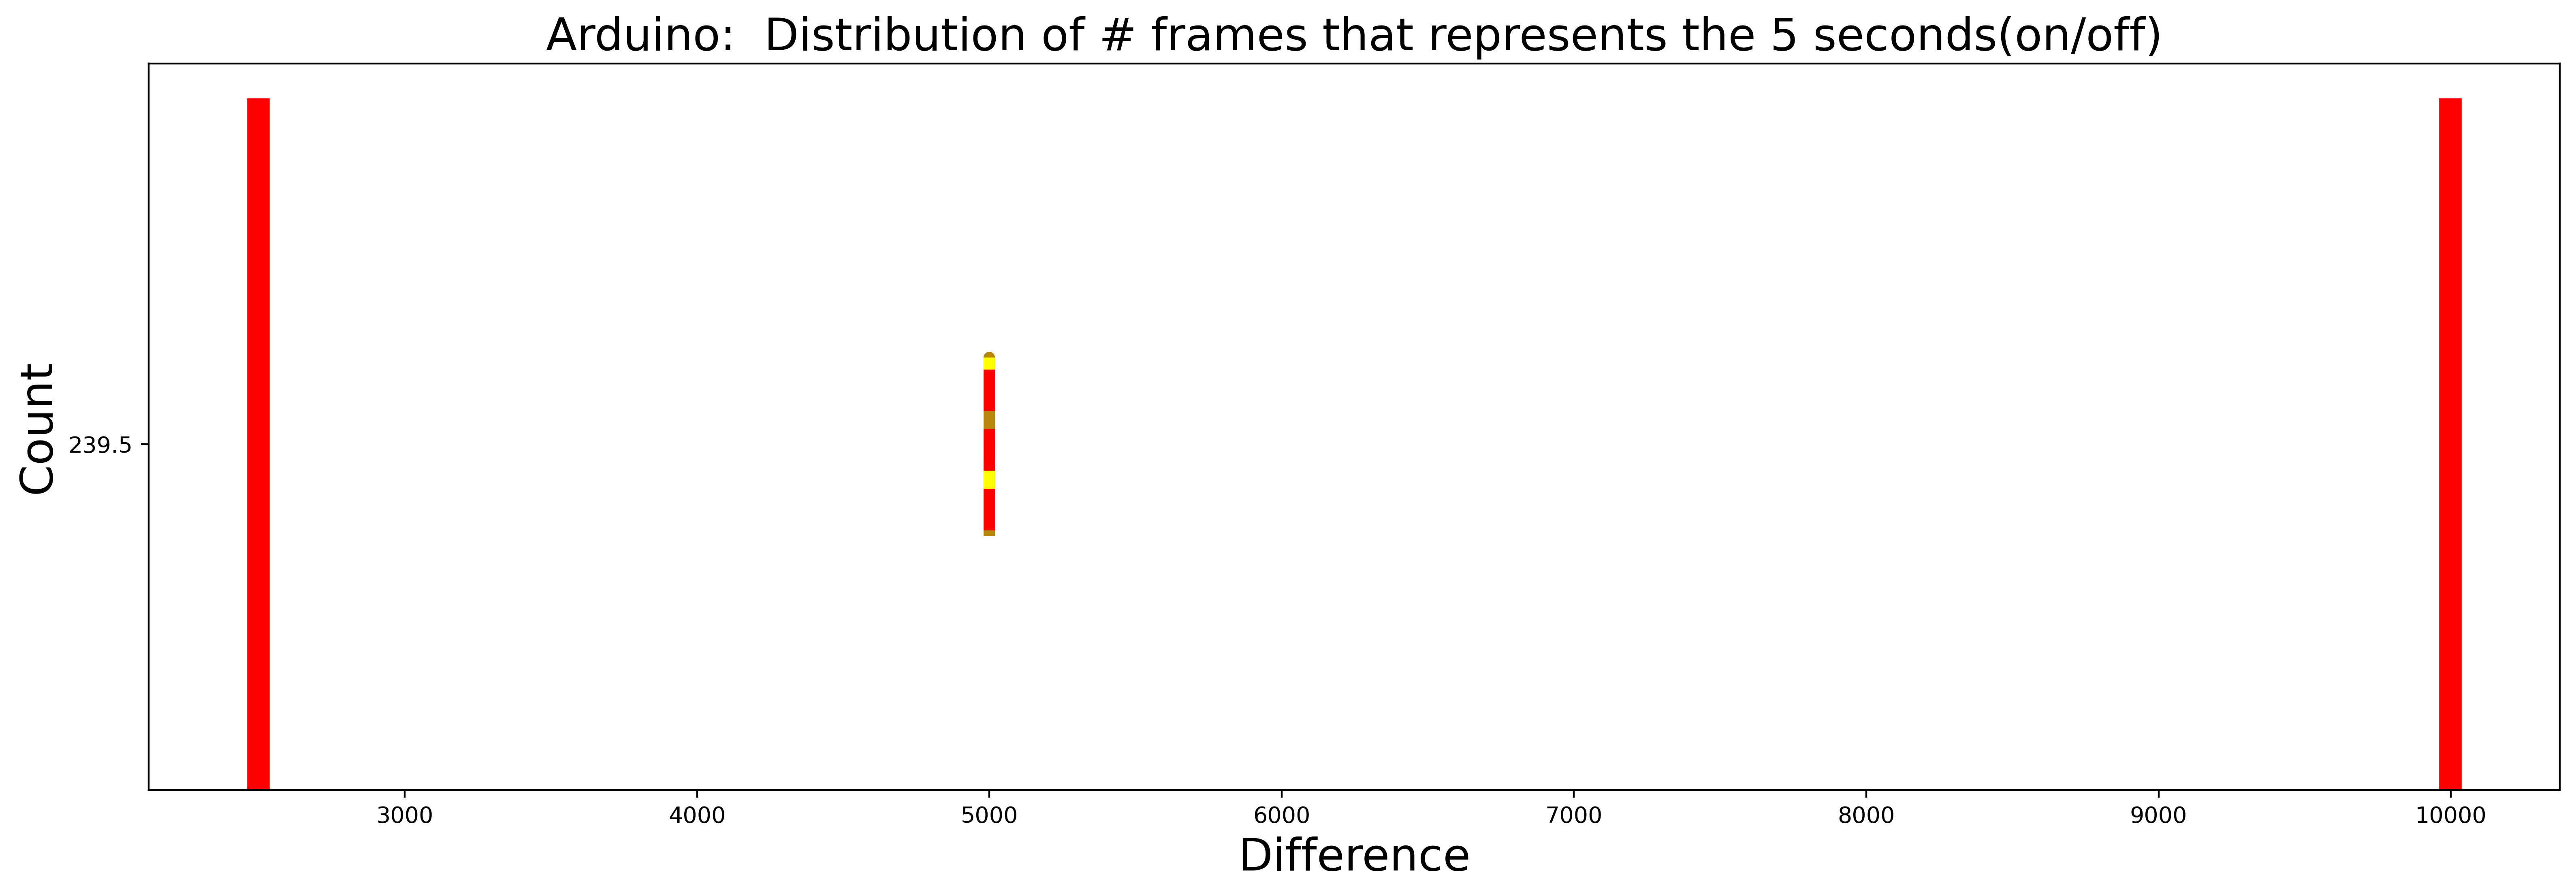

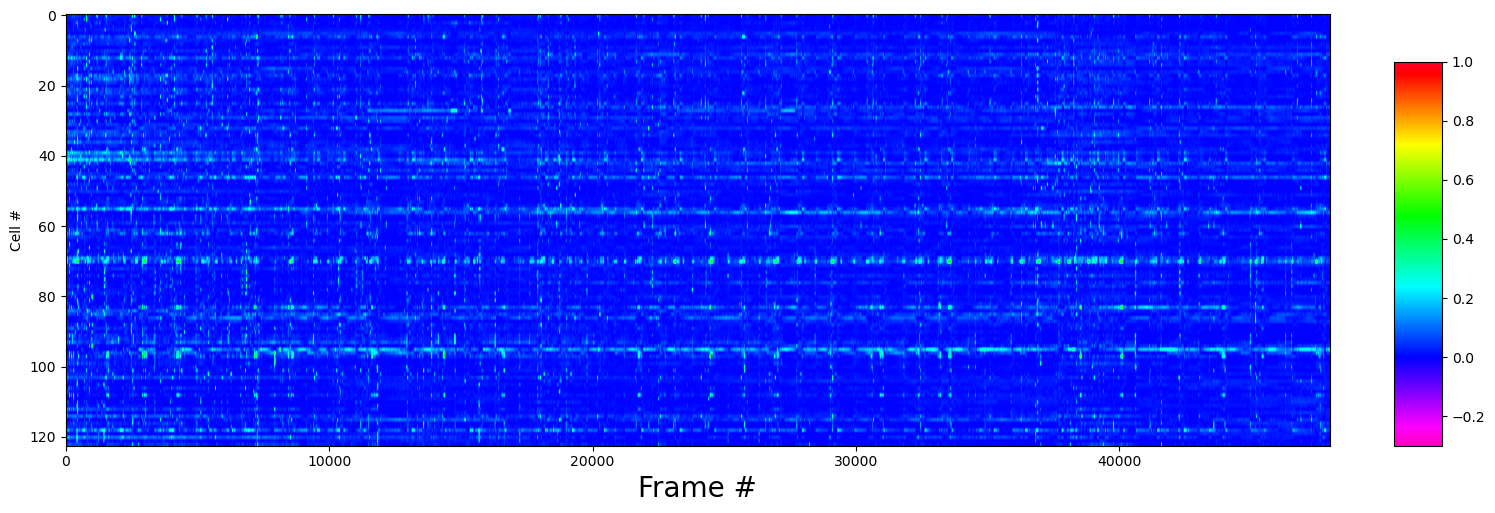



Median of all cells


14
Figure omitted the first trial


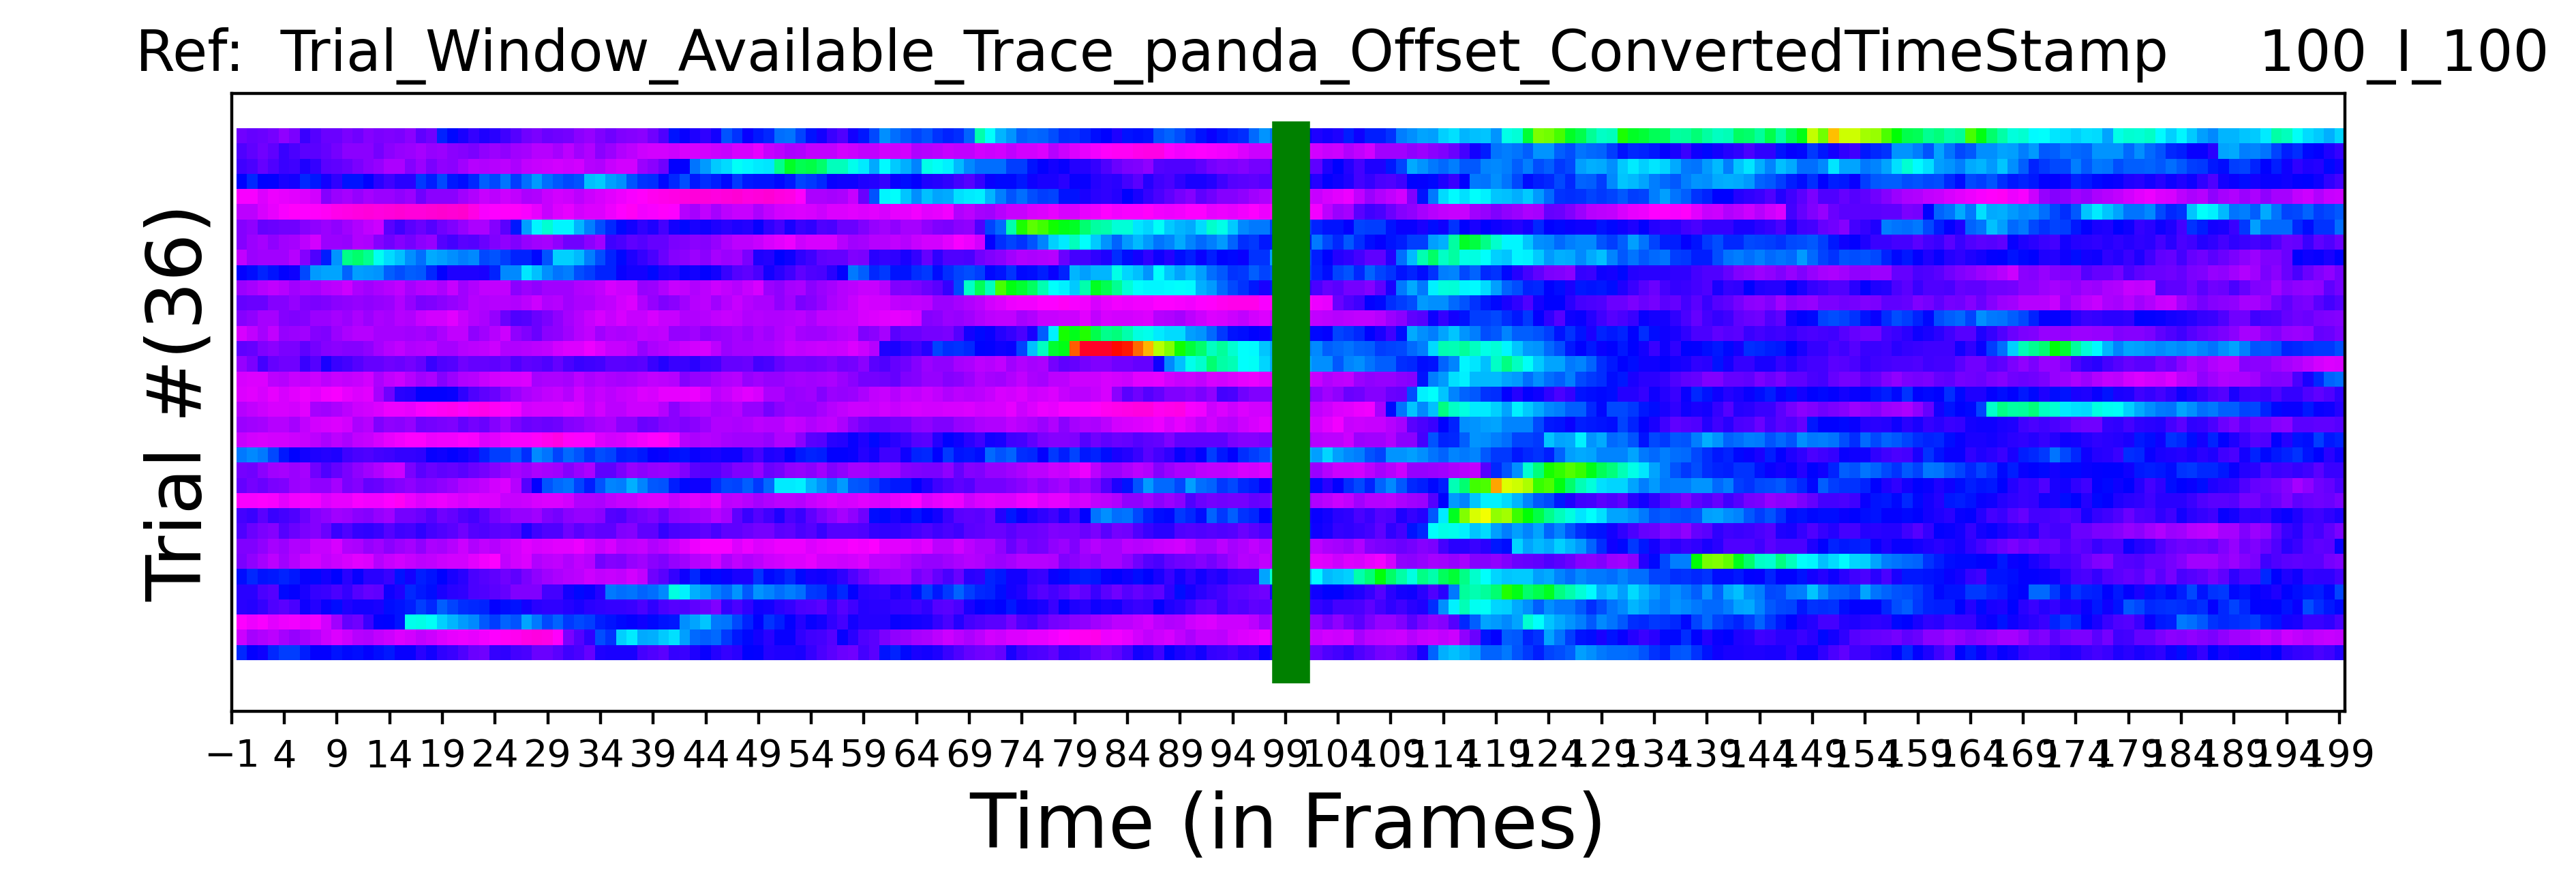

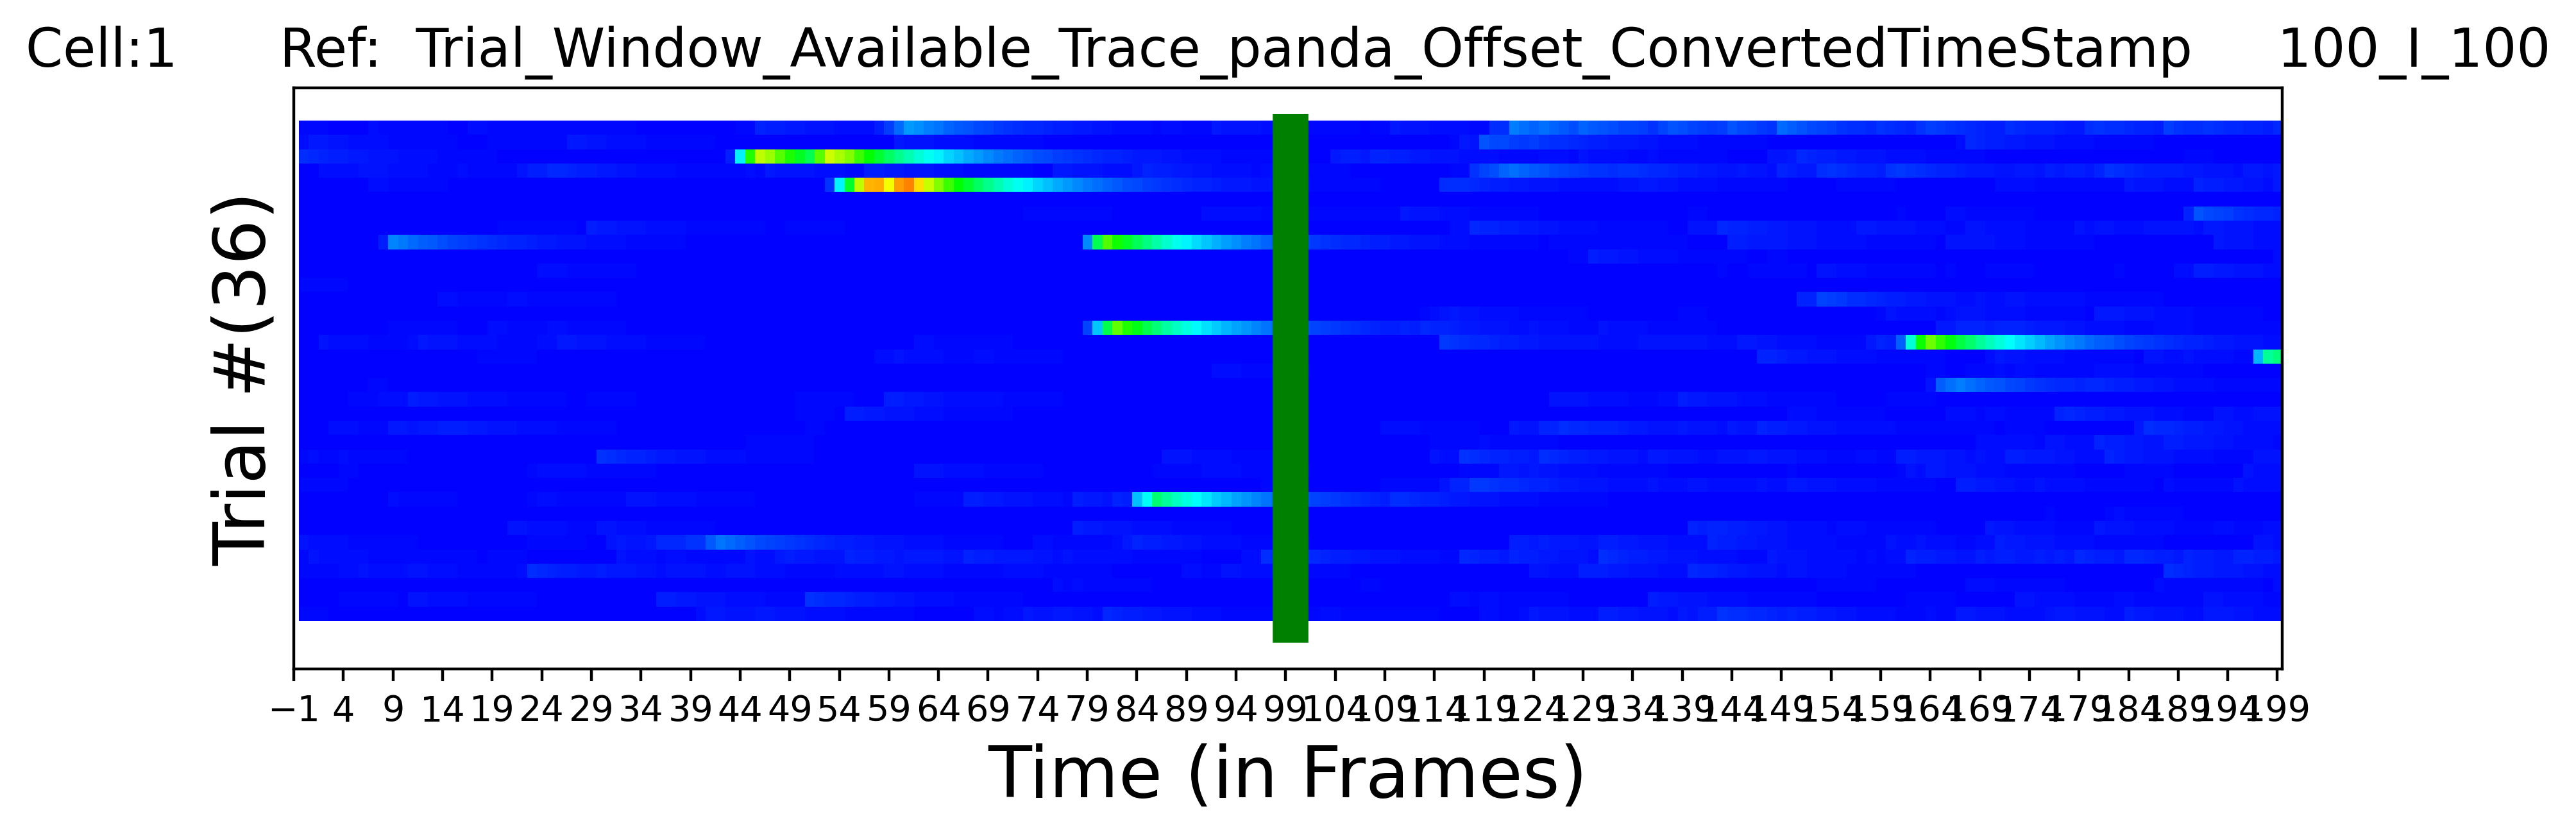

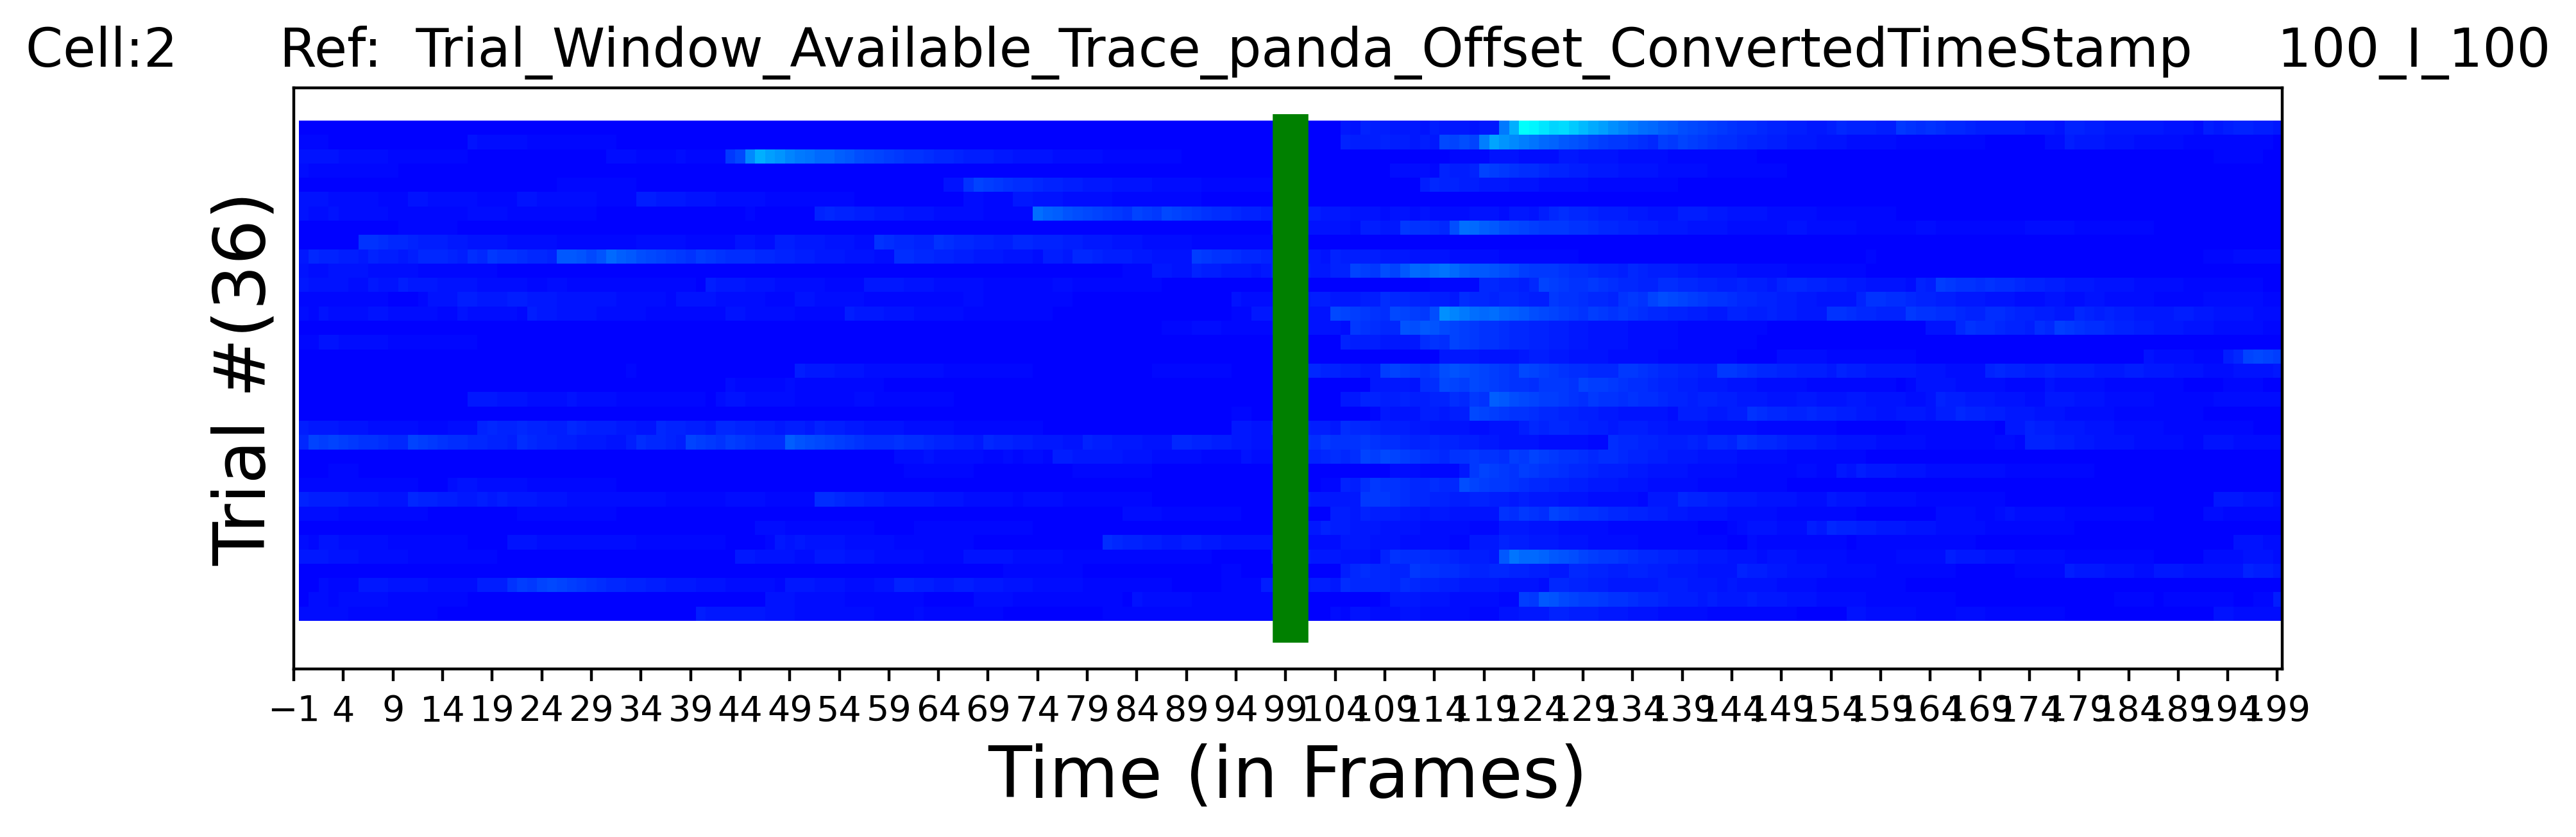

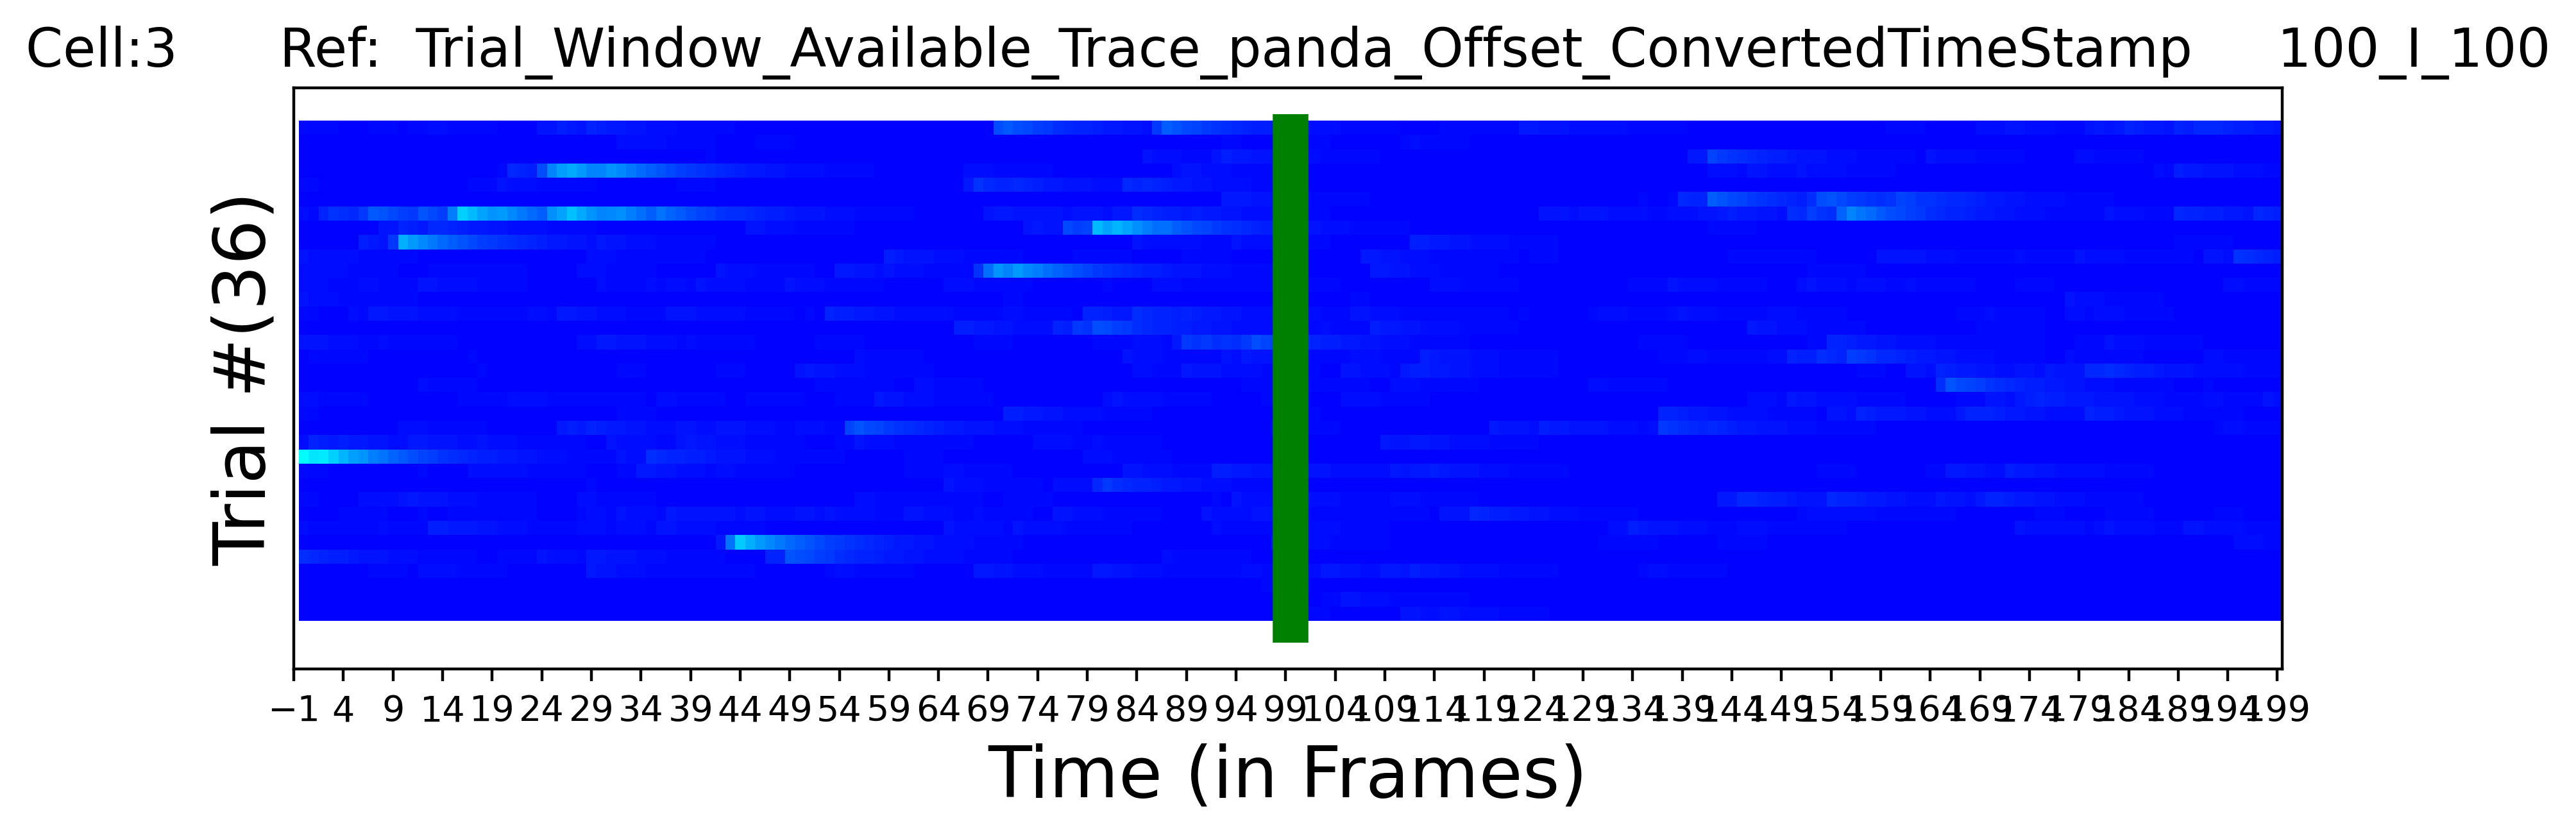

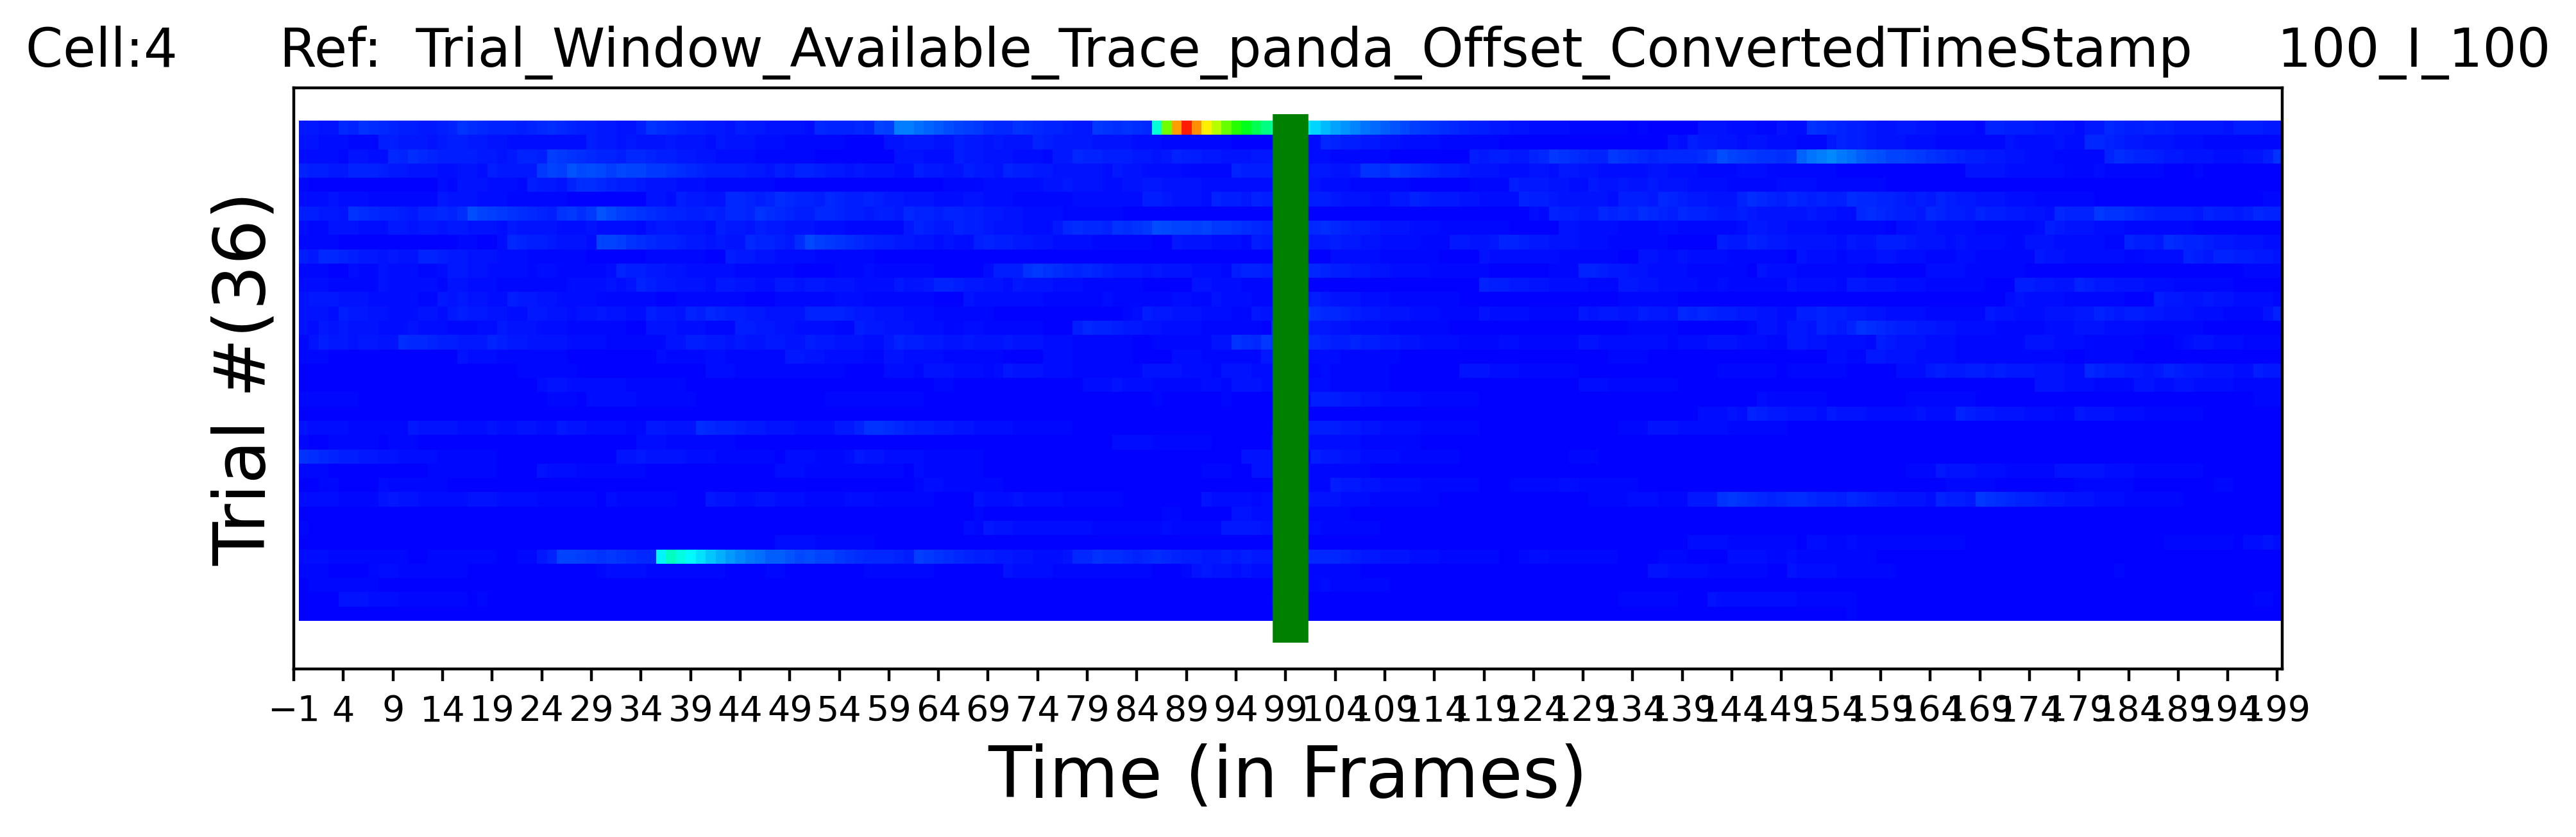

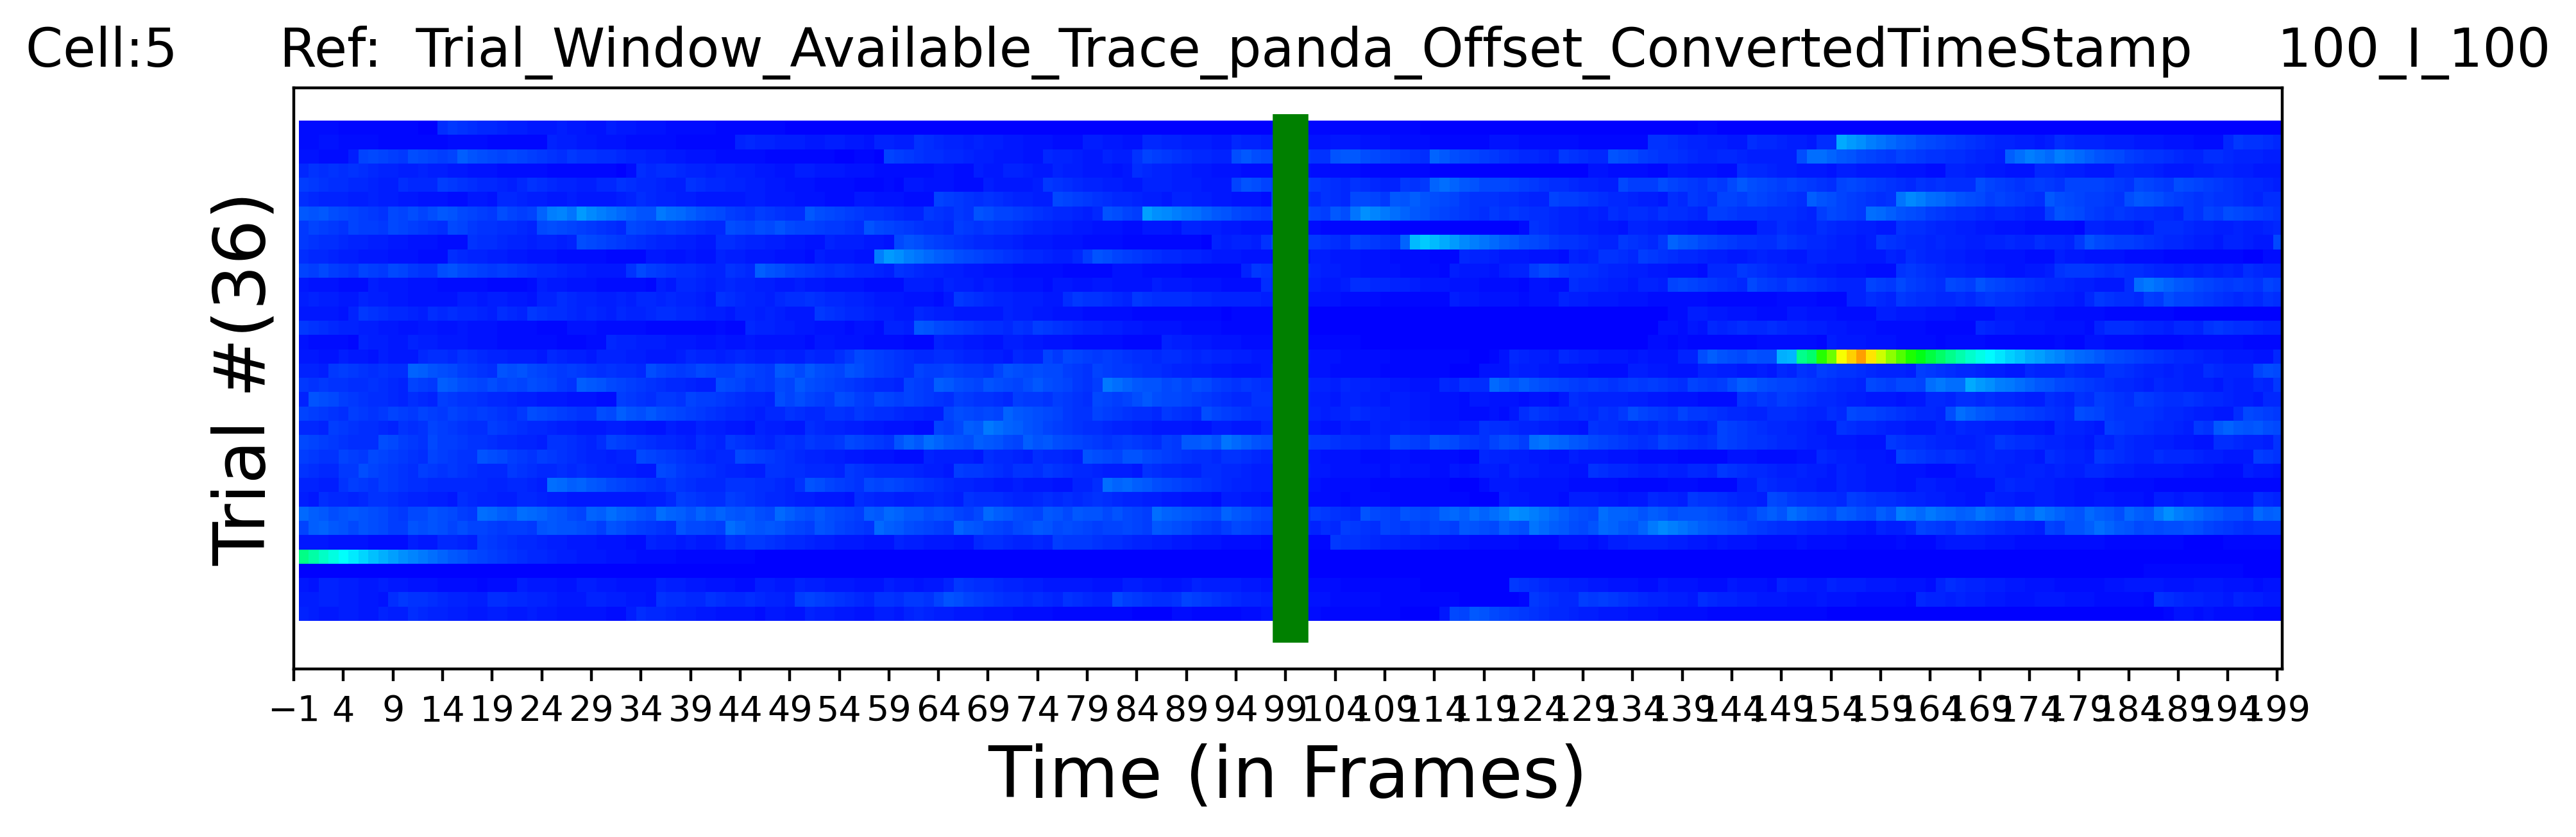

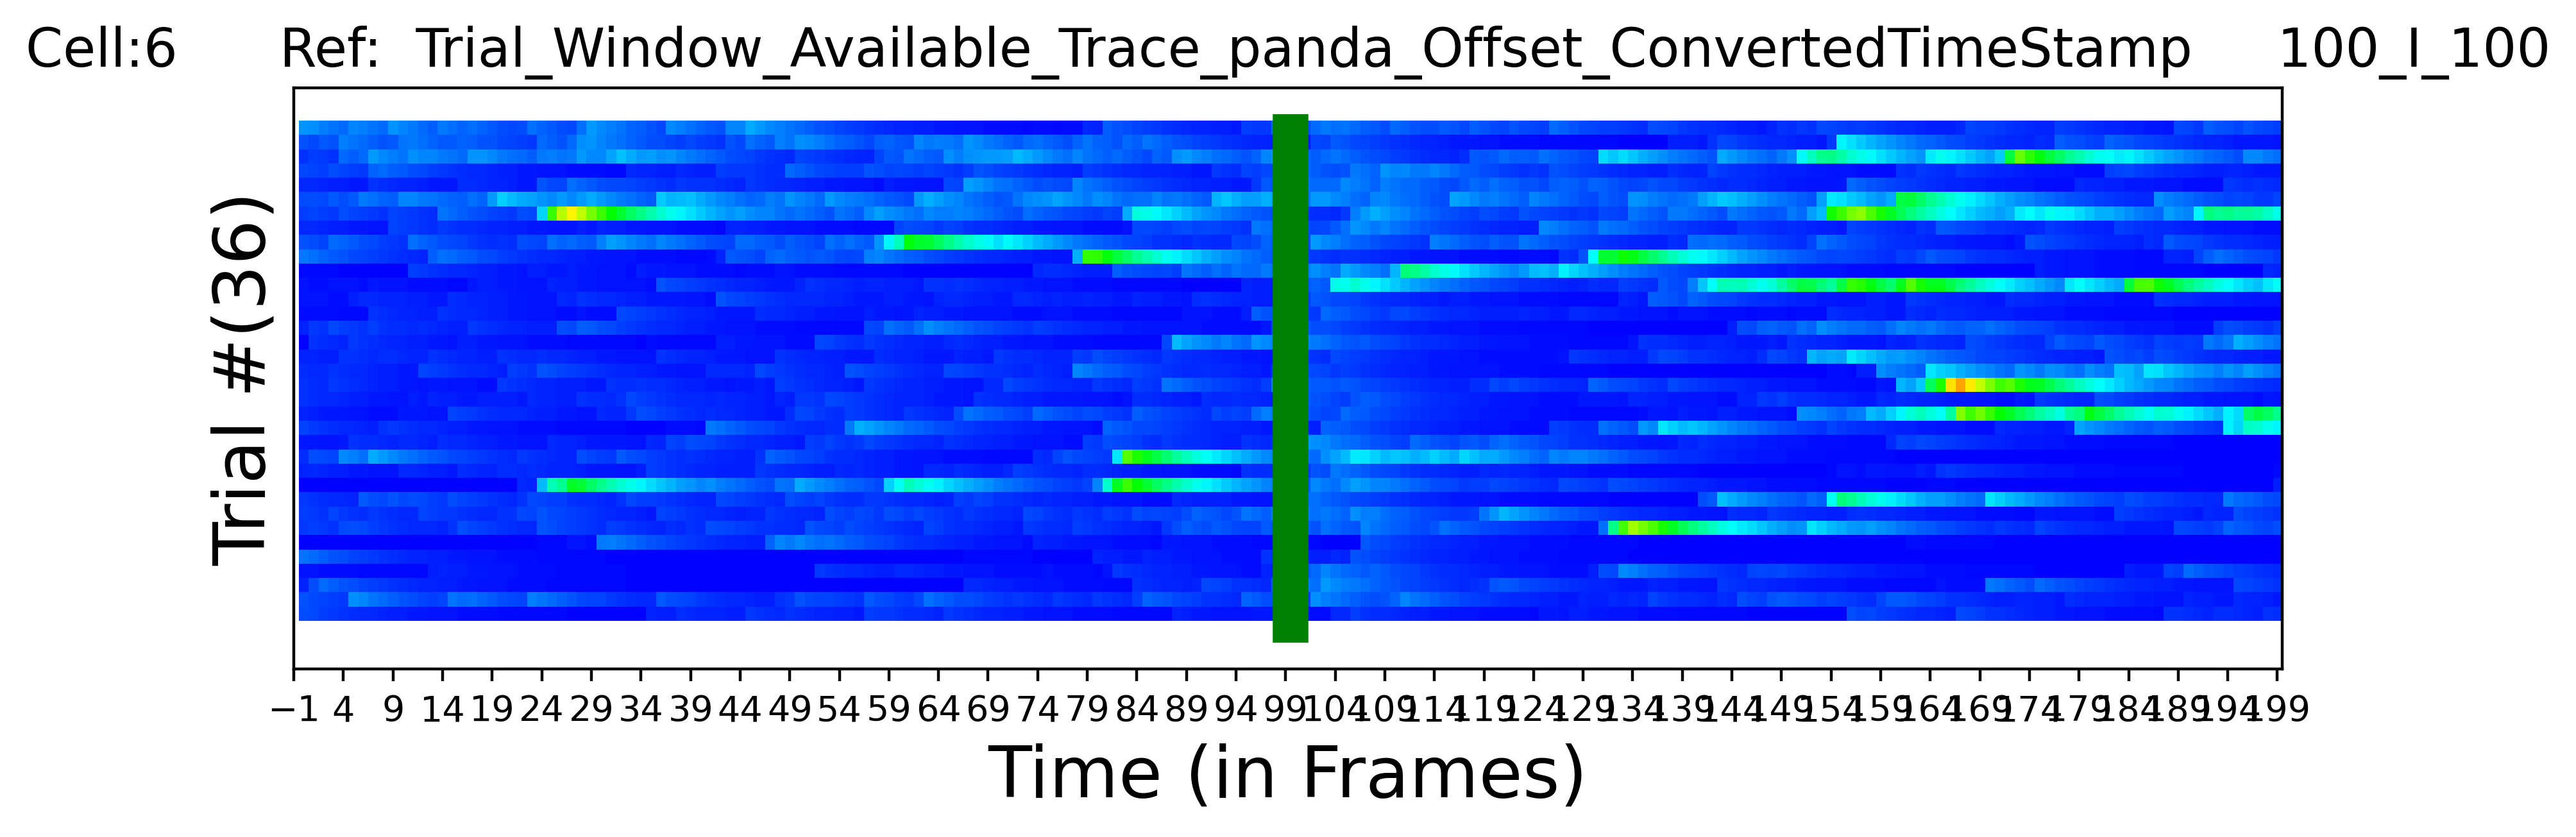

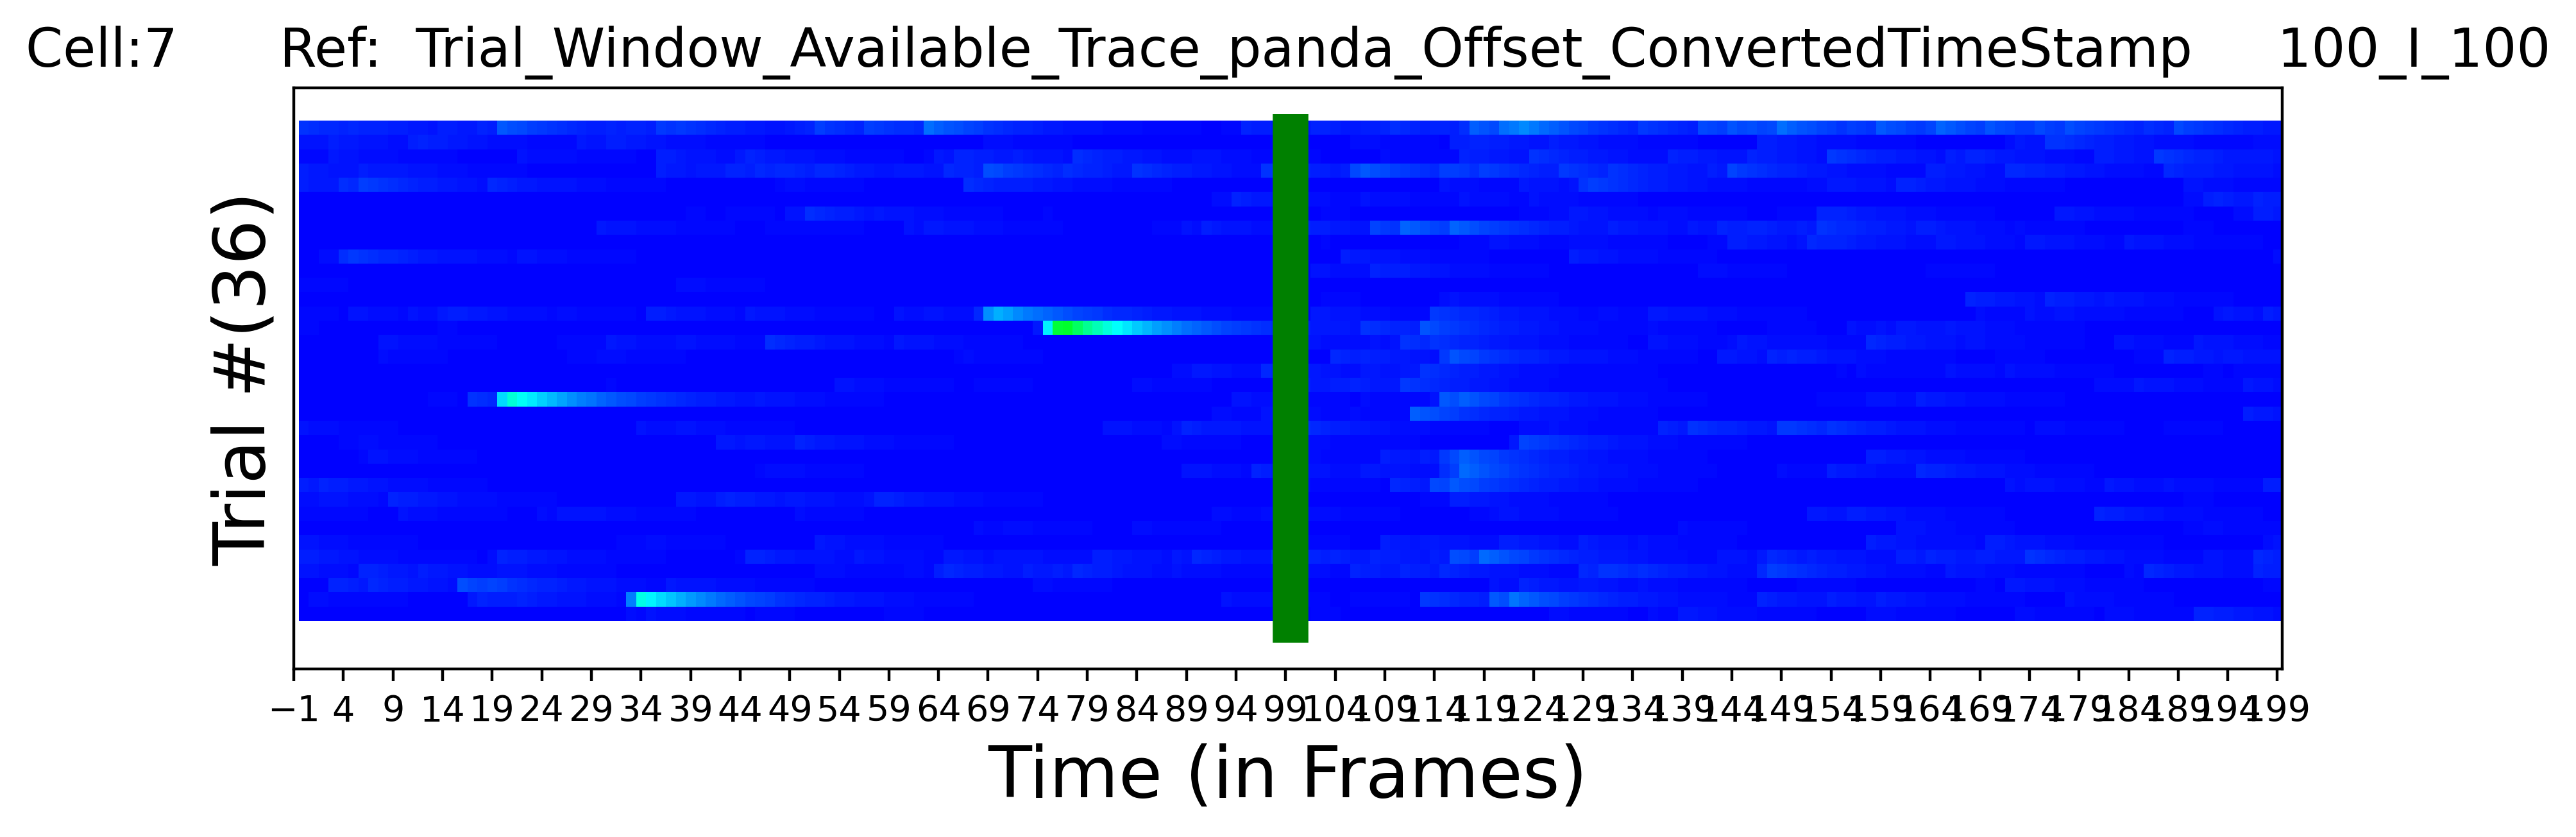

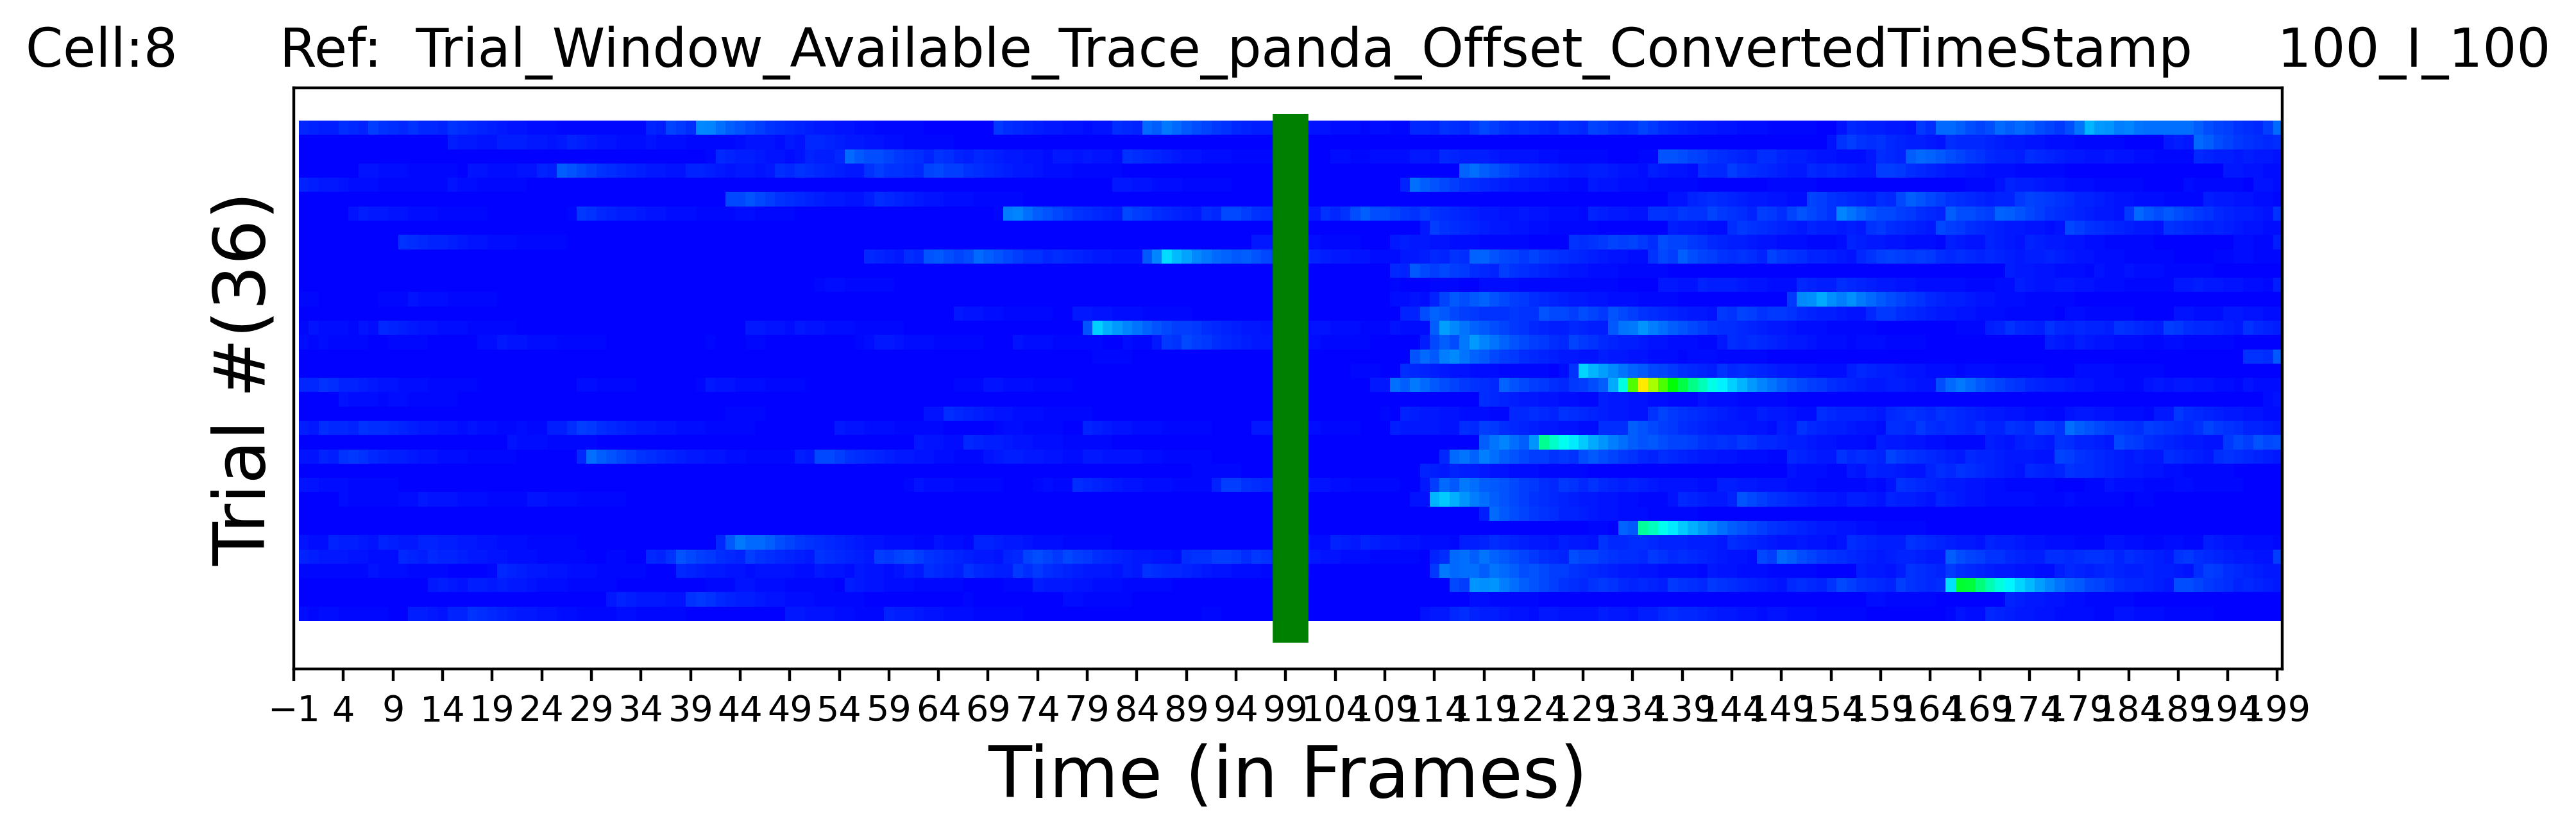

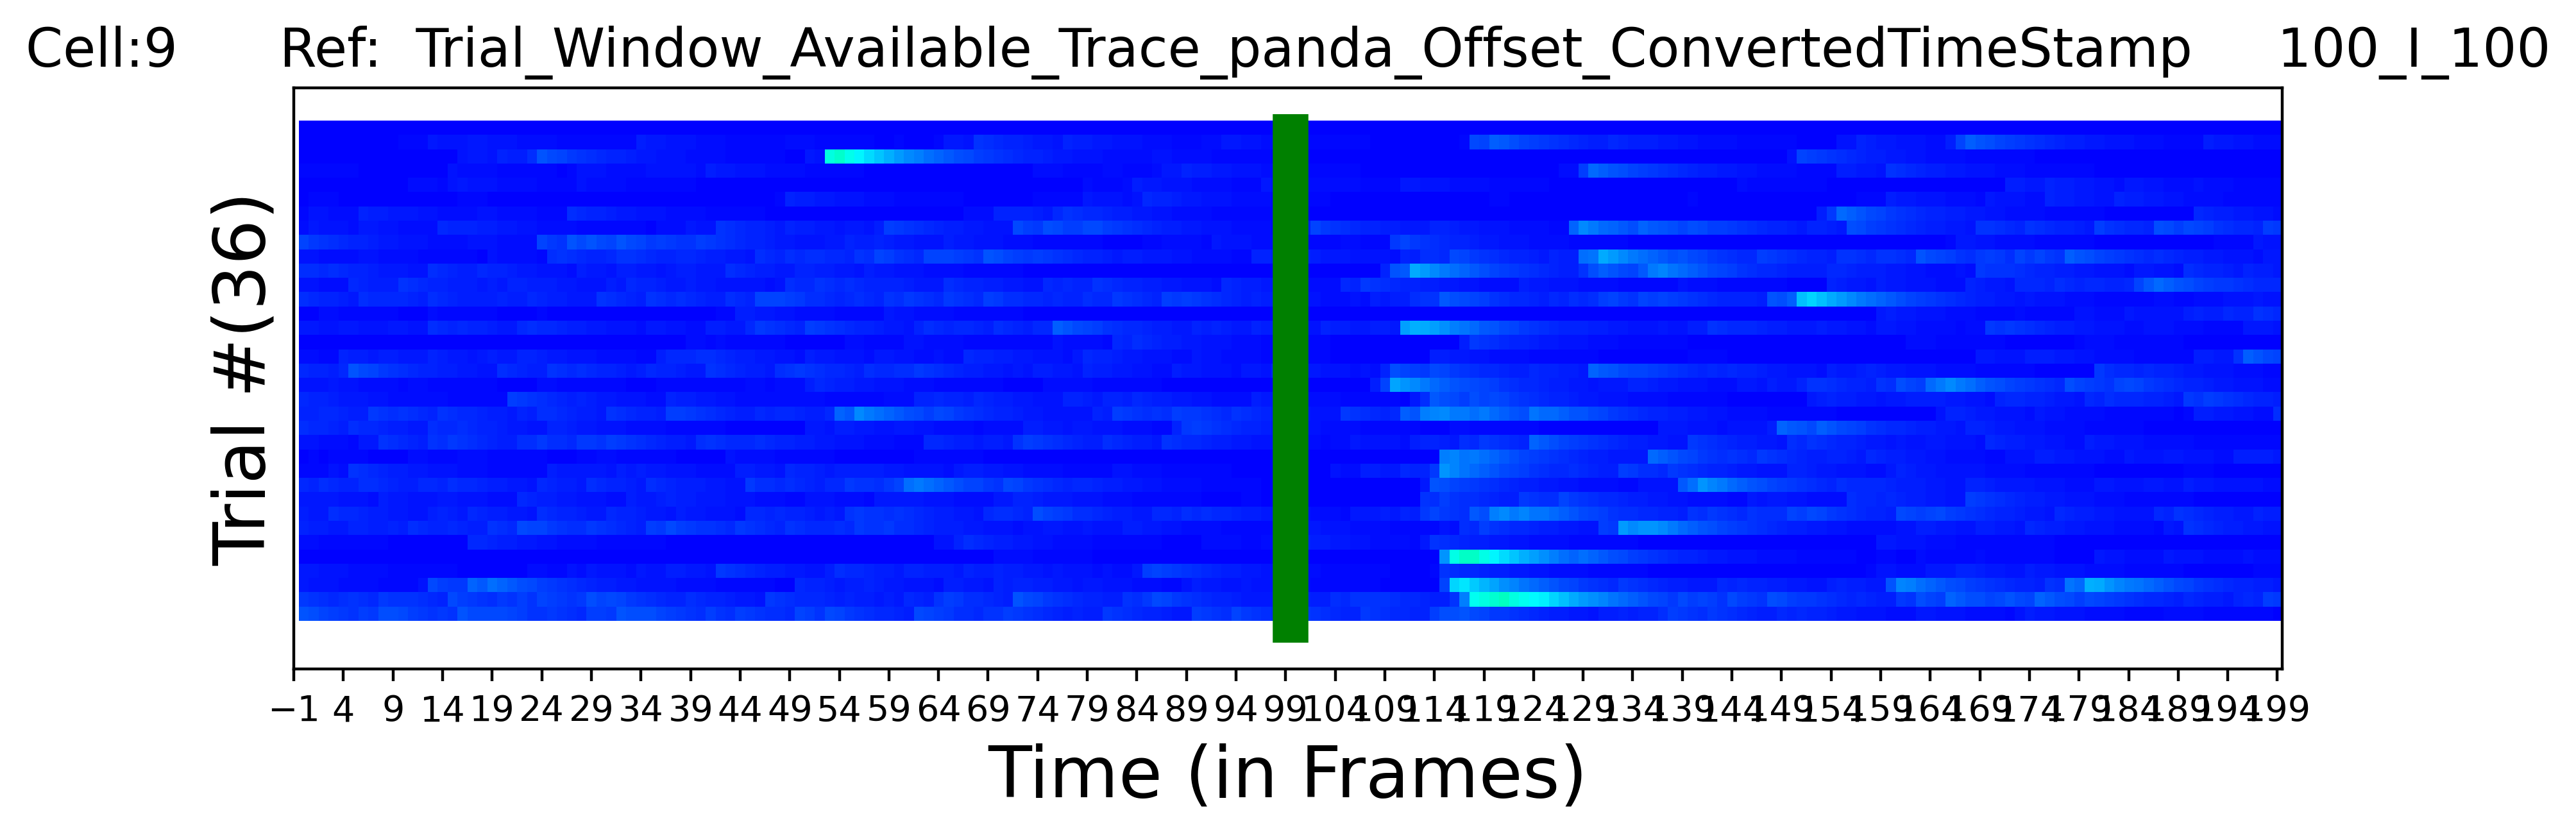

In [94]:
print(complete_save_name)
############################
print(gpio_BNC_Sync_Input_full)
display(GPIO_Summary_panda)   
print('GPIO_Image_Begin', GPIO_Image_Begin)
print('GPIO_Image_End', GPIO_Image_End)
print('\n')

##############################
print('CAIMAN Image Duration:  ')
print(CAIMAN_Image_Duration)
print('\n')
print('In an ideal world,There should be EXACTLY 480 pulse,  Data length would be close to 48000')
print('length of cell (raw)',len(df_cal))
print('length of cell (deconv)',len(df_cal_deconv) )
print('length of cell (raw_transposed)',(temporal_transpose.shape[0]))

###################################
print('Total Frame (GPIO):  ',GPIO_BNC_count )
print('GPIO_Corrected_FramesImaged (After Removing Inital GPIO pulses that beloged to other files ): ', GPIO_Corrected_FramesImaged)
print('\n')

####################################

Five_Second_On_Off_Median_Dur = np.median(dist)
print('Median Duration of 5s pulse in Frames:   ', Five_Second_On_Off_Median_Dur)
print('Maximum', max(dist))
print('Minimum', min(dist))
print('Actual number of 5s pulse:   ', Arduino_count)
print('\n')
########################
# Counting all the timestamps again 
for i in range (len(Final_Aligned_TimeStamp)):
    print((list(Final_Aligned_TimeStamp.keys())[i]), len(Final_Aligned_TimeStamp[((list(Final_Aligned_TimeStamp.keys())[i]))]))
#########################

plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
plt_raw.plot(GPIO_df['GPIO_BNC_Sync_Input_Pulse_panda']+0.5,'r')
plt_raw.plot(GPIO_df['GPIO_BNC_Sync_Output_Pulse_panda'],'b')
plt_raw.plot(GPIO_df['GPIO_5S_Pulse_panda']+1,'k')
plt_raw.plot(GPIO_df['Corrected_GPIO_BNC_Sync_Input_Pulse_panda']*(-1)+0.5,'orange')
plt_raw.plot(GPIO_df['Corrected_GPIO_BNC_Sync_Output_Pulse_panda']*(-1),'g')
plt_raw.title('Corrected GPIO BNC Input Pulse (Original on the top (Blue), Corrected in the Bottom (Green))')
#plt_raw.xlim(0, 60000)
#plt_raw.xlim(44000, 48000)
#plt_raw.xlim(44000, 51000)
# plt_raw.title('GPIO BNC Input Pulse')
#plt_raw.xlim(0, GPIO_Length)
#plt_raw.xlim(2350000, 2500000)
#plt_raw.xlim(2412000, 2414000)
plt_raw.show()


# Plotting data that was only aligned with 5s pulse (not whole session align because GPIO was never whole session align)
# But all should be the same length

plt.subplots_adjust(bottom=0.1, right=2.1, top=1)

plt.plot(BinaryGPIO_Aligned_TimeStamp['GPIO_5S_Pulse_panda']+4.5, 'b')
plt.plot(BinaryArduino_Aligned_TimeStamp['Arduino_5S_Pulse_panda']+3.5, 'r') 

plt.plot(BinaryGPIO_Aligned_TimeStamp['GPIO_IR_Pulse_panda']+2,'b')
plt.plot(BinaryArduino_Aligned_TimeStamp['ALL_IR_Traces_panda']*(-1)+2, 'r')

plt.xlim(0, len(BinaryGPIO_Aligned_TimeStamp)/2)
plt.title('GPIO = Blue;  Arduino = Red;  Only aligned by 5s pulse (NOT WHOLE session yet)')
plt.show()



##################################################
#gpio_1_full.plot(x="Time (s)", y="value_binary_temp", title = "GPIO1-original, (Time(s))",figsize=(20,5),xlim=(10,100),drawstyle='steps-post')
gpio_1_full.plot(x="Time (s)",y="value_binary_temp", title = "GPIO1-original, (Time(s))",figsize=(20,5),xlim=(10, 100 ), drawstyle='steps-post')
gpio_1_full.plot(x="Time (s)",y="Corrected_Binary", title = "Ka Corrected_Binary, (Time(s))",figsize=(20,5),xlim=(10, 100), drawstyle='steps-post')

#gpio_1_full.plot(x="Time (s)", y="value_binary", title = "GPIO1-original, (Time(s)), Ka_Filtered",figsize=(20,5),xlim=(10,100),drawstyle='steps-post')

gpio_1_full.plot(x="Time (s)",y="Temp_Corrected_Binary", title = "Temp_Corrected_Binary, (Bins), Ka Filtered",figsize=(20,5),xlim=(10, 100 ),drawstyle='steps-post')

# Assign Corrected_Binary back to Value_binary
gpio_1_full['value_binary']= Corrected_Binary
gpio_1_full.plot(x="Time (s)",y="value_binary", title = "GPIO1-original, (Time(s))",figsize=(20,5),xlim=(10, 100 ), drawstyle='steps-post')


# print(Pulse_Dur)
Pulse_Dur.plot.scatter(x="Pulse_Duration_Time",y="Random_Num", title = "5 Sec Pulse Duration" , figsize=(20,5)) 
#print( Pulse_Duration_Time)
 



###################################################
# Arduino

fig = plt_hist.figure(figsize =(19.2, 19.8), dpi = 400.0)
ax = fig.add_subplot(3,1 ,3)
#dist = [ -10, 20, 10, 90, 95, 90, 90, 0 , 4]  #. Before minus After
dist = Arduino_Dur[1:Arduino_count]   #. Omit first value (which is Ca Imaging start)
# We can set the number of bins with the *bins* keyword argument.
n, bins, patches = plt_hist.hist(dist, bins=n_bins)
plt_hist.title(('Arduino:  Distribution of # frames that represents the 5 seconds(on/off)'), fontdict=None, loc='center', size = 20)
plt_hist.ylabel('Count', size = 20)
plt_hist.xlabel('Difference', size = 20)
#plt_hist.bar_label(patches)
#print(max(n))   #. max for y axis (important for box plot position)

#. Anything that goes beyond 2 times the median duration for 5 second pulse indicates missing timestamps 
#. Anything that goes under 1/2 the median duration for 5 second pulse indicates noise contimation in 5 second pulse 
ax.vlines(x= np.median(dist)*2, ymin=0, ymax=max(n), colors='red', lw=10, label='vline_single - partial height')
ax.vlines(x= np.median(dist)/2, ymin=0, ymax=max(n), colors='red', lw=10, label='vline_single - partial height')

Position_one_label = 'Veh-Baseline'

# Box plot Settings
boxprops = dict(linestyle='-', linewidth=5, color='darkgoldenrod')
flierprops = dict(marker='o', markerfacecolor='green', markersize=12,linestyle='none')
medianprops = dict(linestyle='-.', linewidth=5, color='Yellow')
meanpointprops = dict(marker='D', markeredgecolor='red',markerfacecolor='red')
meanlineprops = dict(linestyle='--', linewidth=5, color='red')
whiskerprops = dict(linestyle='-', linewidth=5, color='darkgoldenrod')
capprops = dict(linestyle='-', linewidth=5, color='darkgoldenrod')

plt_hist.boxplot(dist, showmeans=True, meanline = True, positions=[max(n)/2], widths = max(n)/4, boxprops=boxprops,  meanprops=meanlineprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops, vert=False) #red is mean,  green is median
plt_hist.show()
# Five_Second_On_Off_Median_Dur = np.median(dist)
# print('Median Duration of 5s pulse in Frames:   ', Five_Second_On_Off_Median_Dur)
# print('Maximum', max(dist))
# print('Minimum', min(dist))
# print('Actual number of 5s pulse:   ', Arduino_count)

#############################
# Plot Scaled Traces,  Full Range (0 to 1), log scale
#TransScaledTraces = np.transpose(Merged_Data.loc[0:len(Merged_Data), CellList_raw])
TransScaledTraces = np.transpose(ReScaled.loc[0:len(Merged_Data), CellList_raw])
#plt_Heat_scaled.imshow(TransScaledTraces, cmap=plt_Heat_scaled.cm.gist_yarg, aspect = 'auto')
plt_raw.imshow(TransScaledTraces, cmap=plt_raw.cm.gist_rainbow_r, aspect = 'auto')
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
plt_raw.xlabel('Frame #', size = 20)
plt_raw.ylabel(('Cell #'), fontdict=None, loc='center')
# Color axis
cax = plt_raw.axes([2.2, 0.1, 0.075, 0.8])
#plt_Heat_scaled.yscale('log')
plt_raw.clim(-0.3, 1)###############################################################  Set Range for Color
plt_raw.colorbar(cax=cax)
plt_raw.show()
###############################################################################
#  Emergency added for resampling Trial_Initiation data to cell length******** Demonstration Purpose
print('\n')
print("Median of all cells")
print('\n')

#BinSize = 20  # Unit in frames (20 = 1 seconds (20 frames/second))
WinBegin = 100   #Baseline signal Before Reference Event,  There is a limit in now far back you can go, limited by distance from trial initiation    
WinEnd= 100     # Signal after Reference Event

#Signal= Merged_Data['Mean_of_All_Cells_Rescaled_df'].astype(float)
Signal= Merged_Data['Median_of_All_Cells_Rescaled_df'].astype(float)
#Signal = ReScaled[CellList_raw[0]].astype(float)   # access data under signal label in df dataframe
#Signal = ReScaled[28].astype(float)   # access data under signal label in df dataframe
#Signal = Merged_Data[44].astype(float)   # access data under signal label in df dataframe
ReferenceEvent = 'Trial_Window_Available_Trace_panda_Offset_ConvertedTimeStamp'
#ReferenceEvent = 'Middle_SOL_Trace_panda_Onset_ConvertedTimeStamp'
#ReferenceEvent ='Right_LED_Traces_panda_Onset_ConvertedTimeStamp'


SignalTraces = {}
print(i)
for i in range(1, len(WholeSession_Aligned_Event_Count_TimeStamps[ReferenceEvent])):


    tempt = WholeSession_Aligned_Event_Count_TimeStamps[ReferenceEvent][i]
    Reference_Time = int(tempt[0])  # convert to integer
    
    
    if ((WinBegin + WinEnd) == len(Signal.values[(Reference_Time-WinBegin): (Reference_Time+WinEnd)])):  #full length data, no cutoffs
        SignalTraces.update({('Reference_' + str(i)) :  Signal.values[(Reference_Time-WinBegin): (Reference_Time+WinEnd)]})
    else:
        SignalTraces.update({('Reference_' + str(i)) : Filler_panda })




# Convert dictionary to pandas data frame 

SignalTraces_panda = SignalTraces_pd.DataFrame(SignalTraces)

    ######## Plot Perievent#########
# Plot Scaled Traces,  Full Range (0 to 1), log scale
fig = plt.figure(figsize =(10, 10), dpi = 400.0)
#fig = plt.figure(figsize =(19.2, 10.8), dpi = 400.0)
#fig = plt_perievent_traces.figure()
ax = fig.add_subplot(3,1 ,1)

Perievent_Traces = np.transpose(SignalTraces_panda)
#plt_Heat_scaled.imshow(TransScaledTraces, cmap=plt_Heat_scaled.cm.gist_yarg, aspect = 'auto')
im = plt.imshow(Perievent_Traces, interpolation = 'none',  cmap=plt.cm.gist_rainbow_r, aspect = 'auto')


plt.title('      Ref:  '+ ReferenceEvent + '     ' + str(WinBegin) + '_I_' + str(WinEnd),size = 15)

plt.xlabel('Time (in Frames)', size = 20)
plt.ylabel(('Trial #' + '(' + str(len(WholeSession_Aligned_Event_Count_TimeStamps[ReferenceEvent]))+ ')'), size = 20)


    # Draw Reference Line and 
ax.vlines(x= WinBegin-0.5, ymin=-1, ymax=len(WholeSession_Aligned_Event_Count_TimeStamps[ReferenceEvent]), colors='green', lw=10, label='vline_single - partial height')
plt.xticks(np.arange(-1, (WinBegin +WinEnd +1), 5))
plt.yticks(np.arange(0, len(Event_Count_TimeStamps[ReferenceEvent]), 5.0))

# Color axis
#cax = plt_perievent_traces.axes([2.2, 0.1, 0.075, 0.8])
#plt_Heat_scaled.yscale('log')

#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="3%", pad=0.05)
#plt_perievent_traces.clim(-1000, 3000)###############################################################  Set Range for Color
plt.clim(min(Merged_Data['Median_of_All_Cells_Rescaled_df']), max(Merged_Data['Median_of_All_Cells_Rescaled_df'])*0.7)###############################################################  Set Range for Color
#plt.clim(min(Merged_Data['Mean_of_All_Cells_Rescaled_df']), max(Merged_Data['Mean_of_All_Cells_Rescaled_df']))#########################
plt.colorbar(im, cax=cax)


print('Figure omitted the first trial') 
################################################################################
for xx in range(1, 10): # plot the first 20 cells

    #BinSize = 20  # Unit in frames (20 = 1 seconds (20 frames/second))
    WinBegin = 100   #Baseline signal Before Reference Event,  There is a limit in now far back you can go, limited by distance from trial initiation    
    WinEnd= 100     # Signal after Reference Event
    
    Signal = ReScaled[CellList_raw[xx]].astype(float)   # access data under signal label in df dataframe
    #Signal = ReScaled[15].astype(float)   # access data under signal label in df dataframe
    #Signal = Merged_Data[44].astype(float)   # access data under signal label in df dataframe
    ReferenceEvent = 'Trial_Window_Available_Trace_panda_Offset_ConvertedTimeStamp'
    #ReferenceEvent = 'Middle_SOL_Trace_panda_Onset_ConvertedTimeStamp'
    #ReferenceEvent ='Right_LED_Traces_panda_Onset_ConvertedTimeStamp'
    
    
    SignalTraces = {}
    #print(i)
    for i in range(1, len(WholeSession_Aligned_Event_Count_TimeStamps[ReferenceEvent])):
    
    
        tempt = WholeSession_Aligned_Event_Count_TimeStamps[ReferenceEvent][i]
        Reference_Time = int(tempt[0])  # convert to integer
        
        
        if ((WinBegin + WinEnd) == len(Signal.values[(Reference_Time-WinBegin): (Reference_Time+WinEnd)])):  #full length data, no cutoffs
            SignalTraces.update({('Reference_' + str(i)) :  Signal.values[(Reference_Time-WinBegin): (Reference_Time+WinEnd)]})
        else:
            SignalTraces.update({('Reference_' + str(i)) : Filler_panda })
    
    
    
    
    # Convert dictionary to pandas data frame 
    
    SignalTraces_panda = SignalTraces_pd.DataFrame(SignalTraces)
    
        ######## Plot Perievent#########
    # Plot Scaled Traces,  Full Range (0 to 1), log scale
    fig = plt.figure(figsize =(10, 10), dpi = 400.0)
    #fig = plt.figure(figsize =(19.2, 10.8), dpi = 400.0)
    #fig = plt_perievent_traces.figure()
    ax = fig.add_subplot(3,1 ,1)
    
    Perievent_Traces = np.transpose(SignalTraces_panda)
    #plt_Heat_scaled.imshow(TransScaledTraces, cmap=plt_Heat_scaled.cm.gist_yarg, aspect = 'auto')
    im = plt.imshow(Perievent_Traces, interpolation = 'none',  cmap=plt.cm.gist_rainbow_r, aspect = 'auto')
    
    
    plt.title('Cell:' + str(CellList_raw[xx]) +'      Ref:  '+ ReferenceEvent + '     ' + str(WinBegin) + '_I_' + str(WinEnd),size = 15)
    
    plt.xlabel('Time (in Frames)', size = 20)
    plt.ylabel(('Trial #' + '(' + str(len(WholeSession_Aligned_Event_Count_TimeStamps[ReferenceEvent]))+ ')'), size = 20)
    
    
        # Draw Reference Line and 
    ax.vlines(x= WinBegin-0.5, ymin=-1, ymax=len(WholeSession_Aligned_Event_Count_TimeStamps[ReferenceEvent]), colors='green', lw=10, label='vline_single - partial height')
    plt.xticks(np.arange(-1, (WinBegin +WinEnd +1), 5))
    plt.yticks(np.arange(0, len(Event_Count_TimeStamps[ReferenceEvent]), 5.0))
    
    # Color axis
    #cax = plt_perievent_traces.axes([2.2, 0.1, 0.075, 0.8])
    #plt_Heat_scaled.yscale('log')
    
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="3%", pad=0.05)
    #plt_perievent_traces.clim(-1000, 3000)###############################################################  Set Range for Color
    plt.clim(-0.3, 1)###############################################################  Set Range for Color
    plt.colorbar(im, cax=cax)
    
    
    #print('Figure omitted the first trial') 

